## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7454372201882819590
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7175995392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3414742131248039534
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_5-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[states[2], states[3]])

    decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[states[4], states[5]])
    
    decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[states[6], states[7]])
    
    decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[states[8], states[9]])

    dense_1_outputs = dense_1(decoder_outputs_5)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_3
    states = [dh1, dc1, dh2, dc2, dh3, dc3, dh4, dc4, dh5, dc5]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 32)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

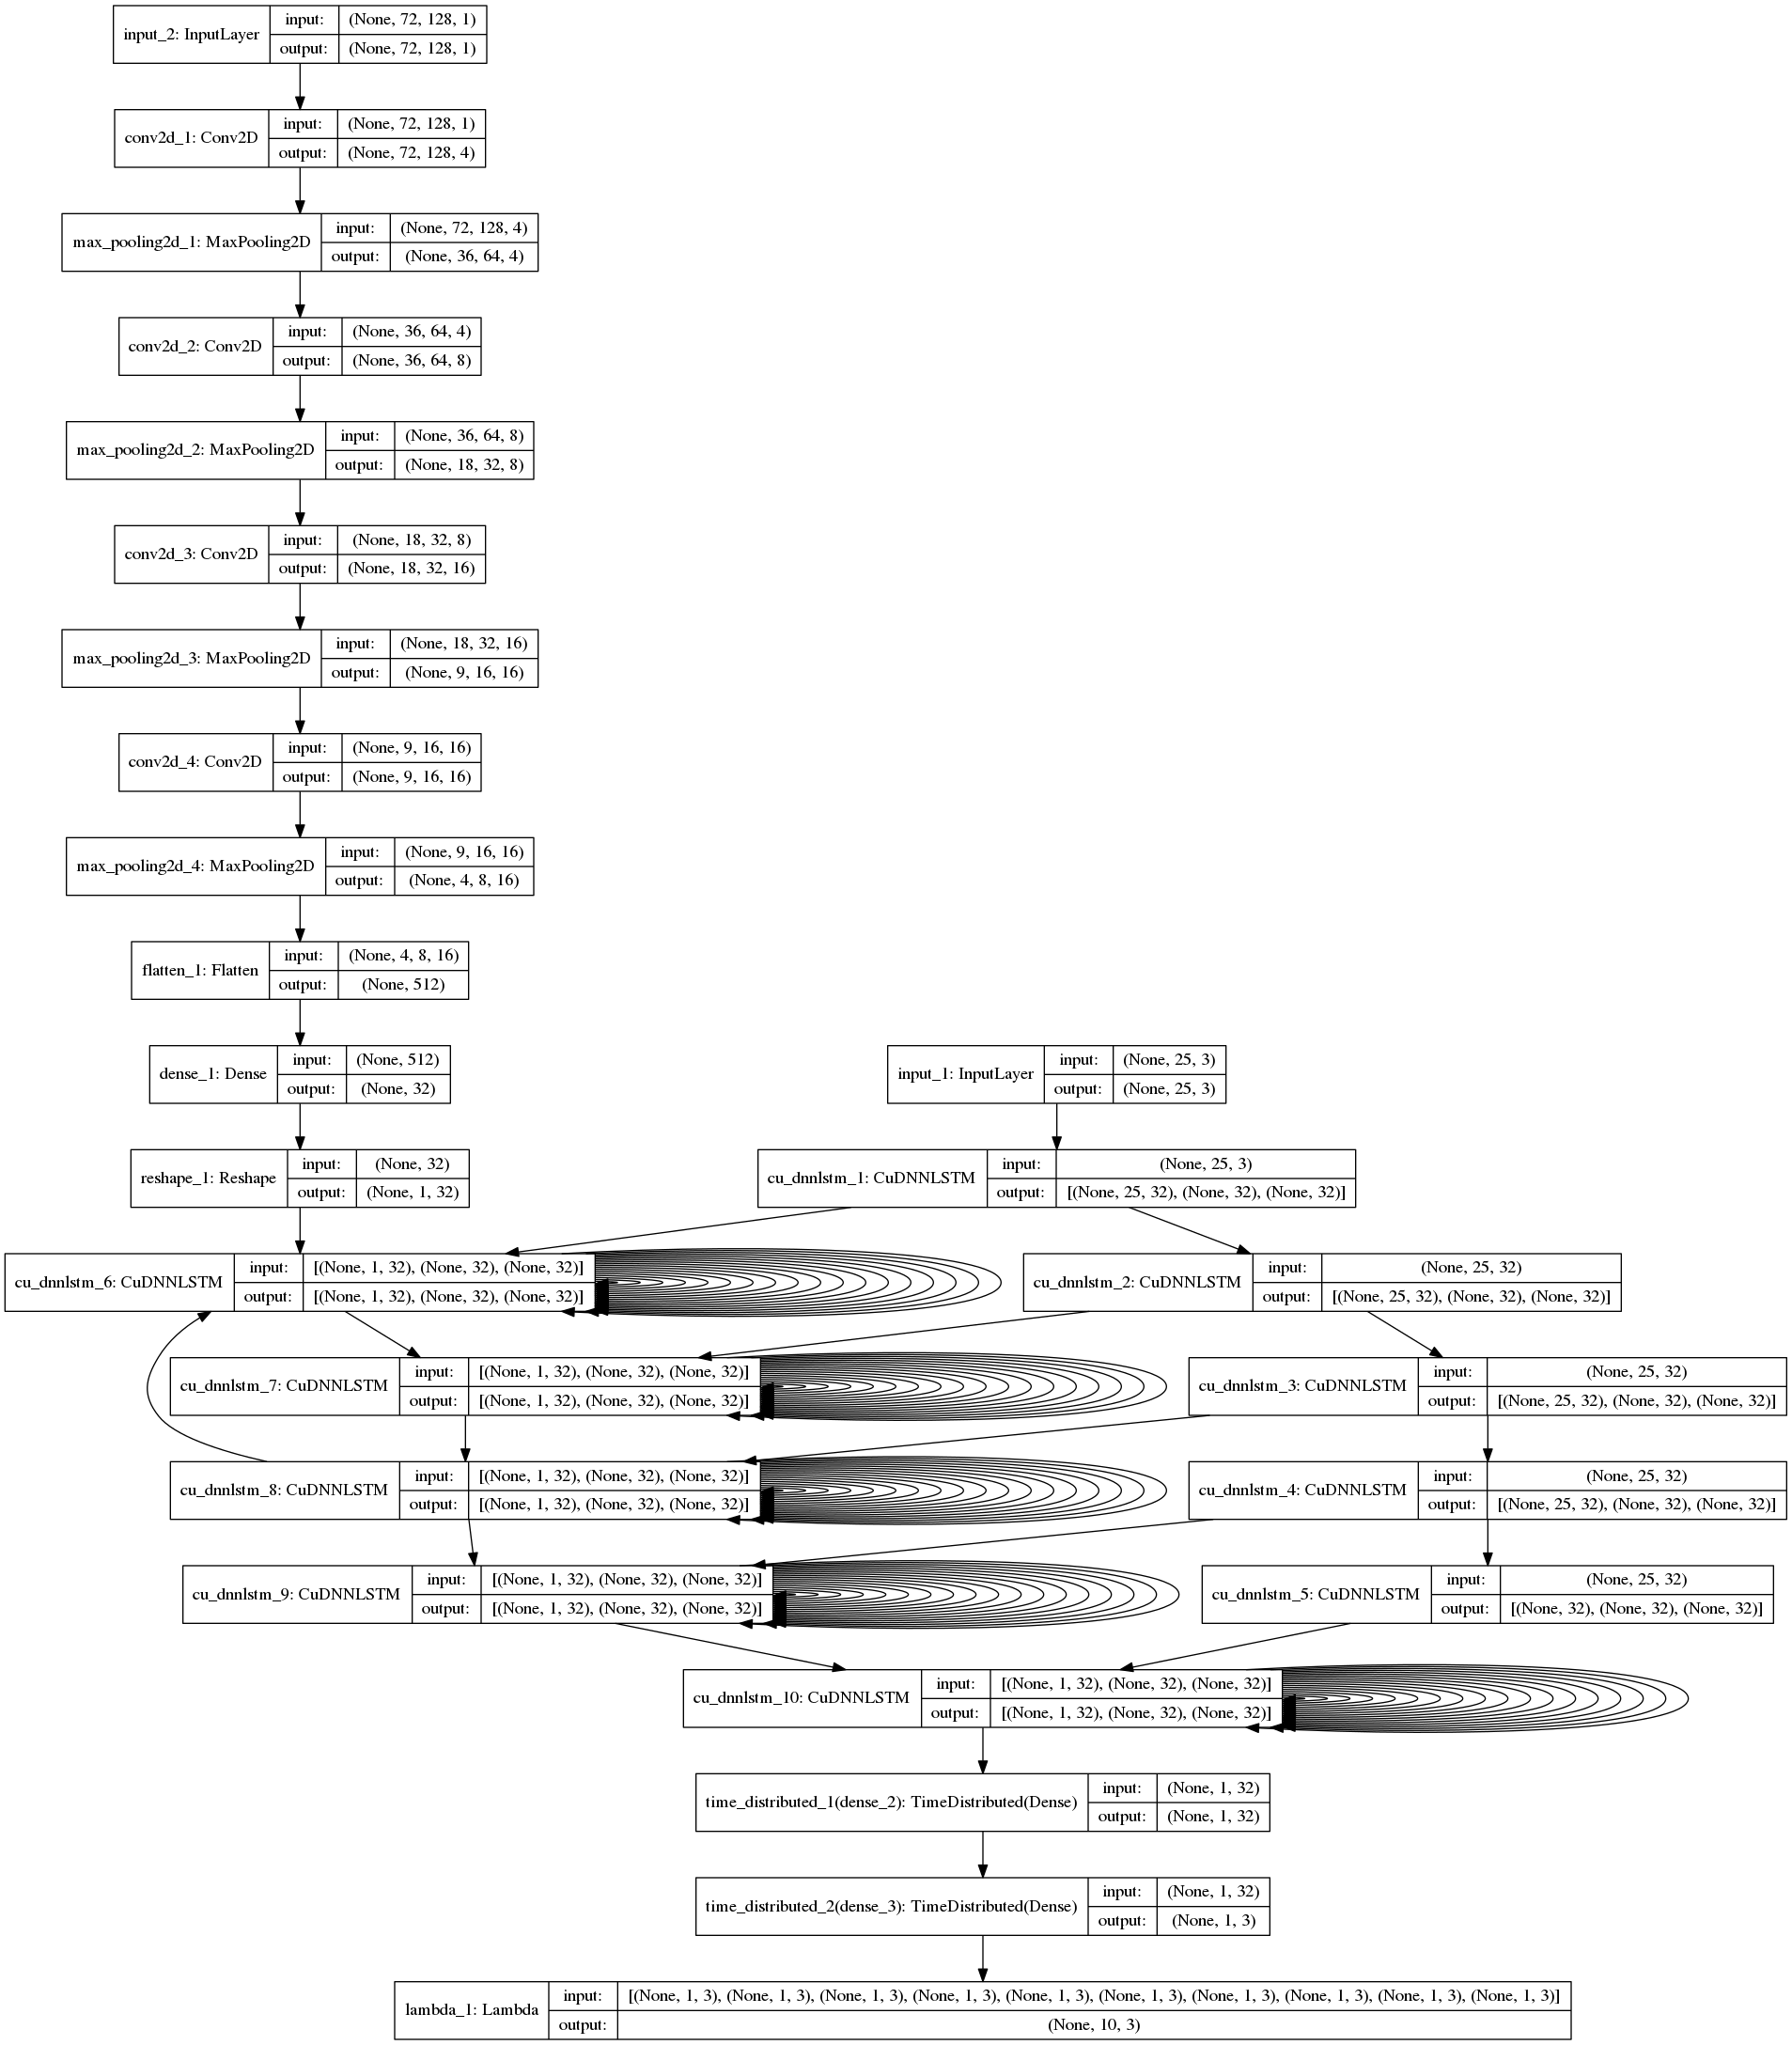

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


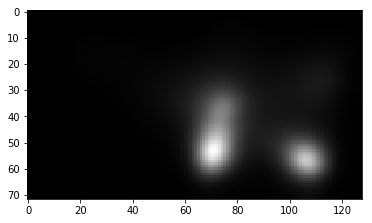

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 41:49 - loss: 0.0801 - rmse: 0.2639

  2/422 [..............................] - ETA: 29:32 - loss: 0.0787 - rmse: 0.2351

  3/422 [..............................] - ETA: 25:23 - loss: 0.0970 - rmse: 0.2534

  4/422 [..............................] - ETA: 23:14 - loss: 0.0866 - rmse: 0.2242

  5/422 [..............................] - ETA: 21:59 - loss: 0.0782 - rmse: 0.2004

  6/422 [..............................] - ETA: 21:07 - loss: 0.0765 - rmse: 0.1933

  7/422 [..............................] - ETA: 20:26 - loss: 0.0713 - rmse: 0.1824

  8/422 [..............................] - ETA: 19:58 - loss: 0.0711 - rmse: 0.1827

  9/422 [..............................] - ETA: 19:36 - loss: 0.0725 - rmse: 0.1855

 10/422 [..............................] - ETA: 19:11 - loss: 0.0727 - rmse: 0.1870

 11/422 [..............................] - ETA: 18:54 - loss: 0.0719 - rmse: 0.1857

 12/422 [..............................] - ETA: 18:38 - loss: 0.0672 - rmse: 0.1767

 13/422 [..............................] - ETA: 18:30 - loss: 0.0689 - rmse: 0.1819

 14/422 [..............................] - ETA: 18:23 - loss: 0.0674 - rmse: 0.1781

 15/422 [>.............................] - ETA: 18:12 - loss: 0.0652 - rmse: 0.1777

 16/422 [>.............................] - ETA: 18:04 - loss: 0.0643 - rmse: 0.1742

 17/422 [>.............................] - ETA: 17:41 - loss: 0.0684 - rmse: 0.1849

 18/422 [>.............................] - ETA: 17:35 - loss: 0.0681 - rmse: 0.1860

 19/422 [>.............................] - ETA: 17:28 - loss: 0.0693 - rmse: 0.1882

 20/422 [>.............................] - ETA: 17:21 - loss: 0.0682 - rmse: 0.1874

 21/422 [>.............................] - ETA: 17:14 - loss: 0.0702 - rmse: 0.1924

 22/422 [>.............................] - ETA: 17:09 - loss: 0.0698 - rmse: 0.1907

 23/422 [>.............................] - ETA: 17:03 - loss: 0.0741 - rmse: 0.2001

 24/422 [>.............................] - ETA: 16:58 - loss: 0.0748 - rmse: 0.2026

 25/422 [>.............................] - ETA: 16:54 - loss: 0.0731 - rmse: 0.1978

 26/422 [>.............................] - ETA: 16:50 - loss: 0.0723 - rmse: 0.1961

 27/422 [>.............................] - ETA: 16:46 - loss: 0.0715 - rmse: 0.1935

 28/422 [>.............................] - ETA: 16:15 - loss: 0.0703 - rmse: 0.1903

 29/422 [=>............................] - ETA: 16:08 - loss: 0.0699 - rmse: 0.1891

 30/422 [=>............................] - ETA: 16:06 - loss: 0.0708 - rmse: 0.1908

 31/422 [=>............................] - ETA: 16:04 - loss: 0.0715 - rmse: 0.1936

 32/422 [=>............................] - ETA: 15:38 - loss: 0.0710 - rmse: 0.1934

 33/422 [=>............................] - ETA: 15:35 - loss: 0.0699 - rmse: 0.1907

 34/422 [=>............................] - ETA: 15:34 - loss: 0.0688 - rmse: 0.1878

 35/422 [=>............................] - ETA: 15:11 - loss: 0.0680 - rmse: 0.1864

 36/422 [=>............................] - ETA: 14:49 - loss: 0.0676 - rmse: 0.1845

 37/422 [=>............................] - ETA: 14:48 - loss: 0.0664 - rmse: 0.1821

 38/422 [=>............................] - ETA: 14:49 - loss: 0.0655 - rmse: 0.1795

 39/422 [=>............................] - ETA: 14:29 - loss: 0.0668 - rmse: 0.1822

 40/422 [=>............................] - ETA: 14:25 - loss: 0.0673 - rmse: 0.1827

 41/422 [=>............................] - ETA: 14:24 - loss: 0.0676 - rmse: 0.1834

 42/422 [=>............................] - ETA: 14:06 - loss: 0.0683 - rmse: 0.1858

 43/422 [==>...........................] - ETA: 14:00 - loss: 0.0679 - rmse: 0.1852

 44/422 [==>...........................] - ETA: 14:00 - loss: 0.0692 - rmse: 0.1877

 45/422 [==>...........................] - ETA: 13:59 - loss: 0.0689 - rmse: 0.1879

 46/422 [==>...........................] - ETA: 13:59 - loss: 0.0693 - rmse: 0.1888

 47/422 [==>...........................] - ETA: 13:59 - loss: 0.0693 - rmse: 0.1892

 48/422 [==>...........................] - ETA: 13:43 - loss: 0.0693 - rmse: 0.1894

 49/422 [==>...........................] - ETA: 13:28 - loss: 0.0692 - rmse: 0.1894

 50/422 [==>...........................] - ETA: 13:29 - loss: 0.0688 - rmse: 0.1883

 51/422 [==>...........................] - ETA: 13:30 - loss: 0.0688 - rmse: 0.1890

 52/422 [==>...........................] - ETA: 13:27 - loss: 0.0687 - rmse: 0.1881

 53/422 [==>...........................] - ETA: 13:27 - loss: 0.0681 - rmse: 0.1867

 54/422 [==>...........................] - ETA: 13:26 - loss: 0.0676 - rmse: 0.1851

 55/422 [==>...........................] - ETA: 13:13 - loss: 0.0679 - rmse: 0.1857

 56/422 [==>...........................] - ETA: 13:12 - loss: 0.0677 - rmse: 0.1863

 57/422 [===>..........................] - ETA: 13:12 - loss: 0.0696 - rmse: 0.1900

 58/422 [===>..........................] - ETA: 13:00 - loss: 0.0692 - rmse: 0.1888

 59/422 [===>..........................] - ETA: 13:00 - loss: 0.0687 - rmse: 0.1880

 60/422 [===>..........................] - ETA: 13:00 - loss: 0.0688 - rmse: 0.1889

 61/422 [===>..........................] - ETA: 13:00 - loss: 0.0692 - rmse: 0.1893

 62/422 [===>..........................] - ETA: 12:59 - loss: 0.0700 - rmse: 0.1914

 63/422 [===>..........................] - ETA: 12:59 - loss: 0.0698 - rmse: 0.1904

 64/422 [===>..........................] - ETA: 12:59 - loss: 0.0701 - rmse: 0.1912

 65/422 [===>..........................] - ETA: 12:47 - loss: 0.0696 - rmse: 0.1901

 66/422 [===>..........................] - ETA: 12:47 - loss: 0.0690 - rmse: 0.1880

 67/422 [===>..........................] - ETA: 12:36 - loss: 0.0687 - rmse: 0.1876

 68/422 [===>..........................] - ETA: 12:25 - loss: 0.0684 - rmse: 0.1868

 69/422 [===>..........................] - ETA: 12:25 - loss: 0.0682 - rmse: 0.1867

 70/422 [===>..........................] - ETA: 12:21 - loss: 0.0683 - rmse: 0.1870

 71/422 [====>.........................] - ETA: 12:22 - loss: 0.0677 - rmse: 0.1851

 72/422 [====>.........................] - ETA: 12:21 - loss: 0.0680 - rmse: 0.1856

 73/422 [====>.........................] - ETA: 12:22 - loss: 0.0683 - rmse: 0.1871

 74/422 [====>.........................] - ETA: 12:22 - loss: 0.0682 - rmse: 0.1871

 75/422 [====>.........................] - ETA: 12:22 - loss: 0.0683 - rmse: 0.1870

 76/422 [====>.........................] - ETA: 12:13 - loss: 0.0685 - rmse: 0.1876

 77/422 [====>.........................] - ETA: 12:12 - loss: 0.0679 - rmse: 0.1861

 78/422 [====>.........................] - ETA: 12:12 - loss: 0.0676 - rmse: 0.1853

 79/422 [====>.........................] - ETA: 12:13 - loss: 0.0674 - rmse: 0.1844

 80/422 [====>.........................] - ETA: 12:12 - loss: 0.0670 - rmse: 0.1831

 81/422 [====>.........................] - ETA: 12:12 - loss: 0.0674 - rmse: 0.1835

 82/422 [====>.........................] - ETA: 12:11 - loss: 0.0671 - rmse: 0.1830

 83/422 [====>.........................] - ETA: 12:10 - loss: 0.0670 - rmse: 0.1832

 84/422 [====>.........................] - ETA: 12:09 - loss: 0.0668 - rmse: 0.1829

 85/422 [=====>........................] - ETA: 12:08 - loss: 0.0664 - rmse: 0.1816

 86/422 [=====>........................] - ETA: 12:07 - loss: 0.0670 - rmse: 0.1830

 87/422 [=====>........................] - ETA: 12:06 - loss: 0.0664 - rmse: 0.1813

 88/422 [=====>........................] - ETA: 12:05 - loss: 0.0660 - rmse: 0.1803

 89/422 [=====>........................] - ETA: 11:57 - loss: 0.0656 - rmse: 0.1800

 90/422 [=====>........................] - ETA: 11:56 - loss: 0.0654 - rmse: 0.1800

 91/422 [=====>........................] - ETA: 11:48 - loss: 0.0653 - rmse: 0.1796

 92/422 [=====>........................] - ETA: 11:47 - loss: 0.0658 - rmse: 0.1812

 93/422 [=====>........................] - ETA: 11:39 - loss: 0.0658 - rmse: 0.1810

 94/422 [=====>........................] - ETA: 11:31 - loss: 0.0658 - rmse: 0.1809

 95/422 [=====>........................] - ETA: 11:31 - loss: 0.0657 - rmse: 0.1807

 96/422 [=====>........................] - ETA: 11:30 - loss: 0.0654 - rmse: 0.1797

 97/422 [=====>........................] - ETA: 11:23 - loss: 0.0656 - rmse: 0.1804

 98/422 [=====>........................] - ETA: 11:22 - loss: 0.0655 - rmse: 0.1803

 99/422 [======>.......................] - ETA: 11:21 - loss: 0.0656 - rmse: 0.1803

100/422 [======>.......................] - ETA: 11:14 - loss: 0.0655 - rmse: 0.1804

101/422 [======>.......................] - ETA: 11:13 - loss: 0.0661 - rmse: 0.1816

102/422 [======>.......................] - ETA: 11:12 - loss: 0.0658 - rmse: 0.1805

103/422 [======>.......................] - ETA: 11:05 - loss: 0.0656 - rmse: 0.1799

104/422 [======>.......................] - ETA: 11:04 - loss: 0.0655 - rmse: 0.1796

105/422 [======>.......................] - ETA: 10:58 - loss: 0.0656 - rmse: 0.1798

106/422 [======>.......................] - ETA: 10:55 - loss: 0.0657 - rmse: 0.1798

107/422 [======>.......................] - ETA: 10:52 - loss: 0.0655 - rmse: 0.1793

108/422 [======>.......................] - ETA: 10:45 - loss: 0.0653 - rmse: 0.1787

109/422 [======>.......................] - ETA: 10:39 - loss: 0.0655 - rmse: 0.1790

110/422 [======>.......................] - ETA: 10:38 - loss: 0.0655 - rmse: 0.1789

111/422 [======>.......................] - ETA: 10:38 - loss: 0.0656 - rmse: 0.1793

112/422 [======>.......................] - ETA: 10:31 - loss: 0.0656 - rmse: 0.1795

113/422 [=======>......................] - ETA: 10:25 - loss: 0.0652 - rmse: 0.1785

114/422 [=======>......................] - ETA: 10:24 - loss: 0.0657 - rmse: 0.1802

115/422 [=======>......................] - ETA: 10:22 - loss: 0.0659 - rmse: 0.1807

116/422 [=======>......................] - ETA: 10:16 - loss: 0.0655 - rmse: 0.1796

117/422 [=======>......................] - ETA: 10:15 - loss: 0.0654 - rmse: 0.1793

118/422 [=======>......................] - ETA: 10:14 - loss: 0.0652 - rmse: 0.1785

119/422 [=======>......................] - ETA: 10:12 - loss: 0.0651 - rmse: 0.1784

120/422 [=======>......................] - ETA: 10:11 - loss: 0.0650 - rmse: 0.1781

121/422 [=======>......................] - ETA: 10:05 - loss: 0.0647 - rmse: 0.1775

122/422 [=======>......................] - ETA: 10:05 - loss: 0.0646 - rmse: 0.1770

123/422 [=======>......................] - ETA: 10:04 - loss: 0.0644 - rmse: 0.1767

124/422 [=======>......................] - ETA: 10:03 - loss: 0.0641 - rmse: 0.1758

125/422 [=======>......................] - ETA: 10:00 - loss: 0.0639 - rmse: 0.1753

126/422 [=======>......................] - ETA: 10:00 - loss: 0.0638 - rmse: 0.1751

127/422 [========>.....................] - ETA: 9:54 - loss: 0.0636 - rmse: 0.1744 

128/422 [========>.....................] - ETA: 9:49 - loss: 0.0634 - rmse: 0.1740

129/422 [========>.....................] - ETA: 9:43 - loss: 0.0634 - rmse: 0.1736

130/422 [========>.....................] - ETA: 9:38 - loss: 0.0634 - rmse: 0.1737

131/422 [========>.....................] - ETA: 9:33 - loss: 0.0631 - rmse: 0.1731

132/422 [========>.....................] - ETA: 9:28 - loss: 0.0627 - rmse: 0.1722

133/422 [========>.....................] - ETA: 9:23 - loss: 0.0627 - rmse: 0.1719

134/422 [========>.....................] - ETA: 9:18 - loss: 0.0626 - rmse: 0.1716

135/422 [========>.....................] - ETA: 9:13 - loss: 0.0627 - rmse: 0.1718

136/422 [========>.....................] - ETA: 9:08 - loss: 0.0628 - rmse: 0.1722

137/422 [========>.....................] - ETA: 9:03 - loss: 0.0630 - rmse: 0.1728

138/422 [========>.....................] - ETA: 8:58 - loss: 0.0629 - rmse: 0.1726

139/422 [========>.....................] - ETA: 8:58 - loss: 0.0629 - rmse: 0.1727

140/422 [========>.....................] - ETA: 8:57 - loss: 0.0627 - rmse: 0.1723

141/422 [=========>....................] - ETA: 8:52 - loss: 0.0629 - rmse: 0.1730

142/422 [=========>....................] - ETA: 8:51 - loss: 0.0629 - rmse: 0.1730

143/422 [=========>....................] - ETA: 8:47 - loss: 0.0628 - rmse: 0.1727

144/422 [=========>....................] - ETA: 8:42 - loss: 0.0630 - rmse: 0.1736

145/422 [=========>....................] - ETA: 8:38 - loss: 0.0631 - rmse: 0.1738

146/422 [=========>....................] - ETA: 8:37 - loss: 0.0630 - rmse: 0.1735

147/422 [=========>....................] - ETA: 8:36 - loss: 0.0631 - rmse: 0.1737

148/422 [=========>....................] - ETA: 8:32 - loss: 0.0627 - rmse: 0.1726

149/422 [=========>....................] - ETA: 8:31 - loss: 0.0629 - rmse: 0.1729

150/422 [=========>....................] - ETA: 8:30 - loss: 0.0630 - rmse: 0.1732

151/422 [=========>....................] - ETA: 8:30 - loss: 0.0630 - rmse: 0.1731

152/422 [=========>....................] - ETA: 8:29 - loss: 0.0629 - rmse: 0.1727

153/422 [=========>....................] - ETA: 8:25 - loss: 0.0630 - rmse: 0.1729

154/422 [=========>....................] - ETA: 8:24 - loss: 0.0630 - rmse: 0.1729

155/422 [==========>...................] - ETA: 8:20 - loss: 0.0629 - rmse: 0.1729

156/422 [==========>...................] - ETA: 8:19 - loss: 0.0629 - rmse: 0.1729

157/422 [==========>...................] - ETA: 8:15 - loss: 0.0629 - rmse: 0.1731

158/422 [==========>...................] - ETA: 8:14 - loss: 0.0628 - rmse: 0.1734

159/422 [==========>...................] - ETA: 8:12 - loss: 0.0631 - rmse: 0.1738

160/422 [==========>...................] - ETA: 8:11 - loss: 0.0632 - rmse: 0.1740

161/422 [==========>...................] - ETA: 8:10 - loss: 0.0636 - rmse: 0.1749

162/422 [==========>...................] - ETA: 8:06 - loss: 0.0635 - rmse: 0.1748

163/422 [==========>...................] - ETA: 8:05 - loss: 0.0634 - rmse: 0.1746

164/422 [==========>...................] - ETA: 8:04 - loss: 0.0634 - rmse: 0.1745

165/422 [==========>...................] - ETA: 8:00 - loss: 0.0636 - rmse: 0.1749

166/422 [==========>...................] - ETA: 7:56 - loss: 0.0636 - rmse: 0.1749

167/422 [==========>...................] - ETA: 7:55 - loss: 0.0637 - rmse: 0.1752

168/422 [==========>...................] - ETA: 7:51 - loss: 0.0637 - rmse: 0.1751

169/422 [===========>..................] - ETA: 7:50 - loss: 0.0638 - rmse: 0.1752

170/422 [===========>..................] - ETA: 7:46 - loss: 0.0637 - rmse: 0.1748

171/422 [===========>..................] - ETA: 7:43 - loss: 0.0635 - rmse: 0.1742

172/422 [===========>..................] - ETA: 7:39 - loss: 0.0636 - rmse: 0.1745

173/422 [===========>..................] - ETA: 7:38 - loss: 0.0635 - rmse: 0.1744

174/422 [===========>..................] - ETA: 7:37 - loss: 0.0635 - rmse: 0.1744

175/422 [===========>..................] - ETA: 7:34 - loss: 0.0633 - rmse: 0.1738

176/422 [===========>..................] - ETA: 7:33 - loss: 0.0634 - rmse: 0.1738

177/422 [===========>..................] - ETA: 7:32 - loss: 0.0634 - rmse: 0.1737

178/422 [===========>..................] - ETA: 7:31 - loss: 0.0633 - rmse: 0.1732

179/422 [===========>..................] - ETA: 7:27 - loss: 0.0632 - rmse: 0.1733

180/422 [===========>..................] - ETA: 7:26 - loss: 0.0630 - rmse: 0.1729

181/422 [===========>..................] - ETA: 7:25 - loss: 0.0629 - rmse: 0.1727

182/422 [===========>..................] - ETA: 7:24 - loss: 0.0628 - rmse: 0.1725

183/422 [============>.................] - ETA: 7:23 - loss: 0.0632 - rmse: 0.1734

184/422 [============>.................] - ETA: 7:22 - loss: 0.0633 - rmse: 0.1737

185/422 [============>.................] - ETA: 7:21 - loss: 0.0634 - rmse: 0.1739

186/422 [============>.................] - ETA: 7:18 - loss: 0.0634 - rmse: 0.1736

187/422 [============>.................] - ETA: 7:14 - loss: 0.0634 - rmse: 0.1736

188/422 [============>.................] - ETA: 7:13 - loss: 0.0632 - rmse: 0.1731

189/422 [============>.................] - ETA: 7:10 - loss: 0.0632 - rmse: 0.1732

190/422 [============>.................] - ETA: 7:08 - loss: 0.0633 - rmse: 0.1732

191/422 [============>.................] - ETA: 7:04 - loss: 0.0635 - rmse: 0.1737

192/422 [============>.................] - ETA: 7:03 - loss: 0.0636 - rmse: 0.1738

193/422 [============>.................] - ETA: 7:00 - loss: 0.0637 - rmse: 0.1743

194/422 [============>.................] - ETA: 6:58 - loss: 0.0637 - rmse: 0.1743

195/422 [============>.................] - ETA: 6:57 - loss: 0.0637 - rmse: 0.1741

196/422 [============>.................] - ETA: 6:54 - loss: 0.0636 - rmse: 0.1738

197/422 [=============>................] - ETA: 6:51 - loss: 0.0633 - rmse: 0.1731

198/422 [=============>................] - ETA: 6:50 - loss: 0.0632 - rmse: 0.1727

199/422 [=============>................] - ETA: 6:46 - loss: 0.0631 - rmse: 0.1726

200/422 [=============>................] - ETA: 6:45 - loss: 0.0630 - rmse: 0.1724

201/422 [=============>................] - ETA: 6:42 - loss: 0.0630 - rmse: 0.1722

202/422 [=============>................] - ETA: 6:39 - loss: 0.0629 - rmse: 0.1722

203/422 [=============>................] - ETA: 6:38 - loss: 0.0631 - rmse: 0.1727

204/422 [=============>................] - ETA: 6:37 - loss: 0.0628 - rmse: 0.1721

205/422 [=============>................] - ETA: 6:33 - loss: 0.0628 - rmse: 0.1720

206/422 [=============>................] - ETA: 6:30 - loss: 0.0629 - rmse: 0.1721

207/422 [=============>................] - ETA: 6:28 - loss: 0.0630 - rmse: 0.1722

208/422 [=============>................] - ETA: 6:25 - loss: 0.0630 - rmse: 0.1722

209/422 [=============>................] - ETA: 6:24 - loss: 0.0630 - rmse: 0.1723

210/422 [=============>................] - ETA: 6:21 - loss: 0.0631 - rmse: 0.1730

211/422 [==============>...............] - ETA: 6:20 - loss: 0.0631 - rmse: 0.1729

212/422 [==============>...............] - ETA: 6:17 - loss: 0.0632 - rmse: 0.1733

213/422 [==============>...............] - ETA: 6:14 - loss: 0.0632 - rmse: 0.1731

214/422 [==============>...............] - ETA: 6:11 - loss: 0.0631 - rmse: 0.1729

215/422 [==============>...............] - ETA: 6:10 - loss: 0.0630 - rmse: 0.1727

216/422 [==============>...............] - ETA: 6:08 - loss: 0.0629 - rmse: 0.1724

217/422 [==============>...............] - ETA: 6:07 - loss: 0.0630 - rmse: 0.1724

218/422 [==============>...............] - ETA: 6:06 - loss: 0.0629 - rmse: 0.1722

219/422 [==============>...............] - ETA: 6:04 - loss: 0.0630 - rmse: 0.1723

220/422 [==============>...............] - ETA: 6:01 - loss: 0.0630 - rmse: 0.1723

221/422 [==============>...............] - ETA: 6:00 - loss: 0.0629 - rmse: 0.1718

222/422 [==============>...............] - ETA: 5:58 - loss: 0.0629 - rmse: 0.1719

223/422 [==============>...............] - ETA: 5:57 - loss: 0.0630 - rmse: 0.1720

224/422 [==============>...............] - ETA: 5:54 - loss: 0.0630 - rmse: 0.1721

225/422 [==============>...............] - ETA: 5:53 - loss: 0.0631 - rmse: 0.1722

226/422 [===============>..............] - ETA: 5:50 - loss: 0.0629 - rmse: 0.1718

227/422 [===============>..............] - ETA: 5:47 - loss: 0.0628 - rmse: 0.1715

228/422 [===============>..............] - ETA: 5:44 - loss: 0.0627 - rmse: 0.1712

229/422 [===============>..............] - ETA: 5:41 - loss: 0.0628 - rmse: 0.1712

230/422 [===============>..............] - ETA: 5:40 - loss: 0.0627 - rmse: 0.1711

231/422 [===============>..............] - ETA: 5:37 - loss: 0.0626 - rmse: 0.1714

232/422 [===============>..............] - ETA: 5:36 - loss: 0.0624 - rmse: 0.1708

233/422 [===============>..............] - ETA: 5:33 - loss: 0.0624 - rmse: 0.1709

234/422 [===============>..............] - ETA: 5:32 - loss: 0.0622 - rmse: 0.1704

235/422 [===============>..............] - ETA: 5:29 - loss: 0.0623 - rmse: 0.1706

236/422 [===============>..............] - ETA: 5:26 - loss: 0.0625 - rmse: 0.1710

237/422 [===============>..............] - ETA: 5:25 - loss: 0.0625 - rmse: 0.1710

238/422 [===============>..............] - ETA: 5:22 - loss: 0.0627 - rmse: 0.1715

239/422 [===============>..............] - ETA: 5:19 - loss: 0.0628 - rmse: 0.1717

240/422 [================>.............] - ETA: 5:17 - loss: 0.0629 - rmse: 0.1719

241/422 [================>.............] - ETA: 5:14 - loss: 0.0629 - rmse: 0.1721

242/422 [================>.............] - ETA: 5:12 - loss: 0.0628 - rmse: 0.1720

243/422 [================>.............] - ETA: 5:10 - loss: 0.0627 - rmse: 0.1717

244/422 [================>.............] - ETA: 5:07 - loss: 0.0627 - rmse: 0.1716

245/422 [================>.............] - ETA: 5:05 - loss: 0.0626 - rmse: 0.1714

246/422 [================>.............] - ETA: 5:02 - loss: 0.0627 - rmse: 0.1716

247/422 [================>.............] - ETA: 4:59 - loss: 0.0628 - rmse: 0.1718

248/422 [================>.............] - ETA: 4:57 - loss: 0.0628 - rmse: 0.1717

249/422 [================>.............] - ETA: 4:54 - loss: 0.0627 - rmse: 0.1715

250/422 [================>.............] - ETA: 4:52 - loss: 0.0628 - rmse: 0.1717

251/422 [================>.............] - ETA: 4:49 - loss: 0.0627 - rmse: 0.1714

252/422 [================>.............] - ETA: 4:47 - loss: 0.0627 - rmse: 0.1714

253/422 [================>.............] - ETA: 4:44 - loss: 0.0626 - rmse: 0.1713

254/422 [=================>............] - ETA: 4:43 - loss: 0.0628 - rmse: 0.1719

255/422 [=================>............] - ETA: 4:42 - loss: 0.0627 - rmse: 0.1715

256/422 [=================>............] - ETA: 4:39 - loss: 0.0628 - rmse: 0.1719

257/422 [=================>............] - ETA: 4:37 - loss: 0.0630 - rmse: 0.1723

258/422 [=================>............] - ETA: 4:35 - loss: 0.0630 - rmse: 0.1724

259/422 [=================>............] - ETA: 4:34 - loss: 0.0629 - rmse: 0.1722

260/422 [=================>............] - ETA: 4:32 - loss: 0.0629 - rmse: 0.1723

261/422 [=================>............] - ETA: 4:30 - loss: 0.0628 - rmse: 0.1720

262/422 [=================>............] - ETA: 4:28 - loss: 0.0629 - rmse: 0.1722

263/422 [=================>............] - ETA: 4:26 - loss: 0.0629 - rmse: 0.1720

264/422 [=================>............] - ETA: 4:24 - loss: 0.0629 - rmse: 0.1719

265/422 [=================>............] - ETA: 4:22 - loss: 0.0628 - rmse: 0.1716

266/422 [=================>............] - ETA: 4:20 - loss: 0.0629 - rmse: 0.1719

267/422 [=================>............] - ETA: 4:18 - loss: 0.0628 - rmse: 0.1717

268/422 [==================>...........] - ETA: 4:15 - loss: 0.0627 - rmse: 0.1715

269/422 [==================>...........] - ETA: 4:13 - loss: 0.0628 - rmse: 0.1716

270/422 [==================>...........] - ETA: 4:11 - loss: 0.0629 - rmse: 0.1717

271/422 [==================>...........] - ETA: 4:09 - loss: 0.0628 - rmse: 0.1716

272/422 [==================>...........] - ETA: 4:07 - loss: 0.0627 - rmse: 0.1713

273/422 [==================>...........] - ETA: 4:06 - loss: 0.0628 - rmse: 0.1716

274/422 [==================>...........] - ETA: 4:04 - loss: 0.0628 - rmse: 0.1715

275/422 [==================>...........] - ETA: 4:03 - loss: 0.0628 - rmse: 0.1715

276/422 [==================>...........] - ETA: 4:01 - loss: 0.0627 - rmse: 0.1716

277/422 [==================>...........] - ETA: 3:58 - loss: 0.0627 - rmse: 0.1715

278/422 [==================>...........] - ETA: 3:56 - loss: 0.0626 - rmse: 0.1713

279/422 [==================>...........] - ETA: 3:55 - loss: 0.0627 - rmse: 0.1713

280/422 [==================>...........] - ETA: 3:54 - loss: 0.0626 - rmse: 0.1713

281/422 [==================>...........] - ETA: 3:52 - loss: 0.0627 - rmse: 0.1713

282/422 [===================>..........] - ETA: 3:51 - loss: 0.0625 - rmse: 0.1708

283/422 [===================>..........] - ETA: 3:49 - loss: 0.0624 - rmse: 0.1707

284/422 [===================>..........] - ETA: 3:47 - loss: 0.0626 - rmse: 0.1712

285/422 [===================>..........] - ETA: 3:45 - loss: 0.0626 - rmse: 0.1710

286/422 [===================>..........] - ETA: 3:43 - loss: 0.0625 - rmse: 0.1709

287/422 [===================>..........] - ETA: 3:41 - loss: 0.0625 - rmse: 0.1709

288/422 [===================>..........] - ETA: 3:39 - loss: 0.0624 - rmse: 0.1705

289/422 [===================>..........] - ETA: 3:38 - loss: 0.0625 - rmse: 0.1709

290/422 [===================>..........] - ETA: 3:37 - loss: 0.0624 - rmse: 0.1705

291/422 [===================>..........] - ETA: 3:35 - loss: 0.0625 - rmse: 0.1708

292/422 [===================>..........] - ETA: 3:33 - loss: 0.0624 - rmse: 0.1705

293/422 [===================>..........] - ETA: 3:31 - loss: 0.0623 - rmse: 0.1703

294/422 [===================>..........] - ETA: 3:29 - loss: 0.0623 - rmse: 0.1700

295/422 [===================>..........] - ETA: 3:28 - loss: 0.0622 - rmse: 0.1699

296/422 [====================>.........] - ETA: 3:27 - loss: 0.0622 - rmse: 0.1698

297/422 [====================>.........] - ETA: 3:24 - loss: 0.0623 - rmse: 0.1701

298/422 [====================>.........] - ETA: 3:22 - loss: 0.0624 - rmse: 0.1702

299/422 [====================>.........] - ETA: 3:20 - loss: 0.0624 - rmse: 0.1703

300/422 [====================>.........] - ETA: 3:18 - loss: 0.0624 - rmse: 0.1702

301/422 [====================>.........] - ETA: 3:17 - loss: 0.0624 - rmse: 0.1703

302/422 [====================>.........] - ETA: 3:15 - loss: 0.0623 - rmse: 0.1700

303/422 [====================>.........] - ETA: 3:13 - loss: 0.0624 - rmse: 0.1702

304/422 [====================>.........] - ETA: 3:12 - loss: 0.0625 - rmse: 0.1704

305/422 [====================>.........] - ETA: 3:10 - loss: 0.0624 - rmse: 0.1703

306/422 [====================>.........] - ETA: 3:09 - loss: 0.0626 - rmse: 0.1709

307/422 [====================>.........] - ETA: 3:07 - loss: 0.0626 - rmse: 0.1709

308/422 [====================>.........] - ETA: 3:05 - loss: 0.0625 - rmse: 0.1709

309/422 [====================>.........] - ETA: 3:04 - loss: 0.0626 - rmse: 0.1710

310/422 [=====================>........] - ETA: 3:02 - loss: 0.0626 - rmse: 0.1711

311/422 [=====================>........] - ETA: 3:00 - loss: 0.0626 - rmse: 0.1709

312/422 [=====================>........] - ETA: 2:58 - loss: 0.0626 - rmse: 0.1709

313/422 [=====================>........] - ETA: 2:57 - loss: 0.0625 - rmse: 0.1706

314/422 [=====================>........] - ETA: 2:55 - loss: 0.0623 - rmse: 0.1702

315/422 [=====================>........] - ETA: 2:53 - loss: 0.0622 - rmse: 0.1700

316/422 [=====================>........] - ETA: 2:51 - loss: 0.0622 - rmse: 0.1702

317/422 [=====================>........] - ETA: 2:50 - loss: 0.0623 - rmse: 0.1702

318/422 [=====================>........] - ETA: 2:48 - loss: 0.0622 - rmse: 0.1702

319/422 [=====================>........] - ETA: 2:46 - loss: 0.0622 - rmse: 0.1702

320/422 [=====================>........] - ETA: 2:44 - loss: 0.0622 - rmse: 0.1701

321/422 [=====================>........] - ETA: 2:42 - loss: 0.0622 - rmse: 0.1701

322/422 [=====================>........] - ETA: 2:40 - loss: 0.0622 - rmse: 0.1703

323/422 [=====================>........] - ETA: 2:38 - loss: 0.0624 - rmse: 0.1706

324/422 [======================>.......] - ETA: 2:37 - loss: 0.0624 - rmse: 0.1708

325/422 [======================>.......] - ETA: 2:35 - loss: 0.0625 - rmse: 0.1710

326/422 [======================>.......] - ETA: 2:33 - loss: 0.0625 - rmse: 0.1709

327/422 [======================>.......] - ETA: 2:31 - loss: 0.0625 - rmse: 0.1708

328/422 [======================>.......] - ETA: 2:29 - loss: 0.0625 - rmse: 0.1708

329/422 [======================>.......] - ETA: 2:27 - loss: 0.0624 - rmse: 0.1708

330/422 [======================>.......] - ETA: 2:26 - loss: 0.0623 - rmse: 0.1705

331/422 [======================>.......] - ETA: 2:24 - loss: 0.0624 - rmse: 0.1707

332/422 [======================>.......] - ETA: 2:22 - loss: 0.0625 - rmse: 0.1710

333/422 [======================>.......] - ETA: 2:21 - loss: 0.0625 - rmse: 0.1711

334/422 [======================>.......] - ETA: 2:19 - loss: 0.0625 - rmse: 0.1710

335/422 [======================>.......] - ETA: 2:17 - loss: 0.0625 - rmse: 0.1710

336/422 [======================>.......] - ETA: 2:15 - loss: 0.0625 - rmse: 0.1707

337/422 [======================>.......] - ETA: 2:14 - loss: 0.0625 - rmse: 0.1708

338/422 [=======================>......] - ETA: 2:12 - loss: 0.0625 - rmse: 0.1707

339/422 [=======================>......] - ETA: 2:10 - loss: 0.0624 - rmse: 0.1703

340/422 [=======================>......] - ETA: 2:09 - loss: 0.0625 - rmse: 0.1705

341/422 [=======================>......] - ETA: 2:07 - loss: 0.0625 - rmse: 0.1705

342/422 [=======================>......] - ETA: 2:05 - loss: 0.0625 - rmse: 0.1706

343/422 [=======================>......] - ETA: 2:04 - loss: 0.0625 - rmse: 0.1707

344/422 [=======================>......] - ETA: 2:03 - loss: 0.0625 - rmse: 0.1706

345/422 [=======================>......] - ETA: 2:01 - loss: 0.0624 - rmse: 0.1702

346/422 [=======================>......] - ETA: 2:00 - loss: 0.0623 - rmse: 0.1702

347/422 [=======================>......] - ETA: 1:58 - loss: 0.0623 - rmse: 0.1702

348/422 [=======================>......] - ETA: 1:56 - loss: 0.0623 - rmse: 0.1701

349/422 [=======================>......] - ETA: 1:55 - loss: 0.0623 - rmse: 0.1702

350/422 [=======================>......] - ETA: 1:53 - loss: 0.0623 - rmse: 0.1702

351/422 [=======================>......] - ETA: 1:51 - loss: 0.0623 - rmse: 0.1703

352/422 [========================>.....] - ETA: 1:50 - loss: 0.0623 - rmse: 0.1703

353/422 [========================>.....] - ETA: 1:48 - loss: 0.0622 - rmse: 0.1700

354/422 [========================>.....] - ETA: 1:46 - loss: 0.0621 - rmse: 0.1698

355/422 [========================>.....] - ETA: 1:45 - loss: 0.0621 - rmse: 0.1698

356/422 [========================>.....] - ETA: 1:43 - loss: 0.0621 - rmse: 0.1698

357/422 [========================>.....] - ETA: 1:41 - loss: 0.0622 - rmse: 0.1700

358/422 [========================>.....] - ETA: 1:40 - loss: 0.0622 - rmse: 0.1701

359/422 [========================>.....] - ETA: 1:38 - loss: 0.0622 - rmse: 0.1700

360/422 [========================>.....] - ETA: 1:37 - loss: 0.0622 - rmse: 0.1700

361/422 [========================>.....] - ETA: 1:35 - loss: 0.0622 - rmse: 0.1700

362/422 [========================>.....] - ETA: 1:33 - loss: 0.0622 - rmse: 0.1701

363/422 [========================>.....] - ETA: 1:32 - loss: 0.0623 - rmse: 0.1703

364/422 [========================>.....] - ETA: 1:30 - loss: 0.0623 - rmse: 0.1703

365/422 [========================>.....] - ETA: 1:28 - loss: 0.0622 - rmse: 0.1700

366/422 [=========================>....] - ETA: 1:27 - loss: 0.0622 - rmse: 0.1700

367/422 [=========================>....] - ETA: 1:25 - loss: 0.0623 - rmse: 0.1701

368/422 [=========================>....] - ETA: 1:23 - loss: 0.0622 - rmse: 0.1698

369/422 [=========================>....] - ETA: 1:22 - loss: 0.0621 - rmse: 0.1697

370/422 [=========================>....] - ETA: 1:20 - loss: 0.0622 - rmse: 0.1700

371/422 [=========================>....] - ETA: 1:19 - loss: 0.0622 - rmse: 0.1699

372/422 [=========================>....] - ETA: 1:17 - loss: 0.0623 - rmse: 0.1700

373/422 [=========================>....] - ETA: 1:15 - loss: 0.0623 - rmse: 0.1701

374/422 [=========================>....] - ETA: 1:14 - loss: 0.0623 - rmse: 0.1699

375/422 [=========================>....] - ETA: 1:12 - loss: 0.0623 - rmse: 0.1699

376/422 [=========================>....] - ETA: 1:11 - loss: 0.0623 - rmse: 0.1700

377/422 [=========================>....] - ETA: 1:09 - loss: 0.0622 - rmse: 0.1697

378/422 [=========================>....] - ETA: 1:08 - loss: 0.0621 - rmse: 0.1694

379/422 [=========================>....] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1694

380/422 [==========================>...] - ETA: 1:05 - loss: 0.0621 - rmse: 0.1694

381/422 [==========================>...] - ETA: 1:03 - loss: 0.0621 - rmse: 0.1693

382/422 [==========================>...] - ETA: 1:02 - loss: 0.0620 - rmse: 0.1692

383/422 [==========================>...] - ETA: 1:00 - loss: 0.0620 - rmse: 0.1691

384/422 [==========================>...] - ETA: 59s - loss: 0.0621 - rmse: 0.1694 

385/422 [==========================>...] - ETA: 57s - loss: 0.0621 - rmse: 0.1695

386/422 [==========================>...] - ETA: 56s - loss: 0.0621 - rmse: 0.1694

387/422 [==========================>...] - ETA: 54s - loss: 0.0620 - rmse: 0.1691

388/422 [==========================>...] - ETA: 53s - loss: 0.0619 - rmse: 0.1688

389/422 [==========================>...] - ETA: 51s - loss: 0.0620 - rmse: 0.1690

390/422 [==========================>...] - ETA: 49s - loss: 0.0621 - rmse: 0.1693

391/422 [==========================>...] - ETA: 48s - loss: 0.0621 - rmse: 0.1692

392/422 [==========================>...] - ETA: 46s - loss: 0.0621 - rmse: 0.1691

393/422 [==========================>...] - ETA: 45s - loss: 0.0620 - rmse: 0.1688

394/422 [===========================>..] - ETA: 43s - loss: 0.0620 - rmse: 0.1689

395/422 [===========================>..] - ETA: 41s - loss: 0.0620 - rmse: 0.1689

396/422 [===========================>..] - ETA: 40s - loss: 0.0620 - rmse: 0.1689

397/422 [===========================>..] - ETA: 38s - loss: 0.0620 - rmse: 0.1689

398/422 [===========================>..] - ETA: 37s - loss: 0.0620 - rmse: 0.1692

399/422 [===========================>..] - ETA: 35s - loss: 0.0620 - rmse: 0.1691

400/422 [===========================>..] - ETA: 33s - loss: 0.0620 - rmse: 0.1691

401/422 [===========================>..] - ETA: 32s - loss: 0.0620 - rmse: 0.1692

402/422 [===========================>..] - ETA: 30s - loss: 0.0619 - rmse: 0.1690

403/422 [===========================>..] - ETA: 29s - loss: 0.0618 - rmse: 0.1687

404/422 [===========================>..] - ETA: 27s - loss: 0.0621 - rmse: 0.1693

405/422 [===========================>..] - ETA: 26s - loss: 0.0622 - rmse: 0.1696

406/422 [===========================>..] - ETA: 24s - loss: 0.0621 - rmse: 0.1694

407/422 [===========================>..] - ETA: 22s - loss: 0.0621 - rmse: 0.1695

408/422 [============================>.] - ETA: 21s - loss: 0.0622 - rmse: 0.1696

409/422 [============================>.] - ETA: 19s - loss: 0.0622 - rmse: 0.1697

410/422 [============================>.] - ETA: 18s - loss: 0.0623 - rmse: 0.1698

411/422 [============================>.] - ETA: 16s - loss: 0.0622 - rmse: 0.1697

412/422 [============================>.] - ETA: 15s - loss: 0.0621 - rmse: 0.1696

413/422 [============================>.] - ETA: 13s - loss: 0.0622 - rmse: 0.1698

414/422 [============================>.] - ETA: 12s - loss: 0.0623 - rmse: 0.1698

415/422 [============================>.] - ETA: 10s - loss: 0.0623 - rmse: 0.1699

416/422 [============================>.] - ETA: 9s - loss: 0.0622 - rmse: 0.1697 

417/422 [============================>.] - ETA: 7s - loss: 0.0622 - rmse: 0.1697

418/422 [============================>.] - ETA: 6s - loss: 0.0622 - rmse: 0.1695

419/422 [============================>.] - ETA: 4s - loss: 0.0622 - rmse: 0.1696

420/422 [============================>.] - ETA: 3s - loss: 0.0622 - rmse: 0.1694

421/422 [============================>.] - ETA: 1s - loss: 0.0623 - rmse: 0.1696

422/422 [==============================] - 696s 2s/step - loss: 0.0622 - rmse: 0.1696 - val_loss: 0.0616 - val_rmse: 0.1762


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_6/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_6/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150


  1/422 [..............................] - ETA: 3:34 - loss: 0.0595 - rmse: 0.1901

  2/422 [..............................] - ETA: 3:35 - loss: 0.0469 - rmse: 0.1358

  3/422 [..............................] - ETA: 3:35 - loss: 0.0657 - rmse: 0.1788

  4/422 [..............................] - ETA: 3:36 - loss: 0.0601 - rmse: 0.1568

  5/422 [..............................] - ETA: 3:35 - loss: 0.0701 - rmse: 0.1823

  6/422 [..............................] - ETA: 3:34 - loss: 0.0703 - rmse: 0.1776

  7/422 [..............................] - ETA: 3:34 - loss: 0.0653 - rmse: 0.1720

  8/422 [..............................] - ETA: 3:33 - loss: 0.0638 - rmse: 0.1668

  9/422 [..............................] - ETA: 3:32 - loss: 0.0665 - rmse: 0.1741

 10/422 [..............................] - ETA: 3:32 - loss: 0.0641 - rmse: 0.1673

 11/422 [..............................] - ETA: 3:32 - loss: 0.0592 - rmse: 0.1546

 12/422 [..............................] - ETA: 3:31 - loss: 0.0609 - rmse: 0.1582

 13/422 [..............................] - ETA: 3:30 - loss: 0.0620 - rmse: 0.1616

 14/422 [..............................] - ETA: 3:30 - loss: 0.0614 - rmse: 0.1588

 15/422 [>.............................] - ETA: 3:30 - loss: 0.0626 - rmse: 0.1629

 16/422 [>.............................] - ETA: 3:29 - loss: 0.0617 - rmse: 0.1629

 17/422 [>.............................] - ETA: 3:29 - loss: 0.0592 - rmse: 0.1565

 18/422 [>.............................] - ETA: 3:29 - loss: 0.0598 - rmse: 0.1604

 19/422 [>.............................] - ETA: 3:28 - loss: 0.0595 - rmse: 0.1613

 20/422 [>.............................] - ETA: 3:28 - loss: 0.0603 - rmse: 0.1639

 21/422 [>.............................] - ETA: 3:27 - loss: 0.0596 - rmse: 0.1617

 22/422 [>.............................] - ETA: 3:26 - loss: 0.0577 - rmse: 0.1563

 23/422 [>.............................] - ETA: 3:26 - loss: 0.0583 - rmse: 0.1580

 24/422 [>.............................] - ETA: 3:24 - loss: 0.0588 - rmse: 0.1593

 25/422 [>.............................] - ETA: 3:24 - loss: 0.0580 - rmse: 0.1572

 26/422 [>.............................] - ETA: 3:23 - loss: 0.0591 - rmse: 0.1599

 27/422 [>.............................] - ETA: 3:23 - loss: 0.0582 - rmse: 0.1588

 28/422 [>.............................] - ETA: 3:22 - loss: 0.0583 - rmse: 0.1587

 29/422 [=>............................] - ETA: 3:22 - loss: 0.0579 - rmse: 0.1566

 30/422 [=>............................] - ETA: 3:21 - loss: 0.0581 - rmse: 0.1569

 31/422 [=>............................] - ETA: 3:21 - loss: 0.0580 - rmse: 0.1565

 32/422 [=>............................] - ETA: 3:21 - loss: 0.0586 - rmse: 0.1576

 33/422 [=>............................] - ETA: 3:20 - loss: 0.0595 - rmse: 0.1597

 34/422 [=>............................] - ETA: 3:20 - loss: 0.0600 - rmse: 0.1622

 35/422 [=>............................] - ETA: 3:19 - loss: 0.0589 - rmse: 0.1590

 36/422 [=>............................] - ETA: 3:19 - loss: 0.0589 - rmse: 0.1594

 37/422 [=>............................] - ETA: 3:18 - loss: 0.0588 - rmse: 0.1587

 38/422 [=>............................] - ETA: 3:18 - loss: 0.0593 - rmse: 0.1605

 39/422 [=>............................] - ETA: 3:17 - loss: 0.0587 - rmse: 0.1587

 40/422 [=>............................] - ETA: 3:17 - loss: 0.0591 - rmse: 0.1600

 41/422 [=>............................] - ETA: 3:16 - loss: 0.0581 - rmse: 0.1581

 42/422 [=>............................] - ETA: 3:16 - loss: 0.0583 - rmse: 0.1584

 43/422 [==>...........................] - ETA: 3:15 - loss: 0.0583 - rmse: 0.1591

 44/422 [==>...........................] - ETA: 3:15 - loss: 0.0578 - rmse: 0.1578

 45/422 [==>...........................] - ETA: 3:14 - loss: 0.0581 - rmse: 0.1580

 46/422 [==>...........................] - ETA: 3:13 - loss: 0.0579 - rmse: 0.1570

 47/422 [==>...........................] - ETA: 3:12 - loss: 0.0581 - rmse: 0.1573

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0589 - rmse: 0.1593

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0579 - rmse: 0.1570

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0574 - rmse: 0.1555

 51/422 [==>...........................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1552

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0578 - rmse: 0.1566

 53/422 [==>...........................] - ETA: 3:09 - loss: 0.0576 - rmse: 0.1563

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0570 - rmse: 0.1552

 55/422 [==>...........................] - ETA: 3:08 - loss: 0.0571 - rmse: 0.1554

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0572 - rmse: 0.1556

 57/422 [===>..........................] - ETA: 3:07 - loss: 0.0571 - rmse: 0.1554

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1554

 59/422 [===>..........................] - ETA: 3:06 - loss: 0.0571 - rmse: 0.1545

 60/422 [===>..........................] - ETA: 3:05 - loss: 0.0567 - rmse: 0.1531

 61/422 [===>..........................] - ETA: 3:05 - loss: 0.0567 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1538

 63/422 [===>..........................] - ETA: 3:03 - loss: 0.0565 - rmse: 0.1527

 64/422 [===>..........................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1544

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0588 - rmse: 0.1574

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0595 - rmse: 0.1587

 67/422 [===>..........................] - ETA: 3:01 - loss: 0.0591 - rmse: 0.1587

 68/422 [===>..........................] - ETA: 3:01 - loss: 0.0586 - rmse: 0.1574

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0590 - rmse: 0.1589

 70/422 [===>..........................] - ETA: 3:00 - loss: 0.0588 - rmse: 0.1589

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0586 - rmse: 0.1589

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0587 - rmse: 0.1593

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0586 - rmse: 0.1588

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0588 - rmse: 0.1591

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1595

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0593 - rmse: 0.1601

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0589 - rmse: 0.1592

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0591 - rmse: 0.1592

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0593 - rmse: 0.1600

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1593

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0596 - rmse: 0.1611

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0596 - rmse: 0.1614

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0595 - rmse: 0.1616

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0596 - rmse: 0.1618

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0596 - rmse: 0.1619

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0595 - rmse: 0.1618

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0593 - rmse: 0.1619

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0590 - rmse: 0.1611

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0592 - rmse: 0.1620

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0591 - rmse: 0.1615

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0591 - rmse: 0.1614

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0587 - rmse: 0.1604

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0583 - rmse: 0.1591

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0585 - rmse: 0.1594

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0587 - rmse: 0.1598

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0589 - rmse: 0.1603

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1613

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0594 - rmse: 0.1623

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0593 - rmse: 0.1618

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0591 - rmse: 0.1613

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0590 - rmse: 0.1608

102/422 [======>.......................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1617

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0593 - rmse: 0.1619

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0589 - rmse: 0.1611

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0587 - rmse: 0.1613

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0583 - rmse: 0.1602

107/422 [======>.......................] - ETA: 2:41 - loss: 0.0582 - rmse: 0.1598

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0582 - rmse: 0.1599

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0581 - rmse: 0.1598

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0579 - rmse: 0.1595

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0577 - rmse: 0.1593

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0576 - rmse: 0.1589

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0573 - rmse: 0.1582

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0572 - rmse: 0.1578

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0572 - rmse: 0.1577

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1575

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0571 - rmse: 0.1577

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0571 - rmse: 0.1579

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1589

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0574 - rmse: 0.1593

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0572 - rmse: 0.1586

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1591

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1592

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0577 - rmse: 0.1597

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0577 - rmse: 0.1597

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0575 - rmse: 0.1590

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1588

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1584

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1580

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1579

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1580

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0573 - rmse: 0.1584

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1579

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1579

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0573 - rmse: 0.1586

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1583

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1581

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1582

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1583

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1581

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1587

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1590

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1591

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1582

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1583

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1584

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1583

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0570 - rmse: 0.1579

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0570 - rmse: 0.1577

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1577

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1581

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1578

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1583

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1579

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1576

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1569

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1567

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1572

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1569

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1573

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1576

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1578

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0572 - rmse: 0.1578

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1574

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1568

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1567

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1569

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1575

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1574

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0574 - rmse: 0.1579

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0575 - rmse: 0.1579

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0578 - rmse: 0.1585

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1585

174/422 [===========>..................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1592

175/422 [===========>..................] - ETA: 2:07 - loss: 0.0581 - rmse: 0.1589

176/422 [===========>..................] - ETA: 2:07 - loss: 0.0579 - rmse: 0.1585

177/422 [===========>..................] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1586

178/422 [===========>..................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1584

179/422 [===========>..................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1585

180/422 [===========>..................] - ETA: 2:05 - loss: 0.0582 - rmse: 0.1593

181/422 [===========>..................] - ETA: 2:04 - loss: 0.0582 - rmse: 0.1592

182/422 [===========>..................] - ETA: 2:04 - loss: 0.0583 - rmse: 0.1596

183/422 [============>.................] - ETA: 2:03 - loss: 0.0583 - rmse: 0.1598

184/422 [============>.................] - ETA: 2:03 - loss: 0.0582 - rmse: 0.1595

185/422 [============>.................] - ETA: 2:02 - loss: 0.0583 - rmse: 0.1597

186/422 [============>.................] - ETA: 2:02 - loss: 0.0582 - rmse: 0.1596

187/422 [============>.................] - ETA: 2:01 - loss: 0.0583 - rmse: 0.1598

188/422 [============>.................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1598

189/422 [============>.................] - ETA: 2:00 - loss: 0.0585 - rmse: 0.1601

190/422 [============>.................] - ETA: 2:00 - loss: 0.0584 - rmse: 0.1601

191/422 [============>.................] - ETA: 1:59 - loss: 0.0587 - rmse: 0.1607

192/422 [============>.................] - ETA: 1:59 - loss: 0.0586 - rmse: 0.1605

193/422 [============>.................] - ETA: 1:58 - loss: 0.0587 - rmse: 0.1607

194/422 [============>.................] - ETA: 1:58 - loss: 0.0586 - rmse: 0.1603

195/422 [============>.................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1604

196/422 [============>.................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1602

197/422 [=============>................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1602

198/422 [=============>................] - ETA: 1:55 - loss: 0.0586 - rmse: 0.1603

199/422 [=============>................] - ETA: 1:55 - loss: 0.0587 - rmse: 0.1604

200/422 [=============>................] - ETA: 1:54 - loss: 0.0587 - rmse: 0.1604

201/422 [=============>................] - ETA: 1:54 - loss: 0.0586 - rmse: 0.1601

202/422 [=============>................] - ETA: 1:53 - loss: 0.0586 - rmse: 0.1602

203/422 [=============>................] - ETA: 1:53 - loss: 0.0587 - rmse: 0.1605

204/422 [=============>................] - ETA: 1:52 - loss: 0.0587 - rmse: 0.1604

205/422 [=============>................] - ETA: 1:52 - loss: 0.0586 - rmse: 0.1603

206/422 [=============>................] - ETA: 1:51 - loss: 0.0588 - rmse: 0.1608

207/422 [=============>................] - ETA: 1:51 - loss: 0.0587 - rmse: 0.1604

208/422 [=============>................] - ETA: 1:50 - loss: 0.0587 - rmse: 0.1606

209/422 [=============>................] - ETA: 1:50 - loss: 0.0587 - rmse: 0.1608

210/422 [=============>................] - ETA: 1:49 - loss: 0.0590 - rmse: 0.1614

211/422 [==============>...............] - ETA: 1:49 - loss: 0.0591 - rmse: 0.1616

212/422 [==============>...............] - ETA: 1:48 - loss: 0.0591 - rmse: 0.1616

213/422 [==============>...............] - ETA: 1:48 - loss: 0.0590 - rmse: 0.1614

214/422 [==============>...............] - ETA: 1:47 - loss: 0.0589 - rmse: 0.1615

215/422 [==============>...............] - ETA: 1:47 - loss: 0.0590 - rmse: 0.1618

216/422 [==============>...............] - ETA: 1:46 - loss: 0.0591 - rmse: 0.1620

217/422 [==============>...............] - ETA: 1:46 - loss: 0.0591 - rmse: 0.1621

218/422 [==============>...............] - ETA: 1:45 - loss: 0.0591 - rmse: 0.1623

219/422 [==============>...............] - ETA: 1:45 - loss: 0.0589 - rmse: 0.1617

220/422 [==============>...............] - ETA: 1:44 - loss: 0.0588 - rmse: 0.1616

221/422 [==============>...............] - ETA: 1:44 - loss: 0.0587 - rmse: 0.1612

222/422 [==============>...............] - ETA: 1:43 - loss: 0.0587 - rmse: 0.1613

223/422 [==============>...............] - ETA: 1:42 - loss: 0.0587 - rmse: 0.1613

224/422 [==============>...............] - ETA: 1:42 - loss: 0.0586 - rmse: 0.1610

225/422 [==============>...............] - ETA: 1:41 - loss: 0.0586 - rmse: 0.1608

226/422 [===============>..............] - ETA: 1:41 - loss: 0.0589 - rmse: 0.1615

227/422 [===============>..............] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1616

228/422 [===============>..............] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1617

229/422 [===============>..............] - ETA: 1:39 - loss: 0.0589 - rmse: 0.1615

230/422 [===============>..............] - ETA: 1:39 - loss: 0.0589 - rmse: 0.1614

231/422 [===============>..............] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1613

232/422 [===============>..............] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1611

233/422 [===============>..............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1611

234/422 [===============>..............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1610

235/422 [===============>..............] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1610

236/422 [===============>..............] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1612

237/422 [===============>..............] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1613

238/422 [===============>..............] - ETA: 1:35 - loss: 0.0590 - rmse: 0.1620

239/422 [===============>..............] - ETA: 1:34 - loss: 0.0591 - rmse: 0.1623

240/422 [================>.............] - ETA: 1:34 - loss: 0.0590 - rmse: 0.1620

241/422 [================>.............] - ETA: 1:33 - loss: 0.0589 - rmse: 0.1617

242/422 [================>.............] - ETA: 1:33 - loss: 0.0588 - rmse: 0.1613

243/422 [================>.............] - ETA: 1:32 - loss: 0.0588 - rmse: 0.1613

244/422 [================>.............] - ETA: 1:32 - loss: 0.0589 - rmse: 0.1615

245/422 [================>.............] - ETA: 1:31 - loss: 0.0589 - rmse: 0.1617

246/422 [================>.............] - ETA: 1:31 - loss: 0.0589 - rmse: 0.1617

247/422 [================>.............] - ETA: 1:30 - loss: 0.0589 - rmse: 0.1617

248/422 [================>.............] - ETA: 1:29 - loss: 0.0590 - rmse: 0.1621

249/422 [================>.............] - ETA: 1:29 - loss: 0.0590 - rmse: 0.1622

250/422 [================>.............] - ETA: 1:28 - loss: 0.0591 - rmse: 0.1623

251/422 [================>.............] - ETA: 1:28 - loss: 0.0591 - rmse: 0.1623

252/422 [================>.............] - ETA: 1:27 - loss: 0.0592 - rmse: 0.1627

253/422 [================>.............] - ETA: 1:27 - loss: 0.0593 - rmse: 0.1628

254/422 [=================>............] - ETA: 1:26 - loss: 0.0592 - rmse: 0.1626

255/422 [=================>............] - ETA: 1:26 - loss: 0.0594 - rmse: 0.1631

256/422 [=================>............] - ETA: 1:25 - loss: 0.0594 - rmse: 0.1631

257/422 [=================>............] - ETA: 1:25 - loss: 0.0593 - rmse: 0.1627

258/422 [=================>............] - ETA: 1:24 - loss: 0.0592 - rmse: 0.1624

259/422 [=================>............] - ETA: 1:24 - loss: 0.0594 - rmse: 0.1629

260/422 [=================>............] - ETA: 1:23 - loss: 0.0594 - rmse: 0.1629

261/422 [=================>............] - ETA: 1:23 - loss: 0.0593 - rmse: 0.1625

262/422 [=================>............] - ETA: 1:22 - loss: 0.0592 - rmse: 0.1624

263/422 [=================>............] - ETA: 1:22 - loss: 0.0594 - rmse: 0.1629

264/422 [=================>............] - ETA: 1:21 - loss: 0.0595 - rmse: 0.1630

265/422 [=================>............] - ETA: 1:21 - loss: 0.0596 - rmse: 0.1633

266/422 [=================>............] - ETA: 1:20 - loss: 0.0596 - rmse: 0.1634

267/422 [=================>............] - ETA: 1:19 - loss: 0.0594 - rmse: 0.1630

268/422 [==================>...........] - ETA: 1:19 - loss: 0.0597 - rmse: 0.1634

269/422 [==================>...........] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1636

270/422 [==================>...........] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1637

271/422 [==================>...........] - ETA: 1:17 - loss: 0.0597 - rmse: 0.1634

272/422 [==================>...........] - ETA: 1:17 - loss: 0.0598 - rmse: 0.1635

273/422 [==================>...........] - ETA: 1:16 - loss: 0.0598 - rmse: 0.1634

274/422 [==================>...........] - ETA: 1:16 - loss: 0.0598 - rmse: 0.1633

275/422 [==================>...........] - ETA: 1:15 - loss: 0.0597 - rmse: 0.1632

276/422 [==================>...........] - ETA: 1:15 - loss: 0.0596 - rmse: 0.1631

277/422 [==================>...........] - ETA: 1:14 - loss: 0.0597 - rmse: 0.1634

278/422 [==================>...........] - ETA: 1:14 - loss: 0.0597 - rmse: 0.1634

279/422 [==================>...........] - ETA: 1:13 - loss: 0.0598 - rmse: 0.1636

280/422 [==================>...........] - ETA: 1:13 - loss: 0.0597 - rmse: 0.1636

281/422 [==================>...........] - ETA: 1:12 - loss: 0.0597 - rmse: 0.1636

282/422 [===================>..........] - ETA: 1:12 - loss: 0.0598 - rmse: 0.1636

283/422 [===================>..........] - ETA: 1:11 - loss: 0.0598 - rmse: 0.1640

284/422 [===================>..........] - ETA: 1:11 - loss: 0.0599 - rmse: 0.1640

285/422 [===================>..........] - ETA: 1:10 - loss: 0.0599 - rmse: 0.1639

286/422 [===================>..........] - ETA: 1:10 - loss: 0.0600 - rmse: 0.1642

287/422 [===================>..........] - ETA: 1:09 - loss: 0.0599 - rmse: 0.1640

288/422 [===================>..........] - ETA: 1:09 - loss: 0.0600 - rmse: 0.1643

289/422 [===================>..........] - ETA: 1:08 - loss: 0.0600 - rmse: 0.1643

290/422 [===================>..........] - ETA: 1:08 - loss: 0.0599 - rmse: 0.1640

291/422 [===================>..........] - ETA: 1:07 - loss: 0.0598 - rmse: 0.1637

292/422 [===================>..........] - ETA: 1:07 - loss: 0.0599 - rmse: 0.1639

293/422 [===================>..........] - ETA: 1:06 - loss: 0.0600 - rmse: 0.1643

294/422 [===================>..........] - ETA: 1:06 - loss: 0.0599 - rmse: 0.1641

295/422 [===================>..........] - ETA: 1:05 - loss: 0.0599 - rmse: 0.1640

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0598 - rmse: 0.1638

297/422 [====================>.........] - ETA: 1:04 - loss: 0.0598 - rmse: 0.1638

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0598 - rmse: 0.1637

299/422 [====================>.........] - ETA: 1:03 - loss: 0.0599 - rmse: 0.1640

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0599 - rmse: 0.1641

301/422 [====================>.........] - ETA: 1:02 - loss: 0.0599 - rmse: 0.1642

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0599 - rmse: 0.1641

303/422 [====================>.........] - ETA: 1:01 - loss: 0.0599 - rmse: 0.1640

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0600 - rmse: 0.1643

305/422 [====================>.........] - ETA: 1:00 - loss: 0.0599 - rmse: 0.1639

306/422 [====================>.........] - ETA: 59s - loss: 0.0599 - rmse: 0.1639 

307/422 [====================>.........] - ETA: 59s - loss: 0.0599 - rmse: 0.1638

308/422 [====================>.........] - ETA: 58s - loss: 0.0598 - rmse: 0.1638

309/422 [====================>.........] - ETA: 58s - loss: 0.0598 - rmse: 0.1637

310/422 [=====================>........] - ETA: 57s - loss: 0.0598 - rmse: 0.1637

311/422 [=====================>........] - ETA: 57s - loss: 0.0596 - rmse: 0.1634

312/422 [=====================>........] - ETA: 56s - loss: 0.0595 - rmse: 0.1630

313/422 [=====================>........] - ETA: 56s - loss: 0.0595 - rmse: 0.1630

314/422 [=====================>........] - ETA: 55s - loss: 0.0595 - rmse: 0.1631

315/422 [=====================>........] - ETA: 55s - loss: 0.0595 - rmse: 0.1634

316/422 [=====================>........] - ETA: 54s - loss: 0.0596 - rmse: 0.1634

317/422 [=====================>........] - ETA: 54s - loss: 0.0595 - rmse: 0.1634

318/422 [=====================>........] - ETA: 53s - loss: 0.0595 - rmse: 0.1631

319/422 [=====================>........] - ETA: 52s - loss: 0.0594 - rmse: 0.1630

320/422 [=====================>........] - ETA: 52s - loss: 0.0595 - rmse: 0.1631

321/422 [=====================>........] - ETA: 51s - loss: 0.0596 - rmse: 0.1631

322/422 [=====================>........] - ETA: 51s - loss: 0.0596 - rmse: 0.1633

323/422 [=====================>........] - ETA: 50s - loss: 0.0596 - rmse: 0.1632

324/422 [======================>.......] - ETA: 50s - loss: 0.0595 - rmse: 0.1629

325/422 [======================>.......] - ETA: 49s - loss: 0.0594 - rmse: 0.1629

326/422 [======================>.......] - ETA: 49s - loss: 0.0593 - rmse: 0.1626

327/422 [======================>.......] - ETA: 48s - loss: 0.0593 - rmse: 0.1626

328/422 [======================>.......] - ETA: 48s - loss: 0.0594 - rmse: 0.1628

329/422 [======================>.......] - ETA: 47s - loss: 0.0593 - rmse: 0.1625

330/422 [======================>.......] - ETA: 47s - loss: 0.0592 - rmse: 0.1624

331/422 [======================>.......] - ETA: 46s - loss: 0.0592 - rmse: 0.1622

332/422 [======================>.......] - ETA: 46s - loss: 0.0593 - rmse: 0.1626

333/422 [======================>.......] - ETA: 45s - loss: 0.0593 - rmse: 0.1626

334/422 [======================>.......] - ETA: 45s - loss: 0.0593 - rmse: 0.1627

335/422 [======================>.......] - ETA: 44s - loss: 0.0593 - rmse: 0.1625

336/422 [======================>.......] - ETA: 44s - loss: 0.0592 - rmse: 0.1623

337/422 [======================>.......] - ETA: 43s - loss: 0.0591 - rmse: 0.1621

338/422 [=======================>......] - ETA: 43s - loss: 0.0590 - rmse: 0.1617

339/422 [=======================>......] - ETA: 42s - loss: 0.0589 - rmse: 0.1616

340/422 [=======================>......] - ETA: 42s - loss: 0.0589 - rmse: 0.1614

341/422 [=======================>......] - ETA: 41s - loss: 0.0589 - rmse: 0.1614

342/422 [=======================>......] - ETA: 41s - loss: 0.0590 - rmse: 0.1616

343/422 [=======================>......] - ETA: 40s - loss: 0.0591 - rmse: 0.1620

344/422 [=======================>......] - ETA: 40s - loss: 0.0590 - rmse: 0.1619

345/422 [=======================>......] - ETA: 39s - loss: 0.0590 - rmse: 0.1618

346/422 [=======================>......] - ETA: 39s - loss: 0.0590 - rmse: 0.1619

347/422 [=======================>......] - ETA: 38s - loss: 0.0590 - rmse: 0.1618

348/422 [=======================>......] - ETA: 38s - loss: 0.0589 - rmse: 0.1616

349/422 [=======================>......] - ETA: 37s - loss: 0.0589 - rmse: 0.1615

350/422 [=======================>......] - ETA: 37s - loss: 0.0588 - rmse: 0.1612

351/422 [=======================>......] - ETA: 36s - loss: 0.0590 - rmse: 0.1617

352/422 [========================>.....] - ETA: 35s - loss: 0.0589 - rmse: 0.1616

353/422 [========================>.....] - ETA: 35s - loss: 0.0589 - rmse: 0.1615

354/422 [========================>.....] - ETA: 34s - loss: 0.0590 - rmse: 0.1617

355/422 [========================>.....] - ETA: 34s - loss: 0.0592 - rmse: 0.1621

356/422 [========================>.....] - ETA: 33s - loss: 0.0592 - rmse: 0.1622

357/422 [========================>.....] - ETA: 33s - loss: 0.0593 - rmse: 0.1624

358/422 [========================>.....] - ETA: 32s - loss: 0.0594 - rmse: 0.1625

359/422 [========================>.....] - ETA: 32s - loss: 0.0593 - rmse: 0.1624

360/422 [========================>.....] - ETA: 31s - loss: 0.0592 - rmse: 0.1620

361/422 [========================>.....] - ETA: 31s - loss: 0.0592 - rmse: 0.1620

362/422 [========================>.....] - ETA: 30s - loss: 0.0591 - rmse: 0.1618

363/422 [========================>.....] - ETA: 30s - loss: 0.0591 - rmse: 0.1616

364/422 [========================>.....] - ETA: 29s - loss: 0.0590 - rmse: 0.1615

365/422 [========================>.....] - ETA: 29s - loss: 0.0590 - rmse: 0.1615

366/422 [=========================>....] - ETA: 28s - loss: 0.0590 - rmse: 0.1614

367/422 [=========================>....] - ETA: 28s - loss: 0.0590 - rmse: 0.1613

368/422 [=========================>....] - ETA: 27s - loss: 0.0589 - rmse: 0.1612

369/422 [=========================>....] - ETA: 27s - loss: 0.0590 - rmse: 0.1612

370/422 [=========================>....] - ETA: 26s - loss: 0.0589 - rmse: 0.1612

371/422 [=========================>....] - ETA: 26s - loss: 0.0589 - rmse: 0.1611

372/422 [=========================>....] - ETA: 25s - loss: 0.0588 - rmse: 0.1609

373/422 [=========================>....] - ETA: 25s - loss: 0.0589 - rmse: 0.1610

374/422 [=========================>....] - ETA: 24s - loss: 0.0589 - rmse: 0.1610

375/422 [=========================>....] - ETA: 24s - loss: 0.0589 - rmse: 0.1611

376/422 [=========================>....] - ETA: 23s - loss: 0.0590 - rmse: 0.1613

377/422 [=========================>....] - ETA: 23s - loss: 0.0589 - rmse: 0.1610

378/422 [=========================>....] - ETA: 22s - loss: 0.0588 - rmse: 0.1608

379/422 [=========================>....] - ETA: 22s - loss: 0.0587 - rmse: 0.1605

380/422 [==========================>...] - ETA: 21s - loss: 0.0587 - rmse: 0.1606

381/422 [==========================>...] - ETA: 21s - loss: 0.0588 - rmse: 0.1608

382/422 [==========================>...] - ETA: 20s - loss: 0.0587 - rmse: 0.1609

383/422 [==========================>...] - ETA: 20s - loss: 0.0588 - rmse: 0.1612

384/422 [==========================>...] - ETA: 19s - loss: 0.0588 - rmse: 0.1612

385/422 [==========================>...] - ETA: 18s - loss: 0.0588 - rmse: 0.1611

386/422 [==========================>...] - ETA: 18s - loss: 0.0587 - rmse: 0.1609

387/422 [==========================>...] - ETA: 17s - loss: 0.0586 - rmse: 0.1607

388/422 [==========================>...] - ETA: 17s - loss: 0.0586 - rmse: 0.1609

389/422 [==========================>...] - ETA: 16s - loss: 0.0585 - rmse: 0.1609

390/422 [==========================>...] - ETA: 16s - loss: 0.0586 - rmse: 0.1610

391/422 [==========================>...] - ETA: 15s - loss: 0.0585 - rmse: 0.1609

392/422 [==========================>...] - ETA: 15s - loss: 0.0585 - rmse: 0.1608

393/422 [==========================>...] - ETA: 14s - loss: 0.0585 - rmse: 0.1608

394/422 [===========================>..] - ETA: 14s - loss: 0.0586 - rmse: 0.1610

395/422 [===========================>..] - ETA: 13s - loss: 0.0587 - rmse: 0.1613

396/422 [===========================>..] - ETA: 13s - loss: 0.0586 - rmse: 0.1611

397/422 [===========================>..] - ETA: 12s - loss: 0.0586 - rmse: 0.1611

398/422 [===========================>..] - ETA: 12s - loss: 0.0586 - rmse: 0.1612

399/422 [===========================>..] - ETA: 11s - loss: 0.0586 - rmse: 0.1610

400/422 [===========================>..] - ETA: 11s - loss: 0.0584 - rmse: 0.1606

401/422 [===========================>..] - ETA: 10s - loss: 0.0584 - rmse: 0.1606

402/422 [===========================>..] - ETA: 10s - loss: 0.0584 - rmse: 0.1605

403/422 [===========================>..] - ETA: 9s - loss: 0.0583 - rmse: 0.1603 

404/422 [===========================>..] - ETA: 9s - loss: 0.0582 - rmse: 0.1601

405/422 [===========================>..] - ETA: 8s - loss: 0.0583 - rmse: 0.1601

406/422 [===========================>..] - ETA: 8s - loss: 0.0583 - rmse: 0.1601

407/422 [===========================>..] - ETA: 7s - loss: 0.0584 - rmse: 0.1606

408/422 [============================>.] - ETA: 7s - loss: 0.0584 - rmse: 0.1605

409/422 [============================>.] - ETA: 6s - loss: 0.0584 - rmse: 0.1606

410/422 [============================>.] - ETA: 6s - loss: 0.0584 - rmse: 0.1607

411/422 [============================>.] - ETA: 5s - loss: 0.0586 - rmse: 0.1613

412/422 [============================>.] - ETA: 5s - loss: 0.0587 - rmse: 0.1613

413/422 [============================>.] - ETA: 4s - loss: 0.0587 - rmse: 0.1615

414/422 [============================>.] - ETA: 4s - loss: 0.0588 - rmse: 0.1616

415/422 [============================>.] - ETA: 3s - loss: 0.0588 - rmse: 0.1616

416/422 [============================>.] - ETA: 3s - loss: 0.0588 - rmse: 0.1616

417/422 [============================>.] - ETA: 2s - loss: 0.0588 - rmse: 0.1617

418/422 [============================>.] - ETA: 2s - loss: 0.0588 - rmse: 0.1616

419/422 [============================>.] - ETA: 1s - loss: 0.0588 - rmse: 0.1616

420/422 [============================>.] - ETA: 1s - loss: 0.0588 - rmse: 0.1614

421/422 [============================>.] - ETA: 0s - loss: 0.0588 - rmse: 0.1616

422/422 [==============================] - 250s 592ms/step - loss: 0.0589 - rmse: 0.1617 - val_loss: 0.0599 - val_rmse: 0.1720


Epoch 3/150


  1/422 [..............................] - ETA: 3:10 - loss: 0.0718 - rmse: 0.1819

  2/422 [..............................] - ETA: 3:24 - loss: 0.0652 - rmse: 0.1752

  3/422 [..............................] - ETA: 3:28 - loss: 0.0631 - rmse: 0.1657

  4/422 [..............................] - ETA: 3:30 - loss: 0.0609 - rmse: 0.1599

  5/422 [..............................] - ETA: 3:31 - loss: 0.0562 - rmse: 0.1554

  6/422 [..............................] - ETA: 3:32 - loss: 0.0504 - rmse: 0.1402

  7/422 [..............................] - ETA: 3:31 - loss: 0.0481 - rmse: 0.1328

  8/422 [..............................] - ETA: 3:31 - loss: 0.0456 - rmse: 0.1259

  9/422 [..............................] - ETA: 3:31 - loss: 0.0441 - rmse: 0.1200

 10/422 [..............................] - ETA: 3:32 - loss: 0.0425 - rmse: 0.1163

 11/422 [..............................] - ETA: 3:31 - loss: 0.0415 - rmse: 0.1149

 12/422 [..............................] - ETA: 3:31 - loss: 0.0457 - rmse: 0.1259

 13/422 [..............................] - ETA: 3:30 - loss: 0.0454 - rmse: 0.1237

 14/422 [..............................] - ETA: 3:30 - loss: 0.0464 - rmse: 0.1280

 15/422 [>.............................] - ETA: 3:29 - loss: 0.0455 - rmse: 0.1242

 16/422 [>.............................] - ETA: 3:29 - loss: 0.0434 - rmse: 0.1186

 17/422 [>.............................] - ETA: 3:28 - loss: 0.0434 - rmse: 0.1206

 18/422 [>.............................] - ETA: 3:28 - loss: 0.0428 - rmse: 0.1184

 19/422 [>.............................] - ETA: 3:27 - loss: 0.0444 - rmse: 0.1222

 20/422 [>.............................] - ETA: 3:27 - loss: 0.0452 - rmse: 0.1242

 21/422 [>.............................] - ETA: 3:26 - loss: 0.0456 - rmse: 0.1264

 22/422 [>.............................] - ETA: 3:26 - loss: 0.0450 - rmse: 0.1261

 23/422 [>.............................] - ETA: 3:26 - loss: 0.0463 - rmse: 0.1307

 24/422 [>.............................] - ETA: 3:25 - loss: 0.0448 - rmse: 0.1263

 25/422 [>.............................] - ETA: 3:25 - loss: 0.0448 - rmse: 0.1269

 26/422 [>.............................] - ETA: 3:24 - loss: 0.0469 - rmse: 0.1315

 27/422 [>.............................] - ETA: 3:24 - loss: 0.0465 - rmse: 0.1308

 28/422 [>.............................] - ETA: 3:24 - loss: 0.0476 - rmse: 0.1332

 29/422 [=>............................] - ETA: 3:23 - loss: 0.0472 - rmse: 0.1322

 30/422 [=>............................] - ETA: 3:22 - loss: 0.0471 - rmse: 0.1313

 31/422 [=>............................] - ETA: 3:21 - loss: 0.0481 - rmse: 0.1344

 32/422 [=>............................] - ETA: 3:21 - loss: 0.0484 - rmse: 0.1352

 33/422 [=>............................] - ETA: 3:20 - loss: 0.0487 - rmse: 0.1366

 34/422 [=>............................] - ETA: 3:20 - loss: 0.0492 - rmse: 0.1376

 35/422 [=>............................] - ETA: 3:19 - loss: 0.0489 - rmse: 0.1385

 36/422 [=>............................] - ETA: 3:19 - loss: 0.0515 - rmse: 0.1454

 37/422 [=>............................] - ETA: 3:18 - loss: 0.0504 - rmse: 0.1423

 38/422 [=>............................] - ETA: 3:18 - loss: 0.0500 - rmse: 0.1408

 39/422 [=>............................] - ETA: 3:17 - loss: 0.0497 - rmse: 0.1401

 40/422 [=>............................] - ETA: 3:17 - loss: 0.0496 - rmse: 0.1402

 41/422 [=>............................] - ETA: 3:15 - loss: 0.0498 - rmse: 0.1401

 42/422 [=>............................] - ETA: 3:15 - loss: 0.0494 - rmse: 0.1386

 43/422 [==>...........................] - ETA: 3:15 - loss: 0.0490 - rmse: 0.1372

 44/422 [==>...........................] - ETA: 3:14 - loss: 0.0486 - rmse: 0.1370

 45/422 [==>...........................] - ETA: 3:14 - loss: 0.0488 - rmse: 0.1374

 46/422 [==>...........................] - ETA: 3:13 - loss: 0.0488 - rmse: 0.1382

 47/422 [==>...........................] - ETA: 3:13 - loss: 0.0483 - rmse: 0.1373

 48/422 [==>...........................] - ETA: 3:12 - loss: 0.0482 - rmse: 0.1368

 49/422 [==>...........................] - ETA: 3:12 - loss: 0.0488 - rmse: 0.1385

 50/422 [==>...........................] - ETA: 3:11 - loss: 0.0486 - rmse: 0.1379

 51/422 [==>...........................] - ETA: 3:10 - loss: 0.0495 - rmse: 0.1394

 52/422 [==>...........................] - ETA: 3:10 - loss: 0.0494 - rmse: 0.1391

 53/422 [==>...........................] - ETA: 3:09 - loss: 0.0498 - rmse: 0.1397

 54/422 [==>...........................] - ETA: 3:09 - loss: 0.0496 - rmse: 0.1402

 55/422 [==>...........................] - ETA: 3:08 - loss: 0.0492 - rmse: 0.1389

 56/422 [==>...........................] - ETA: 3:08 - loss: 0.0496 - rmse: 0.1395

 57/422 [===>..........................] - ETA: 3:08 - loss: 0.0493 - rmse: 0.1395

 58/422 [===>..........................] - ETA: 3:07 - loss: 0.0494 - rmse: 0.1400

 59/422 [===>..........................] - ETA: 3:07 - loss: 0.0495 - rmse: 0.1406

 60/422 [===>..........................] - ETA: 3:06 - loss: 0.0491 - rmse: 0.1394

 61/422 [===>..........................] - ETA: 3:06 - loss: 0.0488 - rmse: 0.1386

 62/422 [===>..........................] - ETA: 3:05 - loss: 0.0488 - rmse: 0.1394

 63/422 [===>..........................] - ETA: 3:05 - loss: 0.0486 - rmse: 0.1388

 64/422 [===>..........................] - ETA: 3:04 - loss: 0.0484 - rmse: 0.1379

 65/422 [===>..........................] - ETA: 3:04 - loss: 0.0487 - rmse: 0.1397

 66/422 [===>..........................] - ETA: 3:03 - loss: 0.0488 - rmse: 0.1400

 67/422 [===>..........................] - ETA: 3:03 - loss: 0.0491 - rmse: 0.1406

 68/422 [===>..........................] - ETA: 3:02 - loss: 0.0491 - rmse: 0.1406

 69/422 [===>..........................] - ETA: 3:02 - loss: 0.0495 - rmse: 0.1413

 70/422 [===>..........................] - ETA: 3:01 - loss: 0.0496 - rmse: 0.1413

 71/422 [====>.........................] - ETA: 3:01 - loss: 0.0498 - rmse: 0.1415

 72/422 [====>.........................] - ETA: 3:00 - loss: 0.0498 - rmse: 0.1411

 73/422 [====>.........................] - ETA: 3:00 - loss: 0.0505 - rmse: 0.1432

 74/422 [====>.........................] - ETA: 2:59 - loss: 0.0505 - rmse: 0.1431

 75/422 [====>.........................] - ETA: 2:58 - loss: 0.0505 - rmse: 0.1427

 76/422 [====>.........................] - ETA: 2:58 - loss: 0.0513 - rmse: 0.1440

 77/422 [====>.........................] - ETA: 2:57 - loss: 0.0516 - rmse: 0.1447

 78/422 [====>.........................] - ETA: 2:57 - loss: 0.0518 - rmse: 0.1451

 79/422 [====>.........................] - ETA: 2:56 - loss: 0.0516 - rmse: 0.1448

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0525 - rmse: 0.1465

 81/422 [====>.........................] - ETA: 2:55 - loss: 0.0527 - rmse: 0.1473

 82/422 [====>.........................] - ETA: 2:54 - loss: 0.0530 - rmse: 0.1476

 83/422 [====>.........................] - ETA: 2:54 - loss: 0.0530 - rmse: 0.1471

 84/422 [====>.........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1473

 85/422 [=====>........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1472

 86/422 [=====>........................] - ETA: 2:52 - loss: 0.0529 - rmse: 0.1465

 87/422 [=====>........................] - ETA: 2:52 - loss: 0.0528 - rmse: 0.1469

 88/422 [=====>........................] - ETA: 2:51 - loss: 0.0531 - rmse: 0.1477

 89/422 [=====>........................] - ETA: 2:51 - loss: 0.0529 - rmse: 0.1470

 90/422 [=====>........................] - ETA: 2:50 - loss: 0.0529 - rmse: 0.1470

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0535 - rmse: 0.1486

 92/422 [=====>........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1483

 93/422 [=====>........................] - ETA: 2:49 - loss: 0.0532 - rmse: 0.1480

 94/422 [=====>........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1481

 95/422 [=====>........................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1495

 96/422 [=====>........................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1498

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1499

 98/422 [=====>........................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1503

 99/422 [======>.......................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1507

100/422 [======>.......................] - ETA: 2:45 - loss: 0.0540 - rmse: 0.1501

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0540 - rmse: 0.1503

102/422 [======>.......................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1501

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1505

104/422 [======>.......................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1506

105/422 [======>.......................] - ETA: 2:43 - loss: 0.0543 - rmse: 0.1513

106/422 [======>.......................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1511

107/422 [======>.......................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1509

108/422 [======>.......................] - ETA: 2:41 - loss: 0.0541 - rmse: 0.1509

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1507

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1514

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0543 - rmse: 0.1515

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1513

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0545 - rmse: 0.1515

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1507

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1509

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0539 - rmse: 0.1502

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1509

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1510

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1513

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1522

121/422 [=======>......................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1517

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0544 - rmse: 0.1518

123/422 [=======>......................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1510

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1517

125/422 [=======>......................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1516

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1514

127/422 [========>.....................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1511

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1516

129/422 [========>.....................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1522

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0550 - rmse: 0.1533

131/422 [========>.....................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1533

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1538

133/422 [========>.....................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1537

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1538

135/422 [========>.....................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1544

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1544

137/422 [========>.....................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1544

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1536

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1540

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1543

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1548

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1550

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1553

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1555

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1554

146/422 [=========>....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1567

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1563

148/422 [=========>....................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1559

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1560

150/422 [=========>....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1568

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1564

152/422 [=========>....................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1564

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1561

154/422 [=========>....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1563

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1569

156/422 [==========>...................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1573

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1565

158/422 [==========>...................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1567

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1563

160/422 [==========>...................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1564

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1560

162/422 [==========>...................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1560

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0566 - rmse: 0.1560

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1554

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1552

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1552

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1549

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1560

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1564

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1568

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1567

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1563

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1566

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1568

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1572

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0575 - rmse: 0.1576

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0575 - rmse: 0.1575

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1577

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0576 - rmse: 0.1578

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0576 - rmse: 0.1577

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0576 - rmse: 0.1578

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0576 - rmse: 0.1577

183/422 [============>.................] - ETA: 2:02 - loss: 0.0575 - rmse: 0.1575

184/422 [============>.................] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1573

185/422 [============>.................] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1574

186/422 [============>.................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1572

187/422 [============>.................] - ETA: 1:59 - loss: 0.0577 - rmse: 0.1578

188/422 [============>.................] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1575

189/422 [============>.................] - ETA: 1:58 - loss: 0.0573 - rmse: 0.1571

190/422 [============>.................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1566

191/422 [============>.................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1571

192/422 [============>.................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1570

193/422 [============>.................] - ETA: 1:56 - loss: 0.0574 - rmse: 0.1572

194/422 [============>.................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1574

195/422 [============>.................] - ETA: 1:55 - loss: 0.0578 - rmse: 0.1584

196/422 [============>.................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1582

197/422 [=============>................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1583

198/422 [=============>................] - ETA: 1:54 - loss: 0.0578 - rmse: 0.1583

199/422 [=============>................] - ETA: 1:53 - loss: 0.0579 - rmse: 0.1588

200/422 [=============>................] - ETA: 1:53 - loss: 0.0578 - rmse: 0.1585

201/422 [=============>................] - ETA: 1:52 - loss: 0.0579 - rmse: 0.1592

202/422 [=============>................] - ETA: 1:52 - loss: 0.0577 - rmse: 0.1587

203/422 [=============>................] - ETA: 1:51 - loss: 0.0578 - rmse: 0.1587

204/422 [=============>................] - ETA: 1:50 - loss: 0.0580 - rmse: 0.1592

205/422 [=============>................] - ETA: 1:50 - loss: 0.0580 - rmse: 0.1593

206/422 [=============>................] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1598

207/422 [=============>................] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1600

208/422 [=============>................] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1598

209/422 [=============>................] - ETA: 1:48 - loss: 0.0582 - rmse: 0.1596

210/422 [=============>................] - ETA: 1:47 - loss: 0.0581 - rmse: 0.1595

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0582 - rmse: 0.1596

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1595

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0581 - rmse: 0.1591

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0581 - rmse: 0.1590

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0580 - rmse: 0.1588

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1587

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1586

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0579 - rmse: 0.1585

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0578 - rmse: 0.1583

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0578 - rmse: 0.1584

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0578 - rmse: 0.1583

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0578 - rmse: 0.1583

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0579 - rmse: 0.1584

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0577 - rmse: 0.1581

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1584

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1581

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0577 - rmse: 0.1582

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0580 - rmse: 0.1588

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0580 - rmse: 0.1589

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0580 - rmse: 0.1588

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0580 - rmse: 0.1592

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0579 - rmse: 0.1588

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0580 - rmse: 0.1590

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1589

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1584

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1585

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1587

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1584

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1583

240/422 [================>.............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1580

241/422 [================>.............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1578

242/422 [================>.............] - ETA: 1:31 - loss: 0.0575 - rmse: 0.1577

243/422 [================>.............] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1577

244/422 [================>.............] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1577

245/422 [================>.............] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1581

246/422 [================>.............] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1580

247/422 [================>.............] - ETA: 1:28 - loss: 0.0577 - rmse: 0.1581

248/422 [================>.............] - ETA: 1:28 - loss: 0.0577 - rmse: 0.1582

249/422 [================>.............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1586

250/422 [================>.............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1583

251/422 [================>.............] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1584

252/422 [================>.............] - ETA: 1:26 - loss: 0.0578 - rmse: 0.1580

253/422 [================>.............] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1583

254/422 [=================>............] - ETA: 1:25 - loss: 0.0578 - rmse: 0.1582

255/422 [=================>............] - ETA: 1:24 - loss: 0.0578 - rmse: 0.1581

256/422 [=================>............] - ETA: 1:24 - loss: 0.0578 - rmse: 0.1580

257/422 [=================>............] - ETA: 1:23 - loss: 0.0577 - rmse: 0.1576

258/422 [=================>............] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1575

259/422 [=================>............] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1572

260/422 [=================>............] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1568

261/422 [=================>............] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1569

262/422 [=================>............] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1565

263/422 [=================>............] - ETA: 1:20 - loss: 0.0575 - rmse: 0.1569

264/422 [=================>............] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1566

265/422 [=================>............] - ETA: 1:19 - loss: 0.0575 - rmse: 0.1570

266/422 [=================>............] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1569

267/422 [=================>............] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1570

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1571

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1573

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1570

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1575

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1573

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1574

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1576

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1576

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1575

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1575

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1575

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1571

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1570

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1571

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1568

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1567

284/422 [===================>..........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1566

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1572

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1572

288/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1572

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1572

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1574

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1573

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1574

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1577

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1576

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1571

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1573

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1576

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1577

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1578

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1576

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1574

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1574

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1577

304/422 [====================>.........] - ETA: 59s - loss: 0.0573 - rmse: 0.1573 

305/422 [====================>.........] - ETA: 59s - loss: 0.0574 - rmse: 0.1575

306/422 [====================>.........] - ETA: 58s - loss: 0.0574 - rmse: 0.1574

307/422 [====================>.........] - ETA: 58s - loss: 0.0573 - rmse: 0.1574

308/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1577

309/422 [====================>.........] - ETA: 57s - loss: 0.0573 - rmse: 0.1574

310/422 [=====================>........] - ETA: 56s - loss: 0.0573 - rmse: 0.1574

311/422 [=====================>........] - ETA: 56s - loss: 0.0573 - rmse: 0.1574

312/422 [=====================>........] - ETA: 55s - loss: 0.0575 - rmse: 0.1578

313/422 [=====================>........] - ETA: 55s - loss: 0.0575 - rmse: 0.1579

314/422 [=====================>........] - ETA: 54s - loss: 0.0575 - rmse: 0.1578

315/422 [=====================>........] - ETA: 54s - loss: 0.0574 - rmse: 0.1576

316/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1572

317/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1573

318/422 [=====================>........] - ETA: 52s - loss: 0.0572 - rmse: 0.1573

319/422 [=====================>........] - ETA: 52s - loss: 0.0573 - rmse: 0.1576

320/422 [=====================>........] - ETA: 51s - loss: 0.0574 - rmse: 0.1576

321/422 [=====================>........] - ETA: 51s - loss: 0.0574 - rmse: 0.1577

322/422 [=====================>........] - ETA: 50s - loss: 0.0574 - rmse: 0.1577

323/422 [=====================>........] - ETA: 50s - loss: 0.0575 - rmse: 0.1579

324/422 [======================>.......] - ETA: 49s - loss: 0.0574 - rmse: 0.1578

325/422 [======================>.......] - ETA: 49s - loss: 0.0573 - rmse: 0.1574

326/422 [======================>.......] - ETA: 48s - loss: 0.0575 - rmse: 0.1579

327/422 [======================>.......] - ETA: 48s - loss: 0.0575 - rmse: 0.1581

328/422 [======================>.......] - ETA: 47s - loss: 0.0575 - rmse: 0.1580

329/422 [======================>.......] - ETA: 47s - loss: 0.0575 - rmse: 0.1582

330/422 [======================>.......] - ETA: 46s - loss: 0.0576 - rmse: 0.1584

331/422 [======================>.......] - ETA: 46s - loss: 0.0575 - rmse: 0.1583

332/422 [======================>.......] - ETA: 45s - loss: 0.0576 - rmse: 0.1584

333/422 [======================>.......] - ETA: 45s - loss: 0.0575 - rmse: 0.1585

334/422 [======================>.......] - ETA: 44s - loss: 0.0574 - rmse: 0.1584

335/422 [======================>.......] - ETA: 44s - loss: 0.0575 - rmse: 0.1585

336/422 [======================>.......] - ETA: 43s - loss: 0.0575 - rmse: 0.1587

337/422 [======================>.......] - ETA: 43s - loss: 0.0576 - rmse: 0.1588

338/422 [=======================>......] - ETA: 42s - loss: 0.0576 - rmse: 0.1586

339/422 [=======================>......] - ETA: 42s - loss: 0.0576 - rmse: 0.1589

340/422 [=======================>......] - ETA: 41s - loss: 0.0576 - rmse: 0.1589

341/422 [=======================>......] - ETA: 41s - loss: 0.0576 - rmse: 0.1589

342/422 [=======================>......] - ETA: 40s - loss: 0.0576 - rmse: 0.1589

343/422 [=======================>......] - ETA: 40s - loss: 0.0576 - rmse: 0.1590

344/422 [=======================>......] - ETA: 39s - loss: 0.0577 - rmse: 0.1592

345/422 [=======================>......] - ETA: 39s - loss: 0.0577 - rmse: 0.1590

346/422 [=======================>......] - ETA: 38s - loss: 0.0576 - rmse: 0.1589

347/422 [=======================>......] - ETA: 38s - loss: 0.0577 - rmse: 0.1590

348/422 [=======================>......] - ETA: 37s - loss: 0.0576 - rmse: 0.1587

349/422 [=======================>......] - ETA: 37s - loss: 0.0576 - rmse: 0.1586

350/422 [=======================>......] - ETA: 36s - loss: 0.0576 - rmse: 0.1588

351/422 [=======================>......] - ETA: 36s - loss: 0.0575 - rmse: 0.1587

352/422 [========================>.....] - ETA: 35s - loss: 0.0575 - rmse: 0.1588

353/422 [========================>.....] - ETA: 35s - loss: 0.0576 - rmse: 0.1589

354/422 [========================>.....] - ETA: 34s - loss: 0.0577 - rmse: 0.1592

355/422 [========================>.....] - ETA: 34s - loss: 0.0576 - rmse: 0.1591

356/422 [========================>.....] - ETA: 33s - loss: 0.0576 - rmse: 0.1591

357/422 [========================>.....] - ETA: 33s - loss: 0.0575 - rmse: 0.1588

358/422 [========================>.....] - ETA: 32s - loss: 0.0576 - rmse: 0.1588

359/422 [========================>.....] - ETA: 32s - loss: 0.0576 - rmse: 0.1590

360/422 [========================>.....] - ETA: 31s - loss: 0.0576 - rmse: 0.1589

361/422 [========================>.....] - ETA: 31s - loss: 0.0575 - rmse: 0.1587

362/422 [========================>.....] - ETA: 30s - loss: 0.0576 - rmse: 0.1588

363/422 [========================>.....] - ETA: 30s - loss: 0.0575 - rmse: 0.1586

364/422 [========================>.....] - ETA: 29s - loss: 0.0574 - rmse: 0.1584

365/422 [========================>.....] - ETA: 29s - loss: 0.0576 - rmse: 0.1588

366/422 [=========================>....] - ETA: 28s - loss: 0.0577 - rmse: 0.1589

367/422 [=========================>....] - ETA: 27s - loss: 0.0576 - rmse: 0.1587

368/422 [=========================>....] - ETA: 27s - loss: 0.0576 - rmse: 0.1586

369/422 [=========================>....] - ETA: 26s - loss: 0.0575 - rmse: 0.1584

370/422 [=========================>....] - ETA: 26s - loss: 0.0576 - rmse: 0.1584

371/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1584

372/422 [=========================>....] - ETA: 25s - loss: 0.0575 - rmse: 0.1583

373/422 [=========================>....] - ETA: 24s - loss: 0.0575 - rmse: 0.1583

374/422 [=========================>....] - ETA: 24s - loss: 0.0575 - rmse: 0.1583

375/422 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1583

376/422 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1585

377/422 [=========================>....] - ETA: 22s - loss: 0.0575 - rmse: 0.1585

378/422 [=========================>....] - ETA: 22s - loss: 0.0575 - rmse: 0.1585

379/422 [=========================>....] - ETA: 21s - loss: 0.0576 - rmse: 0.1586

380/422 [==========================>...] - ETA: 21s - loss: 0.0576 - rmse: 0.1587

381/422 [==========================>...] - ETA: 20s - loss: 0.0577 - rmse: 0.1588

382/422 [==========================>...] - ETA: 20s - loss: 0.0577 - rmse: 0.1590

383/422 [==========================>...] - ETA: 19s - loss: 0.0578 - rmse: 0.1591

384/422 [==========================>...] - ETA: 19s - loss: 0.0578 - rmse: 0.1593

385/422 [==========================>...] - ETA: 18s - loss: 0.0579 - rmse: 0.1595

386/422 [==========================>...] - ETA: 18s - loss: 0.0579 - rmse: 0.1598

387/422 [==========================>...] - ETA: 17s - loss: 0.0579 - rmse: 0.1597

388/422 [==========================>...] - ETA: 17s - loss: 0.0579 - rmse: 0.1598

389/422 [==========================>...] - ETA: 16s - loss: 0.0579 - rmse: 0.1597

390/422 [==========================>...] - ETA: 16s - loss: 0.0578 - rmse: 0.1595

391/422 [==========================>...] - ETA: 15s - loss: 0.0578 - rmse: 0.1596

392/422 [==========================>...] - ETA: 15s - loss: 0.0578 - rmse: 0.1595

393/422 [==========================>...] - ETA: 14s - loss: 0.0578 - rmse: 0.1595

394/422 [===========================>..] - ETA: 14s - loss: 0.0578 - rmse: 0.1597

395/422 [===========================>..] - ETA: 13s - loss: 0.0578 - rmse: 0.1596

396/422 [===========================>..] - ETA: 13s - loss: 0.0578 - rmse: 0.1595

397/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1595

398/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1598

399/422 [===========================>..] - ETA: 11s - loss: 0.0577 - rmse: 0.1595

400/422 [===========================>..] - ETA: 11s - loss: 0.0577 - rmse: 0.1594

401/422 [===========================>..] - ETA: 10s - loss: 0.0578 - rmse: 0.1598

402/422 [===========================>..] - ETA: 10s - loss: 0.0578 - rmse: 0.1599

403/422 [===========================>..] - ETA: 9s - loss: 0.0578 - rmse: 0.1596 

404/422 [===========================>..] - ETA: 9s - loss: 0.0578 - rmse: 0.1597

405/422 [===========================>..] - ETA: 8s - loss: 0.0578 - rmse: 0.1597

406/422 [===========================>..] - ETA: 8s - loss: 0.0578 - rmse: 0.1597

407/422 [===========================>..] - ETA: 7s - loss: 0.0577 - rmse: 0.1596

408/422 [============================>.] - ETA: 7s - loss: 0.0578 - rmse: 0.1598

409/422 [============================>.] - ETA: 6s - loss: 0.0577 - rmse: 0.1596

410/422 [============================>.] - ETA: 6s - loss: 0.0578 - rmse: 0.1595

411/422 [============================>.] - ETA: 5s - loss: 0.0578 - rmse: 0.1598

412/422 [============================>.] - ETA: 5s - loss: 0.0578 - rmse: 0.1598

413/422 [============================>.] - ETA: 4s - loss: 0.0578 - rmse: 0.1598

414/422 [============================>.] - ETA: 4s - loss: 0.0578 - rmse: 0.1599

415/422 [============================>.] - ETA: 3s - loss: 0.0578 - rmse: 0.1598

416/422 [============================>.] - ETA: 3s - loss: 0.0578 - rmse: 0.1598

417/422 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1599

418/422 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1598

419/422 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1598

420/422 [============================>.] - ETA: 1s - loss: 0.0580 - rmse: 0.1601

421/422 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1598

422/422 [==============================] - 248s 588ms/step - loss: 0.0580 - rmse: 0.1601 - val_loss: 0.0592 - val_rmse: 0.1710


Epoch 4/150


  1/422 [..............................] - ETA: 3:45 - loss: 0.0274 - rmse: 0.0806

  2/422 [..............................] - ETA: 3:37 - loss: 0.0830 - rmse: 0.2155

  3/422 [..............................] - ETA: 3:19 - loss: 0.0782 - rmse: 0.2095

  4/422 [..............................] - ETA: 3:22 - loss: 0.0735 - rmse: 0.1897

  5/422 [..............................] - ETA: 3:24 - loss: 0.0701 - rmse: 0.1779

  6/422 [..............................] - ETA: 3:25 - loss: 0.0627 - rmse: 0.1703

  7/422 [..............................] - ETA: 3:26 - loss: 0.0586 - rmse: 0.1560

  8/422 [..............................] - ETA: 3:27 - loss: 0.0580 - rmse: 0.1526

  9/422 [..............................] - ETA: 3:28 - loss: 0.0540 - rmse: 0.1426

 10/422 [..............................] - ETA: 3:28 - loss: 0.0527 - rmse: 0.1415

 11/422 [..............................] - ETA: 3:28 - loss: 0.0549 - rmse: 0.1452

 12/422 [..............................] - ETA: 3:27 - loss: 0.0569 - rmse: 0.1546

 13/422 [..............................] - ETA: 3:27 - loss: 0.0569 - rmse: 0.1546

 14/422 [..............................] - ETA: 3:23 - loss: 0.0581 - rmse: 0.1593

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0561 - rmse: 0.1547

 16/422 [>.............................] - ETA: 3:23 - loss: 0.0556 - rmse: 0.1517

 17/422 [>.............................] - ETA: 3:23 - loss: 0.0552 - rmse: 0.1551

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0559 - rmse: 0.1559

 19/422 [>.............................] - ETA: 3:20 - loss: 0.0558 - rmse: 0.1541

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0566 - rmse: 0.1553

 21/422 [>.............................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1550

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0590 - rmse: 0.1595

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0595 - rmse: 0.1599

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0592 - rmse: 0.1609

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0583 - rmse: 0.1578

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0584 - rmse: 0.1588

 27/422 [>.............................] - ETA: 3:18 - loss: 0.0584 - rmse: 0.1586

 28/422 [>.............................] - ETA: 3:18 - loss: 0.0594 - rmse: 0.1599

 29/422 [=>............................] - ETA: 3:18 - loss: 0.0592 - rmse: 0.1589

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0594 - rmse: 0.1593

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0598 - rmse: 0.1600

 32/422 [=>............................] - ETA: 3:17 - loss: 0.0611 - rmse: 0.1641

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0608 - rmse: 0.1645

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0607 - rmse: 0.1650

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0612 - rmse: 0.1654

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0615 - rmse: 0.1660

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0623 - rmse: 0.1681

 38/422 [=>............................] - ETA: 3:14 - loss: 0.0628 - rmse: 0.1692

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0625 - rmse: 0.1693

 40/422 [=>............................] - ETA: 3:12 - loss: 0.0615 - rmse: 0.1665

 41/422 [=>............................] - ETA: 3:12 - loss: 0.0613 - rmse: 0.1655

 42/422 [=>............................] - ETA: 3:11 - loss: 0.0601 - rmse: 0.1622

 43/422 [==>...........................] - ETA: 3:11 - loss: 0.0594 - rmse: 0.1600

 44/422 [==>...........................] - ETA: 3:11 - loss: 0.0589 - rmse: 0.1591

 45/422 [==>...........................] - ETA: 3:09 - loss: 0.0586 - rmse: 0.1579

 46/422 [==>...........................] - ETA: 3:08 - loss: 0.0595 - rmse: 0.1601

 47/422 [==>...........................] - ETA: 3:07 - loss: 0.0586 - rmse: 0.1575

 48/422 [==>...........................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1579

 49/422 [==>...........................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1566

 50/422 [==>...........................] - ETA: 3:06 - loss: 0.0586 - rmse: 0.1585

 51/422 [==>...........................] - ETA: 3:06 - loss: 0.0584 - rmse: 0.1582

 52/422 [==>...........................] - ETA: 3:06 - loss: 0.0590 - rmse: 0.1601

 53/422 [==>...........................] - ETA: 3:05 - loss: 0.0595 - rmse: 0.1614

 54/422 [==>...........................] - ETA: 3:05 - loss: 0.0594 - rmse: 0.1606

 55/422 [==>...........................] - ETA: 3:05 - loss: 0.0592 - rmse: 0.1597

 56/422 [==>...........................] - ETA: 3:04 - loss: 0.0595 - rmse: 0.1604

 57/422 [===>..........................] - ETA: 3:04 - loss: 0.0593 - rmse: 0.1600

 58/422 [===>..........................] - ETA: 3:03 - loss: 0.0600 - rmse: 0.1614

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0600 - rmse: 0.1613

 60/422 [===>..........................] - ETA: 3:02 - loss: 0.0598 - rmse: 0.1615

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0596 - rmse: 0.1612

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0598 - rmse: 0.1617

 63/422 [===>..........................] - ETA: 3:00 - loss: 0.0602 - rmse: 0.1620

 64/422 [===>..........................] - ETA: 3:00 - loss: 0.0602 - rmse: 0.1621

 65/422 [===>..........................] - ETA: 3:00 - loss: 0.0608 - rmse: 0.1635

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0609 - rmse: 0.1637

 67/422 [===>..........................] - ETA: 2:59 - loss: 0.0604 - rmse: 0.1623

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0601 - rmse: 0.1614

 69/422 [===>..........................] - ETA: 2:58 - loss: 0.0600 - rmse: 0.1607

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0598 - rmse: 0.1604

 71/422 [====>.........................] - ETA: 2:57 - loss: 0.0595 - rmse: 0.1596

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0598 - rmse: 0.1608

 73/422 [====>.........................] - ETA: 2:56 - loss: 0.0594 - rmse: 0.1600

 74/422 [====>.........................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1604

 75/422 [====>.........................] - ETA: 2:55 - loss: 0.0596 - rmse: 0.1610

 76/422 [====>.........................] - ETA: 2:55 - loss: 0.0599 - rmse: 0.1613

 77/422 [====>.........................] - ETA: 2:54 - loss: 0.0599 - rmse: 0.1617

 78/422 [====>.........................] - ETA: 2:54 - loss: 0.0600 - rmse: 0.1623

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0595 - rmse: 0.1610

 80/422 [====>.........................] - ETA: 2:53 - loss: 0.0595 - rmse: 0.1609

 81/422 [====>.........................] - ETA: 2:53 - loss: 0.0601 - rmse: 0.1619

 82/422 [====>.........................] - ETA: 2:52 - loss: 0.0597 - rmse: 0.1610

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0597 - rmse: 0.1610

 84/422 [====>.........................] - ETA: 2:51 - loss: 0.0597 - rmse: 0.1608

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0599 - rmse: 0.1610

 86/422 [=====>........................] - ETA: 2:50 - loss: 0.0601 - rmse: 0.1612

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0605 - rmse: 0.1619

 88/422 [=====>........................] - ETA: 2:49 - loss: 0.0605 - rmse: 0.1617

 89/422 [=====>........................] - ETA: 2:49 - loss: 0.0607 - rmse: 0.1623

 90/422 [=====>........................] - ETA: 2:48 - loss: 0.0607 - rmse: 0.1626

 91/422 [=====>........................] - ETA: 2:48 - loss: 0.0607 - rmse: 0.1626

 92/422 [=====>........................] - ETA: 2:47 - loss: 0.0603 - rmse: 0.1614

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0601 - rmse: 0.1610

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0600 - rmse: 0.1602

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0598 - rmse: 0.1596

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0599 - rmse: 0.1599

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0596 - rmse: 0.1591

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0594 - rmse: 0.1586

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1579

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0588 - rmse: 0.1568

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0586 - rmse: 0.1564

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0583 - rmse: 0.1554

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0584 - rmse: 0.1559

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1561

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1560

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0584 - rmse: 0.1557

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0586 - rmse: 0.1561

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0587 - rmse: 0.1569

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0588 - rmse: 0.1572

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0587 - rmse: 0.1570

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1569

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0585 - rmse: 0.1567

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0584 - rmse: 0.1565

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0585 - rmse: 0.1571

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0588 - rmse: 0.1577

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0586 - rmse: 0.1574

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1586

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0590 - rmse: 0.1589

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0588 - rmse: 0.1589

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1590

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1590

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0589 - rmse: 0.1588

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0590 - rmse: 0.1591

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0589 - rmse: 0.1592

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0585 - rmse: 0.1585

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0583 - rmse: 0.1581

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0584 - rmse: 0.1584

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1576

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1573

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0577 - rmse: 0.1564

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0579 - rmse: 0.1569

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1569

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1574

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0587 - rmse: 0.1588

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1591

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1592

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1591

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1592

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0592 - rmse: 0.1596

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0593 - rmse: 0.1597

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0592 - rmse: 0.1596

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0596 - rmse: 0.1603

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0596 - rmse: 0.1606

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0597 - rmse: 0.1607

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0594 - rmse: 0.1598

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0590 - rmse: 0.1588

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0590 - rmse: 0.1589

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0590 - rmse: 0.1588

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0588 - rmse: 0.1585

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0587 - rmse: 0.1581

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0588 - rmse: 0.1586

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0590 - rmse: 0.1592

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0589 - rmse: 0.1589

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0589 - rmse: 0.1590

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0589 - rmse: 0.1591

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0586 - rmse: 0.1584

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0583 - rmse: 0.1576

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0583 - rmse: 0.1575

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0583 - rmse: 0.1575

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0582 - rmse: 0.1573

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0581 - rmse: 0.1571

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0582 - rmse: 0.1574

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0580 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0579 - rmse: 0.1565

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0581 - rmse: 0.1570

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0583 - rmse: 0.1577

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0585 - rmse: 0.1585

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0584 - rmse: 0.1582

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0583 - rmse: 0.1580

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0584 - rmse: 0.1582

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0584 - rmse: 0.1581

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0583 - rmse: 0.1576

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0582 - rmse: 0.1573

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0584 - rmse: 0.1579

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1580

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0583 - rmse: 0.1580

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0582 - rmse: 0.1576

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0582 - rmse: 0.1573

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0582 - rmse: 0.1574

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0581 - rmse: 0.1571

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0581 - rmse: 0.1571

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0582 - rmse: 0.1575

183/422 [============>.................] - ETA: 2:01 - loss: 0.0581 - rmse: 0.1571

184/422 [============>.................] - ETA: 2:01 - loss: 0.0582 - rmse: 0.1576

185/422 [============>.................] - ETA: 2:00 - loss: 0.0583 - rmse: 0.1580

186/422 [============>.................] - ETA: 2:00 - loss: 0.0582 - rmse: 0.1577

187/422 [============>.................] - ETA: 1:59 - loss: 0.0582 - rmse: 0.1576

188/422 [============>.................] - ETA: 1:58 - loss: 0.0581 - rmse: 0.1573

189/422 [============>.................] - ETA: 1:58 - loss: 0.0581 - rmse: 0.1575

190/422 [============>.................] - ETA: 1:57 - loss: 0.0579 - rmse: 0.1572

191/422 [============>.................] - ETA: 1:57 - loss: 0.0579 - rmse: 0.1573

192/422 [============>.................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1576

193/422 [============>.................] - ETA: 1:56 - loss: 0.0579 - rmse: 0.1573

194/422 [============>.................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1573

195/422 [============>.................] - ETA: 1:55 - loss: 0.0579 - rmse: 0.1572

196/422 [============>.................] - ETA: 1:55 - loss: 0.0578 - rmse: 0.1571

197/422 [=============>................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1569

198/422 [=============>................] - ETA: 1:53 - loss: 0.0578 - rmse: 0.1572

199/422 [=============>................] - ETA: 1:53 - loss: 0.0581 - rmse: 0.1578

200/422 [=============>................] - ETA: 1:52 - loss: 0.0581 - rmse: 0.1578

201/422 [=============>................] - ETA: 1:52 - loss: 0.0581 - rmse: 0.1580

202/422 [=============>................] - ETA: 1:51 - loss: 0.0580 - rmse: 0.1578

203/422 [=============>................] - ETA: 1:51 - loss: 0.0578 - rmse: 0.1575

204/422 [=============>................] - ETA: 1:50 - loss: 0.0579 - rmse: 0.1575

205/422 [=============>................] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1575

206/422 [=============>................] - ETA: 1:49 - loss: 0.0579 - rmse: 0.1577

207/422 [=============>................] - ETA: 1:49 - loss: 0.0578 - rmse: 0.1575

208/422 [=============>................] - ETA: 1:48 - loss: 0.0579 - rmse: 0.1575

209/422 [=============>................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1573

210/422 [=============>................] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1573

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1573

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0579 - rmse: 0.1574

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0578 - rmse: 0.1573

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0578 - rmse: 0.1572

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0580 - rmse: 0.1578

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1580

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0578 - rmse: 0.1576

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0577 - rmse: 0.1573

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0577 - rmse: 0.1574

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1569

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1570

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1567

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1567

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0575 - rmse: 0.1569

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0575 - rmse: 0.1568

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0575 - rmse: 0.1568

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0575 - rmse: 0.1567

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0575 - rmse: 0.1571

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0575 - rmse: 0.1571

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0575 - rmse: 0.1570

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0575 - rmse: 0.1571

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1567

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0575 - rmse: 0.1571

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0575 - rmse: 0.1572

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1578

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1574

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1575

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0575 - rmse: 0.1570

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1570

240/422 [================>.............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1569

241/422 [================>.............] - ETA: 1:31 - loss: 0.0575 - rmse: 0.1568

242/422 [================>.............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1565

243/422 [================>.............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1564

244/422 [================>.............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1564

245/422 [================>.............] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1563

246/422 [================>.............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1567

247/422 [================>.............] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1564

248/422 [================>.............] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1562

249/422 [================>.............] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1560

250/422 [================>.............] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1563

251/422 [================>.............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1562

252/422 [================>.............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1566

254/422 [=================>............] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1565

255/422 [=================>............] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1564

256/422 [=================>............] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1569

259/422 [=================>............] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1570

260/422 [=================>............] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1570

261/422 [=================>............] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1566

262/422 [=================>............] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1566

263/422 [=================>............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1568

264/422 [=================>............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1568

265/422 [=================>............] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1568

266/422 [=================>............] - ETA: 1:19 - loss: 0.0571 - rmse: 0.1566

267/422 [=================>............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1571

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1571

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1571

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1572

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1572

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1569

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1569

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1569

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1567

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1573

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1576

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1573

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1570

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1569

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1573

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1573

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1572

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1571

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1571

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1570

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1570

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1569

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1570

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1570

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1569

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1573

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1581

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1581

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1582

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1586

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1589

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1590

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1587

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1589

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1586

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1586

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1587

304/422 [====================>.........] - ETA: 59s - loss: 0.0580 - rmse: 0.1589 

305/422 [====================>.........] - ETA: 59s - loss: 0.0580 - rmse: 0.1590

306/422 [====================>.........] - ETA: 58s - loss: 0.0579 - rmse: 0.1588

307/422 [====================>.........] - ETA: 58s - loss: 0.0580 - rmse: 0.1590

308/422 [====================>.........] - ETA: 57s - loss: 0.0581 - rmse: 0.1592

309/422 [====================>.........] - ETA: 57s - loss: 0.0581 - rmse: 0.1592

310/422 [=====================>........] - ETA: 56s - loss: 0.0581 - rmse: 0.1592

311/422 [=====================>........] - ETA: 56s - loss: 0.0581 - rmse: 0.1594

312/422 [=====================>........] - ETA: 55s - loss: 0.0581 - rmse: 0.1593

313/422 [=====================>........] - ETA: 55s - loss: 0.0582 - rmse: 0.1594

314/422 [=====================>........] - ETA: 54s - loss: 0.0582 - rmse: 0.1596

315/422 [=====================>........] - ETA: 54s - loss: 0.0581 - rmse: 0.1593

316/422 [=====================>........] - ETA: 53s - loss: 0.0581 - rmse: 0.1591

317/422 [=====================>........] - ETA: 53s - loss: 0.0581 - rmse: 0.1591

318/422 [=====================>........] - ETA: 52s - loss: 0.0581 - rmse: 0.1592

319/422 [=====================>........] - ETA: 52s - loss: 0.0580 - rmse: 0.1590

320/422 [=====================>........] - ETA: 51s - loss: 0.0580 - rmse: 0.1589

321/422 [=====================>........] - ETA: 51s - loss: 0.0579 - rmse: 0.1585

322/422 [=====================>........] - ETA: 50s - loss: 0.0580 - rmse: 0.1590

323/422 [=====================>........] - ETA: 50s - loss: 0.0579 - rmse: 0.1588

324/422 [======================>.......] - ETA: 49s - loss: 0.0580 - rmse: 0.1588

325/422 [======================>.......] - ETA: 49s - loss: 0.0579 - rmse: 0.1585

326/422 [======================>.......] - ETA: 48s - loss: 0.0579 - rmse: 0.1585

327/422 [======================>.......] - ETA: 48s - loss: 0.0580 - rmse: 0.1587

328/422 [======================>.......] - ETA: 47s - loss: 0.0581 - rmse: 0.1589

329/422 [======================>.......] - ETA: 47s - loss: 0.0582 - rmse: 0.1591

330/422 [======================>.......] - ETA: 46s - loss: 0.0581 - rmse: 0.1591

331/422 [======================>.......] - ETA: 46s - loss: 0.0583 - rmse: 0.1595

332/422 [======================>.......] - ETA: 45s - loss: 0.0584 - rmse: 0.1599

333/422 [======================>.......] - ETA: 45s - loss: 0.0583 - rmse: 0.1597

334/422 [======================>.......] - ETA: 44s - loss: 0.0583 - rmse: 0.1598

335/422 [======================>.......] - ETA: 44s - loss: 0.0584 - rmse: 0.1600

336/422 [======================>.......] - ETA: 43s - loss: 0.0584 - rmse: 0.1600

337/422 [======================>.......] - ETA: 43s - loss: 0.0585 - rmse: 0.1601

338/422 [=======================>......] - ETA: 42s - loss: 0.0583 - rmse: 0.1599

339/422 [=======================>......] - ETA: 42s - loss: 0.0583 - rmse: 0.1598

340/422 [=======================>......] - ETA: 41s - loss: 0.0584 - rmse: 0.1600

341/422 [=======================>......] - ETA: 41s - loss: 0.0584 - rmse: 0.1601

342/422 [=======================>......] - ETA: 40s - loss: 0.0584 - rmse: 0.1600

343/422 [=======================>......] - ETA: 40s - loss: 0.0583 - rmse: 0.1599

344/422 [=======================>......] - ETA: 39s - loss: 0.0585 - rmse: 0.1604

345/422 [=======================>......] - ETA: 39s - loss: 0.0584 - rmse: 0.1604

346/422 [=======================>......] - ETA: 38s - loss: 0.0585 - rmse: 0.1605

347/422 [=======================>......] - ETA: 38s - loss: 0.0585 - rmse: 0.1605

348/422 [=======================>......] - ETA: 37s - loss: 0.0586 - rmse: 0.1609

349/422 [=======================>......] - ETA: 37s - loss: 0.0585 - rmse: 0.1606

350/422 [=======================>......] - ETA: 36s - loss: 0.0585 - rmse: 0.1606

351/422 [=======================>......] - ETA: 36s - loss: 0.0585 - rmse: 0.1604

352/422 [========================>.....] - ETA: 35s - loss: 0.0584 - rmse: 0.1602

353/422 [========================>.....] - ETA: 35s - loss: 0.0584 - rmse: 0.1604

354/422 [========================>.....] - ETA: 34s - loss: 0.0584 - rmse: 0.1602

355/422 [========================>.....] - ETA: 34s - loss: 0.0583 - rmse: 0.1602

356/422 [========================>.....] - ETA: 33s - loss: 0.0583 - rmse: 0.1602

357/422 [========================>.....] - ETA: 33s - loss: 0.0583 - rmse: 0.1599

358/422 [========================>.....] - ETA: 32s - loss: 0.0583 - rmse: 0.1603

359/422 [========================>.....] - ETA: 32s - loss: 0.0583 - rmse: 0.1601

360/422 [========================>.....] - ETA: 31s - loss: 0.0582 - rmse: 0.1600

361/422 [========================>.....] - ETA: 31s - loss: 0.0581 - rmse: 0.1598

362/422 [========================>.....] - ETA: 30s - loss: 0.0581 - rmse: 0.1597

363/422 [========================>.....] - ETA: 30s - loss: 0.0581 - rmse: 0.1598

364/422 [========================>.....] - ETA: 29s - loss: 0.0582 - rmse: 0.1599

365/422 [========================>.....] - ETA: 28s - loss: 0.0582 - rmse: 0.1599

366/422 [=========================>....] - ETA: 28s - loss: 0.0583 - rmse: 0.1599

367/422 [=========================>....] - ETA: 27s - loss: 0.0582 - rmse: 0.1600

368/422 [=========================>....] - ETA: 27s - loss: 0.0581 - rmse: 0.1597

369/422 [=========================>....] - ETA: 26s - loss: 0.0581 - rmse: 0.1594

370/422 [=========================>....] - ETA: 26s - loss: 0.0581 - rmse: 0.1595

371/422 [=========================>....] - ETA: 25s - loss: 0.0581 - rmse: 0.1596

372/422 [=========================>....] - ETA: 25s - loss: 0.0581 - rmse: 0.1596

373/422 [=========================>....] - ETA: 24s - loss: 0.0581 - rmse: 0.1595

374/422 [=========================>....] - ETA: 24s - loss: 0.0580 - rmse: 0.1593

375/422 [=========================>....] - ETA: 23s - loss: 0.0580 - rmse: 0.1596

376/422 [=========================>....] - ETA: 23s - loss: 0.0580 - rmse: 0.1596

377/422 [=========================>....] - ETA: 22s - loss: 0.0580 - rmse: 0.1597

378/422 [=========================>....] - ETA: 22s - loss: 0.0581 - rmse: 0.1598

379/422 [=========================>....] - ETA: 21s - loss: 0.0580 - rmse: 0.1598

380/422 [==========================>...] - ETA: 21s - loss: 0.0580 - rmse: 0.1598

381/422 [==========================>...] - ETA: 20s - loss: 0.0581 - rmse: 0.1599

382/422 [==========================>...] - ETA: 20s - loss: 0.0581 - rmse: 0.1600

383/422 [==========================>...] - ETA: 19s - loss: 0.0580 - rmse: 0.1599

384/422 [==========================>...] - ETA: 19s - loss: 0.0580 - rmse: 0.1597

385/422 [==========================>...] - ETA: 18s - loss: 0.0580 - rmse: 0.1598

386/422 [==========================>...] - ETA: 18s - loss: 0.0580 - rmse: 0.1597

387/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1597

388/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1599

389/422 [==========================>...] - ETA: 16s - loss: 0.0580 - rmse: 0.1597

390/422 [==========================>...] - ETA: 16s - loss: 0.0579 - rmse: 0.1595

391/422 [==========================>...] - ETA: 15s - loss: 0.0580 - rmse: 0.1598

392/422 [==========================>...] - ETA: 15s - loss: 0.0580 - rmse: 0.1597

393/422 [==========================>...] - ETA: 14s - loss: 0.0580 - rmse: 0.1598

394/422 [===========================>..] - ETA: 14s - loss: 0.0580 - rmse: 0.1597

395/422 [===========================>..] - ETA: 13s - loss: 0.0580 - rmse: 0.1597

396/422 [===========================>..] - ETA: 13s - loss: 0.0579 - rmse: 0.1596

397/422 [===========================>..] - ETA: 12s - loss: 0.0579 - rmse: 0.1596

398/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1593

399/422 [===========================>..] - ETA: 11s - loss: 0.0579 - rmse: 0.1596

400/422 [===========================>..] - ETA: 11s - loss: 0.0579 - rmse: 0.1596

401/422 [===========================>..] - ETA: 10s - loss: 0.0578 - rmse: 0.1595

402/422 [===========================>..] - ETA: 10s - loss: 0.0578 - rmse: 0.1596

403/422 [===========================>..] - ETA: 9s - loss: 0.0577 - rmse: 0.1593 

404/422 [===========================>..] - ETA: 9s - loss: 0.0578 - rmse: 0.1595

405/422 [===========================>..] - ETA: 8s - loss: 0.0577 - rmse: 0.1594

406/422 [===========================>..] - ETA: 8s - loss: 0.0576 - rmse: 0.1591

407/422 [===========================>..] - ETA: 7s - loss: 0.0576 - rmse: 0.1589

408/422 [============================>.] - ETA: 7s - loss: 0.0575 - rmse: 0.1589

409/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1588

410/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1589

411/422 [============================>.] - ETA: 5s - loss: 0.0575 - rmse: 0.1587

412/422 [============================>.] - ETA: 5s - loss: 0.0575 - rmse: 0.1588

413/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1587

414/422 [============================>.] - ETA: 4s - loss: 0.0576 - rmse: 0.1592

415/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1590

416/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1589

417/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1588

418/422 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1588

419/422 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1588

420/422 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1588

421/422 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1588

422/422 [==============================] - 248s 588ms/step - loss: 0.0574 - rmse: 0.1588 - val_loss: 0.0592 - val_rmse: 0.1712


Epoch 5/150


  1/422 [..............................] - ETA: 3:42 - loss: 0.0449 - rmse: 0.1242

  2/422 [..............................] - ETA: 3:39 - loss: 0.0527 - rmse: 0.1424

  3/422 [..............................] - ETA: 3:38 - loss: 0.0511 - rmse: 0.1520

  4/422 [..............................] - ETA: 3:38 - loss: 0.0460 - rmse: 0.1318

  5/422 [..............................] - ETA: 3:37 - loss: 0.0466 - rmse: 0.1327

  6/422 [..............................] - ETA: 3:37 - loss: 0.0466 - rmse: 0.1280

  7/422 [..............................] - ETA: 3:36 - loss: 0.0536 - rmse: 0.1454

  8/422 [..............................] - ETA: 3:35 - loss: 0.0492 - rmse: 0.1340

  9/422 [..............................] - ETA: 3:34 - loss: 0.0457 - rmse: 0.1271

 10/422 [..............................] - ETA: 3:33 - loss: 0.0487 - rmse: 0.1326

 11/422 [..............................] - ETA: 3:30 - loss: 0.0502 - rmse: 0.1345

 12/422 [..............................] - ETA: 3:29 - loss: 0.0506 - rmse: 0.1365

 13/422 [..............................] - ETA: 3:29 - loss: 0.0495 - rmse: 0.1340

 14/422 [..............................] - ETA: 3:25 - loss: 0.0541 - rmse: 0.1469

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0525 - rmse: 0.1429

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0558 - rmse: 0.1505

 17/422 [>.............................] - ETA: 3:25 - loss: 0.0551 - rmse: 0.1469

 18/422 [>.............................] - ETA: 3:24 - loss: 0.0537 - rmse: 0.1474

 19/422 [>.............................] - ETA: 3:24 - loss: 0.0523 - rmse: 0.1437

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0525 - rmse: 0.1433

 21/422 [>.............................] - ETA: 3:23 - loss: 0.0517 - rmse: 0.1402

 22/422 [>.............................] - ETA: 3:23 - loss: 0.0524 - rmse: 0.1447

 23/422 [>.............................] - ETA: 3:23 - loss: 0.0529 - rmse: 0.1457

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0542 - rmse: 0.1482

 25/422 [>.............................] - ETA: 3:22 - loss: 0.0549 - rmse: 0.1498

 26/422 [>.............................] - ETA: 3:22 - loss: 0.0546 - rmse: 0.1488

 27/422 [>.............................] - ETA: 3:21 - loss: 0.0537 - rmse: 0.1462

 28/422 [>.............................] - ETA: 3:21 - loss: 0.0538 - rmse: 0.1466

 29/422 [=>............................] - ETA: 3:21 - loss: 0.0527 - rmse: 0.1436

 30/422 [=>............................] - ETA: 3:20 - loss: 0.0528 - rmse: 0.1450

 31/422 [=>............................] - ETA: 3:20 - loss: 0.0530 - rmse: 0.1457

 32/422 [=>............................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1476

 33/422 [=>............................] - ETA: 3:19 - loss: 0.0538 - rmse: 0.1480

 34/422 [=>............................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1493

 35/422 [=>............................] - ETA: 3:18 - loss: 0.0548 - rmse: 0.1509

 36/422 [=>............................] - ETA: 3:18 - loss: 0.0540 - rmse: 0.1489

 37/422 [=>............................] - ETA: 3:18 - loss: 0.0538 - rmse: 0.1482

 38/422 [=>............................] - ETA: 3:16 - loss: 0.0539 - rmse: 0.1478

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0541 - rmse: 0.1475

 40/422 [=>............................] - ETA: 3:15 - loss: 0.0540 - rmse: 0.1483

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0538 - rmse: 0.1473

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0550 - rmse: 0.1500

 43/422 [==>...........................] - ETA: 3:12 - loss: 0.0552 - rmse: 0.1504

 44/422 [==>...........................] - ETA: 3:12 - loss: 0.0557 - rmse: 0.1514

 45/422 [==>...........................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1503

 46/422 [==>...........................] - ETA: 3:11 - loss: 0.0553 - rmse: 0.1510

 47/422 [==>...........................] - ETA: 3:10 - loss: 0.0549 - rmse: 0.1501

 48/422 [==>...........................] - ETA: 3:10 - loss: 0.0555 - rmse: 0.1515

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0554 - rmse: 0.1510

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1520

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1522

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1538

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1541

 54/422 [==>...........................] - ETA: 3:07 - loss: 0.0561 - rmse: 0.1543

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1533

 56/422 [==>...........................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1524

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1516

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1535

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0564 - rmse: 0.1539

 60/422 [===>..........................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1556

 61/422 [===>..........................] - ETA: 3:04 - loss: 0.0577 - rmse: 0.1568

 62/422 [===>..........................] - ETA: 3:04 - loss: 0.0581 - rmse: 0.1576

 63/422 [===>..........................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1574

 64/422 [===>..........................] - ETA: 3:03 - loss: 0.0581 - rmse: 0.1572

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0585 - rmse: 0.1583

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0590 - rmse: 0.1599

 67/422 [===>..........................] - ETA: 3:02 - loss: 0.0589 - rmse: 0.1594

 68/422 [===>..........................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1596

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0586 - rmse: 0.1588

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0581 - rmse: 0.1571

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0582 - rmse: 0.1572

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0577 - rmse: 0.1569

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1588

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0592 - rmse: 0.1613

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0595 - rmse: 0.1621

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1608

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0590 - rmse: 0.1606

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0584 - rmse: 0.1591

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0582 - rmse: 0.1592

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0589 - rmse: 0.1616

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0591 - rmse: 0.1618

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0595 - rmse: 0.1628

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0593 - rmse: 0.1625

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1626

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0595 - rmse: 0.1628

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0592 - rmse: 0.1617

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0591 - rmse: 0.1617

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0591 - rmse: 0.1618

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0588 - rmse: 0.1611

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0594 - rmse: 0.1631

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0595 - rmse: 0.1631

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0595 - rmse: 0.1632

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0593 - rmse: 0.1630

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0591 - rmse: 0.1625

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0593 - rmse: 0.1630

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0593 - rmse: 0.1627

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1624

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0587 - rmse: 0.1610

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0587 - rmse: 0.1610

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0589 - rmse: 0.1619

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0591 - rmse: 0.1624

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0594 - rmse: 0.1630

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0593 - rmse: 0.1628

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0592 - rmse: 0.1630

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0590 - rmse: 0.1626

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0594 - rmse: 0.1638

107/422 [======>.......................] - ETA: 2:41 - loss: 0.0592 - rmse: 0.1634

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0594 - rmse: 0.1638

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0594 - rmse: 0.1639

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0598 - rmse: 0.1649

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0599 - rmse: 0.1651

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0600 - rmse: 0.1653

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0600 - rmse: 0.1653

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0601 - rmse: 0.1654

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0603 - rmse: 0.1664

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0601 - rmse: 0.1657

117/422 [=======>......................] - ETA: 2:36 - loss: 0.0601 - rmse: 0.1656

118/422 [=======>......................] - ETA: 2:36 - loss: 0.0599 - rmse: 0.1650

119/422 [=======>......................] - ETA: 2:35 - loss: 0.0600 - rmse: 0.1659

120/422 [=======>......................] - ETA: 2:35 - loss: 0.0598 - rmse: 0.1652

121/422 [=======>......................] - ETA: 2:34 - loss: 0.0595 - rmse: 0.1642

122/422 [=======>......................] - ETA: 2:34 - loss: 0.0595 - rmse: 0.1641

123/422 [=======>......................] - ETA: 2:33 - loss: 0.0595 - rmse: 0.1643

124/422 [=======>......................] - ETA: 2:33 - loss: 0.0595 - rmse: 0.1645

125/422 [=======>......................] - ETA: 2:32 - loss: 0.0596 - rmse: 0.1653

126/422 [=======>......................] - ETA: 2:32 - loss: 0.0593 - rmse: 0.1644

127/422 [========>.....................] - ETA: 2:31 - loss: 0.0593 - rmse: 0.1645

128/422 [========>.....................] - ETA: 2:31 - loss: 0.0591 - rmse: 0.1641

129/422 [========>.....................] - ETA: 2:30 - loss: 0.0591 - rmse: 0.1638

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0588 - rmse: 0.1634

131/422 [========>.....................] - ETA: 2:29 - loss: 0.0586 - rmse: 0.1632

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0588 - rmse: 0.1638

133/422 [========>.....................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1633

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1631

135/422 [========>.....................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1628

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0586 - rmse: 0.1633

137/422 [========>.....................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1629

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0586 - rmse: 0.1635

139/422 [========>.....................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1627

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1622

141/422 [=========>....................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1625

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0583 - rmse: 0.1627

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0582 - rmse: 0.1623

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1632

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0585 - rmse: 0.1630

146/422 [=========>....................] - ETA: 2:21 - loss: 0.0586 - rmse: 0.1630

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0585 - rmse: 0.1628

148/422 [=========>....................] - ETA: 2:20 - loss: 0.0584 - rmse: 0.1626

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0585 - rmse: 0.1629

150/422 [=========>....................] - ETA: 2:19 - loss: 0.0583 - rmse: 0.1627

151/422 [=========>....................] - ETA: 2:19 - loss: 0.0584 - rmse: 0.1628

152/422 [=========>....................] - ETA: 2:18 - loss: 0.0583 - rmse: 0.1626

153/422 [=========>....................] - ETA: 2:18 - loss: 0.0582 - rmse: 0.1630

154/422 [=========>....................] - ETA: 2:17 - loss: 0.0583 - rmse: 0.1631

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1622

156/422 [==========>...................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1620

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0580 - rmse: 0.1620

158/422 [==========>...................] - ETA: 2:15 - loss: 0.0580 - rmse: 0.1619

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1617

160/422 [==========>...................] - ETA: 2:14 - loss: 0.0580 - rmse: 0.1618

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0580 - rmse: 0.1618

162/422 [==========>...................] - ETA: 2:13 - loss: 0.0578 - rmse: 0.1612

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0581 - rmse: 0.1618

164/422 [==========>...................] - ETA: 2:12 - loss: 0.0579 - rmse: 0.1612

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0578 - rmse: 0.1610

166/422 [==========>...................] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1607

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1606

168/422 [==========>...................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1599

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0576 - rmse: 0.1602

170/422 [===========>..................] - ETA: 2:09 - loss: 0.0577 - rmse: 0.1604

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0578 - rmse: 0.1607

172/422 [===========>..................] - ETA: 2:08 - loss: 0.0579 - rmse: 0.1610

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0577 - rmse: 0.1606

174/422 [===========>..................] - ETA: 2:07 - loss: 0.0578 - rmse: 0.1608

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0576 - rmse: 0.1601

176/422 [===========>..................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1597

177/422 [===========>..................] - ETA: 2:05 - loss: 0.0573 - rmse: 0.1593

178/422 [===========>..................] - ETA: 2:05 - loss: 0.0573 - rmse: 0.1593

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0572 - rmse: 0.1588

180/422 [===========>..................] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1585

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1581

182/422 [===========>..................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1581

183/422 [============>.................] - ETA: 2:02 - loss: 0.0571 - rmse: 0.1584

184/422 [============>.................] - ETA: 2:02 - loss: 0.0572 - rmse: 0.1586

185/422 [============>.................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1586

186/422 [============>.................] - ETA: 2:00 - loss: 0.0575 - rmse: 0.1592

187/422 [============>.................] - ETA: 2:00 - loss: 0.0577 - rmse: 0.1597

188/422 [============>.................] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1605

189/422 [============>.................] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1607

190/422 [============>.................] - ETA: 1:58 - loss: 0.0581 - rmse: 0.1608

191/422 [============>.................] - ETA: 1:58 - loss: 0.0580 - rmse: 0.1605

192/422 [============>.................] - ETA: 1:57 - loss: 0.0579 - rmse: 0.1602

193/422 [============>.................] - ETA: 1:57 - loss: 0.0578 - rmse: 0.1598

194/422 [============>.................] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1593

195/422 [============>.................] - ETA: 1:56 - loss: 0.0576 - rmse: 0.1591

196/422 [============>.................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1594

197/422 [=============>................] - ETA: 1:55 - loss: 0.0578 - rmse: 0.1595

198/422 [=============>................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1593

199/422 [=============>................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1592

200/422 [=============>................] - ETA: 1:53 - loss: 0.0577 - rmse: 0.1593

201/422 [=============>................] - ETA: 1:53 - loss: 0.0578 - rmse: 0.1597

202/422 [=============>................] - ETA: 1:52 - loss: 0.0577 - rmse: 0.1595

203/422 [=============>................] - ETA: 1:52 - loss: 0.0577 - rmse: 0.1592

204/422 [=============>................] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1588

205/422 [=============>................] - ETA: 1:51 - loss: 0.0575 - rmse: 0.1587

206/422 [=============>................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1582

207/422 [=============>................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1582

208/422 [=============>................] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1581

209/422 [=============>................] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1588

210/422 [=============>................] - ETA: 1:48 - loss: 0.0576 - rmse: 0.1590

211/422 [==============>...............] - ETA: 1:48 - loss: 0.0576 - rmse: 0.1591

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0575 - rmse: 0.1590

213/422 [==============>...............] - ETA: 1:47 - loss: 0.0575 - rmse: 0.1591

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0574 - rmse: 0.1590

215/422 [==============>...............] - ETA: 1:46 - loss: 0.0574 - rmse: 0.1590

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1589

217/422 [==============>...............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1588

218/422 [==============>...............] - ETA: 1:44 - loss: 0.0572 - rmse: 0.1585

219/422 [==============>...............] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1583

220/422 [==============>...............] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1582

221/422 [==============>...............] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1582

222/422 [==============>...............] - ETA: 1:42 - loss: 0.0571 - rmse: 0.1582

223/422 [==============>...............] - ETA: 1:42 - loss: 0.0571 - rmse: 0.1583

224/422 [==============>...............] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1582

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1580

226/422 [===============>..............] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1582

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1581

228/422 [===============>..............] - ETA: 1:39 - loss: 0.0569 - rmse: 0.1578

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1579

230/422 [===============>..............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1576

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1573

232/422 [===============>..............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1571

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1572

234/422 [===============>..............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1576

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1575

236/422 [===============>..............] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1579

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1578

238/422 [===============>..............] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1583

240/422 [================>.............] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1582

241/422 [================>.............] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1580

242/422 [================>.............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1577

243/422 [================>.............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1578

244/422 [================>.............] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1583

245/422 [================>.............] - ETA: 1:30 - loss: 0.0572 - rmse: 0.1585

246/422 [================>.............] - ETA: 1:29 - loss: 0.0571 - rmse: 0.1584

247/422 [================>.............] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1585

248/422 [================>.............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1584

249/422 [================>.............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1584

250/422 [================>.............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1583

251/422 [================>.............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1582

252/422 [================>.............] - ETA: 1:26 - loss: 0.0574 - rmse: 0.1585

253/422 [================>.............] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1583

254/422 [=================>............] - ETA: 1:25 - loss: 0.0573 - rmse: 0.1584

255/422 [=================>............] - ETA: 1:25 - loss: 0.0573 - rmse: 0.1583

256/422 [=================>............] - ETA: 1:24 - loss: 0.0573 - rmse: 0.1584

257/422 [=================>............] - ETA: 1:24 - loss: 0.0574 - rmse: 0.1585

258/422 [=================>............] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1588

259/422 [=================>............] - ETA: 1:23 - loss: 0.0574 - rmse: 0.1588

260/422 [=================>............] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1585

261/422 [=================>............] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1587

262/422 [=================>............] - ETA: 1:21 - loss: 0.0576 - rmse: 0.1588

263/422 [=================>............] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1587

264/422 [=================>............] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1590

265/422 [=================>............] - ETA: 1:20 - loss: 0.0574 - rmse: 0.1586

266/422 [=================>............] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1586

267/422 [=================>............] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1587

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1588

269/422 [==================>...........] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1586

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1593

271/422 [==================>...........] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1592

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1593

273/422 [==================>...........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1591

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1592

275/422 [==================>...........] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1595

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0579 - rmse: 0.1599

277/422 [==================>...........] - ETA: 1:14 - loss: 0.0579 - rmse: 0.1601

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0580 - rmse: 0.1601

279/422 [==================>...........] - ETA: 1:13 - loss: 0.0580 - rmse: 0.1602

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0579 - rmse: 0.1599

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0578 - rmse: 0.1595

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1595

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1591

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1591

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1590

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1589

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1591

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1592

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0576 - rmse: 0.1591

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0576 - rmse: 0.1592

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0577 - rmse: 0.1593

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0578 - rmse: 0.1596

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1592

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1591

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0576 - rmse: 0.1591

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1599

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1599

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1600

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1599

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1597

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1594

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0577 - rmse: 0.1593

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1591

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1590

305/422 [====================>.........] - ETA: 59s - loss: 0.0575 - rmse: 0.1590 

306/422 [====================>.........] - ETA: 59s - loss: 0.0577 - rmse: 0.1594

307/422 [====================>.........] - ETA: 58s - loss: 0.0576 - rmse: 0.1594

308/422 [====================>.........] - ETA: 58s - loss: 0.0576 - rmse: 0.1592

309/422 [====================>.........] - ETA: 57s - loss: 0.0576 - rmse: 0.1593

310/422 [=====================>........] - ETA: 57s - loss: 0.0575 - rmse: 0.1592

311/422 [=====================>........] - ETA: 56s - loss: 0.0576 - rmse: 0.1592

312/422 [=====================>........] - ETA: 56s - loss: 0.0576 - rmse: 0.1592

313/422 [=====================>........] - ETA: 55s - loss: 0.0576 - rmse: 0.1593

314/422 [=====================>........] - ETA: 55s - loss: 0.0577 - rmse: 0.1595

315/422 [=====================>........] - ETA: 54s - loss: 0.0576 - rmse: 0.1594

316/422 [=====================>........] - ETA: 54s - loss: 0.0576 - rmse: 0.1594

317/422 [=====================>........] - ETA: 53s - loss: 0.0575 - rmse: 0.1592

318/422 [=====================>........] - ETA: 53s - loss: 0.0576 - rmse: 0.1594

319/422 [=====================>........] - ETA: 52s - loss: 0.0576 - rmse: 0.1593

320/422 [=====================>........] - ETA: 52s - loss: 0.0577 - rmse: 0.1594

321/422 [=====================>........] - ETA: 51s - loss: 0.0576 - rmse: 0.1591

322/422 [=====================>........] - ETA: 50s - loss: 0.0574 - rmse: 0.1588

323/422 [=====================>........] - ETA: 50s - loss: 0.0574 - rmse: 0.1586

324/422 [======================>.......] - ETA: 49s - loss: 0.0574 - rmse: 0.1584

325/422 [======================>.......] - ETA: 49s - loss: 0.0573 - rmse: 0.1584

326/422 [======================>.......] - ETA: 48s - loss: 0.0574 - rmse: 0.1585

327/422 [======================>.......] - ETA: 48s - loss: 0.0573 - rmse: 0.1583

328/422 [======================>.......] - ETA: 47s - loss: 0.0574 - rmse: 0.1583

329/422 [======================>.......] - ETA: 47s - loss: 0.0574 - rmse: 0.1583

330/422 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1581

331/422 [======================>.......] - ETA: 46s - loss: 0.0572 - rmse: 0.1583

332/422 [======================>.......] - ETA: 45s - loss: 0.0572 - rmse: 0.1583

333/422 [======================>.......] - ETA: 45s - loss: 0.0572 - rmse: 0.1583

334/422 [======================>.......] - ETA: 44s - loss: 0.0573 - rmse: 0.1585

335/422 [======================>.......] - ETA: 44s - loss: 0.0572 - rmse: 0.1584

336/422 [======================>.......] - ETA: 43s - loss: 0.0572 - rmse: 0.1584

337/422 [======================>.......] - ETA: 43s - loss: 0.0573 - rmse: 0.1586

338/422 [=======================>......] - ETA: 42s - loss: 0.0574 - rmse: 0.1589

339/422 [=======================>......] - ETA: 42s - loss: 0.0575 - rmse: 0.1592

340/422 [=======================>......] - ETA: 41s - loss: 0.0576 - rmse: 0.1594

341/422 [=======================>......] - ETA: 41s - loss: 0.0577 - rmse: 0.1595

342/422 [=======================>......] - ETA: 40s - loss: 0.0578 - rmse: 0.1597

343/422 [=======================>......] - ETA: 40s - loss: 0.0578 - rmse: 0.1597

344/422 [=======================>......] - ETA: 39s - loss: 0.0578 - rmse: 0.1597

345/422 [=======================>......] - ETA: 39s - loss: 0.0579 - rmse: 0.1598

346/422 [=======================>......] - ETA: 38s - loss: 0.0578 - rmse: 0.1594

347/422 [=======================>......] - ETA: 38s - loss: 0.0577 - rmse: 0.1592

348/422 [=======================>......] - ETA: 37s - loss: 0.0577 - rmse: 0.1592

349/422 [=======================>......] - ETA: 37s - loss: 0.0577 - rmse: 0.1594

350/422 [=======================>......] - ETA: 36s - loss: 0.0577 - rmse: 0.1593

351/422 [=======================>......] - ETA: 36s - loss: 0.0578 - rmse: 0.1595

352/422 [========================>.....] - ETA: 35s - loss: 0.0578 - rmse: 0.1595

353/422 [========================>.....] - ETA: 35s - loss: 0.0578 - rmse: 0.1595

354/422 [========================>.....] - ETA: 34s - loss: 0.0578 - rmse: 0.1597

355/422 [========================>.....] - ETA: 34s - loss: 0.0577 - rmse: 0.1593

356/422 [========================>.....] - ETA: 33s - loss: 0.0577 - rmse: 0.1593

357/422 [========================>.....] - ETA: 33s - loss: 0.0577 - rmse: 0.1594

358/422 [========================>.....] - ETA: 32s - loss: 0.0576 - rmse: 0.1592

359/422 [========================>.....] - ETA: 32s - loss: 0.0576 - rmse: 0.1592

360/422 [========================>.....] - ETA: 31s - loss: 0.0577 - rmse: 0.1593

361/422 [========================>.....] - ETA: 31s - loss: 0.0577 - rmse: 0.1595

362/422 [========================>.....] - ETA: 30s - loss: 0.0576 - rmse: 0.1593

363/422 [========================>.....] - ETA: 30s - loss: 0.0576 - rmse: 0.1593

364/422 [========================>.....] - ETA: 29s - loss: 0.0577 - rmse: 0.1594

365/422 [========================>.....] - ETA: 29s - loss: 0.0576 - rmse: 0.1593

366/422 [=========================>....] - ETA: 28s - loss: 0.0576 - rmse: 0.1591

367/422 [=========================>....] - ETA: 27s - loss: 0.0575 - rmse: 0.1590

368/422 [=========================>....] - ETA: 27s - loss: 0.0577 - rmse: 0.1594

369/422 [=========================>....] - ETA: 26s - loss: 0.0577 - rmse: 0.1594

370/422 [=========================>....] - ETA: 26s - loss: 0.0576 - rmse: 0.1592

371/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1593

372/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1592

373/422 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1592

374/422 [=========================>....] - ETA: 24s - loss: 0.0575 - rmse: 0.1590

375/422 [=========================>....] - ETA: 23s - loss: 0.0576 - rmse: 0.1592

376/422 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1589

377/422 [=========================>....] - ETA: 22s - loss: 0.0574 - rmse: 0.1587

378/422 [=========================>....] - ETA: 22s - loss: 0.0575 - rmse: 0.1589

379/422 [=========================>....] - ETA: 21s - loss: 0.0575 - rmse: 0.1590

380/422 [==========================>...] - ETA: 21s - loss: 0.0575 - rmse: 0.1589

381/422 [==========================>...] - ETA: 20s - loss: 0.0575 - rmse: 0.1590

382/422 [==========================>...] - ETA: 20s - loss: 0.0574 - rmse: 0.1588

383/422 [==========================>...] - ETA: 19s - loss: 0.0573 - rmse: 0.1584

384/422 [==========================>...] - ETA: 19s - loss: 0.0573 - rmse: 0.1584

385/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1584

386/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1582

387/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1585

388/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1583

389/422 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1583

390/422 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1582

391/422 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1583

392/422 [==========================>...] - ETA: 15s - loss: 0.0572 - rmse: 0.1584

393/422 [==========================>...] - ETA: 14s - loss: 0.0573 - rmse: 0.1587

394/422 [===========================>..] - ETA: 14s - loss: 0.0574 - rmse: 0.1590

395/422 [===========================>..] - ETA: 13s - loss: 0.0575 - rmse: 0.1590

396/422 [===========================>..] - ETA: 13s - loss: 0.0575 - rmse: 0.1591

397/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1591

398/422 [===========================>..] - ETA: 12s - loss: 0.0575 - rmse: 0.1593

399/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1591

400/422 [===========================>..] - ETA: 11s - loss: 0.0575 - rmse: 0.1591

401/422 [===========================>..] - ETA: 10s - loss: 0.0575 - rmse: 0.1593

402/422 [===========================>..] - ETA: 10s - loss: 0.0576 - rmse: 0.1594

403/422 [===========================>..] - ETA: 9s - loss: 0.0576 - rmse: 0.1595 

404/422 [===========================>..] - ETA: 9s - loss: 0.0575 - rmse: 0.1592

405/422 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1591

406/422 [===========================>..] - ETA: 8s - loss: 0.0575 - rmse: 0.1592

407/422 [===========================>..] - ETA: 7s - loss: 0.0575 - rmse: 0.1594

408/422 [============================>.] - ETA: 7s - loss: 0.0575 - rmse: 0.1593

409/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1593

410/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1593

411/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1594

412/422 [============================>.] - ETA: 5s - loss: 0.0575 - rmse: 0.1591

413/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1591

414/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1590

415/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1591

416/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1590

417/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1590

418/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1589

419/422 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1590

420/422 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1589

421/422 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1591

422/422 [==============================] - 248s 589ms/step - loss: 0.0575 - rmse: 0.1592 - val_loss: 0.0592 - val_rmse: 0.1714


Epoch 6/150


  1/422 [..............................] - ETA: 3:14 - loss: 0.0765 - rmse: 0.1781

  2/422 [..............................] - ETA: 3:26 - loss: 0.0614 - rmse: 0.1600

  3/422 [..............................] - ETA: 3:27 - loss: 0.0686 - rmse: 0.2064

  4/422 [..............................] - ETA: 3:28 - loss: 0.0705 - rmse: 0.2015

  5/422 [..............................] - ETA: 3:29 - loss: 0.0677 - rmse: 0.1896

  6/422 [..............................] - ETA: 3:30 - loss: 0.0622 - rmse: 0.1775

  7/422 [..............................] - ETA: 3:26 - loss: 0.0641 - rmse: 0.1767

  8/422 [..............................] - ETA: 3:27 - loss: 0.0620 - rmse: 0.1688

  9/422 [..............................] - ETA: 3:26 - loss: 0.0585 - rmse: 0.1602

 10/422 [..............................] - ETA: 3:21 - loss: 0.0641 - rmse: 0.1753

 11/422 [..............................] - ETA: 3:21 - loss: 0.0629 - rmse: 0.1722

 12/422 [..............................] - ETA: 3:22 - loss: 0.0629 - rmse: 0.1704

 13/422 [..............................] - ETA: 3:22 - loss: 0.0607 - rmse: 0.1660

 14/422 [..............................] - ETA: 3:22 - loss: 0.0613 - rmse: 0.1670

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0596 - rmse: 0.1648

 16/422 [>.............................] - ETA: 3:22 - loss: 0.0621 - rmse: 0.1727

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0629 - rmse: 0.1740

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0626 - rmse: 0.1746

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0626 - rmse: 0.1741

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0616 - rmse: 0.1709

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0618 - rmse: 0.1712

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0637 - rmse: 0.1756

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0624 - rmse: 0.1714

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0611 - rmse: 0.1701

 25/422 [>.............................] - ETA: 3:20 - loss: 0.0602 - rmse: 0.1683

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0609 - rmse: 0.1714

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0592 - rmse: 0.1662

 28/422 [>.............................] - ETA: 3:18 - loss: 0.0588 - rmse: 0.1666

 29/422 [=>............................] - ETA: 3:17 - loss: 0.0595 - rmse: 0.1692

 30/422 [=>............................] - ETA: 3:17 - loss: 0.0582 - rmse: 0.1655

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0577 - rmse: 0.1652

 32/422 [=>............................] - ETA: 3:17 - loss: 0.0579 - rmse: 0.1652

 33/422 [=>............................] - ETA: 3:16 - loss: 0.0574 - rmse: 0.1640

 34/422 [=>............................] - ETA: 3:16 - loss: 0.0571 - rmse: 0.1622

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0572 - rmse: 0.1621

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0572 - rmse: 0.1627

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1602

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0559 - rmse: 0.1579

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0558 - rmse: 0.1578

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1576

 41/422 [=>............................] - ETA: 3:13 - loss: 0.0561 - rmse: 0.1568

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0566 - rmse: 0.1580

 43/422 [==>...........................] - ETA: 3:12 - loss: 0.0568 - rmse: 0.1587

 44/422 [==>...........................] - ETA: 3:12 - loss: 0.0569 - rmse: 0.1591

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0570 - rmse: 0.1597

 46/422 [==>...........................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1592

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0570 - rmse: 0.1596

 48/422 [==>...........................] - ETA: 3:10 - loss: 0.0578 - rmse: 0.1615

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0582 - rmse: 0.1621

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0579 - rmse: 0.1606

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0574 - rmse: 0.1590

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0577 - rmse: 0.1597

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0580 - rmse: 0.1608

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0581 - rmse: 0.1608

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0579 - rmse: 0.1597

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0581 - rmse: 0.1598

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0583 - rmse: 0.1599

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0586 - rmse: 0.1609

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0584 - rmse: 0.1603

 60/422 [===>..........................] - ETA: 3:04 - loss: 0.0583 - rmse: 0.1602

 61/422 [===>..........................] - ETA: 3:04 - loss: 0.0576 - rmse: 0.1589

 62/422 [===>..........................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1594

 63/422 [===>..........................] - ETA: 3:02 - loss: 0.0581 - rmse: 0.1600

 64/422 [===>..........................] - ETA: 3:02 - loss: 0.0578 - rmse: 0.1591

 65/422 [===>..........................] - ETA: 3:01 - loss: 0.0577 - rmse: 0.1593

 66/422 [===>..........................] - ETA: 3:01 - loss: 0.0575 - rmse: 0.1592

 67/422 [===>..........................] - ETA: 3:00 - loss: 0.0574 - rmse: 0.1589

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0569 - rmse: 0.1577

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0575 - rmse: 0.1586

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0577 - rmse: 0.1599

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0573 - rmse: 0.1589

 72/422 [====>.........................] - ETA: 2:58 - loss: 0.0572 - rmse: 0.1589

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0567 - rmse: 0.1575

 74/422 [====>.........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1578

 75/422 [====>.........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1570

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1564

 77/422 [====>.........................] - ETA: 2:55 - loss: 0.0564 - rmse: 0.1558

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0563 - rmse: 0.1559

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1554

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1553

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1559

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1560

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1555

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0556 - rmse: 0.1545

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0560 - rmse: 0.1554

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1562

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0560 - rmse: 0.1560

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0560 - rmse: 0.1559

 89/422 [=====>........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1549

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1546

 91/422 [=====>........................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1558

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1551

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0553 - rmse: 0.1547

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0552 - rmse: 0.1543

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1544

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1548

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1549

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1551

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1541

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1547

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1542

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1539

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1533

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1533

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1534

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1552

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1554

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1552

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1562

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1561

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1557

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1554

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1550

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1542

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1545

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1554

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1564

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1564

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1566

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1572

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1570

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0564 - rmse: 0.1579

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1578

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1579

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1589

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1589

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1596

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1601

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0570 - rmse: 0.1599

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1597

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1600

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1596

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1594

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1595

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1590

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0564 - rmse: 0.1583

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0563 - rmse: 0.1578

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0564 - rmse: 0.1581

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1577

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1577

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1572

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1573

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1573

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1568

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1568

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1572

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1576

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1568

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1565

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1568

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1570

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1574

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1572

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1569

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1569

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1570

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1567

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1570

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1570

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1571

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1569

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1568

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1568

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1571

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1572

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0562 - rmse: 0.1569

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1570

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1570

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1568

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1569

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1569

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1567

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1567

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1572

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1571

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1575

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1576

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1584

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1583

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1582

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0570 - rmse: 0.1583

183/422 [============>.................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1580

184/422 [============>.................] - ETA: 2:00 - loss: 0.0569 - rmse: 0.1579

185/422 [============>.................] - ETA: 1:59 - loss: 0.0568 - rmse: 0.1574

186/422 [============>.................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1576

187/422 [============>.................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1571

188/422 [============>.................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1569

189/422 [============>.................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1568

190/422 [============>.................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1564

191/422 [============>.................] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1576

192/422 [============>.................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1584

193/422 [============>.................] - ETA: 1:55 - loss: 0.0572 - rmse: 0.1582

194/422 [============>.................] - ETA: 1:55 - loss: 0.0573 - rmse: 0.1585

195/422 [============>.................] - ETA: 1:54 - loss: 0.0571 - rmse: 0.1580

196/422 [============>.................] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1576

197/422 [=============>................] - ETA: 1:53 - loss: 0.0571 - rmse: 0.1579

198/422 [=============>................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1577

199/422 [=============>................] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1582

200/422 [=============>................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1581

201/422 [=============>................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1582

202/422 [=============>................] - ETA: 1:51 - loss: 0.0572 - rmse: 0.1582

203/422 [=============>................] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1581

204/422 [=============>................] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1583

205/422 [=============>................] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1582

206/422 [=============>................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1578

207/422 [=============>................] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1575

208/422 [=============>................] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1574

209/422 [=============>................] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1576

210/422 [=============>................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1571

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1570

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1574

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1575

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1571

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1573

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1571

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1564

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1566

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1561

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1562

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1564

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1568

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1567

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1562

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1564

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0569 - rmse: 0.1570

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1564

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1560

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1557

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1557

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1552

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1551

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1550

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1546

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1549

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1556

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1557

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1562

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1559

240/422 [================>.............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1558

241/422 [================>.............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1557

242/422 [================>.............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1558

243/422 [================>.............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1557

244/422 [================>.............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1554

245/422 [================>.............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1555

246/422 [================>.............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1553

247/422 [================>.............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1558

248/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1555

249/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1557

250/422 [================>.............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1556

251/422 [================>.............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1553

252/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1554

253/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1553

254/422 [=================>............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1551

255/422 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1555

256/422 [=================>............] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1551

257/422 [=================>............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1551

258/422 [=================>............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1556

259/422 [=================>............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1556

260/422 [=================>............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1556

261/422 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1556

262/422 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1556

263/422 [=================>............] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1564

264/422 [=================>............] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1563

265/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1567

266/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1568

267/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1568

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1567

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1568

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1563

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1562

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1561

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1559

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1566

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1563

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1564

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1567

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1567

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1566

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1568

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1568

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1573

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1572

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1569

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1574

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1576

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1577

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1576

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1577

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1578

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1574

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1572

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1572

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1572

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1574

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1573

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1573

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1572

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1572

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1573

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1576

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1577

305/422 [====================>.........] - ETA: 59s - loss: 0.0571 - rmse: 0.1584 

306/422 [====================>.........] - ETA: 59s - loss: 0.0570 - rmse: 0.1582

307/422 [====================>.........] - ETA: 58s - loss: 0.0569 - rmse: 0.1580

308/422 [====================>.........] - ETA: 58s - loss: 0.0568 - rmse: 0.1577

309/422 [====================>.........] - ETA: 57s - loss: 0.0568 - rmse: 0.1576

310/422 [=====================>........] - ETA: 57s - loss: 0.0568 - rmse: 0.1578

311/422 [=====================>........] - ETA: 56s - loss: 0.0568 - rmse: 0.1577

312/422 [=====================>........] - ETA: 56s - loss: 0.0569 - rmse: 0.1580

313/422 [=====================>........] - ETA: 55s - loss: 0.0568 - rmse: 0.1579

314/422 [=====================>........] - ETA: 55s - loss: 0.0568 - rmse: 0.1579

315/422 [=====================>........] - ETA: 54s - loss: 0.0568 - rmse: 0.1579

316/422 [=====================>........] - ETA: 53s - loss: 0.0568 - rmse: 0.1579

317/422 [=====================>........] - ETA: 53s - loss: 0.0567 - rmse: 0.1577

318/422 [=====================>........] - ETA: 52s - loss: 0.0568 - rmse: 0.1579

319/422 [=====================>........] - ETA: 52s - loss: 0.0568 - rmse: 0.1579

320/422 [=====================>........] - ETA: 51s - loss: 0.0567 - rmse: 0.1577

321/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1580

322/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1578

323/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1576

324/422 [======================>.......] - ETA: 49s - loss: 0.0567 - rmse: 0.1577

325/422 [======================>.......] - ETA: 49s - loss: 0.0567 - rmse: 0.1577

326/422 [======================>.......] - ETA: 48s - loss: 0.0568 - rmse: 0.1578

327/422 [======================>.......] - ETA: 48s - loss: 0.0569 - rmse: 0.1580

328/422 [======================>.......] - ETA: 47s - loss: 0.0569 - rmse: 0.1580

329/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1578

330/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1577

331/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1577

332/422 [======================>.......] - ETA: 45s - loss: 0.0568 - rmse: 0.1578

333/422 [======================>.......] - ETA: 45s - loss: 0.0567 - rmse: 0.1578

334/422 [======================>.......] - ETA: 44s - loss: 0.0568 - rmse: 0.1580

335/422 [======================>.......] - ETA: 44s - loss: 0.0569 - rmse: 0.1582

336/422 [======================>.......] - ETA: 43s - loss: 0.0570 - rmse: 0.1583

337/422 [======================>.......] - ETA: 43s - loss: 0.0570 - rmse: 0.1582

338/422 [=======================>......] - ETA: 42s - loss: 0.0570 - rmse: 0.1582

339/422 [=======================>......] - ETA: 42s - loss: 0.0570 - rmse: 0.1585

340/422 [=======================>......] - ETA: 41s - loss: 0.0571 - rmse: 0.1586

341/422 [=======================>......] - ETA: 41s - loss: 0.0571 - rmse: 0.1585

342/422 [=======================>......] - ETA: 40s - loss: 0.0571 - rmse: 0.1585

343/422 [=======================>......] - ETA: 40s - loss: 0.0571 - rmse: 0.1585

344/422 [=======================>......] - ETA: 39s - loss: 0.0571 - rmse: 0.1584

345/422 [=======================>......] - ETA: 39s - loss: 0.0570 - rmse: 0.1580

346/422 [=======================>......] - ETA: 38s - loss: 0.0570 - rmse: 0.1581

347/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1578

348/422 [=======================>......] - ETA: 37s - loss: 0.0569 - rmse: 0.1578

349/422 [=======================>......] - ETA: 37s - loss: 0.0568 - rmse: 0.1575

350/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1573

351/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1573

352/422 [========================>.....] - ETA: 35s - loss: 0.0568 - rmse: 0.1575

353/422 [========================>.....] - ETA: 35s - loss: 0.0567 - rmse: 0.1574

354/422 [========================>.....] - ETA: 34s - loss: 0.0569 - rmse: 0.1577

355/422 [========================>.....] - ETA: 34s - loss: 0.0570 - rmse: 0.1579

356/422 [========================>.....] - ETA: 33s - loss: 0.0569 - rmse: 0.1576

357/422 [========================>.....] - ETA: 33s - loss: 0.0570 - rmse: 0.1580

358/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1581

359/422 [========================>.....] - ETA: 32s - loss: 0.0571 - rmse: 0.1583

360/422 [========================>.....] - ETA: 31s - loss: 0.0570 - rmse: 0.1581

361/422 [========================>.....] - ETA: 31s - loss: 0.0571 - rmse: 0.1583

362/422 [========================>.....] - ETA: 30s - loss: 0.0571 - rmse: 0.1584

363/422 [========================>.....] - ETA: 30s - loss: 0.0570 - rmse: 0.1583

364/422 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1582

365/422 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1583

366/422 [=========================>....] - ETA: 28s - loss: 0.0570 - rmse: 0.1583

367/422 [=========================>....] - ETA: 28s - loss: 0.0571 - rmse: 0.1585

368/422 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1586

369/422 [=========================>....] - ETA: 27s - loss: 0.0571 - rmse: 0.1587

370/422 [=========================>....] - ETA: 26s - loss: 0.0571 - rmse: 0.1586

371/422 [=========================>....] - ETA: 25s - loss: 0.0571 - rmse: 0.1588

372/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1591

373/422 [=========================>....] - ETA: 24s - loss: 0.0573 - rmse: 0.1591

374/422 [=========================>....] - ETA: 24s - loss: 0.0573 - rmse: 0.1593

375/422 [=========================>....] - ETA: 23s - loss: 0.0573 - rmse: 0.1595

376/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1592

377/422 [=========================>....] - ETA: 22s - loss: 0.0572 - rmse: 0.1589

378/422 [=========================>....] - ETA: 22s - loss: 0.0573 - rmse: 0.1591

379/422 [=========================>....] - ETA: 21s - loss: 0.0572 - rmse: 0.1589

380/422 [==========================>...] - ETA: 21s - loss: 0.0572 - rmse: 0.1589

381/422 [==========================>...] - ETA: 20s - loss: 0.0573 - rmse: 0.1590

382/422 [==========================>...] - ETA: 20s - loss: 0.0572 - rmse: 0.1589

383/422 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1589

384/422 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1589

385/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1589

386/422 [==========================>...] - ETA: 18s - loss: 0.0573 - rmse: 0.1590

387/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1589

388/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1589

389/422 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1586

390/422 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1584

391/422 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1584

392/422 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1584

393/422 [==========================>...] - ETA: 14s - loss: 0.0570 - rmse: 0.1582

394/422 [===========================>..] - ETA: 14s - loss: 0.0571 - rmse: 0.1582

395/422 [===========================>..] - ETA: 13s - loss: 0.0570 - rmse: 0.1581

396/422 [===========================>..] - ETA: 13s - loss: 0.0570 - rmse: 0.1581

397/422 [===========================>..] - ETA: 12s - loss: 0.0570 - rmse: 0.1580

398/422 [===========================>..] - ETA: 12s - loss: 0.0570 - rmse: 0.1581

399/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1581

400/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1580

401/422 [===========================>..] - ETA: 10s - loss: 0.0571 - rmse: 0.1582

402/422 [===========================>..] - ETA: 10s - loss: 0.0571 - rmse: 0.1582

403/422 [===========================>..] - ETA: 9s - loss: 0.0570 - rmse: 0.1580 

404/422 [===========================>..] - ETA: 9s - loss: 0.0570 - rmse: 0.1578

405/422 [===========================>..] - ETA: 8s - loss: 0.0570 - rmse: 0.1578

406/422 [===========================>..] - ETA: 8s - loss: 0.0570 - rmse: 0.1580

407/422 [===========================>..] - ETA: 7s - loss: 0.0570 - rmse: 0.1580

408/422 [============================>.] - ETA: 7s - loss: 0.0571 - rmse: 0.1584

409/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1585

410/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1586

411/422 [============================>.] - ETA: 5s - loss: 0.0572 - rmse: 0.1587

412/422 [============================>.] - ETA: 5s - loss: 0.0572 - rmse: 0.1586

413/422 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1588

414/422 [============================>.] - ETA: 4s - loss: 0.0572 - rmse: 0.1586

415/422 [============================>.] - ETA: 3s - loss: 0.0572 - rmse: 0.1587

416/422 [============================>.] - ETA: 3s - loss: 0.0573 - rmse: 0.1588

417/422 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1589

418/422 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1587

419/422 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1588

420/422 [============================>.] - ETA: 1s - loss: 0.0570 - rmse: 0.1585

421/422 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1586

422/422 [==============================] - 248s 588ms/step - loss: 0.0571 - rmse: 0.1586 - val_loss: 0.0589 - val_rmse: 0.1707


Epoch 7/150


  1/422 [..............................] - ETA: 3:38 - loss: 0.0318 - rmse: 0.0679

  2/422 [..............................] - ETA: 3:37 - loss: 0.0435 - rmse: 0.1008

  3/422 [..............................] - ETA: 3:28 - loss: 0.0523 - rmse: 0.1271

  4/422 [..............................] - ETA: 3:30 - loss: 0.0502 - rmse: 0.1176

  5/422 [..............................] - ETA: 3:32 - loss: 0.0492 - rmse: 0.1225

  6/422 [..............................] - ETA: 3:32 - loss: 0.0466 - rmse: 0.1244

  7/422 [..............................] - ETA: 3:34 - loss: 0.0501 - rmse: 0.1356

  8/422 [..............................] - ETA: 3:27 - loss: 0.0447 - rmse: 0.1227

  9/422 [..............................] - ETA: 3:27 - loss: 0.0459 - rmse: 0.1264

 10/422 [..............................] - ETA: 3:26 - loss: 0.0431 - rmse: 0.1210

 11/422 [..............................] - ETA: 3:28 - loss: 0.0437 - rmse: 0.1243

 12/422 [..............................] - ETA: 3:28 - loss: 0.0417 - rmse: 0.1191

 13/422 [..............................] - ETA: 3:28 - loss: 0.0427 - rmse: 0.1220

 14/422 [..............................] - ETA: 3:28 - loss: 0.0426 - rmse: 0.1225

 15/422 [>.............................] - ETA: 3:28 - loss: 0.0427 - rmse: 0.1223

 16/422 [>.............................] - ETA: 3:27 - loss: 0.0442 - rmse: 0.1238

 17/422 [>.............................] - ETA: 3:27 - loss: 0.0441 - rmse: 0.1231

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0467 - rmse: 0.1301

 19/422 [>.............................] - ETA: 3:23 - loss: 0.0477 - rmse: 0.1331

 20/422 [>.............................] - ETA: 3:22 - loss: 0.0492 - rmse: 0.1376

 21/422 [>.............................] - ETA: 3:22 - loss: 0.0494 - rmse: 0.1372

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0494 - rmse: 0.1378

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0483 - rmse: 0.1343

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0478 - rmse: 0.1331

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0484 - rmse: 0.1338

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0472 - rmse: 0.1302

 27/422 [>.............................] - ETA: 3:18 - loss: 0.0473 - rmse: 0.1297

 28/422 [>.............................] - ETA: 3:18 - loss: 0.0474 - rmse: 0.1313

 29/422 [=>............................] - ETA: 3:18 - loss: 0.0469 - rmse: 0.1292

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0460 - rmse: 0.1263

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0462 - rmse: 0.1268

 32/422 [=>............................] - ETA: 3:16 - loss: 0.0464 - rmse: 0.1281

 33/422 [=>............................] - ETA: 3:16 - loss: 0.0459 - rmse: 0.1270

 34/422 [=>............................] - ETA: 3:16 - loss: 0.0452 - rmse: 0.1247

 35/422 [=>............................] - ETA: 3:15 - loss: 0.0463 - rmse: 0.1270

 36/422 [=>............................] - ETA: 3:14 - loss: 0.0464 - rmse: 0.1266

 37/422 [=>............................] - ETA: 3:14 - loss: 0.0461 - rmse: 0.1265

 38/422 [=>............................] - ETA: 3:13 - loss: 0.0466 - rmse: 0.1282

 39/422 [=>............................] - ETA: 3:12 - loss: 0.0483 - rmse: 0.1330

 40/422 [=>............................] - ETA: 3:11 - loss: 0.0489 - rmse: 0.1344

 41/422 [=>............................] - ETA: 3:11 - loss: 0.0485 - rmse: 0.1333

 42/422 [=>............................] - ETA: 3:10 - loss: 0.0493 - rmse: 0.1372

 43/422 [==>...........................] - ETA: 3:10 - loss: 0.0493 - rmse: 0.1370

 44/422 [==>...........................] - ETA: 3:09 - loss: 0.0499 - rmse: 0.1379

 45/422 [==>...........................] - ETA: 3:09 - loss: 0.0505 - rmse: 0.1398

 46/422 [==>...........................] - ETA: 3:08 - loss: 0.0507 - rmse: 0.1397

 47/422 [==>...........................] - ETA: 3:08 - loss: 0.0516 - rmse: 0.1419

 48/422 [==>...........................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1417

 49/422 [==>...........................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1443

 50/422 [==>...........................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1449

 51/422 [==>...........................] - ETA: 3:06 - loss: 0.0529 - rmse: 0.1460

 52/422 [==>...........................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1498

 53/422 [==>...........................] - ETA: 3:06 - loss: 0.0537 - rmse: 0.1486

 54/422 [==>...........................] - ETA: 3:05 - loss: 0.0533 - rmse: 0.1484

 55/422 [==>...........................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1500

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0534 - rmse: 0.1493

 57/422 [===>..........................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1501

 58/422 [===>..........................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1496

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1500

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0534 - rmse: 0.1494

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1518

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0545 - rmse: 0.1527

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1549

 64/422 [===>..........................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1559

 65/422 [===>..........................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1552

 66/422 [===>..........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1554

 67/422 [===>..........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1550

 68/422 [===>..........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1565

 69/422 [===>..........................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1581

 70/422 [===>..........................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1580

 71/422 [====>.........................] - ETA: 2:58 - loss: 0.0563 - rmse: 0.1582

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0563 - rmse: 0.1578

 73/422 [====>.........................] - ETA: 2:57 - loss: 0.0560 - rmse: 0.1567

 74/422 [====>.........................] - ETA: 2:56 - loss: 0.0556 - rmse: 0.1559

 75/422 [====>.........................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1549

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1543

 77/422 [====>.........................] - ETA: 2:55 - loss: 0.0548 - rmse: 0.1535

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0548 - rmse: 0.1533

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0550 - rmse: 0.1538

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0553 - rmse: 0.1544

 81/422 [====>.........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1541

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0552 - rmse: 0.1542

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1539

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1542

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1536

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0549 - rmse: 0.1537

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1525

 88/422 [=====>........................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1517

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0540 - rmse: 0.1514

 90/422 [=====>........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1524

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0541 - rmse: 0.1518

 92/422 [=====>........................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1513

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1513

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1524

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1530

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1532

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1537

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1535

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1533

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1536

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1540

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0544 - rmse: 0.1536

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1529

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1532

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1529

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1539

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1537

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1536

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1543

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1541

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0551 - rmse: 0.1544

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1545

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1540

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1536

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1545

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1543

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1544

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1535

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1541

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1548

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1540

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1539

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1538

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1542

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1538

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1541

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1538

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1534

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0552 - rmse: 0.1529

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0549 - rmse: 0.1519

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1517

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1516

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1517

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1516

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1514

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0548 - rmse: 0.1514

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1518

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1522

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1529

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1530

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1533

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1533

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1530

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1525

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1525

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1526

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1524

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1526

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1524

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1519

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0550 - rmse: 0.1524

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1525

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1525

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0552 - rmse: 0.1529

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1537

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0553 - rmse: 0.1537

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0551 - rmse: 0.1530

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1527

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1535

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1537

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1540

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1534

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1536

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1533

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1533

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1536

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1528

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1525

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1523

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1518

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1516

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1515

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1513

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1518

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1522

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1516

177/422 [===========>..................] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1511

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1510

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0539 - rmse: 0.1505

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1513

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1512

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1514

183/422 [============>.................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1513

184/422 [============>.................] - ETA: 2:01 - loss: 0.0540 - rmse: 0.1511

185/422 [============>.................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1511

186/422 [============>.................] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1514

187/422 [============>.................] - ETA: 1:59 - loss: 0.0541 - rmse: 0.1516

188/422 [============>.................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1511

189/422 [============>.................] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1511

190/422 [============>.................] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1511

191/422 [============>.................] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1518

192/422 [============>.................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1516

193/422 [============>.................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1515

194/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1519

195/422 [============>.................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1522

196/422 [============>.................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1524

197/422 [=============>................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1525

198/422 [=============>................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1522

199/422 [=============>................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1520

200/422 [=============>................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1521

201/422 [=============>................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1521

202/422 [=============>................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1524

203/422 [=============>................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1520

204/422 [=============>................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1528

205/422 [=============>................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1529

206/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1531

207/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1531

208/422 [=============>................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1536

209/422 [=============>................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1537

210/422 [=============>................] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1533

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1544

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1547

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1551

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1552

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1555

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1558

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1556

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1558

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1557

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1558

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1559

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1563

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1563

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1565

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1566

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1567

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1568

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1568

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1571

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1570

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1565

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1569

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1572

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1568

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1567

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1569

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1569

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1566

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1567

240/422 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1566

241/422 [================>.............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1568

242/422 [================>.............] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1571

243/422 [================>.............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1567

244/422 [================>.............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1566

245/422 [================>.............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1571

246/422 [================>.............] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1573

247/422 [================>.............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1573

248/422 [================>.............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1574

249/422 [================>.............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1573

250/422 [================>.............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1573

251/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1574

252/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1579

253/422 [================>.............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1576

254/422 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1576

255/422 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1575

256/422 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1575

257/422 [=================>............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1575

258/422 [=================>............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1576

259/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1575

260/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1576

261/422 [=================>............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1576

262/422 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1580

263/422 [=================>............] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1587

264/422 [=================>............] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1586

265/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1584

266/422 [=================>............] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1583

267/422 [=================>............] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1582

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1585

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1584

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1581

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1580

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1579

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1576

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1576

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1576

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1580

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1578

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1578

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1580

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1578

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1575

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1574

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1570

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1570

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1566

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1568

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1568

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1569

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1570

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1573

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1575

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1576

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1574

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1574

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1570

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1572

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1573

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1574

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1572

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1575

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1574

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1572

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1573

304/422 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1576 

305/422 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1576

306/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1577

307/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1583

308/422 [====================>.........] - ETA: 57s - loss: 0.0566 - rmse: 0.1581

309/422 [====================>.........] - ETA: 57s - loss: 0.0566 - rmse: 0.1580

310/422 [=====================>........] - ETA: 56s - loss: 0.0566 - rmse: 0.1581

311/422 [=====================>........] - ETA: 56s - loss: 0.0566 - rmse: 0.1582

312/422 [=====================>........] - ETA: 55s - loss: 0.0565 - rmse: 0.1579

313/422 [=====================>........] - ETA: 55s - loss: 0.0566 - rmse: 0.1580

314/422 [=====================>........] - ETA: 54s - loss: 0.0565 - rmse: 0.1580

315/422 [=====================>........] - ETA: 54s - loss: 0.0567 - rmse: 0.1583

316/422 [=====================>........] - ETA: 53s - loss: 0.0567 - rmse: 0.1584

317/422 [=====================>........] - ETA: 53s - loss: 0.0567 - rmse: 0.1584

318/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1584

319/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1584

320/422 [=====================>........] - ETA: 51s - loss: 0.0567 - rmse: 0.1582

321/422 [=====================>........] - ETA: 51s - loss: 0.0567 - rmse: 0.1583

322/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1584

323/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1582

324/422 [======================>.......] - ETA: 49s - loss: 0.0568 - rmse: 0.1584

325/422 [======================>.......] - ETA: 49s - loss: 0.0567 - rmse: 0.1582

326/422 [======================>.......] - ETA: 48s - loss: 0.0568 - rmse: 0.1583

327/422 [======================>.......] - ETA: 48s - loss: 0.0568 - rmse: 0.1583

328/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1583

329/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1583

330/422 [======================>.......] - ETA: 46s - loss: 0.0569 - rmse: 0.1584

331/422 [======================>.......] - ETA: 46s - loss: 0.0569 - rmse: 0.1584

332/422 [======================>.......] - ETA: 45s - loss: 0.0567 - rmse: 0.1581

333/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1579

334/422 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1578

335/422 [======================>.......] - ETA: 44s - loss: 0.0567 - rmse: 0.1579

336/422 [======================>.......] - ETA: 43s - loss: 0.0567 - rmse: 0.1579

337/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1582

338/422 [=======================>......] - ETA: 42s - loss: 0.0567 - rmse: 0.1579

339/422 [=======================>......] - ETA: 42s - loss: 0.0567 - rmse: 0.1578

340/422 [=======================>......] - ETA: 41s - loss: 0.0567 - rmse: 0.1580

341/422 [=======================>......] - ETA: 41s - loss: 0.0568 - rmse: 0.1580

342/422 [=======================>......] - ETA: 40s - loss: 0.0569 - rmse: 0.1583

343/422 [=======================>......] - ETA: 40s - loss: 0.0569 - rmse: 0.1583

344/422 [=======================>......] - ETA: 39s - loss: 0.0568 - rmse: 0.1581

345/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1583

346/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1582

347/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1583

348/422 [=======================>......] - ETA: 37s - loss: 0.0569 - rmse: 0.1583

349/422 [=======================>......] - ETA: 37s - loss: 0.0570 - rmse: 0.1585

350/422 [=======================>......] - ETA: 36s - loss: 0.0570 - rmse: 0.1586

351/422 [=======================>......] - ETA: 36s - loss: 0.0570 - rmse: 0.1584

352/422 [========================>.....] - ETA: 35s - loss: 0.0571 - rmse: 0.1586

353/422 [========================>.....] - ETA: 35s - loss: 0.0572 - rmse: 0.1590

354/422 [========================>.....] - ETA: 34s - loss: 0.0571 - rmse: 0.1587

355/422 [========================>.....] - ETA: 34s - loss: 0.0571 - rmse: 0.1586

356/422 [========================>.....] - ETA: 33s - loss: 0.0570 - rmse: 0.1583

357/422 [========================>.....] - ETA: 33s - loss: 0.0571 - rmse: 0.1586

358/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1585

359/422 [========================>.....] - ETA: 32s - loss: 0.0571 - rmse: 0.1588

360/422 [========================>.....] - ETA: 31s - loss: 0.0571 - rmse: 0.1590

361/422 [========================>.....] - ETA: 30s - loss: 0.0572 - rmse: 0.1592

362/422 [========================>.....] - ETA: 30s - loss: 0.0571 - rmse: 0.1591

363/422 [========================>.....] - ETA: 29s - loss: 0.0571 - rmse: 0.1590

364/422 [========================>.....] - ETA: 29s - loss: 0.0571 - rmse: 0.1589

365/422 [========================>.....] - ETA: 28s - loss: 0.0571 - rmse: 0.1589

366/422 [=========================>....] - ETA: 28s - loss: 0.0571 - rmse: 0.1590

367/422 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1592

368/422 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1592

369/422 [=========================>....] - ETA: 26s - loss: 0.0572 - rmse: 0.1592

370/422 [=========================>....] - ETA: 26s - loss: 0.0571 - rmse: 0.1590

371/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1592

372/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1591

373/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1592

374/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1590

375/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1590

376/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1591

377/422 [=========================>....] - ETA: 22s - loss: 0.0572 - rmse: 0.1592

378/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1591

379/422 [=========================>....] - ETA: 21s - loss: 0.0571 - rmse: 0.1592

380/422 [==========================>...] - ETA: 21s - loss: 0.0570 - rmse: 0.1588

381/422 [==========================>...] - ETA: 20s - loss: 0.0570 - rmse: 0.1587

382/422 [==========================>...] - ETA: 20s - loss: 0.0569 - rmse: 0.1585

383/422 [==========================>...] - ETA: 19s - loss: 0.0569 - rmse: 0.1583

384/422 [==========================>...] - ETA: 19s - loss: 0.0569 - rmse: 0.1584

385/422 [==========================>...] - ETA: 18s - loss: 0.0568 - rmse: 0.1582

386/422 [==========================>...] - ETA: 18s - loss: 0.0567 - rmse: 0.1580

387/422 [==========================>...] - ETA: 17s - loss: 0.0569 - rmse: 0.1585

388/422 [==========================>...] - ETA: 17s - loss: 0.0569 - rmse: 0.1585

389/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1585

390/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1585

391/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1585

392/422 [==========================>...] - ETA: 15s - loss: 0.0570 - rmse: 0.1587

393/422 [==========================>...] - ETA: 14s - loss: 0.0570 - rmse: 0.1590

394/422 [===========================>..] - ETA: 14s - loss: 0.0571 - rmse: 0.1591

395/422 [===========================>..] - ETA: 13s - loss: 0.0571 - rmse: 0.1590

396/422 [===========================>..] - ETA: 13s - loss: 0.0571 - rmse: 0.1591

397/422 [===========================>..] - ETA: 12s - loss: 0.0570 - rmse: 0.1590

398/422 [===========================>..] - ETA: 12s - loss: 0.0570 - rmse: 0.1588

399/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1589

400/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1588

401/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1586

402/422 [===========================>..] - ETA: 10s - loss: 0.0570 - rmse: 0.1587

403/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1585 

404/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1585

405/422 [===========================>..] - ETA: 8s - loss: 0.0568 - rmse: 0.1585

406/422 [===========================>..] - ETA: 8s - loss: 0.0569 - rmse: 0.1586

407/422 [===========================>..] - ETA: 7s - loss: 0.0569 - rmse: 0.1586

408/422 [============================>.] - ETA: 7s - loss: 0.0569 - rmse: 0.1586

409/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1587

410/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1586

411/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1588

412/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1587

413/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1585

414/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1583

415/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1585

416/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1585

417/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1584

418/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1585

419/422 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1581

420/422 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1582

421/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1581

422/422 [==============================] - 248s 588ms/step - loss: 0.0567 - rmse: 0.1581 - val_loss: 0.0582 - val_rmse: 0.1699


Epoch 8/150


  1/422 [..............................] - ETA: 3:33 - loss: 0.0763 - rmse: 0.2001

  2/422 [..............................] - ETA: 3:38 - loss: 0.0617 - rmse: 0.1621

  3/422 [..............................] - ETA: 3:28 - loss: 0.0628 - rmse: 0.1628

  4/422 [..............................] - ETA: 3:29 - loss: 0.0645 - rmse: 0.1690

  5/422 [..............................] - ETA: 3:29 - loss: 0.0577 - rmse: 0.1490

  6/422 [..............................] - ETA: 3:29 - loss: 0.0561 - rmse: 0.1586

  7/422 [..............................] - ETA: 3:30 - loss: 0.0534 - rmse: 0.1540

  8/422 [..............................] - ETA: 3:30 - loss: 0.0556 - rmse: 0.1604

  9/422 [..............................] - ETA: 3:31 - loss: 0.0537 - rmse: 0.1562

 10/422 [..............................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1568

 11/422 [..............................] - ETA: 3:30 - loss: 0.0564 - rmse: 0.1606

 12/422 [..............................] - ETA: 3:30 - loss: 0.0543 - rmse: 0.1540

 13/422 [..............................] - ETA: 3:27 - loss: 0.0542 - rmse: 0.1556

 14/422 [..............................] - ETA: 3:28 - loss: 0.0558 - rmse: 0.1603

 15/422 [>.............................] - ETA: 3:27 - loss: 0.0534 - rmse: 0.1535

 16/422 [>.............................] - ETA: 3:27 - loss: 0.0512 - rmse: 0.1484

 17/422 [>.............................] - ETA: 3:25 - loss: 0.0517 - rmse: 0.1475

 18/422 [>.............................] - ETA: 3:25 - loss: 0.0523 - rmse: 0.1502

 19/422 [>.............................] - ETA: 3:24 - loss: 0.0516 - rmse: 0.1474

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0509 - rmse: 0.1483

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0501 - rmse: 0.1450

 22/422 [>.............................] - ETA: 3:24 - loss: 0.0506 - rmse: 0.1468

 23/422 [>.............................] - ETA: 3:23 - loss: 0.0499 - rmse: 0.1436

 24/422 [>.............................] - ETA: 3:22 - loss: 0.0515 - rmse: 0.1470

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0511 - rmse: 0.1459

 26/422 [>.............................] - ETA: 3:19 - loss: 0.0514 - rmse: 0.1464

 27/422 [>.............................] - ETA: 3:19 - loss: 0.0516 - rmse: 0.1478

 28/422 [>.............................] - ETA: 3:19 - loss: 0.0525 - rmse: 0.1496

 29/422 [=>............................] - ETA: 3:18 - loss: 0.0526 - rmse: 0.1498

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1513

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0529 - rmse: 0.1498

 32/422 [=>............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1487

 33/422 [=>............................] - ETA: 3:16 - loss: 0.0527 - rmse: 0.1497

 34/422 [=>............................] - ETA: 3:16 - loss: 0.0533 - rmse: 0.1516

 35/422 [=>............................] - ETA: 3:15 - loss: 0.0525 - rmse: 0.1488

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0522 - rmse: 0.1485

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0540 - rmse: 0.1525

 38/422 [=>............................] - ETA: 3:14 - loss: 0.0538 - rmse: 0.1532

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1523

 40/422 [=>............................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1521

 41/422 [=>............................] - ETA: 3:13 - loss: 0.0543 - rmse: 0.1534

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1516

 43/422 [==>...........................] - ETA: 3:12 - loss: 0.0544 - rmse: 0.1550

 44/422 [==>...........................] - ETA: 3:12 - loss: 0.0547 - rmse: 0.1557

 45/422 [==>...........................] - ETA: 3:11 - loss: 0.0557 - rmse: 0.1579

 46/422 [==>...........................] - ETA: 3:11 - loss: 0.0554 - rmse: 0.1574

 47/422 [==>...........................] - ETA: 3:10 - loss: 0.0564 - rmse: 0.1593

 48/422 [==>...........................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1604

 49/422 [==>...........................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1586

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0556 - rmse: 0.1574

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1588

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0558 - rmse: 0.1583

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0560 - rmse: 0.1583

 54/422 [==>...........................] - ETA: 3:07 - loss: 0.0562 - rmse: 0.1588

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1590

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1621

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0576 - rmse: 0.1638

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0580 - rmse: 0.1643

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0572 - rmse: 0.1621

 60/422 [===>..........................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1615

 61/422 [===>..........................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1619

 62/422 [===>..........................] - ETA: 3:04 - loss: 0.0570 - rmse: 0.1611

 63/422 [===>..........................] - ETA: 3:04 - loss: 0.0577 - rmse: 0.1632

 64/422 [===>..........................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1635

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0580 - rmse: 0.1638

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0579 - rmse: 0.1636

 67/422 [===>..........................] - ETA: 3:01 - loss: 0.0580 - rmse: 0.1638

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0575 - rmse: 0.1632

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0579 - rmse: 0.1641

 70/422 [===>..........................] - ETA: 3:00 - loss: 0.0580 - rmse: 0.1640

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0579 - rmse: 0.1643

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0583 - rmse: 0.1657

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0582 - rmse: 0.1653

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0583 - rmse: 0.1654

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0583 - rmse: 0.1654

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0582 - rmse: 0.1654

 77/422 [====>.........................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1654

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0581 - rmse: 0.1652

 79/422 [====>.........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1645

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0581 - rmse: 0.1659

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0580 - rmse: 0.1660

 82/422 [====>.........................] - ETA: 2:54 - loss: 0.0585 - rmse: 0.1668

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0587 - rmse: 0.1669

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0584 - rmse: 0.1660

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0579 - rmse: 0.1646

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0579 - rmse: 0.1647

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0580 - rmse: 0.1649

 88/422 [=====>........................] - ETA: 2:49 - loss: 0.0582 - rmse: 0.1654

 89/422 [=====>........................] - ETA: 2:49 - loss: 0.0579 - rmse: 0.1643

 90/422 [=====>........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1640

 91/422 [=====>........................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1625

 92/422 [=====>........................] - ETA: 2:47 - loss: 0.0572 - rmse: 0.1624

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0573 - rmse: 0.1624

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0570 - rmse: 0.1617

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1613

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1607

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1607

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0567 - rmse: 0.1604

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0567 - rmse: 0.1602

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1599

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0564 - rmse: 0.1595

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1587

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1578

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1589

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1587

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1593

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1593

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0573 - rmse: 0.1614

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1622

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0576 - rmse: 0.1629

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1619

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1613

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1610

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1609

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1610

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1610

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1603

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1599

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1590

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1584

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0563 - rmse: 0.1589

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0565 - rmse: 0.1596

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0565 - rmse: 0.1597

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1601

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1595

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0567 - rmse: 0.1603

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1606

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1604

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1618

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1609

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1608

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1610

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0568 - rmse: 0.1610

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1617

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1615

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1615

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1620

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0568 - rmse: 0.1612

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0567 - rmse: 0.1607

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1604

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1602

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1592

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1594

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1590

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1591

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1596

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0558 - rmse: 0.1590

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1598

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1595

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1605

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1602

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1601

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1601

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1595

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1595

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1604

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1597

158/422 [==========>...................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1594

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1599

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1597

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1599

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1597

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1598

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1605

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1606

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1602

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0562 - rmse: 0.1600

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1597

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1595

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1589

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1587

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1588

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1584

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1583

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1581

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1577

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1576

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1575

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1575

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1574

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1574

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1579

183/422 [============>.................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1573

184/422 [============>.................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1570

185/422 [============>.................] - ETA: 2:00 - loss: 0.0551 - rmse: 0.1572

186/422 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1572

187/422 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1572

188/422 [============>.................] - ETA: 1:58 - loss: 0.0551 - rmse: 0.1575

189/422 [============>.................] - ETA: 1:58 - loss: 0.0551 - rmse: 0.1573

190/422 [============>.................] - ETA: 1:58 - loss: 0.0551 - rmse: 0.1573

191/422 [============>.................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1577

192/422 [============>.................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1575

193/422 [============>.................] - ETA: 1:56 - loss: 0.0553 - rmse: 0.1578

194/422 [============>.................] - ETA: 1:56 - loss: 0.0553 - rmse: 0.1578

195/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1572

196/422 [============>.................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1571

197/422 [=============>................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1567

198/422 [=============>................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1569

199/422 [=============>................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1568

200/422 [=============>................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1570

201/422 [=============>................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1567

202/422 [=============>................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1572

203/422 [=============>................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1572

204/422 [=============>................] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1573

205/422 [=============>................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1579

206/422 [=============>................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1580

207/422 [=============>................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1581

208/422 [=============>................] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1580

209/422 [=============>................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1582

210/422 [=============>................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1584

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1581

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1580

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1580

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1584

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1582

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1582

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1580

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1585

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1584

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1582

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1582

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1582

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1583

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1585

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1586

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1586

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1590

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1591

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1596

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1597

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1598

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1594

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1595

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1595

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1592

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1593

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1594

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1594

240/422 [================>.............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1593

241/422 [================>.............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1591

242/422 [================>.............] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1594

243/422 [================>.............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1594

244/422 [================>.............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1595

245/422 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1592

247/422 [================>.............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1594

248/422 [================>.............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1590

249/422 [================>.............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1588

250/422 [================>.............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1588

252/422 [================>.............] - ETA: 1:26 - loss: 0.0565 - rmse: 0.1591

253/422 [================>.............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1589

254/422 [=================>............] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1587

255/422 [=================>............] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1585

256/422 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1583

257/422 [=================>............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1590

259/422 [=================>............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1587

260/422 [=================>............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1588

262/422 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1591

263/422 [=================>............] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1595

264/422 [=================>............] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1597

265/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1598

266/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1597

267/422 [=================>............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1592

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1597

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1599

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1598

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1596

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1598

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1597

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1594

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1593

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1591

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1590

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1588

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1587

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1588

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1588

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1588

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1590

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1589

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1589

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1590

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1589

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1590

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1590

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1591

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1589

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1587

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1585

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1584

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1584

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1581

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1581

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1581

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1583

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1582

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1581

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1582

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1581

304/422 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1582 

305/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1579

306/422 [====================>.........] - ETA: 58s - loss: 0.0563 - rmse: 0.1579

307/422 [====================>.........] - ETA: 58s - loss: 0.0562 - rmse: 0.1576

308/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1578

309/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1576

310/422 [=====================>........] - ETA: 56s - loss: 0.0563 - rmse: 0.1577

311/422 [=====================>........] - ETA: 56s - loss: 0.0562 - rmse: 0.1573

312/422 [=====================>........] - ETA: 55s - loss: 0.0562 - rmse: 0.1573

313/422 [=====================>........] - ETA: 55s - loss: 0.0562 - rmse: 0.1575

314/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1579

315/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1578

316/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1575

317/422 [=====================>........] - ETA: 53s - loss: 0.0564 - rmse: 0.1578

318/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1579

319/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1577

320/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1576

321/422 [=====================>........] - ETA: 51s - loss: 0.0564 - rmse: 0.1576

322/422 [=====================>........] - ETA: 50s - loss: 0.0564 - rmse: 0.1577

323/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1577

324/422 [======================>.......] - ETA: 49s - loss: 0.0564 - rmse: 0.1580

325/422 [======================>.......] - ETA: 49s - loss: 0.0564 - rmse: 0.1578

326/422 [======================>.......] - ETA: 48s - loss: 0.0564 - rmse: 0.1577

327/422 [======================>.......] - ETA: 48s - loss: 0.0563 - rmse: 0.1576

328/422 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1577

329/422 [======================>.......] - ETA: 47s - loss: 0.0563 - rmse: 0.1574

330/422 [======================>.......] - ETA: 46s - loss: 0.0564 - rmse: 0.1578

331/422 [======================>.......] - ETA: 46s - loss: 0.0563 - rmse: 0.1576

332/422 [======================>.......] - ETA: 45s - loss: 0.0563 - rmse: 0.1574

333/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1575

334/422 [======================>.......] - ETA: 44s - loss: 0.0563 - rmse: 0.1574

335/422 [======================>.......] - ETA: 44s - loss: 0.0563 - rmse: 0.1571

336/422 [======================>.......] - ETA: 43s - loss: 0.0562 - rmse: 0.1571

337/422 [======================>.......] - ETA: 43s - loss: 0.0562 - rmse: 0.1569

338/422 [=======================>......] - ETA: 42s - loss: 0.0561 - rmse: 0.1568

339/422 [=======================>......] - ETA: 42s - loss: 0.0561 - rmse: 0.1567

340/422 [=======================>......] - ETA: 41s - loss: 0.0562 - rmse: 0.1569

341/422 [=======================>......] - ETA: 41s - loss: 0.0564 - rmse: 0.1575

342/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1575

343/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1575

344/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1572

345/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1574

346/422 [=======================>......] - ETA: 38s - loss: 0.0563 - rmse: 0.1574

347/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1575

348/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1578

349/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1580

350/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1582

351/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1578

352/422 [========================>.....] - ETA: 35s - loss: 0.0563 - rmse: 0.1574

353/422 [========================>.....] - ETA: 35s - loss: 0.0563 - rmse: 0.1575

354/422 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1577

355/422 [========================>.....] - ETA: 34s - loss: 0.0563 - rmse: 0.1578

356/422 [========================>.....] - ETA: 33s - loss: 0.0563 - rmse: 0.1578

357/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1581

358/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1583

359/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1583

360/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1585

361/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1585

362/422 [========================>.....] - ETA: 30s - loss: 0.0567 - rmse: 0.1586

363/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1585

364/422 [========================>.....] - ETA: 29s - loss: 0.0567 - rmse: 0.1587

365/422 [========================>.....] - ETA: 29s - loss: 0.0567 - rmse: 0.1585

366/422 [=========================>....] - ETA: 28s - loss: 0.0566 - rmse: 0.1584

367/422 [=========================>....] - ETA: 28s - loss: 0.0566 - rmse: 0.1582

368/422 [=========================>....] - ETA: 27s - loss: 0.0566 - rmse: 0.1583

369/422 [=========================>....] - ETA: 27s - loss: 0.0567 - rmse: 0.1584

370/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1586

371/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1588

372/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1588

373/422 [=========================>....] - ETA: 24s - loss: 0.0568 - rmse: 0.1588

374/422 [=========================>....] - ETA: 24s - loss: 0.0568 - rmse: 0.1588

375/422 [=========================>....] - ETA: 23s - loss: 0.0568 - rmse: 0.1588

376/422 [=========================>....] - ETA: 23s - loss: 0.0568 - rmse: 0.1588

377/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1587

378/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1587

379/422 [=========================>....] - ETA: 21s - loss: 0.0568 - rmse: 0.1587

380/422 [==========================>...] - ETA: 21s - loss: 0.0567 - rmse: 0.1584

381/422 [==========================>...] - ETA: 20s - loss: 0.0567 - rmse: 0.1585

382/422 [==========================>...] - ETA: 20s - loss: 0.0566 - rmse: 0.1583

383/422 [==========================>...] - ETA: 19s - loss: 0.0566 - rmse: 0.1583

384/422 [==========================>...] - ETA: 19s - loss: 0.0566 - rmse: 0.1584

385/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1583

386/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1583

387/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1582

388/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1585

389/422 [==========================>...] - ETA: 16s - loss: 0.0566 - rmse: 0.1583

390/422 [==========================>...] - ETA: 16s - loss: 0.0565 - rmse: 0.1581

391/422 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1581

392/422 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1581

393/422 [==========================>...] - ETA: 14s - loss: 0.0564 - rmse: 0.1578

394/422 [===========================>..] - ETA: 14s - loss: 0.0563 - rmse: 0.1575

395/422 [===========================>..] - ETA: 13s - loss: 0.0563 - rmse: 0.1574

396/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1577

397/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1577

398/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1580

399/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1580

400/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1581

401/422 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1581

402/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1579

403/422 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1581 

404/422 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1583

405/422 [===========================>..] - ETA: 8s - loss: 0.0565 - rmse: 0.1582

406/422 [===========================>..] - ETA: 8s - loss: 0.0564 - rmse: 0.1580

407/422 [===========================>..] - ETA: 7s - loss: 0.0564 - rmse: 0.1579

408/422 [============================>.] - ETA: 7s - loss: 0.0564 - rmse: 0.1579

409/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1580

410/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1580

411/422 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1579

412/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1578

413/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1578

414/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1580

415/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1581

416/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1580

417/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1581

418/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1581

420/422 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1582

421/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1579

422/422 [==============================] - 248s 588ms/step - loss: 0.0564 - rmse: 0.1580 - val_loss: 0.0585 - val_rmse: 0.1701


Epoch 9/150


  1/422 [..............................] - ETA: 3:44 - loss: 0.0419 - rmse: 0.1153

  2/422 [..............................] - ETA: 3:42 - loss: 0.0463 - rmse: 0.1431

  3/422 [..............................] - ETA: 3:40 - loss: 0.0471 - rmse: 0.1316

  4/422 [..............................] - ETA: 3:41 - loss: 0.0498 - rmse: 0.1385

  5/422 [..............................] - ETA: 3:39 - loss: 0.0481 - rmse: 0.1444

  6/422 [..............................] - ETA: 3:38 - loss: 0.0482 - rmse: 0.1453

  7/422 [..............................] - ETA: 3:37 - loss: 0.0482 - rmse: 0.1428

  8/422 [..............................] - ETA: 3:36 - loss: 0.0481 - rmse: 0.1432

  9/422 [..............................] - ETA: 3:32 - loss: 0.0505 - rmse: 0.1473

 10/422 [..............................] - ETA: 3:29 - loss: 0.0571 - rmse: 0.1604

 11/422 [..............................] - ETA: 3:24 - loss: 0.0586 - rmse: 0.1617

 12/422 [..............................] - ETA: 3:25 - loss: 0.0554 - rmse: 0.1526

 13/422 [..............................] - ETA: 3:24 - loss: 0.0588 - rmse: 0.1614

 14/422 [..............................] - ETA: 3:25 - loss: 0.0569 - rmse: 0.1556

 15/422 [>.............................] - ETA: 3:26 - loss: 0.0577 - rmse: 0.1568

 16/422 [>.............................] - ETA: 3:26 - loss: 0.0570 - rmse: 0.1551

 17/422 [>.............................] - ETA: 3:26 - loss: 0.0566 - rmse: 0.1558

 18/422 [>.............................] - ETA: 3:26 - loss: 0.0547 - rmse: 0.1500

 19/422 [>.............................] - ETA: 3:25 - loss: 0.0546 - rmse: 0.1489

 20/422 [>.............................] - ETA: 3:25 - loss: 0.0551 - rmse: 0.1507

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0543 - rmse: 0.1481

 22/422 [>.............................] - ETA: 3:24 - loss: 0.0555 - rmse: 0.1498

 23/422 [>.............................] - ETA: 3:24 - loss: 0.0580 - rmse: 0.1582

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0574 - rmse: 0.1556

 25/422 [>.............................] - ETA: 3:23 - loss: 0.0578 - rmse: 0.1565

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0580 - rmse: 0.1577

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0573 - rmse: 0.1554

 28/422 [>.............................] - ETA: 3:20 - loss: 0.0568 - rmse: 0.1542

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1502

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0548 - rmse: 0.1491

 31/422 [=>............................] - ETA: 3:19 - loss: 0.0549 - rmse: 0.1491

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1495

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0558 - rmse: 0.1506

 34/422 [=>............................] - ETA: 3:18 - loss: 0.0565 - rmse: 0.1526

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0560 - rmse: 0.1518

 36/422 [=>............................] - ETA: 3:17 - loss: 0.0560 - rmse: 0.1519

 37/422 [=>............................] - ETA: 3:16 - loss: 0.0574 - rmse: 0.1551

 38/422 [=>............................] - ETA: 3:16 - loss: 0.0570 - rmse: 0.1538

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0577 - rmse: 0.1551

 40/422 [=>............................] - ETA: 3:15 - loss: 0.0571 - rmse: 0.1534

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0569 - rmse: 0.1530

 42/422 [=>............................] - ETA: 3:14 - loss: 0.0570 - rmse: 0.1534

 43/422 [==>...........................] - ETA: 3:14 - loss: 0.0569 - rmse: 0.1530

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0571 - rmse: 0.1531

 45/422 [==>...........................] - ETA: 3:13 - loss: 0.0572 - rmse: 0.1533

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0573 - rmse: 0.1533

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0573 - rmse: 0.1536

 48/422 [==>...........................] - ETA: 3:10 - loss: 0.0572 - rmse: 0.1527

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0569 - rmse: 0.1521

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0562 - rmse: 0.1509

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0565 - rmse: 0.1519

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0570 - rmse: 0.1526

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0571 - rmse: 0.1528

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0567 - rmse: 0.1517

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0565 - rmse: 0.1514

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0561 - rmse: 0.1511

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1508

 58/422 [===>..........................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1506

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0562 - rmse: 0.1523

 60/422 [===>..........................] - ETA: 3:04 - loss: 0.0558 - rmse: 0.1517

 61/422 [===>..........................] - ETA: 3:03 - loss: 0.0556 - rmse: 0.1513

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1512

 63/422 [===>..........................] - ETA: 3:02 - loss: 0.0563 - rmse: 0.1533

 64/422 [===>..........................] - ETA: 3:01 - loss: 0.0558 - rmse: 0.1519

 65/422 [===>..........................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1511

 66/422 [===>..........................] - ETA: 3:01 - loss: 0.0556 - rmse: 0.1514

 67/422 [===>..........................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1508

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0557 - rmse: 0.1512

 69/422 [===>..........................] - ETA: 2:59 - loss: 0.0561 - rmse: 0.1523

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1514

 71/422 [====>.........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1507

 72/422 [====>.........................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1490

 73/422 [====>.........................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1483

 74/422 [====>.........................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1475

 75/422 [====>.........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1495

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0555 - rmse: 0.1497

 77/422 [====>.........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1501

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1498

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0555 - rmse: 0.1502

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1489

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0552 - rmse: 0.1491

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1508

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1515

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1522

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1524

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1536

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1547

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0569 - rmse: 0.1543

 89/422 [=====>........................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1531

 90/422 [=====>........................] - ETA: 2:48 - loss: 0.0564 - rmse: 0.1535

 91/422 [=====>........................] - ETA: 2:48 - loss: 0.0561 - rmse: 0.1528

 92/422 [=====>........................] - ETA: 2:47 - loss: 0.0564 - rmse: 0.1544

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1544

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1542

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1542

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1539

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1547

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1556

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1560

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1555

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0571 - rmse: 0.1572

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1568

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0571 - rmse: 0.1566

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1566

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1566

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1574

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1568

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0573 - rmse: 0.1569

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1572

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0577 - rmse: 0.1580

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0577 - rmse: 0.1579

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0575 - rmse: 0.1574

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0574 - rmse: 0.1572

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0576 - rmse: 0.1576

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0576 - rmse: 0.1577

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0575 - rmse: 0.1573

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0575 - rmse: 0.1572

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0577 - rmse: 0.1581

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0579 - rmse: 0.1587

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1583

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0576 - rmse: 0.1579

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1578

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1576

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1578

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0576 - rmse: 0.1581

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0575 - rmse: 0.1582

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1579

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1582

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1580

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0575 - rmse: 0.1588

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1588

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0574 - rmse: 0.1590

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1593

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1595

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1595

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1599

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0577 - rmse: 0.1602

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0578 - rmse: 0.1604

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1605

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1610

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1605

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1602

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1604

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0576 - rmse: 0.1602

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0578 - rmse: 0.1605

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1599

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1595

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1594

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1591

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1587

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1583

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1593

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1588

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1585

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1583

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1586

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1585

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1580

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1583

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1590

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1590

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1596

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1592

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0571 - rmse: 0.1597

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1595

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0571 - rmse: 0.1600

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0571 - rmse: 0.1598

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0571 - rmse: 0.1600

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1604

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1609

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1609

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1610

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1608

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0569 - rmse: 0.1605

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1601

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1600

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1602

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0569 - rmse: 0.1604

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1602

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1606

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1602

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1597

183/422 [============>.................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1596

184/422 [============>.................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1593

185/422 [============>.................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1598

186/422 [============>.................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1598

187/422 [============>.................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1598

188/422 [============>.................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1601

189/422 [============>.................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1600

190/422 [============>.................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1600

191/422 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1600

192/422 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1603

193/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1597

194/422 [============>.................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1595

195/422 [============>.................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1604

196/422 [============>.................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1602

197/422 [=============>................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1601

198/422 [=============>................] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1606

199/422 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1602

200/422 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1601

201/422 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1602

202/422 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1602

203/422 [=============>................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1602

204/422 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1598

205/422 [=============>................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1599

206/422 [=============>................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1597

207/422 [=============>................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1592

208/422 [=============>................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1590

209/422 [=============>................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1593

210/422 [=============>................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1589

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1586

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1586

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1588

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1584

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1585

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1585

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1584

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1584

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1582

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1582

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1582

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1584

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1588

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1590

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1593

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1595

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1594

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1598

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1599

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1599

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1599

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1607

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1605

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1606

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1608

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1605

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1604

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1605

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1606

240/422 [================>.............] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1606

241/422 [================>.............] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1602

242/422 [================>.............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1597

243/422 [================>.............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1597

244/422 [================>.............] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1600

245/422 [================>.............] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1599

246/422 [================>.............] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1601

247/422 [================>.............] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1602

248/422 [================>.............] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1604

249/422 [================>.............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1604

250/422 [================>.............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1602

251/422 [================>.............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1602

252/422 [================>.............] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1602

253/422 [================>.............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1602

254/422 [=================>............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1603

255/422 [=================>............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1602

256/422 [=================>............] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1603

257/422 [=================>............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1603

258/422 [=================>............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1604

259/422 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1599

260/422 [=================>............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1601

261/422 [=================>............] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1601

262/422 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1599

263/422 [=================>............] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1603

264/422 [=================>............] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1606

265/422 [=================>............] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1608

266/422 [=================>............] - ETA: 1:19 - loss: 0.0571 - rmse: 0.1610

267/422 [=================>............] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1612

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1615

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1616

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1616

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1617

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1618

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1620

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1619

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1620

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1621

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1629

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1629

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1628

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0578 - rmse: 0.1630

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0578 - rmse: 0.1630

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1625

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1623

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1620

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1616

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1613

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1610

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1613

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1615

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1612

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1614

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1612

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1611

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1610

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1610

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1608

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1607

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1605

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1604

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1605

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1605

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1604

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1604

304/422 [====================>.........] - ETA: 59s - loss: 0.0570 - rmse: 0.1605 

305/422 [====================>.........] - ETA: 59s - loss: 0.0570 - rmse: 0.1605

306/422 [====================>.........] - ETA: 58s - loss: 0.0570 - rmse: 0.1606

307/422 [====================>.........] - ETA: 58s - loss: 0.0572 - rmse: 0.1611

308/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1614

309/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1613

310/422 [=====================>........] - ETA: 56s - loss: 0.0574 - rmse: 0.1613

311/422 [=====================>........] - ETA: 56s - loss: 0.0574 - rmse: 0.1613

312/422 [=====================>........] - ETA: 55s - loss: 0.0574 - rmse: 0.1614

313/422 [=====================>........] - ETA: 55s - loss: 0.0575 - rmse: 0.1615

314/422 [=====================>........] - ETA: 54s - loss: 0.0574 - rmse: 0.1613

315/422 [=====================>........] - ETA: 54s - loss: 0.0573 - rmse: 0.1609

316/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1609

317/422 [=====================>........] - ETA: 53s - loss: 0.0572 - rmse: 0.1606

318/422 [=====================>........] - ETA: 52s - loss: 0.0571 - rmse: 0.1606

319/422 [=====================>........] - ETA: 52s - loss: 0.0572 - rmse: 0.1606

320/422 [=====================>........] - ETA: 51s - loss: 0.0571 - rmse: 0.1604

321/422 [=====================>........] - ETA: 51s - loss: 0.0571 - rmse: 0.1606

322/422 [=====================>........] - ETA: 50s - loss: 0.0572 - rmse: 0.1607

323/422 [=====================>........] - ETA: 50s - loss: 0.0571 - rmse: 0.1603

324/422 [======================>.......] - ETA: 49s - loss: 0.0570 - rmse: 0.1602

325/422 [======================>.......] - ETA: 49s - loss: 0.0570 - rmse: 0.1602

326/422 [======================>.......] - ETA: 48s - loss: 0.0572 - rmse: 0.1605

327/422 [======================>.......] - ETA: 48s - loss: 0.0571 - rmse: 0.1603

328/422 [======================>.......] - ETA: 47s - loss: 0.0571 - rmse: 0.1603

329/422 [======================>.......] - ETA: 47s - loss: 0.0570 - rmse: 0.1600

330/422 [======================>.......] - ETA: 46s - loss: 0.0570 - rmse: 0.1599

331/422 [======================>.......] - ETA: 46s - loss: 0.0570 - rmse: 0.1600

332/422 [======================>.......] - ETA: 45s - loss: 0.0570 - rmse: 0.1601

333/422 [======================>.......] - ETA: 45s - loss: 0.0569 - rmse: 0.1597

334/422 [======================>.......] - ETA: 44s - loss: 0.0570 - rmse: 0.1601

335/422 [======================>.......] - ETA: 44s - loss: 0.0570 - rmse: 0.1601

336/422 [======================>.......] - ETA: 43s - loss: 0.0569 - rmse: 0.1598

337/422 [======================>.......] - ETA: 43s - loss: 0.0569 - rmse: 0.1597

338/422 [=======================>......] - ETA: 42s - loss: 0.0569 - rmse: 0.1598

339/422 [=======================>......] - ETA: 42s - loss: 0.0569 - rmse: 0.1597

340/422 [=======================>......] - ETA: 41s - loss: 0.0569 - rmse: 0.1597

341/422 [=======================>......] - ETA: 41s - loss: 0.0569 - rmse: 0.1597

342/422 [=======================>......] - ETA: 40s - loss: 0.0570 - rmse: 0.1599

343/422 [=======================>......] - ETA: 40s - loss: 0.0569 - rmse: 0.1597

344/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1598

345/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1600

346/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1600

347/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1600

348/422 [=======================>......] - ETA: 37s - loss: 0.0569 - rmse: 0.1599

349/422 [=======================>......] - ETA: 37s - loss: 0.0567 - rmse: 0.1595

350/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1597

351/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1597

352/422 [========================>.....] - ETA: 35s - loss: 0.0569 - rmse: 0.1599

353/422 [========================>.....] - ETA: 35s - loss: 0.0568 - rmse: 0.1598

354/422 [========================>.....] - ETA: 34s - loss: 0.0567 - rmse: 0.1595

355/422 [========================>.....] - ETA: 34s - loss: 0.0567 - rmse: 0.1594

356/422 [========================>.....] - ETA: 33s - loss: 0.0566 - rmse: 0.1591

357/422 [========================>.....] - ETA: 33s - loss: 0.0565 - rmse: 0.1589

358/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1588

359/422 [========================>.....] - ETA: 32s - loss: 0.0566 - rmse: 0.1590

360/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1592

361/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1591

362/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1594

363/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1594

364/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1594

365/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1592

366/422 [=========================>....] - ETA: 28s - loss: 0.0565 - rmse: 0.1589

367/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1586

368/422 [=========================>....] - ETA: 27s - loss: 0.0565 - rmse: 0.1590

369/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1589

370/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1587

371/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1585

372/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1583

373/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1582

374/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1579

375/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1581

376/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1580

377/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1580

378/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1581

379/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1580

380/422 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1579

381/422 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1577

382/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1580

383/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1581

384/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1583

385/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1583

386/422 [==========================>...] - ETA: 18s - loss: 0.0564 - rmse: 0.1586

387/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1589

388/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1590

389/422 [==========================>...] - ETA: 16s - loss: 0.0564 - rmse: 0.1588

390/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1585

391/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1584

392/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1584

393/422 [==========================>...] - ETA: 14s - loss: 0.0562 - rmse: 0.1582

394/422 [===========================>..] - ETA: 14s - loss: 0.0563 - rmse: 0.1585

395/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1587

396/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1585

397/422 [===========================>..] - ETA: 12s - loss: 0.0563 - rmse: 0.1583

398/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1582

399/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1582

400/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1581

401/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1580

402/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1579

403/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1579 

404/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1577

405/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1578

406/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1578

407/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1577

408/422 [============================>.] - ETA: 7s - loss: 0.0561 - rmse: 0.1577

409/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1578

410/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1580

411/422 [============================>.] - ETA: 5s - loss: 0.0562 - rmse: 0.1580

412/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1578

413/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1579

414/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1580

415/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1578

416/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1578

417/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1578

418/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1574

420/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1575

422/422 [==============================] - 248s 588ms/step - loss: 0.0561 - rmse: 0.1576 - val_loss: 0.0580 - val_rmse: 0.1696


Epoch 10/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0420 - rmse: 0.1089

  2/422 [..............................] - ETA: 3:40 - loss: 0.0552 - rmse: 0.1735

  3/422 [..............................] - ETA: 3:39 - loss: 0.0552 - rmse: 0.1645

  4/422 [..............................] - ETA: 3:38 - loss: 0.0497 - rmse: 0.1567

  5/422 [..............................] - ETA: 3:39 - loss: 0.0546 - rmse: 0.1726

  6/422 [..............................] - ETA: 3:37 - loss: 0.0591 - rmse: 0.1804

  7/422 [..............................] - ETA: 3:38 - loss: 0.0569 - rmse: 0.1716

  8/422 [..............................] - ETA: 3:37 - loss: 0.0534 - rmse: 0.1609

  9/422 [..............................] - ETA: 3:36 - loss: 0.0536 - rmse: 0.1631

 10/422 [..............................] - ETA: 3:35 - loss: 0.0520 - rmse: 0.1603

 11/422 [..............................] - ETA: 3:34 - loss: 0.0533 - rmse: 0.1624

 12/422 [..............................] - ETA: 3:34 - loss: 0.0536 - rmse: 0.1639

 13/422 [..............................] - ETA: 3:31 - loss: 0.0552 - rmse: 0.1648

 14/422 [..............................] - ETA: 3:31 - loss: 0.0559 - rmse: 0.1701

 15/422 [>.............................] - ETA: 3:30 - loss: 0.0598 - rmse: 0.1816

 16/422 [>.............................] - ETA: 3:30 - loss: 0.0582 - rmse: 0.1773

 17/422 [>.............................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1777

 18/422 [>.............................] - ETA: 3:29 - loss: 0.0582 - rmse: 0.1748

 19/422 [>.............................] - ETA: 3:29 - loss: 0.0591 - rmse: 0.1778

 20/422 [>.............................] - ETA: 3:29 - loss: 0.0572 - rmse: 0.1715

 21/422 [>.............................] - ETA: 3:28 - loss: 0.0580 - rmse: 0.1728

 22/422 [>.............................] - ETA: 3:27 - loss: 0.0580 - rmse: 0.1719

 23/422 [>.............................] - ETA: 3:27 - loss: 0.0559 - rmse: 0.1656

 24/422 [>.............................] - ETA: 3:26 - loss: 0.0559 - rmse: 0.1651

 25/422 [>.............................] - ETA: 3:25 - loss: 0.0549 - rmse: 0.1612

 26/422 [>.............................] - ETA: 3:25 - loss: 0.0537 - rmse: 0.1585

 27/422 [>.............................] - ETA: 3:22 - loss: 0.0536 - rmse: 0.1571

 28/422 [>.............................] - ETA: 3:22 - loss: 0.0538 - rmse: 0.1571

 29/422 [=>............................] - ETA: 3:22 - loss: 0.0532 - rmse: 0.1563

 30/422 [=>............................] - ETA: 3:21 - loss: 0.0527 - rmse: 0.1552

 31/422 [=>............................] - ETA: 3:20 - loss: 0.0529 - rmse: 0.1544

 32/422 [=>............................] - ETA: 3:19 - loss: 0.0523 - rmse: 0.1531

 33/422 [=>............................] - ETA: 3:19 - loss: 0.0529 - rmse: 0.1540

 34/422 [=>............................] - ETA: 3:19 - loss: 0.0530 - rmse: 0.1535

 35/422 [=>............................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1531

 36/422 [=>............................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1545

 37/422 [=>............................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1548

 38/422 [=>............................] - ETA: 3:17 - loss: 0.0544 - rmse: 0.1576

 39/422 [=>............................] - ETA: 3:17 - loss: 0.0541 - rmse: 0.1565

 40/422 [=>............................] - ETA: 3:16 - loss: 0.0542 - rmse: 0.1568

 41/422 [=>............................] - ETA: 3:16 - loss: 0.0547 - rmse: 0.1582

 42/422 [=>............................] - ETA: 3:16 - loss: 0.0543 - rmse: 0.1584

 43/422 [==>...........................] - ETA: 3:14 - loss: 0.0535 - rmse: 0.1560

 44/422 [==>...........................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1571

 45/422 [==>...........................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1575

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0541 - rmse: 0.1580

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0543 - rmse: 0.1590

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1601

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0546 - rmse: 0.1602

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0545 - rmse: 0.1599

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0551 - rmse: 0.1610

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1609

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0552 - rmse: 0.1613

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0557 - rmse: 0.1625

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1630

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1611

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0555 - rmse: 0.1613

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0555 - rmse: 0.1611

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1602

 60/422 [===>..........................] - ETA: 3:04 - loss: 0.0554 - rmse: 0.1606

 61/422 [===>..........................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1588

 62/422 [===>..........................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1588

 63/422 [===>..........................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1589

 64/422 [===>..........................] - ETA: 3:02 - loss: 0.0553 - rmse: 0.1593

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1579

 66/422 [===>..........................] - ETA: 3:01 - loss: 0.0547 - rmse: 0.1579

 67/422 [===>..........................] - ETA: 3:01 - loss: 0.0547 - rmse: 0.1574

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0551 - rmse: 0.1595

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1604

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0551 - rmse: 0.1597

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1586

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1586

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1594

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0553 - rmse: 0.1606

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1608

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0559 - rmse: 0.1616

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0561 - rmse: 0.1621

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1632

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0567 - rmse: 0.1634

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1639

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0563 - rmse: 0.1631

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1632

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0570 - rmse: 0.1645

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1635

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0567 - rmse: 0.1633

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1628

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0564 - rmse: 0.1629

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1632

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1628

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0566 - rmse: 0.1630

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1626

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1623

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0560 - rmse: 0.1612

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1612

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1623

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1619

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1614

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0565 - rmse: 0.1628

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1628

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0563 - rmse: 0.1627

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1618

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0562 - rmse: 0.1624

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1629

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0565 - rmse: 0.1640

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0568 - rmse: 0.1646

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1650

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1652

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1645

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1646

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1639

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1636

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0565 - rmse: 0.1633

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1635

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1638

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0569 - rmse: 0.1645

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1637

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1640

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1632

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1630

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1631

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1628

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1637

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1636

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1636

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1636

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1633

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1631

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0575 - rmse: 0.1645

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1638

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1636

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1635

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0569 - rmse: 0.1632

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1633

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1634

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0568 - rmse: 0.1632

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1625

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0563 - rmse: 0.1617

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1610

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1606

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1607

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1617

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1615

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1614

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0565 - rmse: 0.1621

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1613

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1612

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1610

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1611

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1611

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1611

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1610

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1606

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1608

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1602

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1607

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1608

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1608

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1603

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1604

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1608

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1612

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1612

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1610

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1612

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1607

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1607

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1606

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1600

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1597

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1602

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1601

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1605

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1605

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1604

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1606

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1605

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1601

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1607

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1605

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1604

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1598

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1607

183/422 [============>.................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1612

184/422 [============>.................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1610

185/422 [============>.................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1606

186/422 [============>.................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1607

187/422 [============>.................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1612

188/422 [============>.................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1613

189/422 [============>.................] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1617

190/422 [============>.................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1618

191/422 [============>.................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1619

192/422 [============>.................] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1616

193/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1619

194/422 [============>.................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1624

195/422 [============>.................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1623

196/422 [============>.................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1623

197/422 [=============>................] - ETA: 1:54 - loss: 0.0570 - rmse: 0.1626

198/422 [=============>................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1624

199/422 [=============>................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1620

200/422 [=============>................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1619

201/422 [=============>................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1614

202/422 [=============>................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1617

203/422 [=============>................] - ETA: 1:51 - loss: 0.0567 - rmse: 0.1619

204/422 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1621

205/422 [=============>................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1619

206/422 [=============>................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1617

207/422 [=============>................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1619

208/422 [=============>................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1620

209/422 [=============>................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1621

210/422 [=============>................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1621

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1617

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1616

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1611

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1609

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1606

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1606

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1605

218/422 [==============>...............] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1604

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1604

220/422 [==============>...............] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1602

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1603

222/422 [==============>...............] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1599

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1602

224/422 [==============>...............] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1601

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1599

226/422 [===============>..............] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1596

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1593

228/422 [===============>..............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1591

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1597

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1594

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1593

232/422 [===============>..............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1588

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1587

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1583

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1580

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1578

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1579

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1575

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1578

240/422 [================>.............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1576

241/422 [================>.............] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1572

242/422 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1573

244/422 [================>.............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1570

245/422 [================>.............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1567

246/422 [================>.............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1567

247/422 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1574

248/422 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1572

249/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1570

250/422 [================>.............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1570

251/422 [================>.............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1572

252/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1574

253/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1573

254/422 [=================>............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1573

255/422 [=================>............] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1568

256/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1566

257/422 [=================>............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1568

258/422 [=================>............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1569

259/422 [=================>............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1569

260/422 [=================>............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1570

261/422 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1577

262/422 [=================>............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1573

263/422 [=================>............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1571

264/422 [=================>............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1571

265/422 [=================>............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1567

266/422 [=================>............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1568

267/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1569

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1567

269/422 [==================>...........] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1567

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1567

271/422 [==================>...........] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1569

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1571

273/422 [==================>...........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1570

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1568

275/422 [==================>...........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1569

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1571

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1566

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1566

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1563

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1559

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1562

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1562

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1561

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1559

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1559

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1559

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1559

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1559

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1556

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1556

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1556

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1556

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1556

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1560

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1559

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1560

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1561

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1562

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1562

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1562

305/422 [====================>.........] - ETA: 59s - loss: 0.0549 - rmse: 0.1561 

306/422 [====================>.........] - ETA: 59s - loss: 0.0549 - rmse: 0.1560

307/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1562

308/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1563

309/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1564

310/422 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1567

311/422 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1567

312/422 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1566

313/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1567

314/422 [=====================>........] - ETA: 54s - loss: 0.0551 - rmse: 0.1566

315/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1567

316/422 [=====================>........] - ETA: 53s - loss: 0.0552 - rmse: 0.1568

317/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1570

318/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1572

319/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1571

320/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1574

321/422 [=====================>........] - ETA: 51s - loss: 0.0553 - rmse: 0.1571

322/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1570

323/422 [=====================>........] - ETA: 50s - loss: 0.0553 - rmse: 0.1571

324/422 [======================>.......] - ETA: 49s - loss: 0.0552 - rmse: 0.1569

325/422 [======================>.......] - ETA: 49s - loss: 0.0551 - rmse: 0.1567

326/422 [======================>.......] - ETA: 48s - loss: 0.0551 - rmse: 0.1567

327/422 [======================>.......] - ETA: 48s - loss: 0.0551 - rmse: 0.1567

328/422 [======================>.......] - ETA: 47s - loss: 0.0552 - rmse: 0.1568

329/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1565

330/422 [======================>.......] - ETA: 46s - loss: 0.0551 - rmse: 0.1566

331/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1570

332/422 [======================>.......] - ETA: 45s - loss: 0.0551 - rmse: 0.1566

333/422 [======================>.......] - ETA: 45s - loss: 0.0551 - rmse: 0.1565

334/422 [======================>.......] - ETA: 44s - loss: 0.0552 - rmse: 0.1565

335/422 [======================>.......] - ETA: 44s - loss: 0.0552 - rmse: 0.1565

336/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1564

337/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1565

338/422 [=======================>......] - ETA: 42s - loss: 0.0552 - rmse: 0.1563

339/422 [=======================>......] - ETA: 42s - loss: 0.0553 - rmse: 0.1566

340/422 [=======================>......] - ETA: 41s - loss: 0.0552 - rmse: 0.1564

341/422 [=======================>......] - ETA: 41s - loss: 0.0553 - rmse: 0.1566

342/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1564

343/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1566

344/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1568

345/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1570

346/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1567

347/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1574

348/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1573

349/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1572

350/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1574

351/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1574

352/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1576

353/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1575

354/422 [========================>.....] - ETA: 34s - loss: 0.0558 - rmse: 0.1578

355/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1575

356/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1575

357/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1575

358/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1578

359/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1578

360/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1578

361/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1577

362/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1577

363/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1576

364/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1576

365/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1574

366/422 [=========================>....] - ETA: 28s - loss: 0.0556 - rmse: 0.1575

367/422 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1578

368/422 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1582

369/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1581

370/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1580

371/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1578

372/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1581

373/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1580

374/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1578

375/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1576

376/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1575

377/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1575

378/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1572

379/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1571

380/422 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1574

381/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1575

382/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1576

383/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1574

384/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1576

385/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1577

386/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1579

387/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1579

388/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1577

389/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1580

390/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1581

391/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1583

392/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1582

393/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1580

394/422 [===========================>..] - ETA: 14s - loss: 0.0562 - rmse: 0.1583

395/422 [===========================>..] - ETA: 13s - loss: 0.0562 - rmse: 0.1584

396/422 [===========================>..] - ETA: 13s - loss: 0.0562 - rmse: 0.1584

397/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1581

398/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1581

399/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1582

400/422 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1579

401/422 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1577

402/422 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1580

403/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1579 

404/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1579

405/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1579

406/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1578

407/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1577

408/422 [============================>.] - ETA: 7s - loss: 0.0560 - rmse: 0.1578

409/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1578

410/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1575

411/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1575

412/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1574

413/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1574

414/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1570

416/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1573

418/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1573

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1574

420/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1572

422/422 [==============================] - 248s 588ms/step - loss: 0.0557 - rmse: 0.1571 - val_loss: 0.0578 - val_rmse: 0.1704


Epoch 11/150


  1/422 [..............................] - ETA: 3:38 - loss: 0.0209 - rmse: 0.0485

  2/422 [..............................] - ETA: 3:35 - loss: 0.0420 - rmse: 0.1153

  3/422 [..............................] - ETA: 3:40 - loss: 0.0499 - rmse: 0.1469

  4/422 [..............................] - ETA: 3:39 - loss: 0.0423 - rmse: 0.1250

  5/422 [..............................] - ETA: 3:36 - loss: 0.0457 - rmse: 0.1398

  6/422 [..............................] - ETA: 3:35 - loss: 0.0433 - rmse: 0.1280

  7/422 [..............................] - ETA: 3:34 - loss: 0.0500 - rmse: 0.1447

  8/422 [..............................] - ETA: 3:33 - loss: 0.0491 - rmse: 0.1408

  9/422 [..............................] - ETA: 3:33 - loss: 0.0497 - rmse: 0.1438

 10/422 [..............................] - ETA: 3:32 - loss: 0.0479 - rmse: 0.1417

 11/422 [..............................] - ETA: 3:31 - loss: 0.0466 - rmse: 0.1377

 12/422 [..............................] - ETA: 3:31 - loss: 0.0490 - rmse: 0.1426

 13/422 [..............................] - ETA: 3:30 - loss: 0.0482 - rmse: 0.1390

 14/422 [..............................] - ETA: 3:26 - loss: 0.0504 - rmse: 0.1419

 15/422 [>.............................] - ETA: 3:26 - loss: 0.0512 - rmse: 0.1446

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0491 - rmse: 0.1401

 17/422 [>.............................] - ETA: 3:25 - loss: 0.0500 - rmse: 0.1413

 18/422 [>.............................] - ETA: 3:25 - loss: 0.0513 - rmse: 0.1442

 19/422 [>.............................] - ETA: 3:25 - loss: 0.0502 - rmse: 0.1429

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0499 - rmse: 0.1413

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0505 - rmse: 0.1425

 22/422 [>.............................] - ETA: 3:24 - loss: 0.0514 - rmse: 0.1450

 23/422 [>.............................] - ETA: 3:24 - loss: 0.0513 - rmse: 0.1455

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0508 - rmse: 0.1437

 25/422 [>.............................] - ETA: 3:22 - loss: 0.0503 - rmse: 0.1421

 26/422 [>.............................] - ETA: 3:21 - loss: 0.0527 - rmse: 0.1485

 27/422 [>.............................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1506

 28/422 [>.............................] - ETA: 3:21 - loss: 0.0532 - rmse: 0.1502

 29/422 [=>............................] - ETA: 3:20 - loss: 0.0546 - rmse: 0.1541

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0548 - rmse: 0.1543

 31/422 [=>............................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1530

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0547 - rmse: 0.1538

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0551 - rmse: 0.1545

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0563 - rmse: 0.1572

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0570 - rmse: 0.1590

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0570 - rmse: 0.1595

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1589

 38/422 [=>............................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1591

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1583

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1603

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0556 - rmse: 0.1595

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0553 - rmse: 0.1578

 43/422 [==>...........................] - ETA: 3:13 - loss: 0.0550 - rmse: 0.1574

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0553 - rmse: 0.1579

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1583

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0564 - rmse: 0.1597

 47/422 [==>...........................] - ETA: 3:12 - loss: 0.0570 - rmse: 0.1617

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0563 - rmse: 0.1595

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0565 - rmse: 0.1602

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0560 - rmse: 0.1589

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0565 - rmse: 0.1607

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1606

 53/422 [==>...........................] - ETA: 3:07 - loss: 0.0569 - rmse: 0.1611

 54/422 [==>...........................] - ETA: 3:07 - loss: 0.0568 - rmse: 0.1610

 55/422 [==>...........................] - ETA: 3:06 - loss: 0.0571 - rmse: 0.1620

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0575 - rmse: 0.1622

 57/422 [===>..........................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1611

 58/422 [===>..........................] - ETA: 3:03 - loss: 0.0564 - rmse: 0.1596

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0572 - rmse: 0.1613

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1595

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1596

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1601

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1608

 64/422 [===>..........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1610

 65/422 [===>..........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1612

 66/422 [===>..........................] - ETA: 3:00 - loss: 0.0563 - rmse: 0.1607

 67/422 [===>..........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1598

 68/422 [===>..........................] - ETA: 2:59 - loss: 0.0558 - rmse: 0.1591

 69/422 [===>..........................] - ETA: 2:59 - loss: 0.0558 - rmse: 0.1592

 70/422 [===>..........................] - ETA: 2:58 - loss: 0.0562 - rmse: 0.1600

 71/422 [====>.........................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1596

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0560 - rmse: 0.1609

 73/422 [====>.........................] - ETA: 2:57 - loss: 0.0561 - rmse: 0.1607

 74/422 [====>.........................] - ETA: 2:56 - loss: 0.0560 - rmse: 0.1606

 75/422 [====>.........................] - ETA: 2:56 - loss: 0.0559 - rmse: 0.1605

 76/422 [====>.........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1586

 77/422 [====>.........................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1580

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1584

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1595

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1595

 81/422 [====>.........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1596

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0559 - rmse: 0.1603

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0569 - rmse: 0.1630

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0571 - rmse: 0.1636

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0573 - rmse: 0.1642

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0577 - rmse: 0.1651

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1649

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0574 - rmse: 0.1646

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0572 - rmse: 0.1637

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0572 - rmse: 0.1637

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0573 - rmse: 0.1638

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0571 - rmse: 0.1632

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0572 - rmse: 0.1632

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0576 - rmse: 0.1640

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0576 - rmse: 0.1637

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0575 - rmse: 0.1633

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0573 - rmse: 0.1627

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1624

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1620

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1626

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0576 - rmse: 0.1632

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0575 - rmse: 0.1630

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0576 - rmse: 0.1631

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0575 - rmse: 0.1638

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0577 - rmse: 0.1644

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0573 - rmse: 0.1634

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1638

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1632

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0570 - rmse: 0.1621

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1622

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1619

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0568 - rmse: 0.1616

113/422 [=======>......................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1628

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1621

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1623

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1621

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1619

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1613

119/422 [=======>......................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1620

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1621

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1624

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1617

123/422 [=======>......................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1625

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1620

125/422 [=======>......................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1619

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1619

127/422 [========>.....................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1612

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1606

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1602

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1607

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1610

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1614

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1612

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1619

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1614

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1608

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1609

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1613

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0573 - rmse: 0.1618

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0574 - rmse: 0.1625

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1631

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1629

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0574 - rmse: 0.1620

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0570 - rmse: 0.1613

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1610

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0570 - rmse: 0.1612

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1609

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1610

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1607

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1606

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1598

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1597

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1601

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1596

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1591

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1596

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1595

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1595

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1596

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1594

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1589

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1583

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1577

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1578

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1579

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1577

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1580

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1583

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1584

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1585

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1584

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1582

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1583

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1584

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1585

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0565 - rmse: 0.1595

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1595

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1593

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1591

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1588

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1586

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1587

183/422 [============>.................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1584

184/422 [============>.................] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1585

185/422 [============>.................] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1582

186/422 [============>.................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1585

187/422 [============>.................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1585

188/422 [============>.................] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1589

189/422 [============>.................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1583

190/422 [============>.................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1593

191/422 [============>.................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1587

192/422 [============>.................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1586

193/422 [============>.................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1584

194/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1587

195/422 [============>.................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1587

196/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1582

197/422 [=============>................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1585

198/422 [=============>................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1588

199/422 [=============>................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1589

200/422 [=============>................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1591

201/422 [=============>................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1588

202/422 [=============>................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1588

203/422 [=============>................] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1584

204/422 [=============>................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1591

205/422 [=============>................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1593

206/422 [=============>................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1598

207/422 [=============>................] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1601

208/422 [=============>................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1600

209/422 [=============>................] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1603

210/422 [=============>................] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1605

211/422 [==============>...............] - ETA: 1:46 - loss: 0.0570 - rmse: 0.1606

212/422 [==============>...............] - ETA: 1:45 - loss: 0.0572 - rmse: 0.1612

213/422 [==============>...............] - ETA: 1:45 - loss: 0.0572 - rmse: 0.1610

214/422 [==============>...............] - ETA: 1:44 - loss: 0.0572 - rmse: 0.1611

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0572 - rmse: 0.1612

216/422 [==============>...............] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1608

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1607

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1608

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1608

220/422 [==============>...............] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1606

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1602

222/422 [==============>...............] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1606

224/422 [==============>...............] - ETA: 1:39 - loss: 0.0569 - rmse: 0.1606

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1611

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1612

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1611

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1611

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1609

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1609

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1609

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1607

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1611

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1612

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1608

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1607

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1603

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1601

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1599

240/422 [================>.............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1600

241/422 [================>.............] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1594

242/422 [================>.............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1596

243/422 [================>.............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1594

244/422 [================>.............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1597

245/422 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1598

246/422 [================>.............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1593

247/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1595

248/422 [================>.............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1592

249/422 [================>.............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1590

250/422 [================>.............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1587

251/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1592

252/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1593

253/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1588

254/422 [=================>............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1589

255/422 [=================>............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1587

256/422 [=================>............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1582

257/422 [=================>............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1582

258/422 [=================>............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1583

259/422 [=================>............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1580

260/422 [=================>............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1583

261/422 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1581

262/422 [=================>............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1582

263/422 [=================>............] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1584

264/422 [=================>............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1587

265/422 [=================>............] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1584

266/422 [=================>............] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1586

267/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1582

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1583

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1583

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1583

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1582

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1580

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1580

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1580

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1579

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1580

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1579

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1582

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1586

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1586

282/422 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1584

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1586

284/422 [===================>..........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1584

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1585

286/422 [===================>..........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1586

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1586

288/422 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1587

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1587

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1587

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1587

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1589

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1591

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1590

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1590

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1590

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1587

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1588

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1587

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1585

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1585

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1585

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1587

304/422 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1583 

305/422 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1584

306/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1587

307/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1587

308/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1588

309/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1587

310/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1584

311/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1584

312/422 [=====================>........] - ETA: 55s - loss: 0.0558 - rmse: 0.1583

313/422 [=====================>........] - ETA: 55s - loss: 0.0557 - rmse: 0.1580

314/422 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1578

315/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1577

316/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1573

317/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1575

318/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1574

319/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1575

320/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1576

321/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1578

322/422 [=====================>........] - ETA: 50s - loss: 0.0556 - rmse: 0.1577

323/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1579

324/422 [======================>.......] - ETA: 49s - loss: 0.0557 - rmse: 0.1579

325/422 [======================>.......] - ETA: 49s - loss: 0.0556 - rmse: 0.1577

326/422 [======================>.......] - ETA: 48s - loss: 0.0557 - rmse: 0.1578

327/422 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1577

328/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1577

329/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1577

330/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1576

331/422 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1580

332/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1582

333/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1582

334/422 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1581

335/422 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1581

336/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1581

337/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1577

338/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1576

339/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1576

340/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1573

341/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1571

342/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1576

343/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1581

344/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1578

345/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1578

346/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1577

347/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1576

348/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1577

349/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1575

350/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1572

351/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1573

352/422 [========================>.....] - ETA: 35s - loss: 0.0554 - rmse: 0.1572

353/422 [========================>.....] - ETA: 35s - loss: 0.0555 - rmse: 0.1575

354/422 [========================>.....] - ETA: 34s - loss: 0.0555 - rmse: 0.1574

355/422 [========================>.....] - ETA: 34s - loss: 0.0555 - rmse: 0.1575

356/422 [========================>.....] - ETA: 33s - loss: 0.0554 - rmse: 0.1574

357/422 [========================>.....] - ETA: 33s - loss: 0.0554 - rmse: 0.1572

358/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1572

359/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1571

360/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1572

361/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1576

362/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1577

363/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1576

364/422 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1580

365/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1579

366/422 [=========================>....] - ETA: 28s - loss: 0.0557 - rmse: 0.1579

367/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1580

368/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1578

369/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1576

370/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1575

371/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1574

372/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1576

373/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1579

374/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1579

375/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1578

376/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1578

377/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1579

378/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1581

379/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1581

380/422 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1579

381/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1578

382/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1579

383/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1576

384/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1577

385/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1578

386/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1578

387/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1579

388/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1580

389/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1583

390/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1581

391/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1580

392/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1579

393/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1580

394/422 [===========================>..] - ETA: 14s - loss: 0.0560 - rmse: 0.1583

395/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

396/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1580

397/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1579

398/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1580

399/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1582

400/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

401/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1581

402/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1579

403/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1578 

404/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1579

405/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

406/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1576

407/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1576

408/422 [============================>.] - ETA: 7s - loss: 0.0558 - rmse: 0.1576

409/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1575

410/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1575

411/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1575

412/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1573

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1572

414/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1575

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1574

416/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1573

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1575

418/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1573

420/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1572

422/422 [==============================] - 248s 588ms/step - loss: 0.0557 - rmse: 0.1572 - val_loss: 0.0573 - val_rmse: 0.1692


Epoch 12/150


  1/422 [..............................] - ETA: 3:37 - loss: 0.0372 - rmse: 0.0998

  2/422 [..............................] - ETA: 3:42 - loss: 0.0420 - rmse: 0.1279

  3/422 [..............................] - ETA: 3:40 - loss: 0.0431 - rmse: 0.1295

  4/422 [..............................] - ETA: 3:37 - loss: 0.0407 - rmse: 0.1183

  5/422 [..............................] - ETA: 3:36 - loss: 0.0385 - rmse: 0.1101

  6/422 [..............................] - ETA: 3:36 - loss: 0.0442 - rmse: 0.1316

  7/422 [..............................] - ETA: 3:34 - loss: 0.0469 - rmse: 0.1333

  8/422 [..............................] - ETA: 3:34 - loss: 0.0488 - rmse: 0.1394

  9/422 [..............................] - ETA: 3:34 - loss: 0.0477 - rmse: 0.1351

 10/422 [..............................] - ETA: 3:30 - loss: 0.0492 - rmse: 0.1378

 11/422 [..............................] - ETA: 3:30 - loss: 0.0470 - rmse: 0.1335

 12/422 [..............................] - ETA: 3:30 - loss: 0.0464 - rmse: 0.1338

 13/422 [..............................] - ETA: 3:26 - loss: 0.0514 - rmse: 0.1471

 14/422 [..............................] - ETA: 3:25 - loss: 0.0533 - rmse: 0.1520

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0537 - rmse: 0.1548

 16/422 [>.............................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1547

 17/422 [>.............................] - ETA: 3:24 - loss: 0.0522 - rmse: 0.1519

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0537 - rmse: 0.1554

 19/422 [>.............................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1523

 20/422 [>.............................] - ETA: 3:23 - loss: 0.0517 - rmse: 0.1510

 21/422 [>.............................] - ETA: 3:23 - loss: 0.0507 - rmse: 0.1478

 22/422 [>.............................] - ETA: 3:22 - loss: 0.0511 - rmse: 0.1497

 23/422 [>.............................] - ETA: 3:22 - loss: 0.0514 - rmse: 0.1503

 24/422 [>.............................] - ETA: 3:22 - loss: 0.0526 - rmse: 0.1551

 25/422 [>.............................] - ETA: 3:22 - loss: 0.0516 - rmse: 0.1514

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0517 - rmse: 0.1507

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0515 - rmse: 0.1502

 28/422 [>.............................] - ETA: 3:20 - loss: 0.0520 - rmse: 0.1515

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0526 - rmse: 0.1528

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0516 - rmse: 0.1507

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0514 - rmse: 0.1499

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0542 - rmse: 0.1574

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1558

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0523 - rmse: 0.1518

 35/422 [=>............................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1523

 36/422 [=>............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1549

 37/422 [=>............................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1559

 38/422 [=>............................] - ETA: 3:12 - loss: 0.0542 - rmse: 0.1578

 39/422 [=>............................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1602

 40/422 [=>............................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1628

 41/422 [=>............................] - ETA: 3:11 - loss: 0.0566 - rmse: 0.1635

 42/422 [=>............................] - ETA: 3:10 - loss: 0.0572 - rmse: 0.1648

 43/422 [==>...........................] - ETA: 3:10 - loss: 0.0571 - rmse: 0.1645

 44/422 [==>...........................] - ETA: 3:09 - loss: 0.0573 - rmse: 0.1645

 45/422 [==>...........................] - ETA: 3:09 - loss: 0.0573 - rmse: 0.1642

 46/422 [==>...........................] - ETA: 3:09 - loss: 0.0568 - rmse: 0.1633

 47/422 [==>...........................] - ETA: 3:08 - loss: 0.0572 - rmse: 0.1643

 48/422 [==>...........................] - ETA: 3:08 - loss: 0.0569 - rmse: 0.1630

 49/422 [==>...........................] - ETA: 3:08 - loss: 0.0568 - rmse: 0.1625

 50/422 [==>...........................] - ETA: 3:07 - loss: 0.0572 - rmse: 0.1635

 51/422 [==>...........................] - ETA: 3:07 - loss: 0.0572 - rmse: 0.1634

 52/422 [==>...........................] - ETA: 3:06 - loss: 0.0580 - rmse: 0.1659

 53/422 [==>...........................] - ETA: 3:06 - loss: 0.0576 - rmse: 0.1648

 54/422 [==>...........................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1634

 55/422 [==>...........................] - ETA: 3:05 - loss: 0.0569 - rmse: 0.1626

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0566 - rmse: 0.1618

 57/422 [===>..........................] - ETA: 3:04 - loss: 0.0565 - rmse: 0.1614

 58/422 [===>..........................] - ETA: 3:04 - loss: 0.0564 - rmse: 0.1616

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1609

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1610

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0566 - rmse: 0.1612

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1613

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1619

 64/422 [===>..........................] - ETA: 3:01 - loss: 0.0562 - rmse: 0.1604

 65/422 [===>..........................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1584

 66/422 [===>..........................] - ETA: 3:00 - loss: 0.0556 - rmse: 0.1588

 67/422 [===>..........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1580

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0554 - rmse: 0.1581

 69/422 [===>..........................] - ETA: 2:58 - loss: 0.0557 - rmse: 0.1586

 70/422 [===>..........................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1587

 71/422 [====>.........................] - ETA: 2:57 - loss: 0.0561 - rmse: 0.1600

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0561 - rmse: 0.1604

 73/422 [====>.........................] - ETA: 2:56 - loss: 0.0556 - rmse: 0.1590

 74/422 [====>.........................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1579

 75/422 [====>.........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1585

 76/422 [====>.........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1595

 77/422 [====>.........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1593

 78/422 [====>.........................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1601

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1598

 80/422 [====>.........................] - ETA: 2:53 - loss: 0.0559 - rmse: 0.1603

 81/422 [====>.........................] - ETA: 2:53 - loss: 0.0565 - rmse: 0.1614

 82/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1606

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1608

 84/422 [====>.........................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1604

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0561 - rmse: 0.1601

 86/422 [=====>........................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1593

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0562 - rmse: 0.1604

 88/422 [=====>........................] - ETA: 2:49 - loss: 0.0561 - rmse: 0.1609

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1612

 90/422 [=====>........................] - ETA: 2:48 - loss: 0.0560 - rmse: 0.1608

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0565 - rmse: 0.1620

 92/422 [=====>........................] - ETA: 2:47 - loss: 0.0565 - rmse: 0.1620

 93/422 [=====>........................] - ETA: 2:46 - loss: 0.0563 - rmse: 0.1616

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1610

 95/422 [=====>........................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1605

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1603

 97/422 [=====>........................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1603

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0565 - rmse: 0.1614

 99/422 [======>.......................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1613

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1615

101/422 [======>.......................] - ETA: 2:42 - loss: 0.0565 - rmse: 0.1608

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1607

103/422 [======>.......................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1606

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1599

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1598

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0562 - rmse: 0.1596

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0563 - rmse: 0.1597

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1592

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0562 - rmse: 0.1597

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1591

111/422 [======>.......................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1591

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1580

113/422 [=======>......................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1582

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1593

115/422 [=======>......................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1592

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0559 - rmse: 0.1591

117/422 [=======>......................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1583

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1586

119/422 [=======>......................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1587

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1592

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0560 - rmse: 0.1590

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1599

123/422 [=======>......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1614

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1609

125/422 [=======>......................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1602

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1606

127/422 [========>.....................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1612

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1611

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1611

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1614

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1611

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1614

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1617

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1614

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1611

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0564 - rmse: 0.1606

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1607

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1600

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1596

140/422 [========>.....................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1598

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1592

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1585

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1591

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1588

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1590

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1592

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1586

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0558 - rmse: 0.1587

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0557 - rmse: 0.1584

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1583

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1580

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1580

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1577

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1578

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1575

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1575

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1573

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1576

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0551 - rmse: 0.1573

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0551 - rmse: 0.1575

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1579

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1582

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1583

165/422 [==========>...................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1582

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1581

167/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1581

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1580

169/422 [===========>..................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1577

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1576

171/422 [===========>..................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1569

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0554 - rmse: 0.1572

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0554 - rmse: 0.1572

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1569

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1574

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1572

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1567

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1566

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1569

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1566

181/422 [===========>..................] - ETA: 2:01 - loss: 0.0552 - rmse: 0.1565

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1564

183/422 [============>.................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1564

184/422 [============>.................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1570

185/422 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1567

186/422 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1564

187/422 [============>.................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1564

188/422 [============>.................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1560

189/422 [============>.................] - ETA: 1:58 - loss: 0.0551 - rmse: 0.1567

190/422 [============>.................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1567

191/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1572

192/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1570

193/422 [============>.................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1563

194/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1567

195/422 [============>.................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1568

196/422 [============>.................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1567

197/422 [=============>................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1565

198/422 [=============>................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1558

199/422 [=============>................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1557

200/422 [=============>................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1560

201/422 [=============>................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1564

202/422 [=============>................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1563

203/422 [=============>................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1561

204/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1566

205/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1566

206/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1565

207/422 [=============>................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1574

208/422 [=============>................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1574

209/422 [=============>................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1573

210/422 [=============>................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1569

211/422 [==============>...............] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1567

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1562

213/422 [==============>...............] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1565

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1562

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1560

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1562

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1568

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1567

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1567

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1570

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1566

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1560

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1557

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1555

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1550

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1552

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1552

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1549

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1547

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1545

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1545

232/422 [===============>..............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1546

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1546

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1549

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1547

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1548

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1547

238/422 [===============>..............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1545

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1540

240/422 [================>.............] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1543

241/422 [================>.............] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1548

242/422 [================>.............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1552

243/422 [================>.............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1553

244/422 [================>.............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1548

245/422 [================>.............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1551

246/422 [================>.............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1551

247/422 [================>.............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1555

248/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1556

249/422 [================>.............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1555

251/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1551

252/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1552

253/422 [================>.............] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1551

254/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1554

255/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1552

256/422 [=================>............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1553

257/422 [=================>............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1552

258/422 [=================>............] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1552

259/422 [=================>............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1554

260/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1555

261/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1553

262/422 [=================>............] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1549

263/422 [=================>............] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1554

264/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1560

267/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1559

268/422 [==================>...........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1557

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1562

270/422 [==================>...........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1563

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1563

272/422 [==================>...........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1559

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1562

274/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1561

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1561

276/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1565

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1566

278/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1565

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1563

280/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1563

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1567

282/422 [===================>..........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1568

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1570

284/422 [===================>..........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1568

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1568

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1568

288/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1569

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1569

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1569

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1568

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1568

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1569

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1568

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1567

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1567

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1572

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1569

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1569

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1566

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1568

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1569

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1568

304/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1570 

305/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1571

306/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1571

307/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1571

308/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1575

309/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1575

310/422 [=====================>........] - ETA: 56s - loss: 0.0556 - rmse: 0.1575

311/422 [=====================>........] - ETA: 56s - loss: 0.0556 - rmse: 0.1576

312/422 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1577

313/422 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1575

314/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1571

315/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1570

316/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1572

317/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1571

318/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1572

319/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1571

320/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1570

321/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1572

322/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1573

323/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1575

324/422 [======================>.......] - ETA: 49s - loss: 0.0555 - rmse: 0.1575

325/422 [======================>.......] - ETA: 49s - loss: 0.0555 - rmse: 0.1574

326/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1576

327/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1577

328/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1573

329/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1570

330/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1571

331/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1571

332/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1572

333/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1571

334/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1572

335/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1572

336/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1575

337/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1575

338/422 [=======================>......] - ETA: 42s - loss: 0.0557 - rmse: 0.1579

339/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1578

340/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1579

341/422 [=======================>......] - ETA: 41s - loss: 0.0558 - rmse: 0.1580

342/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1578

343/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1576

344/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1577

345/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1574

346/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1575

347/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1572

348/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1572

349/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1571

350/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1573

351/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1575

352/422 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1575

353/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1575

354/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1573

355/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1573

356/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1574

357/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1573

358/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1575

359/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1573

360/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1572

361/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1571

362/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1571

363/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1571

364/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1570

365/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1572

366/422 [=========================>....] - ETA: 28s - loss: 0.0555 - rmse: 0.1570

367/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1569

368/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1571

369/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1571

370/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1570

371/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1572

372/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1572

373/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1569

374/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1572

375/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1570

376/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1571

377/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1572

378/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1573

379/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1573

380/422 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1573

381/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1571

382/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1576

383/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1576

384/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1575

385/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1573

386/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1572

387/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1573

388/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1570

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1568

390/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1569

391/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1570

392/422 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1567

393/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1566

394/422 [===========================>..] - ETA: 14s - loss: 0.0556 - rmse: 0.1568

395/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1569

396/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1568

397/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1566

398/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1566

399/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1565

400/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1564

401/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

402/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

403/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1562 

404/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1561

405/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1562

406/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1563

407/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1560

408/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1558

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1558

410/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1558

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1559

412/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1560

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1558

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1556

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1555

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1557

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1559

418/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1563

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1565

420/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1563

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1565

422/422 [==============================] - 248s 588ms/step - loss: 0.0554 - rmse: 0.1565 - val_loss: 0.0572 - val_rmse: 0.1686


Epoch 13/150


  1/422 [..............................] - ETA: 3:11 - loss: 0.0726 - rmse: 0.1754

  2/422 [..............................] - ETA: 3:20 - loss: 0.0451 - rmse: 0.1239

  3/422 [..............................] - ETA: 3:26 - loss: 0.0458 - rmse: 0.1350

  4/422 [..............................] - ETA: 3:28 - loss: 0.0460 - rmse: 0.1300

  5/422 [..............................] - ETA: 3:32 - loss: 0.0450 - rmse: 0.1267

  6/422 [..............................] - ETA: 3:32 - loss: 0.0465 - rmse: 0.1313

  7/422 [..............................] - ETA: 3:31 - loss: 0.0448 - rmse: 0.1273

  8/422 [..............................] - ETA: 3:31 - loss: 0.0415 - rmse: 0.1180

  9/422 [..............................] - ETA: 3:31 - loss: 0.0431 - rmse: 0.1253

 10/422 [..............................] - ETA: 3:31 - loss: 0.0425 - rmse: 0.1254

 11/422 [..............................] - ETA: 3:31 - loss: 0.0448 - rmse: 0.1299

 12/422 [..............................] - ETA: 3:31 - loss: 0.0453 - rmse: 0.1297

 13/422 [..............................] - ETA: 3:30 - loss: 0.0497 - rmse: 0.1414

 14/422 [..............................] - ETA: 3:29 - loss: 0.0482 - rmse: 0.1361

 15/422 [>.............................] - ETA: 3:29 - loss: 0.0470 - rmse: 0.1350

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0486 - rmse: 0.1374

 17/422 [>.............................] - ETA: 3:23 - loss: 0.0480 - rmse: 0.1354

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0476 - rmse: 0.1341

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0512 - rmse: 0.1452

 20/422 [>.............................] - ETA: 3:23 - loss: 0.0507 - rmse: 0.1448

 21/422 [>.............................] - ETA: 3:22 - loss: 0.0511 - rmse: 0.1449

 22/422 [>.............................] - ETA: 3:22 - loss: 0.0505 - rmse: 0.1442

 23/422 [>.............................] - ETA: 3:22 - loss: 0.0505 - rmse: 0.1434

 24/422 [>.............................] - ETA: 3:21 - loss: 0.0502 - rmse: 0.1440

 25/422 [>.............................] - ETA: 3:21 - loss: 0.0497 - rmse: 0.1423

 26/422 [>.............................] - ETA: 3:21 - loss: 0.0503 - rmse: 0.1429

 27/422 [>.............................] - ETA: 3:19 - loss: 0.0515 - rmse: 0.1454

 28/422 [>.............................] - ETA: 3:19 - loss: 0.0514 - rmse: 0.1454

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0523 - rmse: 0.1475

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1490

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1505

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1506

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0538 - rmse: 0.1511

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0534 - rmse: 0.1496

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0541 - rmse: 0.1516

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0533 - rmse: 0.1494

 37/422 [=>............................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1512

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0535 - rmse: 0.1503

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0543 - rmse: 0.1536

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1542

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0542 - rmse: 0.1546

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0536 - rmse: 0.1531

 43/422 [==>...........................] - ETA: 3:13 - loss: 0.0556 - rmse: 0.1574

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0552 - rmse: 0.1564

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0559 - rmse: 0.1588

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0556 - rmse: 0.1580

 47/422 [==>...........................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1565

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1547

 49/422 [==>...........................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1552

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0548 - rmse: 0.1550

 51/422 [==>...........................] - ETA: 3:10 - loss: 0.0558 - rmse: 0.1568

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0563 - rmse: 0.1578

 53/422 [==>...........................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1563

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0563 - rmse: 0.1569

 55/422 [==>...........................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1563

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1568

 57/422 [===>..........................] - ETA: 3:07 - loss: 0.0567 - rmse: 0.1588

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0570 - rmse: 0.1598

 59/422 [===>..........................] - ETA: 3:06 - loss: 0.0568 - rmse: 0.1597

 60/422 [===>..........................] - ETA: 3:05 - loss: 0.0570 - rmse: 0.1600

 61/422 [===>..........................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1596

 62/422 [===>..........................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1591

 63/422 [===>..........................] - ETA: 3:04 - loss: 0.0564 - rmse: 0.1582

 64/422 [===>..........................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1583

 65/422 [===>..........................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1595

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0564 - rmse: 0.1589

 67/422 [===>..........................] - ETA: 3:02 - loss: 0.0568 - rmse: 0.1598

 68/422 [===>..........................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1611

 69/422 [===>..........................] - ETA: 3:01 - loss: 0.0573 - rmse: 0.1616

 70/422 [===>..........................] - ETA: 3:01 - loss: 0.0572 - rmse: 0.1618

 71/422 [====>.........................] - ETA: 3:00 - loss: 0.0573 - rmse: 0.1620

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0580 - rmse: 0.1635

 73/422 [====>.........................] - ETA: 2:59 - loss: 0.0576 - rmse: 0.1627

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1630

 75/422 [====>.........................] - ETA: 2:58 - loss: 0.0579 - rmse: 0.1631

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1619

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0576 - rmse: 0.1618

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0574 - rmse: 0.1615

 79/422 [====>.........................] - ETA: 2:56 - loss: 0.0569 - rmse: 0.1601

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1601

 81/422 [====>.........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1591

 82/422 [====>.........................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1603

 83/422 [====>.........................] - ETA: 2:54 - loss: 0.0572 - rmse: 0.1607

 84/422 [====>.........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1604

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1601

 86/422 [=====>........................] - ETA: 2:52 - loss: 0.0571 - rmse: 0.1609

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0572 - rmse: 0.1611

 88/422 [=====>........................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1602

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0569 - rmse: 0.1599

 90/422 [=====>........................] - ETA: 2:50 - loss: 0.0570 - rmse: 0.1599

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1602

 92/422 [=====>........................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1600

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1625

 94/422 [=====>........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1622

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0579 - rmse: 0.1624

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1620

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0574 - rmse: 0.1611

 98/422 [=====>........................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1601

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1600

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1586

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1573

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0562 - rmse: 0.1576

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0564 - rmse: 0.1584

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1580

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1578

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1578

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1584

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1587

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1581

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1571

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1565

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1565

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1566

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1568

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1572

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0561 - rmse: 0.1570

117/422 [=======>......................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1575

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1572

119/422 [=======>......................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1575

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1571

121/422 [=======>......................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1581

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0564 - rmse: 0.1579

123/422 [=======>......................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1583

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1592

125/422 [=======>......................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1585

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1576

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1576

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1577

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1580

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1576

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0564 - rmse: 0.1578

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0564 - rmse: 0.1579

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1577

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1570

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1572

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1573

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1574

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1575

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1578

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1580

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1586

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1582

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1578

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1580

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1579

146/422 [=========>....................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1580

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1582

148/422 [=========>....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1575

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1571

150/422 [=========>....................] - ETA: 2:19 - loss: 0.0558 - rmse: 0.1573

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1578

152/422 [=========>....................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1575

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1572

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1576

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1571

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1570

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1570

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1575

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1572

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1578

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1577

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1572

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1581

164/422 [==========>...................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1580

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1583

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1583

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1584

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1578

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1580

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1578

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1586

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1591

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1593

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1594

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1591

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1585

177/422 [===========>..................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1584

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1586

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1591

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1588

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1593

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1597

183/422 [============>.................] - ETA: 2:02 - loss: 0.0560 - rmse: 0.1592

184/422 [============>.................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1590

185/422 [============>.................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1594

186/422 [============>.................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1596

187/422 [============>.................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1595

188/422 [============>.................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1592

189/422 [============>.................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1592

190/422 [============>.................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1594

191/422 [============>.................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1595

192/422 [============>.................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1595

193/422 [============>.................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1594

194/422 [============>.................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1590

195/422 [============>.................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1588

196/422 [============>.................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1591

197/422 [=============>................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1594

198/422 [=============>................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1594

199/422 [=============>................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1589

200/422 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1586

201/422 [=============>................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1590

202/422 [=============>................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1590

203/422 [=============>................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1590

204/422 [=============>................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1593

205/422 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1591

206/422 [=============>................] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1594

207/422 [=============>................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1590

208/422 [=============>................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1597

209/422 [=============>................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1597

210/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1599

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1598

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1596

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1596

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1593

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1595

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1589

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1586

218/422 [==============>...............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1583

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1581

220/422 [==============>...............] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1583

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1584

222/422 [==============>...............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1580

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1577

224/422 [==============>...............] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1571

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1571

226/422 [===============>..............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1573

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1572

228/422 [===============>..............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1572

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1573

230/422 [===============>..............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1571

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1567

232/422 [===============>..............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1566

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1567

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1569

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1569

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1570

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1567

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1566

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1567

240/422 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1571

241/422 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1570

242/422 [================>.............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1568

243/422 [================>.............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1568

244/422 [================>.............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1570

245/422 [================>.............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1571

246/422 [================>.............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1573

247/422 [================>.............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1575

248/422 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1576

249/422 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1575

250/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1573

251/422 [================>.............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1569

252/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1566

253/422 [================>.............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1569

254/422 [=================>............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1572

255/422 [=================>............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1573

256/422 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1575

257/422 [=================>............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1578

258/422 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1576

259/422 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1578

260/422 [=================>............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1578

261/422 [=================>............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1580

262/422 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1582

263/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1586

264/422 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1581

265/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1579

266/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1579

267/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1582

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1582

269/422 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1580

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1577

271/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1577

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1579

273/422 [==================>...........] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1581

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1583

275/422 [==================>...........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1582

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1582

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1583

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1583

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1579

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1580

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1580

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1578

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1578

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1578

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1579

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1576

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1572

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1571

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1573

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1571

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1571

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1569

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1568

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1569

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1570

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1571

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1570

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1570

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1569

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1571

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1573

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1576

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1575

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1574

305/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1575 

306/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1574

307/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1573

308/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1570

309/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1569

310/422 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1569

311/422 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1567

312/422 [=====================>........] - ETA: 56s - loss: 0.0554 - rmse: 0.1570

313/422 [=====================>........] - ETA: 55s - loss: 0.0554 - rmse: 0.1570

314/422 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1571

315/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1572

316/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1573

317/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1572

318/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1572

319/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1570

320/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1569

321/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1571

322/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1571

323/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1571

324/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1570

325/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1569

326/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1567

327/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1565

328/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1562

329/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1560

330/422 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1558

331/422 [======================>.......] - ETA: 46s - loss: 0.0552 - rmse: 0.1563

332/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1566

333/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1564

334/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1566

335/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1565

336/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1562

337/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1561

338/422 [=======================>......] - ETA: 42s - loss: 0.0552 - rmse: 0.1562

339/422 [=======================>......] - ETA: 42s - loss: 0.0552 - rmse: 0.1561

340/422 [=======================>......] - ETA: 41s - loss: 0.0552 - rmse: 0.1561

341/422 [=======================>......] - ETA: 41s - loss: 0.0552 - rmse: 0.1560

342/422 [=======================>......] - ETA: 40s - loss: 0.0552 - rmse: 0.1559

343/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1556

344/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1556

345/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1555

346/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1558

347/422 [=======================>......] - ETA: 38s - loss: 0.0551 - rmse: 0.1555

348/422 [=======================>......] - ETA: 37s - loss: 0.0551 - rmse: 0.1555

349/422 [=======================>......] - ETA: 37s - loss: 0.0551 - rmse: 0.1554

350/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1552

351/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1554

352/422 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1554

353/422 [========================>.....] - ETA: 35s - loss: 0.0550 - rmse: 0.1553

354/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1554

355/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1554

356/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1557

357/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1555

358/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1553

359/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1554

360/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1556

361/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1556

362/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1554

363/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1556

364/422 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1555

365/422 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1555

366/422 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1555

367/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1559

368/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1559

369/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1559

370/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1564

371/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1567

372/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1567

373/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1567

374/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1565

375/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1565

376/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1567

377/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1566

378/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1569

379/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1572

380/422 [==========================>...] - ETA: 21s - loss: 0.0558 - rmse: 0.1573

381/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1573

382/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1574

383/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1574

384/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1571

385/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1569

386/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1566

387/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1564

388/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1566

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1570

390/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1571

391/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1571

392/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1570

393/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1571

394/422 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1573

395/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1573

396/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1576

397/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1573

398/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1574

399/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1571

400/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1570

401/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1571

402/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1572

403/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1572 

404/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1572

405/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1571

406/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1575

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1577

408/422 [============================>.] - ETA: 7s - loss: 0.0559 - rmse: 0.1576

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1576

410/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1574

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1575

412/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1573

413/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1572

414/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1572

416/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1570

418/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1567

420/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1567

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1565

422/422 [==============================] - 248s 588ms/step - loss: 0.0554 - rmse: 0.1567 - val_loss: 0.0574 - val_rmse: 0.1690


Epoch 14/150


  1/422 [..............................] - ETA: 3:11 - loss: 0.1136 - rmse: 0.2744

  2/422 [..............................] - ETA: 3:21 - loss: 0.0870 - rmse: 0.2247

  3/422 [..............................] - ETA: 3:26 - loss: 0.0748 - rmse: 0.2063

  4/422 [..............................] - ETA: 3:27 - loss: 0.0804 - rmse: 0.2277

  5/422 [..............................] - ETA: 3:27 - loss: 0.0791 - rmse: 0.2256

  6/422 [..............................] - ETA: 3:29 - loss: 0.0754 - rmse: 0.2127

  7/422 [..............................] - ETA: 3:30 - loss: 0.0704 - rmse: 0.2019

  8/422 [..............................] - ETA: 3:30 - loss: 0.0663 - rmse: 0.1928

  9/422 [..............................] - ETA: 3:30 - loss: 0.0639 - rmse: 0.1852

 10/422 [..............................] - ETA: 3:30 - loss: 0.0597 - rmse: 0.1722

 11/422 [..............................] - ETA: 3:30 - loss: 0.0620 - rmse: 0.1815

 12/422 [..............................] - ETA: 3:30 - loss: 0.0585 - rmse: 0.1708

 13/422 [..............................] - ETA: 3:30 - loss: 0.0585 - rmse: 0.1706

 14/422 [..............................] - ETA: 3:29 - loss: 0.0562 - rmse: 0.1631

 15/422 [>.............................] - ETA: 3:28 - loss: 0.0577 - rmse: 0.1699

 16/422 [>.............................] - ETA: 3:28 - loss: 0.0574 - rmse: 0.1672

 17/422 [>.............................] - ETA: 3:28 - loss: 0.0559 - rmse: 0.1621

 18/422 [>.............................] - ETA: 3:25 - loss: 0.0555 - rmse: 0.1614

 19/422 [>.............................] - ETA: 3:24 - loss: 0.0542 - rmse: 0.1569

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0569 - rmse: 0.1656

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0567 - rmse: 0.1650

 22/422 [>.............................] - ETA: 3:24 - loss: 0.0567 - rmse: 0.1640

 23/422 [>.............................] - ETA: 3:23 - loss: 0.0564 - rmse: 0.1636

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0573 - rmse: 0.1658

 25/422 [>.............................] - ETA: 3:23 - loss: 0.0571 - rmse: 0.1663

 26/422 [>.............................] - ETA: 3:22 - loss: 0.0571 - rmse: 0.1655

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0575 - rmse: 0.1655

 28/422 [>.............................] - ETA: 3:20 - loss: 0.0566 - rmse: 0.1642

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0550 - rmse: 0.1610

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0545 - rmse: 0.1597

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0550 - rmse: 0.1614

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0542 - rmse: 0.1587

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1559

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1592

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0547 - rmse: 0.1583

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0547 - rmse: 0.1576

 37/422 [=>............................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1555

 38/422 [=>............................] - ETA: 3:16 - loss: 0.0548 - rmse: 0.1578

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0545 - rmse: 0.1573

 40/422 [=>............................] - ETA: 3:15 - loss: 0.0540 - rmse: 0.1567

 41/422 [=>............................] - ETA: 3:15 - loss: 0.0539 - rmse: 0.1558

 42/422 [=>............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1567

 43/422 [==>...........................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1559

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1543

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0533 - rmse: 0.1546

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0527 - rmse: 0.1532

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0524 - rmse: 0.1532

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0524 - rmse: 0.1529

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0526 - rmse: 0.1530

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0526 - rmse: 0.1525

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0520 - rmse: 0.1504

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1480

 53/422 [==>...........................] - ETA: 3:07 - loss: 0.0515 - rmse: 0.1493

 54/422 [==>...........................] - ETA: 3:07 - loss: 0.0516 - rmse: 0.1496

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0514 - rmse: 0.1489

 56/422 [==>...........................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1494

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1490

 58/422 [===>..........................] - ETA: 3:05 - loss: 0.0511 - rmse: 0.1482

 59/422 [===>..........................] - ETA: 3:04 - loss: 0.0517 - rmse: 0.1494

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0515 - rmse: 0.1489

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0511 - rmse: 0.1475

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0514 - rmse: 0.1482

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0512 - rmse: 0.1475

 64/422 [===>..........................] - ETA: 3:00 - loss: 0.0508 - rmse: 0.1462

 65/422 [===>..........................] - ETA: 3:00 - loss: 0.0513 - rmse: 0.1486

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0513 - rmse: 0.1485

 67/422 [===>..........................] - ETA: 2:59 - loss: 0.0512 - rmse: 0.1481

 68/422 [===>..........................] - ETA: 2:59 - loss: 0.0510 - rmse: 0.1476

 69/422 [===>..........................] - ETA: 2:58 - loss: 0.0509 - rmse: 0.1477

 70/422 [===>..........................] - ETA: 2:58 - loss: 0.0511 - rmse: 0.1486

 71/422 [====>.........................] - ETA: 2:57 - loss: 0.0511 - rmse: 0.1487

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0509 - rmse: 0.1482

 73/422 [====>.........................] - ETA: 2:56 - loss: 0.0509 - rmse: 0.1478

 74/422 [====>.........................] - ETA: 2:56 - loss: 0.0505 - rmse: 0.1469

 75/422 [====>.........................] - ETA: 2:56 - loss: 0.0505 - rmse: 0.1467

 76/422 [====>.........................] - ETA: 2:55 - loss: 0.0508 - rmse: 0.1477

 77/422 [====>.........................] - ETA: 2:55 - loss: 0.0505 - rmse: 0.1466

 78/422 [====>.........................] - ETA: 2:54 - loss: 0.0500 - rmse: 0.1452

 79/422 [====>.........................] - ETA: 2:54 - loss: 0.0504 - rmse: 0.1457

 80/422 [====>.........................] - ETA: 2:53 - loss: 0.0504 - rmse: 0.1460

 81/422 [====>.........................] - ETA: 2:53 - loss: 0.0501 - rmse: 0.1449

 82/422 [====>.........................] - ETA: 2:52 - loss: 0.0502 - rmse: 0.1456

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0504 - rmse: 0.1460

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0501 - rmse: 0.1449

 85/422 [=====>........................] - ETA: 2:51 - loss: 0.0499 - rmse: 0.1447

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0502 - rmse: 0.1458

 87/422 [=====>........................] - ETA: 2:50 - loss: 0.0501 - rmse: 0.1459

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0503 - rmse: 0.1465

 89/422 [=====>........................] - ETA: 2:49 - loss: 0.0501 - rmse: 0.1458

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0500 - rmse: 0.1455

 91/422 [=====>........................] - ETA: 2:48 - loss: 0.0499 - rmse: 0.1450

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0500 - rmse: 0.1454

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0499 - rmse: 0.1448

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0500 - rmse: 0.1449

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0504 - rmse: 0.1456

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0505 - rmse: 0.1460

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0506 - rmse: 0.1463

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0507 - rmse: 0.1465

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0506 - rmse: 0.1468

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0507 - rmse: 0.1469

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0508 - rmse: 0.1467

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0504 - rmse: 0.1457

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0504 - rmse: 0.1459

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0501 - rmse: 0.1450

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0499 - rmse: 0.1443

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0499 - rmse: 0.1440

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0496 - rmse: 0.1432

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0494 - rmse: 0.1427

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0496 - rmse: 0.1436

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0497 - rmse: 0.1440

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0498 - rmse: 0.1446

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0501 - rmse: 0.1452

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0503 - rmse: 0.1454

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0502 - rmse: 0.1451

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0504 - rmse: 0.1453

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0505 - rmse: 0.1454

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0505 - rmse: 0.1455

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0507 - rmse: 0.1461

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0504 - rmse: 0.1452

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0509 - rmse: 0.1464

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0511 - rmse: 0.1470

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0515 - rmse: 0.1481

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0514 - rmse: 0.1477

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0513 - rmse: 0.1475

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0511 - rmse: 0.1467

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0515 - rmse: 0.1477

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0516 - rmse: 0.1480

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0514 - rmse: 0.1472

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0516 - rmse: 0.1479

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0515 - rmse: 0.1476

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0517 - rmse: 0.1481

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0517 - rmse: 0.1479

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0519 - rmse: 0.1481

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0522 - rmse: 0.1490

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0523 - rmse: 0.1491

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0524 - rmse: 0.1493

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0522 - rmse: 0.1489

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0521 - rmse: 0.1486

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0521 - rmse: 0.1484

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0522 - rmse: 0.1487

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0525 - rmse: 0.1491

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0525 - rmse: 0.1493

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0524 - rmse: 0.1492

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0526 - rmse: 0.1497

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0526 - rmse: 0.1499

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1504

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0528 - rmse: 0.1503

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0528 - rmse: 0.1504

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0529 - rmse: 0.1509

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1515

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0533 - rmse: 0.1521

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1523

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1536

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1542

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1541

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0541 - rmse: 0.1539

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0542 - rmse: 0.1540

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1535

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0540 - rmse: 0.1531

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1528

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0540 - rmse: 0.1532

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1540

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1543

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1545

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1545

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1543

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1547

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1550

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1549

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1551

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1547

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1547

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1545

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1544

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1544

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1541

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1554

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1554

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1553

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1561

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1558

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1556

183/422 [============>.................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1558

184/422 [============>.................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1560

185/422 [============>.................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1553

186/422 [============>.................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1554

187/422 [============>.................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1553

188/422 [============>.................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1558

189/422 [============>.................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1558

190/422 [============>.................] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1559

191/422 [============>.................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1558

192/422 [============>.................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1552

193/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1553

194/422 [============>.................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1555

195/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1551

196/422 [============>.................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1551

197/422 [=============>................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1560

198/422 [=============>................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1563

199/422 [=============>................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1560

200/422 [=============>................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1559

201/422 [=============>................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1556

202/422 [=============>................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1556

203/422 [=============>................] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1554

204/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1556

205/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1555

206/422 [=============>................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1559

207/422 [=============>................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1560

208/422 [=============>................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1561

209/422 [=============>................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1561

210/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1560

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1565

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1563

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1562

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1559

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1557

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1558

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1553

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1551

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1549

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1552

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1551

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1548

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1546

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1550

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1546

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1544

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1540

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1539

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1538

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1538

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1538

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1539

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1539

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1544

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1543

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1542

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1541

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1536

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1537

240/422 [================>.............] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1537

241/422 [================>.............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1535

242/422 [================>.............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1536

243/422 [================>.............] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1538

244/422 [================>.............] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1536

245/422 [================>.............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1535

246/422 [================>.............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1536

247/422 [================>.............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1537

248/422 [================>.............] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1532

249/422 [================>.............] - ETA: 1:27 - loss: 0.0540 - rmse: 0.1532

250/422 [================>.............] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1530

251/422 [================>.............] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1532

252/422 [================>.............] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1534

253/422 [================>.............] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1535

254/422 [=================>............] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1533

255/422 [=================>............] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1532

256/422 [=================>............] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1528

257/422 [=================>............] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1528

258/422 [=================>............] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1532

259/422 [=================>............] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1534

260/422 [=================>............] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1534

261/422 [=================>............] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1534

262/422 [=================>............] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1535

263/422 [=================>............] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1536

264/422 [=================>............] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1539

265/422 [=================>............] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1538

266/422 [=================>............] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1535

267/422 [=================>............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1536

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1533

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1533

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1534

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1538

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1540

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1537

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1541

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1544

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1542

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0543 - rmse: 0.1544

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0543 - rmse: 0.1543

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1543

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1543

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1546

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1548

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1548

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1549

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1545

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1547

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1548

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1546

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1541

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1542

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1541

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1543

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1544

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1544

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1545

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1544

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1543

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1543

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1543

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1544

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1543

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1546

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1546

304/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1548 

305/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1549

306/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1548

307/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1549

308/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1549

309/422 [====================>.........] - ETA: 57s - loss: 0.0546 - rmse: 0.1551

310/422 [=====================>........] - ETA: 56s - loss: 0.0546 - rmse: 0.1551

311/422 [=====================>........] - ETA: 56s - loss: 0.0547 - rmse: 0.1554

312/422 [=====================>........] - ETA: 55s - loss: 0.0547 - rmse: 0.1554

313/422 [=====================>........] - ETA: 55s - loss: 0.0548 - rmse: 0.1555

314/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1552

315/422 [=====================>........] - ETA: 54s - loss: 0.0546 - rmse: 0.1550

316/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1553

317/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1551

318/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1554

319/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1556

320/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1553

321/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1553

322/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1555

323/422 [=====================>........] - ETA: 50s - loss: 0.0547 - rmse: 0.1554

324/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1554

325/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1555

326/422 [======================>.......] - ETA: 48s - loss: 0.0547 - rmse: 0.1553

327/422 [======================>.......] - ETA: 48s - loss: 0.0546 - rmse: 0.1552

328/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1549

329/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1548

330/422 [======================>.......] - ETA: 46s - loss: 0.0545 - rmse: 0.1546

331/422 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1547

332/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1547

333/422 [======================>.......] - ETA: 45s - loss: 0.0544 - rmse: 0.1544

334/422 [======================>.......] - ETA: 44s - loss: 0.0543 - rmse: 0.1542

335/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1544

336/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1545

337/422 [======================>.......] - ETA: 43s - loss: 0.0543 - rmse: 0.1542

338/422 [=======================>......] - ETA: 42s - loss: 0.0543 - rmse: 0.1541

339/422 [=======================>......] - ETA: 42s - loss: 0.0543 - rmse: 0.1542

340/422 [=======================>......] - ETA: 41s - loss: 0.0543 - rmse: 0.1541

341/422 [=======================>......] - ETA: 41s - loss: 0.0542 - rmse: 0.1541

342/422 [=======================>......] - ETA: 40s - loss: 0.0543 - rmse: 0.1542

343/422 [=======================>......] - ETA: 40s - loss: 0.0543 - rmse: 0.1542

344/422 [=======================>......] - ETA: 39s - loss: 0.0543 - rmse: 0.1541

345/422 [=======================>......] - ETA: 39s - loss: 0.0544 - rmse: 0.1544

346/422 [=======================>......] - ETA: 38s - loss: 0.0543 - rmse: 0.1542

347/422 [=======================>......] - ETA: 38s - loss: 0.0544 - rmse: 0.1543

348/422 [=======================>......] - ETA: 37s - loss: 0.0545 - rmse: 0.1546

349/422 [=======================>......] - ETA: 37s - loss: 0.0545 - rmse: 0.1545

350/422 [=======================>......] - ETA: 36s - loss: 0.0544 - rmse: 0.1543

351/422 [=======================>......] - ETA: 36s - loss: 0.0543 - rmse: 0.1542

352/422 [========================>.....] - ETA: 35s - loss: 0.0544 - rmse: 0.1544

353/422 [========================>.....] - ETA: 35s - loss: 0.0544 - rmse: 0.1541

354/422 [========================>.....] - ETA: 34s - loss: 0.0543 - rmse: 0.1540

355/422 [========================>.....] - ETA: 34s - loss: 0.0544 - rmse: 0.1541

356/422 [========================>.....] - ETA: 33s - loss: 0.0543 - rmse: 0.1541

357/422 [========================>.....] - ETA: 33s - loss: 0.0543 - rmse: 0.1541

358/422 [========================>.....] - ETA: 32s - loss: 0.0544 - rmse: 0.1540

359/422 [========================>.....] - ETA: 31s - loss: 0.0544 - rmse: 0.1542

360/422 [========================>.....] - ETA: 31s - loss: 0.0544 - rmse: 0.1542

361/422 [========================>.....] - ETA: 30s - loss: 0.0544 - rmse: 0.1544

362/422 [========================>.....] - ETA: 30s - loss: 0.0544 - rmse: 0.1542

363/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1542

364/422 [========================>.....] - ETA: 29s - loss: 0.0546 - rmse: 0.1546

365/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1548

366/422 [=========================>....] - ETA: 28s - loss: 0.0547 - rmse: 0.1548

367/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1549

368/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1548

369/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1546

370/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1547

371/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1549

372/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1553

373/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1552

374/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1549

375/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1548

376/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1548

377/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1548

378/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1549

379/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1550

380/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1549

381/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1551

382/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1552

383/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1552

384/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1550

385/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1548

386/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1549

387/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1550

388/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1552

389/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1553

390/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1554

391/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1552

392/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1557

393/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1554

394/422 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1554

395/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1555

396/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1556

397/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1556

398/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1556

399/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1559

400/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1559

401/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1558

402/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1559

403/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1560 

404/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1560

405/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1560

406/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1559

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1560

408/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1558

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1557

410/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1557

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1557

412/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1557

413/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1555

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1556

415/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1554

416/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1554

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1556

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1557

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1556

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1559

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1559

422/422 [==============================] - 248s 588ms/step - loss: 0.0551 - rmse: 0.1557 - val_loss: 0.0575 - val_rmse: 0.1683


Epoch 15/150


  1/422 [..............................] - ETA: 3:12 - loss: 0.0590 - rmse: 0.1339

  2/422 [..............................] - ETA: 3:22 - loss: 0.0530 - rmse: 0.1388

  3/422 [..............................] - ETA: 3:26 - loss: 0.0501 - rmse: 0.1338

  4/422 [..............................] - ETA: 3:31 - loss: 0.0456 - rmse: 0.1339

  5/422 [..............................] - ETA: 3:31 - loss: 0.0440 - rmse: 0.1324

  6/422 [..............................] - ETA: 3:32 - loss: 0.0455 - rmse: 0.1350

  7/422 [..............................] - ETA: 3:32 - loss: 0.0474 - rmse: 0.1398

  8/422 [..............................] - ETA: 3:25 - loss: 0.0509 - rmse: 0.1436

  9/422 [..............................] - ETA: 3:19 - loss: 0.0575 - rmse: 0.1618

 10/422 [..............................] - ETA: 3:20 - loss: 0.0586 - rmse: 0.1634

 11/422 [..............................] - ETA: 3:20 - loss: 0.0560 - rmse: 0.1549

 12/422 [..............................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1515

 13/422 [..............................] - ETA: 3:21 - loss: 0.0551 - rmse: 0.1516

 14/422 [..............................] - ETA: 3:21 - loss: 0.0525 - rmse: 0.1459

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0516 - rmse: 0.1447

 16/422 [>.............................] - ETA: 3:22 - loss: 0.0524 - rmse: 0.1470

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0532 - rmse: 0.1481

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0548 - rmse: 0.1512

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0545 - rmse: 0.1520

 20/422 [>.............................] - ETA: 3:22 - loss: 0.0572 - rmse: 0.1590

 21/422 [>.............................] - ETA: 3:22 - loss: 0.0562 - rmse: 0.1568

 22/422 [>.............................] - ETA: 3:22 - loss: 0.0556 - rmse: 0.1551

 23/422 [>.............................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1527

 24/422 [>.............................] - ETA: 3:21 - loss: 0.0538 - rmse: 0.1502

 25/422 [>.............................] - ETA: 3:20 - loss: 0.0544 - rmse: 0.1511

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0538 - rmse: 0.1490

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0543 - rmse: 0.1498

 28/422 [>.............................] - ETA: 3:19 - loss: 0.0534 - rmse: 0.1469

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0544 - rmse: 0.1522

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1566

 31/422 [=>............................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1548

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0561 - rmse: 0.1583

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0566 - rmse: 0.1599

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1575

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0560 - rmse: 0.1600

 36/422 [=>............................] - ETA: 3:17 - loss: 0.0554 - rmse: 0.1578

 37/422 [=>............................] - ETA: 3:16 - loss: 0.0558 - rmse: 0.1587

 38/422 [=>............................] - ETA: 3:16 - loss: 0.0556 - rmse: 0.1589

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0552 - rmse: 0.1573

 40/422 [=>............................] - ETA: 3:13 - loss: 0.0540 - rmse: 0.1542

 41/422 [=>............................] - ETA: 3:13 - loss: 0.0553 - rmse: 0.1584

 42/422 [=>............................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1586

 43/422 [==>...........................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1619

 44/422 [==>...........................] - ETA: 3:11 - loss: 0.0569 - rmse: 0.1619

 45/422 [==>...........................] - ETA: 3:11 - loss: 0.0577 - rmse: 0.1638

 46/422 [==>...........................] - ETA: 3:10 - loss: 0.0572 - rmse: 0.1627

 47/422 [==>...........................] - ETA: 3:10 - loss: 0.0569 - rmse: 0.1618

 48/422 [==>...........................] - ETA: 3:09 - loss: 0.0569 - rmse: 0.1614

 49/422 [==>...........................] - ETA: 3:09 - loss: 0.0570 - rmse: 0.1629

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0575 - rmse: 0.1638

 51/422 [==>...........................] - ETA: 3:08 - loss: 0.0578 - rmse: 0.1642

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0583 - rmse: 0.1659

 53/422 [==>...........................] - ETA: 3:07 - loss: 0.0581 - rmse: 0.1648

 54/422 [==>...........................] - ETA: 3:07 - loss: 0.0577 - rmse: 0.1648

 55/422 [==>...........................] - ETA: 3:06 - loss: 0.0570 - rmse: 0.1633

 56/422 [==>...........................] - ETA: 3:06 - loss: 0.0566 - rmse: 0.1616

 57/422 [===>..........................] - ETA: 3:05 - loss: 0.0570 - rmse: 0.1626

 58/422 [===>..........................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1629

 59/422 [===>..........................] - ETA: 3:04 - loss: 0.0568 - rmse: 0.1616

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0581 - rmse: 0.1646

 61/422 [===>..........................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1642

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0576 - rmse: 0.1637

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0573 - rmse: 0.1627

 64/422 [===>..........................] - ETA: 3:01 - loss: 0.0576 - rmse: 0.1639

 65/422 [===>..........................] - ETA: 3:00 - loss: 0.0573 - rmse: 0.1631

 66/422 [===>..........................] - ETA: 3:00 - loss: 0.0569 - rmse: 0.1624

 67/422 [===>..........................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1632

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1626

 69/422 [===>..........................] - ETA: 2:58 - loss: 0.0571 - rmse: 0.1631

 70/422 [===>..........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1630

 71/422 [====>.........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1625

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1639

 73/422 [====>.........................] - ETA: 2:56 - loss: 0.0574 - rmse: 0.1633

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0575 - rmse: 0.1635

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0574 - rmse: 0.1628

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1617

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1602

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0564 - rmse: 0.1595

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1585

 80/422 [====>.........................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1584

 81/422 [====>.........................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1585

 82/422 [====>.........................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1585

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1578

 84/422 [====>.........................] - ETA: 2:49 - loss: 0.0559 - rmse: 0.1579

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1574

 86/422 [=====>........................] - ETA: 2:48 - loss: 0.0559 - rmse: 0.1577

 87/422 [=====>........................] - ETA: 2:48 - loss: 0.0560 - rmse: 0.1577

 88/422 [=====>........................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1571

 89/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1581

 90/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1582

 91/422 [=====>........................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1570

 92/422 [=====>........................] - ETA: 2:45 - loss: 0.0553 - rmse: 0.1558

 93/422 [=====>........................] - ETA: 2:45 - loss: 0.0553 - rmse: 0.1555

 94/422 [=====>........................] - ETA: 2:44 - loss: 0.0552 - rmse: 0.1555

 95/422 [=====>........................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1574

 96/422 [=====>........................] - ETA: 2:43 - loss: 0.0563 - rmse: 0.1579

 97/422 [=====>........................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1567

 98/422 [=====>........................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1561

 99/422 [======>.......................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1559

100/422 [======>.......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1552

101/422 [======>.......................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1557

102/422 [======>.......................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1560

103/422 [======>.......................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1556

104/422 [======>.......................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1555

105/422 [======>.......................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1551

106/422 [======>.......................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1552

107/422 [======>.......................] - ETA: 2:38 - loss: 0.0552 - rmse: 0.1545

108/422 [======>.......................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1549

109/422 [======>.......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1540

110/422 [======>.......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1538

111/422 [======>.......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1544

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1549

113/422 [=======>......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1552

114/422 [=======>......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1556

115/422 [=======>......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1557

116/422 [=======>......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1555

117/422 [=======>......................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1555

118/422 [=======>......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1564

119/422 [=======>......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1571

120/422 [=======>......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1569

121/422 [=======>......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1575

122/422 [=======>......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1571

123/422 [=======>......................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1573

124/422 [=======>......................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1578

125/422 [=======>......................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1585

126/422 [=======>......................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1586

127/422 [========>.....................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1593

128/422 [========>.....................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1601

129/422 [========>.....................] - ETA: 2:27 - loss: 0.0575 - rmse: 0.1608

130/422 [========>.....................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1606

131/422 [========>.....................] - ETA: 2:26 - loss: 0.0573 - rmse: 0.1602

132/422 [========>.....................] - ETA: 2:26 - loss: 0.0573 - rmse: 0.1600

133/422 [========>.....................] - ETA: 2:25 - loss: 0.0573 - rmse: 0.1598

134/422 [========>.....................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1596

135/422 [========>.....................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1600

136/422 [========>.....................] - ETA: 2:24 - loss: 0.0575 - rmse: 0.1601

137/422 [========>.....................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1594

138/422 [========>.....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1591

139/422 [========>.....................] - ETA: 2:22 - loss: 0.0571 - rmse: 0.1591

140/422 [========>.....................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1592

141/422 [=========>....................] - ETA: 2:21 - loss: 0.0570 - rmse: 0.1592

142/422 [=========>....................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1589

143/422 [=========>....................] - ETA: 2:20 - loss: 0.0568 - rmse: 0.1583

144/422 [=========>....................] - ETA: 2:20 - loss: 0.0568 - rmse: 0.1582

145/422 [=========>....................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1583

146/422 [=========>....................] - ETA: 2:18 - loss: 0.0568 - rmse: 0.1585

147/422 [=========>....................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1593

148/422 [=========>....................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1591

149/422 [=========>....................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1595

150/422 [=========>....................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1588

151/422 [=========>....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1586

152/422 [=========>....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1583

153/422 [=========>....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1576

154/422 [=========>....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1581

155/422 [==========>...................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1579

156/422 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1578

157/422 [==========>...................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1584

158/422 [==========>...................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1580

159/422 [==========>...................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1577

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1580

161/422 [==========>...................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1583

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1584

163/422 [==========>...................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1584

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1583

165/422 [==========>...................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1577

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1582

167/422 [==========>...................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1581

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1584

169/422 [===========>..................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1584

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1587

171/422 [===========>..................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1586

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1587

173/422 [===========>..................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1583

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1577

175/422 [===========>..................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1578

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1580

177/422 [===========>..................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1582

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1586

179/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1579

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1584

181/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1579

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1583

183/422 [============>.................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1585

184/422 [============>.................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1582

185/422 [============>.................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1585

186/422 [============>.................] - ETA: 1:59 - loss: 0.0568 - rmse: 0.1586

187/422 [============>.................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1585

188/422 [============>.................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1584

189/422 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1580

190/422 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1580

191/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1577

192/422 [============>.................] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1582

193/422 [============>.................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1581

194/422 [============>.................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1582

195/422 [============>.................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1586

196/422 [============>.................] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1583

197/422 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1584

198/422 [=============>................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1590

199/422 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1589

200/422 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1591

201/422 [=============>................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1592

202/422 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1588

203/422 [=============>................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1594

204/422 [=============>................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1592

205/422 [=============>................] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1594

206/422 [=============>................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1589

207/422 [=============>................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1599

208/422 [=============>................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1598

209/422 [=============>................] - ETA: 1:47 - loss: 0.0572 - rmse: 0.1598

210/422 [=============>................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1601

211/422 [==============>...............] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1600

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1601

213/422 [==============>...............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1600

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1600

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0572 - rmse: 0.1598

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0574 - rmse: 0.1602

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1602

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1607

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0575 - rmse: 0.1607

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1603

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1608

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0574 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1606

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1603

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1604

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1601

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1602

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1602

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1603

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1605

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1606

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1605

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1607

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1604

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1606

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1608

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1609

240/422 [================>.............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1604

241/422 [================>.............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1606

242/422 [================>.............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1605

243/422 [================>.............] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1610

244/422 [================>.............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1607

245/422 [================>.............] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1607

246/422 [================>.............] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1606

247/422 [================>.............] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1605

248/422 [================>.............] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1606

249/422 [================>.............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1603

250/422 [================>.............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1606

251/422 [================>.............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1606

252/422 [================>.............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1603

253/422 [================>.............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1604

254/422 [=================>............] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1601

255/422 [=================>............] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1598

256/422 [=================>............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1593

257/422 [=================>............] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1591

258/422 [=================>............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1588

259/422 [=================>............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1585

260/422 [=================>............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1587

261/422 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1584

262/422 [=================>............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1583

264/422 [=================>............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1582

265/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1581

266/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1582

267/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1583

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1588

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1588

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1590

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1586

272/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1586

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1587

274/422 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1588

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1589

276/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1589

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1591

278/422 [==================>...........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1591

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1591

280/422 [==================>...........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1589

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1588

282/422 [===================>..........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1589

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1590

284/422 [===================>..........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1591

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1594

286/422 [===================>..........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1590

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1591

288/422 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1591

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1588

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1590

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1590

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1585

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1584

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1583

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1585

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1582

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1580

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1579

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1578

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1582

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1586

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1585

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1586

304/422 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1587 

305/422 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1586

306/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1586

307/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1586

308/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1584

309/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1584

310/422 [=====================>........] - ETA: 56s - loss: 0.0560 - rmse: 0.1585

311/422 [=====================>........] - ETA: 56s - loss: 0.0560 - rmse: 0.1586

312/422 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1583

313/422 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1583

314/422 [=====================>........] - ETA: 54s - loss: 0.0560 - rmse: 0.1583

315/422 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1583

316/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1585

317/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1586

318/422 [=====================>........] - ETA: 52s - loss: 0.0561 - rmse: 0.1586

319/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1586

320/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1588

321/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1589

322/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1589

323/422 [=====================>........] - ETA: 50s - loss: 0.0562 - rmse: 0.1592

324/422 [======================>.......] - ETA: 49s - loss: 0.0562 - rmse: 0.1593

325/422 [======================>.......] - ETA: 49s - loss: 0.0561 - rmse: 0.1592

326/422 [======================>.......] - ETA: 48s - loss: 0.0561 - rmse: 0.1591

327/422 [======================>.......] - ETA: 48s - loss: 0.0561 - rmse: 0.1590

328/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1590

329/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1590

330/422 [======================>.......] - ETA: 46s - loss: 0.0560 - rmse: 0.1589

331/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1593

332/422 [======================>.......] - ETA: 45s - loss: 0.0561 - rmse: 0.1591

333/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1592

334/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1592

335/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1591

336/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1597

337/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1596

338/422 [=======================>......] - ETA: 42s - loss: 0.0564 - rmse: 0.1598

339/422 [=======================>......] - ETA: 42s - loss: 0.0565 - rmse: 0.1601

340/422 [=======================>......] - ETA: 41s - loss: 0.0565 - rmse: 0.1599

341/422 [=======================>......] - ETA: 41s - loss: 0.0564 - rmse: 0.1596

342/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1597

343/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1598

344/422 [=======================>......] - ETA: 39s - loss: 0.0565 - rmse: 0.1598

345/422 [=======================>......] - ETA: 39s - loss: 0.0564 - rmse: 0.1598

346/422 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1600

347/422 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1600

348/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1599

349/422 [=======================>......] - ETA: 37s - loss: 0.0564 - rmse: 0.1598

350/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1597

351/422 [=======================>......] - ETA: 36s - loss: 0.0565 - rmse: 0.1599

352/422 [========================>.....] - ETA: 35s - loss: 0.0565 - rmse: 0.1599

353/422 [========================>.....] - ETA: 35s - loss: 0.0565 - rmse: 0.1599

354/422 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1598

355/422 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1597

356/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1594

357/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1595

358/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1595

359/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1592

360/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1595

361/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1592

362/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1591

363/422 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1593

364/422 [========================>.....] - ETA: 29s - loss: 0.0563 - rmse: 0.1589

365/422 [========================>.....] - ETA: 29s - loss: 0.0563 - rmse: 0.1590

366/422 [=========================>....] - ETA: 28s - loss: 0.0562 - rmse: 0.1590

367/422 [=========================>....] - ETA: 28s - loss: 0.0562 - rmse: 0.1590

368/422 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1589

369/422 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1587

370/422 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1588

371/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1588

372/422 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1587

373/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1589

374/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1589

375/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1590

376/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1590

377/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1588

378/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1590

379/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1588

380/422 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1587

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1587

382/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1586

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1586

384/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1585

385/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1582

386/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1581

387/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1582

388/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1581

389/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1582

390/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

391/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1581

392/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1581

393/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

394/422 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

395/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1577

396/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1577

397/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1577

398/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1576

399/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1575

400/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1573

401/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1572

402/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1572

403/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1573 

404/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1572

405/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1572

406/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1575

407/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

408/422 [============================>.] - ETA: 7s - loss: 0.0556 - rmse: 0.1573

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

410/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1572

412/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1573

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1571

414/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1571

415/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1571

416/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1569

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1567

418/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1564

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1564

420/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1564

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1561

422/422 [==============================] - 248s 588ms/step - loss: 0.0553 - rmse: 0.1563 - val_loss: 0.0576 - val_rmse: 0.1684


Epoch 16/150


  1/422 [..............................] - ETA: 3:41 - loss: 0.0522 - rmse: 0.1463

  2/422 [..............................] - ETA: 3:41 - loss: 0.0401 - rmse: 0.1120

  3/422 [..............................] - ETA: 3:37 - loss: 0.0494 - rmse: 0.1362

  4/422 [..............................] - ETA: 3:36 - loss: 0.0571 - rmse: 0.1560

  5/422 [..............................] - ETA: 3:36 - loss: 0.0558 - rmse: 0.1703

  6/422 [..............................] - ETA: 3:35 - loss: 0.0539 - rmse: 0.1676

  7/422 [..............................] - ETA: 3:35 - loss: 0.0517 - rmse: 0.1613

  8/422 [..............................] - ETA: 3:34 - loss: 0.0537 - rmse: 0.1654

  9/422 [..............................] - ETA: 3:34 - loss: 0.0565 - rmse: 0.1708

 10/422 [..............................] - ETA: 3:34 - loss: 0.0546 - rmse: 0.1662

 11/422 [..............................] - ETA: 3:33 - loss: 0.0523 - rmse: 0.1584

 12/422 [..............................] - ETA: 3:32 - loss: 0.0490 - rmse: 0.1512

 13/422 [..............................] - ETA: 3:32 - loss: 0.0467 - rmse: 0.1437

 14/422 [..............................] - ETA: 3:32 - loss: 0.0487 - rmse: 0.1474

 15/422 [>.............................] - ETA: 3:31 - loss: 0.0488 - rmse: 0.1488

 16/422 [>.............................] - ETA: 3:31 - loss: 0.0469 - rmse: 0.1428

 17/422 [>.............................] - ETA: 3:30 - loss: 0.0467 - rmse: 0.1411

 18/422 [>.............................] - ETA: 3:30 - loss: 0.0465 - rmse: 0.1395

 19/422 [>.............................] - ETA: 3:28 - loss: 0.0479 - rmse: 0.1413

 20/422 [>.............................] - ETA: 3:27 - loss: 0.0489 - rmse: 0.1434

 21/422 [>.............................] - ETA: 3:27 - loss: 0.0484 - rmse: 0.1415

 22/422 [>.............................] - ETA: 3:26 - loss: 0.0490 - rmse: 0.1418

 23/422 [>.............................] - ETA: 3:26 - loss: 0.0492 - rmse: 0.1426

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0503 - rmse: 0.1440

 25/422 [>.............................] - ETA: 3:23 - loss: 0.0498 - rmse: 0.1425

 26/422 [>.............................] - ETA: 3:22 - loss: 0.0507 - rmse: 0.1443

 27/422 [>.............................] - ETA: 3:22 - loss: 0.0512 - rmse: 0.1456

 28/422 [>.............................] - ETA: 3:22 - loss: 0.0513 - rmse: 0.1463

 29/422 [=>............................] - ETA: 3:21 - loss: 0.0507 - rmse: 0.1444

 30/422 [=>............................] - ETA: 3:21 - loss: 0.0497 - rmse: 0.1412

 31/422 [=>............................] - ETA: 3:20 - loss: 0.0496 - rmse: 0.1424

 32/422 [=>............................] - ETA: 3:20 - loss: 0.0509 - rmse: 0.1458

 33/422 [=>............................] - ETA: 3:19 - loss: 0.0510 - rmse: 0.1454

 34/422 [=>............................] - ETA: 3:18 - loss: 0.0509 - rmse: 0.1442

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0503 - rmse: 0.1434

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0498 - rmse: 0.1430

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0498 - rmse: 0.1436

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0509 - rmse: 0.1462

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0506 - rmse: 0.1455

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0505 - rmse: 0.1454

 41/422 [=>............................] - ETA: 3:13 - loss: 0.0513 - rmse: 0.1475

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0511 - rmse: 0.1463

 43/422 [==>...........................] - ETA: 3:12 - loss: 0.0519 - rmse: 0.1481

 44/422 [==>...........................] - ETA: 3:12 - loss: 0.0515 - rmse: 0.1463

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0521 - rmse: 0.1479

 46/422 [==>...........................] - ETA: 3:11 - loss: 0.0524 - rmse: 0.1482

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0528 - rmse: 0.1488

 48/422 [==>...........................] - ETA: 3:10 - loss: 0.0531 - rmse: 0.1495

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0529 - rmse: 0.1487

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0528 - rmse: 0.1484

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0529 - rmse: 0.1481

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0539 - rmse: 0.1502

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1497

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1503

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1498

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1485

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0532 - rmse: 0.1488

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0531 - rmse: 0.1485

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0530 - rmse: 0.1488

 60/422 [===>..........................] - ETA: 3:05 - loss: 0.0533 - rmse: 0.1497

 61/422 [===>..........................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1480

 62/422 [===>..........................] - ETA: 3:04 - loss: 0.0526 - rmse: 0.1477

 63/422 [===>..........................] - ETA: 3:04 - loss: 0.0523 - rmse: 0.1470

 64/422 [===>..........................] - ETA: 3:03 - loss: 0.0523 - rmse: 0.1474

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0521 - rmse: 0.1471

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0518 - rmse: 0.1462

 67/422 [===>..........................] - ETA: 3:01 - loss: 0.0514 - rmse: 0.1450

 68/422 [===>..........................] - ETA: 3:01 - loss: 0.0510 - rmse: 0.1446

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0510 - rmse: 0.1450

 70/422 [===>..........................] - ETA: 3:00 - loss: 0.0511 - rmse: 0.1448

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0511 - rmse: 0.1452

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0509 - rmse: 0.1445

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0506 - rmse: 0.1443

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0507 - rmse: 0.1446

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0503 - rmse: 0.1434

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0502 - rmse: 0.1436

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0501 - rmse: 0.1430

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0504 - rmse: 0.1445

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0506 - rmse: 0.1447

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0508 - rmse: 0.1458

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0508 - rmse: 0.1458

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0508 - rmse: 0.1459

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0506 - rmse: 0.1455

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0507 - rmse: 0.1457

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0506 - rmse: 0.1453

 86/422 [=====>........................] - ETA: 2:52 - loss: 0.0506 - rmse: 0.1454

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0513 - rmse: 0.1472

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0515 - rmse: 0.1477

 89/422 [=====>........................] - ETA: 2:49 - loss: 0.0517 - rmse: 0.1479

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0517 - rmse: 0.1479

 91/422 [=====>........................] - ETA: 2:48 - loss: 0.0518 - rmse: 0.1481

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0515 - rmse: 0.1470

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0519 - rmse: 0.1477

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0517 - rmse: 0.1474

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0519 - rmse: 0.1479

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0517 - rmse: 0.1475

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0517 - rmse: 0.1474

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0519 - rmse: 0.1481

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0521 - rmse: 0.1488

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0519 - rmse: 0.1484

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0520 - rmse: 0.1485

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0519 - rmse: 0.1484

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0517 - rmse: 0.1477

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0520 - rmse: 0.1482

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0522 - rmse: 0.1490

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0522 - rmse: 0.1489

107/422 [======>.......................] - ETA: 2:40 - loss: 0.0522 - rmse: 0.1491

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0522 - rmse: 0.1493

109/422 [======>.......................] - ETA: 2:39 - loss: 0.0522 - rmse: 0.1492

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0519 - rmse: 0.1483

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0522 - rmse: 0.1492

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0526 - rmse: 0.1502

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0524 - rmse: 0.1503

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0524 - rmse: 0.1500

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0525 - rmse: 0.1505

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0528 - rmse: 0.1510

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1504

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0527 - rmse: 0.1504

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0526 - rmse: 0.1502

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1513

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1521

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1519

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1516

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1518

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0533 - rmse: 0.1520

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0531 - rmse: 0.1514

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0532 - rmse: 0.1518

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1515

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0530 - rmse: 0.1510

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0531 - rmse: 0.1513

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0530 - rmse: 0.1513

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1518

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1524

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1520

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0527 - rmse: 0.1516

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0528 - rmse: 0.1520

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0529 - rmse: 0.1521

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1521

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0533 - rmse: 0.1532

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0531 - rmse: 0.1528

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0532 - rmse: 0.1528

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0532 - rmse: 0.1524

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0533 - rmse: 0.1529

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1531

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0533 - rmse: 0.1527

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0534 - rmse: 0.1529

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1520

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0529 - rmse: 0.1514

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0528 - rmse: 0.1515

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0528 - rmse: 0.1514

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0529 - rmse: 0.1519

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0526 - rmse: 0.1512

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0528 - rmse: 0.1519

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0530 - rmse: 0.1523

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0528 - rmse: 0.1517

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0528 - rmse: 0.1517

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0529 - rmse: 0.1519

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1519

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0528 - rmse: 0.1517

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0529 - rmse: 0.1520

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0528 - rmse: 0.1518

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0527 - rmse: 0.1513

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0526 - rmse: 0.1510

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0526 - rmse: 0.1510

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0526 - rmse: 0.1509

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0525 - rmse: 0.1506

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1512

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0525 - rmse: 0.1506

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1508

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1507

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0526 - rmse: 0.1507

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0524 - rmse: 0.1504

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0525 - rmse: 0.1504

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0528 - rmse: 0.1515

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1510

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0525 - rmse: 0.1507

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0525 - rmse: 0.1505

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0525 - rmse: 0.1507

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0525 - rmse: 0.1509

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0522 - rmse: 0.1502

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0522 - rmse: 0.1502

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0521 - rmse: 0.1500

183/422 [============>.................] - ETA: 2:01 - loss: 0.0523 - rmse: 0.1504

184/422 [============>.................] - ETA: 2:01 - loss: 0.0524 - rmse: 0.1505

185/422 [============>.................] - ETA: 2:00 - loss: 0.0525 - rmse: 0.1508

186/422 [============>.................] - ETA: 2:00 - loss: 0.0525 - rmse: 0.1506

187/422 [============>.................] - ETA: 1:59 - loss: 0.0527 - rmse: 0.1509

188/422 [============>.................] - ETA: 1:58 - loss: 0.0525 - rmse: 0.1505

189/422 [============>.................] - ETA: 1:58 - loss: 0.0525 - rmse: 0.1504

190/422 [============>.................] - ETA: 1:57 - loss: 0.0524 - rmse: 0.1503

191/422 [============>.................] - ETA: 1:57 - loss: 0.0527 - rmse: 0.1508

192/422 [============>.................] - ETA: 1:57 - loss: 0.0526 - rmse: 0.1506

193/422 [============>.................] - ETA: 1:56 - loss: 0.0529 - rmse: 0.1513

194/422 [============>.................] - ETA: 1:56 - loss: 0.0528 - rmse: 0.1512

195/422 [============>.................] - ETA: 1:55 - loss: 0.0530 - rmse: 0.1519

196/422 [============>.................] - ETA: 1:55 - loss: 0.0530 - rmse: 0.1519

197/422 [=============>................] - ETA: 1:54 - loss: 0.0532 - rmse: 0.1526

198/422 [=============>................] - ETA: 1:54 - loss: 0.0532 - rmse: 0.1526

199/422 [=============>................] - ETA: 1:53 - loss: 0.0531 - rmse: 0.1525

200/422 [=============>................] - ETA: 1:53 - loss: 0.0531 - rmse: 0.1523

201/422 [=============>................] - ETA: 1:52 - loss: 0.0531 - rmse: 0.1523

202/422 [=============>................] - ETA: 1:52 - loss: 0.0529 - rmse: 0.1518

203/422 [=============>................] - ETA: 1:51 - loss: 0.0528 - rmse: 0.1514

204/422 [=============>................] - ETA: 1:51 - loss: 0.0528 - rmse: 0.1514

205/422 [=============>................] - ETA: 1:50 - loss: 0.0528 - rmse: 0.1514

206/422 [=============>................] - ETA: 1:50 - loss: 0.0528 - rmse: 0.1514

207/422 [=============>................] - ETA: 1:49 - loss: 0.0530 - rmse: 0.1518

208/422 [=============>................] - ETA: 1:49 - loss: 0.0528 - rmse: 0.1512

209/422 [=============>................] - ETA: 1:48 - loss: 0.0527 - rmse: 0.1507

210/422 [=============>................] - ETA: 1:48 - loss: 0.0526 - rmse: 0.1505

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0525 - rmse: 0.1505

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0525 - rmse: 0.1504

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0526 - rmse: 0.1505

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0526 - rmse: 0.1506

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0529 - rmse: 0.1511

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0528 - rmse: 0.1509

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0529 - rmse: 0.1512

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0530 - rmse: 0.1514

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1513

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0528 - rmse: 0.1510

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0529 - rmse: 0.1511

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0529 - rmse: 0.1509

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0528 - rmse: 0.1506

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0528 - rmse: 0.1505

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0527 - rmse: 0.1503

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1504

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0526 - rmse: 0.1501

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0527 - rmse: 0.1505

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0526 - rmse: 0.1502

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0528 - rmse: 0.1508

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1506

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0526 - rmse: 0.1503

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0527 - rmse: 0.1504

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0528 - rmse: 0.1507

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0528 - rmse: 0.1508

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1510

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1511

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1514

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0532 - rmse: 0.1518

240/422 [================>.............] - ETA: 1:32 - loss: 0.0531 - rmse: 0.1515

241/422 [================>.............] - ETA: 1:32 - loss: 0.0531 - rmse: 0.1517

242/422 [================>.............] - ETA: 1:31 - loss: 0.0530 - rmse: 0.1516

243/422 [================>.............] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1517

244/422 [================>.............] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1516

245/422 [================>.............] - ETA: 1:30 - loss: 0.0530 - rmse: 0.1515

246/422 [================>.............] - ETA: 1:29 - loss: 0.0530 - rmse: 0.1515

247/422 [================>.............] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1517

248/422 [================>.............] - ETA: 1:28 - loss: 0.0531 - rmse: 0.1517

249/422 [================>.............] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1519

250/422 [================>.............] - ETA: 1:27 - loss: 0.0532 - rmse: 0.1519

251/422 [================>.............] - ETA: 1:27 - loss: 0.0533 - rmse: 0.1520

252/422 [================>.............] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1522

253/422 [================>.............] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1526

254/422 [=================>............] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1527

255/422 [=================>............] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1531

256/422 [=================>............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1531

257/422 [=================>............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1530

258/422 [=================>............] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1527

259/422 [=================>............] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1523

260/422 [=================>............] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1522

261/422 [=================>............] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1519

262/422 [=================>............] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1520

263/422 [=================>............] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1518

264/422 [=================>............] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1523

265/422 [=================>............] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1530

266/422 [=================>............] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1526

267/422 [=================>............] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1527

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1527

269/422 [==================>...........] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1527

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1525

271/422 [==================>...........] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1524

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1528

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1526

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1525

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1525

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1523

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1524

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1521

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1521

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1522

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1527

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1531

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1531

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1539

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1540

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1539

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1539

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1535

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1533

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1532

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1532

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1532

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1529

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1529

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1526

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1527

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1526

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1529

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1528

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1526

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1524

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1525

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0535 - rmse: 0.1524

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1527

305/422 [====================>.........] - ETA: 59s - loss: 0.0537 - rmse: 0.1529 

306/422 [====================>.........] - ETA: 59s - loss: 0.0537 - rmse: 0.1529

307/422 [====================>.........] - ETA: 58s - loss: 0.0537 - rmse: 0.1528

308/422 [====================>.........] - ETA: 58s - loss: 0.0538 - rmse: 0.1530

309/422 [====================>.........] - ETA: 57s - loss: 0.0541 - rmse: 0.1536

310/422 [=====================>........] - ETA: 57s - loss: 0.0541 - rmse: 0.1537

311/422 [=====================>........] - ETA: 56s - loss: 0.0540 - rmse: 0.1536

312/422 [=====================>........] - ETA: 56s - loss: 0.0541 - rmse: 0.1538

313/422 [=====================>........] - ETA: 55s - loss: 0.0541 - rmse: 0.1541

314/422 [=====================>........] - ETA: 55s - loss: 0.0541 - rmse: 0.1541

315/422 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1541

316/422 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1541

317/422 [=====================>........] - ETA: 53s - loss: 0.0541 - rmse: 0.1541

318/422 [=====================>........] - ETA: 53s - loss: 0.0540 - rmse: 0.1540

319/422 [=====================>........] - ETA: 52s - loss: 0.0540 - rmse: 0.1540

320/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1540

321/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1539

322/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1538

323/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1539

324/422 [======================>.......] - ETA: 49s - loss: 0.0541 - rmse: 0.1540

325/422 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1544

326/422 [======================>.......] - ETA: 48s - loss: 0.0543 - rmse: 0.1544

327/422 [======================>.......] - ETA: 48s - loss: 0.0543 - rmse: 0.1546

328/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1549

329/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1553

330/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1553

331/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1551

332/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1550

333/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1552

334/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1553

335/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1551

336/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1550

337/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1552

338/422 [=======================>......] - ETA: 42s - loss: 0.0547 - rmse: 0.1553

339/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1549

340/422 [=======================>......] - ETA: 41s - loss: 0.0546 - rmse: 0.1550

341/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1553

342/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1553

343/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1555

344/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1553

345/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1555

346/422 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1556

347/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1558

348/422 [=======================>......] - ETA: 37s - loss: 0.0551 - rmse: 0.1561

349/422 [=======================>......] - ETA: 37s - loss: 0.0550 - rmse: 0.1559

350/422 [=======================>......] - ETA: 36s - loss: 0.0551 - rmse: 0.1560

351/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1562

352/422 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1562

353/422 [========================>.....] - ETA: 35s - loss: 0.0550 - rmse: 0.1560

354/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1560

355/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1560

356/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1560

357/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1558

358/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1561

359/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1563

360/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1563

361/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1564

362/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1566

363/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1565

364/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1566

365/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1564

366/422 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1563

367/422 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1563

368/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1561

369/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1560

370/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1560

371/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1560

372/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1560

373/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1559

374/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1558

375/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1558

376/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1557

377/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1558

378/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1556

379/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1556

380/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1553

381/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1554

382/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1555

383/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1557

384/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1557

385/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1557

386/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1558

387/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1559

388/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1558

389/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1559

390/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1556

391/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1557

392/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1555

393/422 [==========================>...] - ETA: 14s - loss: 0.0551 - rmse: 0.1556

394/422 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1554

395/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1555

396/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1557

397/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1555

398/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1555

399/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1553

400/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1555

401/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1553

402/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1555

403/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1554 

404/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1556

405/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1556

406/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1557

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1555

408/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1560

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1561

410/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1560

411/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1559

412/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1558

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1557

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1558

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1556

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1556

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1557

418/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1554

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1555

420/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1555

421/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1555

422/422 [==============================] - 248s 589ms/step - loss: 0.0550 - rmse: 0.1555 - val_loss: 0.0570 - val_rmse: 0.1685


Epoch 17/150


  1/422 [..............................] - ETA: 3:39 - loss: 0.0439 - rmse: 0.1546

  2/422 [..............................] - ETA: 3:37 - loss: 0.0466 - rmse: 0.1352

  3/422 [..............................] - ETA: 3:33 - loss: 0.0503 - rmse: 0.1552

  4/422 [..............................] - ETA: 3:33 - loss: 0.0583 - rmse: 0.1676

  5/422 [..............................] - ETA: 3:32 - loss: 0.0550 - rmse: 0.1559

  6/422 [..............................] - ETA: 3:27 - loss: 0.0601 - rmse: 0.1668

  7/422 [..............................] - ETA: 3:27 - loss: 0.0618 - rmse: 0.1701

  8/422 [..............................] - ETA: 3:24 - loss: 0.0630 - rmse: 0.1699

  9/422 [..............................] - ETA: 3:25 - loss: 0.0611 - rmse: 0.1644

 10/422 [..............................] - ETA: 3:25 - loss: 0.0609 - rmse: 0.1622

 11/422 [..............................] - ETA: 3:25 - loss: 0.0572 - rmse: 0.1518

 12/422 [..............................] - ETA: 3:25 - loss: 0.0563 - rmse: 0.1487

 13/422 [..............................] - ETA: 3:26 - loss: 0.0581 - rmse: 0.1571

 14/422 [..............................] - ETA: 3:25 - loss: 0.0552 - rmse: 0.1511

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0537 - rmse: 0.1463

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0539 - rmse: 0.1468

 17/422 [>.............................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1461

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0535 - rmse: 0.1470

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0522 - rmse: 0.1433

 20/422 [>.............................] - ETA: 3:23 - loss: 0.0514 - rmse: 0.1442

 21/422 [>.............................] - ETA: 3:23 - loss: 0.0512 - rmse: 0.1432

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0497 - rmse: 0.1393

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0534 - rmse: 0.1481

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1540

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1540

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0550 - rmse: 0.1509

 27/422 [>.............................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1472

 28/422 [>.............................] - ETA: 3:16 - loss: 0.0533 - rmse: 0.1463

 29/422 [=>............................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1469

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0547 - rmse: 0.1497

 31/422 [=>............................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1514

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0550 - rmse: 0.1510

 33/422 [=>............................] - ETA: 3:13 - loss: 0.0546 - rmse: 0.1495

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0546 - rmse: 0.1491

 35/422 [=>............................] - ETA: 3:12 - loss: 0.0557 - rmse: 0.1516

 36/422 [=>............................] - ETA: 3:12 - loss: 0.0550 - rmse: 0.1509

 37/422 [=>............................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1519

 38/422 [=>............................] - ETA: 3:11 - loss: 0.0556 - rmse: 0.1522

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0570 - rmse: 0.1561

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0567 - rmse: 0.1571

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0563 - rmse: 0.1560

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0560 - rmse: 0.1550

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1559

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1567

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1563

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1553

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1573

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0562 - rmse: 0.1569

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0567 - rmse: 0.1591

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1586

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0576 - rmse: 0.1603

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0575 - rmse: 0.1607

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0575 - rmse: 0.1611

 54/422 [==>...........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1601

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0573 - rmse: 0.1608

 56/422 [==>...........................] - ETA: 3:02 - loss: 0.0574 - rmse: 0.1613

 57/422 [===>..........................] - ETA: 3:02 - loss: 0.0573 - rmse: 0.1616

 58/422 [===>..........................] - ETA: 3:01 - loss: 0.0570 - rmse: 0.1609

 59/422 [===>..........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1604

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0569 - rmse: 0.1603

 61/422 [===>..........................] - ETA: 3:00 - loss: 0.0571 - rmse: 0.1615

 62/422 [===>..........................] - ETA: 3:00 - loss: 0.0570 - rmse: 0.1609

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0565 - rmse: 0.1594

 64/422 [===>..........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1607

 65/422 [===>..........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1606

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0563 - rmse: 0.1594

 67/422 [===>..........................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1599

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0562 - rmse: 0.1600

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0568 - rmse: 0.1611

 70/422 [===>..........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1605

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1606

 72/422 [====>.........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1609

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1608

 74/422 [====>.........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1605

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1593

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0568 - rmse: 0.1595

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1579

 78/422 [====>.........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1579

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1580

 80/422 [====>.........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1562

 81/422 [====>.........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1565

 82/422 [====>.........................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1558

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0555 - rmse: 0.1559

 84/422 [====>.........................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1556

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1558

 86/422 [=====>........................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1554

 87/422 [=====>........................] - ETA: 2:48 - loss: 0.0551 - rmse: 0.1551

 88/422 [=====>........................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1541

 89/422 [=====>........................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1544

 90/422 [=====>........................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1537

 91/422 [=====>........................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1531

 92/422 [=====>........................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1538

 93/422 [=====>........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1543

 94/422 [=====>........................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1545

 95/422 [=====>........................] - ETA: 2:44 - loss: 0.0550 - rmse: 0.1547

 96/422 [=====>........................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1542

 97/422 [=====>........................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1544

 98/422 [=====>........................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1542

 99/422 [======>.......................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1531

100/422 [======>.......................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1523

101/422 [======>.......................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1518

102/422 [======>.......................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1521

103/422 [======>.......................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1521

104/422 [======>.......................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1526

105/422 [======>.......................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1523

106/422 [======>.......................] - ETA: 2:39 - loss: 0.0538 - rmse: 0.1523

107/422 [======>.......................] - ETA: 2:38 - loss: 0.0538 - rmse: 0.1524

108/422 [======>.......................] - ETA: 2:38 - loss: 0.0538 - rmse: 0.1525

109/422 [======>.......................] - ETA: 2:37 - loss: 0.0538 - rmse: 0.1525

110/422 [======>.......................] - ETA: 2:37 - loss: 0.0539 - rmse: 0.1528

111/422 [======>.......................] - ETA: 2:36 - loss: 0.0540 - rmse: 0.1534

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1539

113/422 [=======>......................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1536

114/422 [=======>......................] - ETA: 2:35 - loss: 0.0542 - rmse: 0.1541

115/422 [=======>......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1537

116/422 [=======>......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1535

117/422 [=======>......................] - ETA: 2:33 - loss: 0.0538 - rmse: 0.1526

118/422 [=======>......................] - ETA: 2:33 - loss: 0.0538 - rmse: 0.1526

119/422 [=======>......................] - ETA: 2:32 - loss: 0.0537 - rmse: 0.1525

120/422 [=======>......................] - ETA: 2:32 - loss: 0.0538 - rmse: 0.1527

121/422 [=======>......................] - ETA: 2:31 - loss: 0.0535 - rmse: 0.1524

122/422 [=======>......................] - ETA: 2:31 - loss: 0.0537 - rmse: 0.1528

123/422 [=======>......................] - ETA: 2:30 - loss: 0.0539 - rmse: 0.1537

124/422 [=======>......................] - ETA: 2:30 - loss: 0.0537 - rmse: 0.1530

125/422 [=======>......................] - ETA: 2:29 - loss: 0.0539 - rmse: 0.1539

126/422 [=======>......................] - ETA: 2:29 - loss: 0.0539 - rmse: 0.1538

127/422 [========>.....................] - ETA: 2:28 - loss: 0.0543 - rmse: 0.1549

128/422 [========>.....................] - ETA: 2:28 - loss: 0.0542 - rmse: 0.1544

129/422 [========>.....................] - ETA: 2:27 - loss: 0.0543 - rmse: 0.1548

130/422 [========>.....................] - ETA: 2:27 - loss: 0.0544 - rmse: 0.1548

131/422 [========>.....................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1549

132/422 [========>.....................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1550

133/422 [========>.....................] - ETA: 2:25 - loss: 0.0546 - rmse: 0.1553

134/422 [========>.....................] - ETA: 2:25 - loss: 0.0545 - rmse: 0.1551

135/422 [========>.....................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1559

136/422 [========>.....................] - ETA: 2:24 - loss: 0.0547 - rmse: 0.1554

137/422 [========>.....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1551

138/422 [========>.....................] - ETA: 2:23 - loss: 0.0545 - rmse: 0.1546

139/422 [========>.....................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1548

140/422 [========>.....................] - ETA: 2:22 - loss: 0.0543 - rmse: 0.1540

141/422 [=========>....................] - ETA: 2:21 - loss: 0.0541 - rmse: 0.1538

142/422 [=========>....................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1535

143/422 [=========>....................] - ETA: 2:20 - loss: 0.0542 - rmse: 0.1540

144/422 [=========>....................] - ETA: 2:20 - loss: 0.0542 - rmse: 0.1542

145/422 [=========>....................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1538

146/422 [=========>....................] - ETA: 2:19 - loss: 0.0543 - rmse: 0.1541

147/422 [=========>....................] - ETA: 2:18 - loss: 0.0542 - rmse: 0.1539

148/422 [=========>....................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1543

149/422 [=========>....................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1536

150/422 [=========>....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1538

151/422 [=========>....................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1544

152/422 [=========>....................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1541

153/422 [=========>....................] - ETA: 2:15 - loss: 0.0540 - rmse: 0.1534

154/422 [=========>....................] - ETA: 2:15 - loss: 0.0541 - rmse: 0.1536

155/422 [==========>...................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1536

156/422 [==========>...................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1531

157/422 [==========>...................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1527

158/422 [==========>...................] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1531

159/422 [==========>...................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1526

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0538 - rmse: 0.1530

161/422 [==========>...................] - ETA: 2:11 - loss: 0.0538 - rmse: 0.1530

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0538 - rmse: 0.1532

163/422 [==========>...................] - ETA: 2:10 - loss: 0.0537 - rmse: 0.1529

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0537 - rmse: 0.1529

165/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1527

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0541 - rmse: 0.1540

167/422 [==========>...................] - ETA: 2:08 - loss: 0.0541 - rmse: 0.1538

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1543

169/422 [===========>..................] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1538

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0541 - rmse: 0.1539

171/422 [===========>..................] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1540

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1540

173/422 [===========>..................] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1540

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0540 - rmse: 0.1536

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1543

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1542

177/422 [===========>..................] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1540

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1541

179/422 [===========>..................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1547

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1547

181/422 [===========>..................] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1542

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1547

183/422 [============>.................] - ETA: 2:00 - loss: 0.0542 - rmse: 0.1543

184/422 [============>.................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1545

185/422 [============>.................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1546

186/422 [============>.................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1547

187/422 [============>.................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1545

188/422 [============>.................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1545

189/422 [============>.................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1540

190/422 [============>.................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1537

191/422 [============>.................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1538

192/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1535

193/422 [============>.................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1537

194/422 [============>.................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1533

195/422 [============>.................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1534

196/422 [============>.................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1539

197/422 [=============>................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1538

198/422 [=============>................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1537

199/422 [=============>................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1539

200/422 [=============>................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1533

201/422 [=============>................] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1531

202/422 [=============>................] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1532

203/422 [=============>................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1538

204/422 [=============>................] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1533

205/422 [=============>................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1534

206/422 [=============>................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1532

207/422 [=============>................] - ETA: 1:48 - loss: 0.0536 - rmse: 0.1528

208/422 [=============>................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1537

209/422 [=============>................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1537

210/422 [=============>................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1538

211/422 [==============>...............] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1536

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1534

213/422 [==============>...............] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1532

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1532

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1536

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1536

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1533

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1534

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1533

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1536

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1541

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1541

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1542

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1543

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1545

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1543

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1543

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1546

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1543

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1544

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1545

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1542

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1539

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1539

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1539

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1541

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1541

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1544

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1545

240/422 [================>.............] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1545

241/422 [================>.............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1545

242/422 [================>.............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1545

243/422 [================>.............] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1539

245/422 [================>.............] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1543

246/422 [================>.............] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1546

247/422 [================>.............] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1547

248/422 [================>.............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1544

249/422 [================>.............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1545

250/422 [================>.............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1542

251/422 [================>.............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1542

252/422 [================>.............] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1539

253/422 [================>.............] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1543

254/422 [=================>............] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1541

255/422 [=================>............] - ETA: 1:24 - loss: 0.0543 - rmse: 0.1542

256/422 [=================>............] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1542

257/422 [=================>............] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1544

258/422 [=================>............] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1548

259/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1549

260/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1550

261/422 [=================>............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1549

262/422 [=================>............] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1551

263/422 [=================>............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1557

264/422 [=================>............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1553

267/422 [=================>............] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1555

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1554

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1556

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1553

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1557

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1558

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1563

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1566

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1565

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1567

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1571

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1568

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1569

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1564

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1562

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1562

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1560

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1559

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1560

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1559

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1563

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1563

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1563

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1560

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1559

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1560

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1556

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1555

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1554

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1554

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1555

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1554

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1552

304/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1548 

305/422 [====================>.........] - ETA: 59s - loss: 0.0545 - rmse: 0.1548

306/422 [====================>.........] - ETA: 58s - loss: 0.0545 - rmse: 0.1550

307/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1555

308/422 [====================>.........] - ETA: 57s - loss: 0.0546 - rmse: 0.1553

309/422 [====================>.........] - ETA: 57s - loss: 0.0546 - rmse: 0.1552

310/422 [=====================>........] - ETA: 56s - loss: 0.0546 - rmse: 0.1554

311/422 [=====================>........] - ETA: 56s - loss: 0.0547 - rmse: 0.1557

312/422 [=====================>........] - ETA: 55s - loss: 0.0547 - rmse: 0.1556

313/422 [=====================>........] - ETA: 55s - loss: 0.0547 - rmse: 0.1556

314/422 [=====================>........] - ETA: 54s - loss: 0.0546 - rmse: 0.1553

315/422 [=====================>........] - ETA: 54s - loss: 0.0546 - rmse: 0.1553

316/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1555

317/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1556

318/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1552

319/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1553

320/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1553

321/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1558

322/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1557

323/422 [=====================>........] - ETA: 50s - loss: 0.0547 - rmse: 0.1555

324/422 [======================>.......] - ETA: 49s - loss: 0.0548 - rmse: 0.1559

325/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1557

326/422 [======================>.......] - ETA: 48s - loss: 0.0547 - rmse: 0.1556

327/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1557

328/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1554

329/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1553

330/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1553

331/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1555

332/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1558

333/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1556

334/422 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1557

335/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1559

336/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1558

337/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1555

338/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1557

339/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1556

340/422 [=======================>......] - ETA: 41s - loss: 0.0546 - rmse: 0.1556

341/422 [=======================>......] - ETA: 41s - loss: 0.0545 - rmse: 0.1552

342/422 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1556

343/422 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1557

344/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1557

345/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1558

346/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1557

347/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1555

348/422 [=======================>......] - ETA: 37s - loss: 0.0545 - rmse: 0.1554

349/422 [=======================>......] - ETA: 37s - loss: 0.0544 - rmse: 0.1550

350/422 [=======================>......] - ETA: 36s - loss: 0.0545 - rmse: 0.1551

351/422 [=======================>......] - ETA: 36s - loss: 0.0545 - rmse: 0.1551

352/422 [========================>.....] - ETA: 35s - loss: 0.0545 - rmse: 0.1550

353/422 [========================>.....] - ETA: 35s - loss: 0.0545 - rmse: 0.1551

354/422 [========================>.....] - ETA: 34s - loss: 0.0546 - rmse: 0.1553

355/422 [========================>.....] - ETA: 34s - loss: 0.0546 - rmse: 0.1551

356/422 [========================>.....] - ETA: 33s - loss: 0.0545 - rmse: 0.1550

357/422 [========================>.....] - ETA: 33s - loss: 0.0545 - rmse: 0.1550

358/422 [========================>.....] - ETA: 32s - loss: 0.0544 - rmse: 0.1547

359/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1551

360/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1550

361/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1549

362/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1548

363/422 [========================>.....] - ETA: 29s - loss: 0.0546 - rmse: 0.1550

364/422 [========================>.....] - ETA: 29s - loss: 0.0546 - rmse: 0.1550

365/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1550

366/422 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1551

367/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1551

368/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1551

369/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1548

370/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1548

371/422 [=========================>....] - ETA: 25s - loss: 0.0545 - rmse: 0.1547

372/422 [=========================>....] - ETA: 25s - loss: 0.0545 - rmse: 0.1547

373/422 [=========================>....] - ETA: 24s - loss: 0.0544 - rmse: 0.1545

374/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1545

375/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1546

376/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1547

377/422 [=========================>....] - ETA: 22s - loss: 0.0545 - rmse: 0.1546

378/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1548

379/422 [=========================>....] - ETA: 21s - loss: 0.0546 - rmse: 0.1549

380/422 [==========================>...] - ETA: 21s - loss: 0.0546 - rmse: 0.1549

381/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1550

382/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1549

383/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1547

384/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1548

385/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1550

386/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1552

387/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1551

388/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1554

389/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1551

390/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1551

391/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1550

392/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1548

393/422 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1548

394/422 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1549

395/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1549

396/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1547

397/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1547

398/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1545

399/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1544

400/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1546

401/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1547

402/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1546

403/422 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1546 

404/422 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1544

405/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1547

406/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1548

407/422 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1548

408/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1547

409/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1547

410/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1548

411/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1547

412/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1548

413/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1551

414/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1551

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1553

416/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1552

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1552

418/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1554

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1554

420/422 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1554

421/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1554

422/422 [==============================] - 248s 588ms/step - loss: 0.0549 - rmse: 0.1555 - val_loss: 0.0572 - val_rmse: 0.1684


Epoch 18/150


  1/422 [..............................] - ETA: 3:47 - loss: 0.1361 - rmse: 0.3799

  2/422 [..............................] - ETA: 3:42 - loss: 0.0849 - rmse: 0.2477

  3/422 [..............................] - ETA: 3:22 - loss: 0.0724 - rmse: 0.2147

  4/422 [..............................] - ETA: 3:25 - loss: 0.0714 - rmse: 0.2058

  5/422 [..............................] - ETA: 3:27 - loss: 0.0662 - rmse: 0.1912

  6/422 [..............................] - ETA: 3:23 - loss: 0.0647 - rmse: 0.1812

  7/422 [..............................] - ETA: 3:24 - loss: 0.0604 - rmse: 0.1703

  8/422 [..............................] - ETA: 3:25 - loss: 0.0575 - rmse: 0.1624

  9/422 [..............................] - ETA: 3:25 - loss: 0.0562 - rmse: 0.1577

 10/422 [..............................] - ETA: 3:26 - loss: 0.0556 - rmse: 0.1538

 11/422 [..............................] - ETA: 3:26 - loss: 0.0564 - rmse: 0.1556

 12/422 [..............................] - ETA: 3:26 - loss: 0.0552 - rmse: 0.1505

 13/422 [..............................] - ETA: 3:26 - loss: 0.0541 - rmse: 0.1505

 14/422 [..............................] - ETA: 3:25 - loss: 0.0530 - rmse: 0.1476

 15/422 [>.............................] - ETA: 3:21 - loss: 0.0526 - rmse: 0.1496

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0541 - rmse: 0.1537

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0544 - rmse: 0.1547

 18/422 [>.............................] - ETA: 3:21 - loss: 0.0539 - rmse: 0.1518

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1544

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1540

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0541 - rmse: 0.1515

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0534 - rmse: 0.1489

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0556 - rmse: 0.1541

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0556 - rmse: 0.1537

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0558 - rmse: 0.1536

 26/422 [>.............................] - ETA: 3:19 - loss: 0.0568 - rmse: 0.1564

 27/422 [>.............................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1578

 28/422 [>.............................] - ETA: 3:18 - loss: 0.0558 - rmse: 0.1538

 29/422 [=>............................] - ETA: 3:18 - loss: 0.0549 - rmse: 0.1525

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0540 - rmse: 0.1505

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0535 - rmse: 0.1494

 32/422 [=>............................] - ETA: 3:17 - loss: 0.0529 - rmse: 0.1482

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0535 - rmse: 0.1495

 34/422 [=>............................] - ETA: 3:16 - loss: 0.0532 - rmse: 0.1483

 35/422 [=>............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1492

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0547 - rmse: 0.1510

 37/422 [=>............................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1493

 38/422 [=>............................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1486

 39/422 [=>............................] - ETA: 3:12 - loss: 0.0546 - rmse: 0.1492

 40/422 [=>............................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1500

 41/422 [=>............................] - ETA: 3:11 - loss: 0.0553 - rmse: 0.1513

 42/422 [=>............................] - ETA: 3:11 - loss: 0.0544 - rmse: 0.1491

 43/422 [==>...........................] - ETA: 3:10 - loss: 0.0541 - rmse: 0.1494

 44/422 [==>...........................] - ETA: 3:10 - loss: 0.0540 - rmse: 0.1500

 45/422 [==>...........................] - ETA: 3:09 - loss: 0.0536 - rmse: 0.1483

 46/422 [==>...........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1517

 47/422 [==>...........................] - ETA: 3:07 - loss: 0.0554 - rmse: 0.1533

 48/422 [==>...........................] - ETA: 3:07 - loss: 0.0549 - rmse: 0.1525

 49/422 [==>...........................] - ETA: 3:07 - loss: 0.0554 - rmse: 0.1536

 50/422 [==>...........................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1555

 51/422 [==>...........................] - ETA: 3:06 - loss: 0.0565 - rmse: 0.1573

 52/422 [==>...........................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1584

 53/422 [==>...........................] - ETA: 3:05 - loss: 0.0563 - rmse: 0.1565

 54/422 [==>...........................] - ETA: 3:04 - loss: 0.0560 - rmse: 0.1556

 55/422 [==>...........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1537

 56/422 [==>...........................] - ETA: 3:04 - loss: 0.0557 - rmse: 0.1548

 57/422 [===>..........................] - ETA: 3:03 - loss: 0.0554 - rmse: 0.1542

 58/422 [===>..........................] - ETA: 3:02 - loss: 0.0564 - rmse: 0.1565

 59/422 [===>..........................] - ETA: 3:02 - loss: 0.0561 - rmse: 0.1556

 60/422 [===>..........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1553

 61/422 [===>..........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1553

 62/422 [===>..........................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1570

 63/422 [===>..........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1584

 64/422 [===>..........................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1576

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0563 - rmse: 0.1564

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1568

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1554

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1543

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0552 - rmse: 0.1532

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0549 - rmse: 0.1523

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1534

 72/422 [====>.........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1540

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1542

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1533

 75/422 [====>.........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1535

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1525

 77/422 [====>.........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1522

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1530

 79/422 [====>.........................] - ETA: 2:53 - loss: 0.0544 - rmse: 0.1517

 80/422 [====>.........................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1521

 81/422 [====>.........................] - ETA: 2:52 - loss: 0.0548 - rmse: 0.1525

 82/422 [====>.........................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1515

 83/422 [====>.........................] - ETA: 2:51 - loss: 0.0543 - rmse: 0.1512

 84/422 [====>.........................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1497

 85/422 [=====>........................] - ETA: 2:50 - loss: 0.0540 - rmse: 0.1505

 86/422 [=====>........................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1503

 87/422 [=====>........................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1513

 88/422 [=====>........................] - ETA: 2:48 - loss: 0.0538 - rmse: 0.1502

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0537 - rmse: 0.1500

 90/422 [=====>........................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1497

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1503

 92/422 [=====>........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1504

 93/422 [=====>........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1506

 94/422 [=====>........................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1508

 95/422 [=====>........................] - ETA: 2:45 - loss: 0.0533 - rmse: 0.1504

 96/422 [=====>........................] - ETA: 2:44 - loss: 0.0535 - rmse: 0.1511

 97/422 [=====>........................] - ETA: 2:44 - loss: 0.0531 - rmse: 0.1499

 98/422 [=====>........................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1498

 99/422 [======>.......................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1490

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0526 - rmse: 0.1487

101/422 [======>.......................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1482

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0527 - rmse: 0.1496

103/422 [======>.......................] - ETA: 2:41 - loss: 0.0526 - rmse: 0.1492

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0522 - rmse: 0.1484

105/422 [======>.......................] - ETA: 2:40 - loss: 0.0522 - rmse: 0.1491

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0526 - rmse: 0.1502

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0524 - rmse: 0.1496

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0525 - rmse: 0.1498

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0531 - rmse: 0.1509

110/422 [======>.......................] - ETA: 2:37 - loss: 0.0531 - rmse: 0.1507

111/422 [======>.......................] - ETA: 2:37 - loss: 0.0532 - rmse: 0.1510

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0531 - rmse: 0.1509

113/422 [=======>......................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1509

114/422 [=======>......................] - ETA: 2:35 - loss: 0.0531 - rmse: 0.1507

115/422 [=======>......................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1505

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1506

117/422 [=======>......................] - ETA: 2:34 - loss: 0.0529 - rmse: 0.1503

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0527 - rmse: 0.1497

119/422 [=======>......................] - ETA: 2:33 - loss: 0.0527 - rmse: 0.1497

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0526 - rmse: 0.1496

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0527 - rmse: 0.1501

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1502

123/422 [=======>......................] - ETA: 2:31 - loss: 0.0526 - rmse: 0.1497

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1500

125/422 [=======>......................] - ETA: 2:30 - loss: 0.0527 - rmse: 0.1499

126/422 [=======>......................] - ETA: 2:29 - loss: 0.0530 - rmse: 0.1504

127/422 [========>.....................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1506

128/422 [========>.....................] - ETA: 2:28 - loss: 0.0529 - rmse: 0.1508

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0533 - rmse: 0.1516

130/422 [========>.....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1517

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1516

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0533 - rmse: 0.1520

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1513

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1508

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0528 - rmse: 0.1506

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0531 - rmse: 0.1513

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0532 - rmse: 0.1512

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0532 - rmse: 0.1511

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1507

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1506

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0529 - rmse: 0.1507

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0528 - rmse: 0.1505

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0527 - rmse: 0.1503

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0527 - rmse: 0.1504

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0527 - rmse: 0.1506

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0527 - rmse: 0.1506

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1504

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0524 - rmse: 0.1498

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0526 - rmse: 0.1502

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0527 - rmse: 0.1505

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0529 - rmse: 0.1511

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0530 - rmse: 0.1514

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0529 - rmse: 0.1513

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0528 - rmse: 0.1510

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0526 - rmse: 0.1504

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0527 - rmse: 0.1506

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1508

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0530 - rmse: 0.1511

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1517

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1523

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1523

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1524

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1521

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1519

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0531 - rmse: 0.1523

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0533 - rmse: 0.1531

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1532

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0533 - rmse: 0.1534

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1536

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1537

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0533 - rmse: 0.1539

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0533 - rmse: 0.1540

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0533 - rmse: 0.1537

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0533 - rmse: 0.1537

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0532 - rmse: 0.1535

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0531 - rmse: 0.1532

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1533

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1537

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0532 - rmse: 0.1529

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1530

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0533 - rmse: 0.1532

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1529

183/422 [============>.................] - ETA: 2:01 - loss: 0.0531 - rmse: 0.1528

184/422 [============>.................] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1531

185/422 [============>.................] - ETA: 2:00 - loss: 0.0532 - rmse: 0.1529

186/422 [============>.................] - ETA: 2:00 - loss: 0.0532 - rmse: 0.1530

187/422 [============>.................] - ETA: 1:59 - loss: 0.0532 - rmse: 0.1529

188/422 [============>.................] - ETA: 1:59 - loss: 0.0531 - rmse: 0.1524

189/422 [============>.................] - ETA: 1:58 - loss: 0.0533 - rmse: 0.1528

190/422 [============>.................] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1530

191/422 [============>.................] - ETA: 1:57 - loss: 0.0532 - rmse: 0.1526

192/422 [============>.................] - ETA: 1:56 - loss: 0.0531 - rmse: 0.1523

193/422 [============>.................] - ETA: 1:56 - loss: 0.0531 - rmse: 0.1522

194/422 [============>.................] - ETA: 1:55 - loss: 0.0532 - rmse: 0.1525

195/422 [============>.................] - ETA: 1:55 - loss: 0.0530 - rmse: 0.1518

196/422 [============>.................] - ETA: 1:54 - loss: 0.0531 - rmse: 0.1521

197/422 [=============>................] - ETA: 1:54 - loss: 0.0530 - rmse: 0.1518

198/422 [=============>................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1521

199/422 [=============>................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1520

200/422 [=============>................] - ETA: 1:52 - loss: 0.0532 - rmse: 0.1523

201/422 [=============>................] - ETA: 1:52 - loss: 0.0532 - rmse: 0.1521

202/422 [=============>................] - ETA: 1:51 - loss: 0.0531 - rmse: 0.1518

203/422 [=============>................] - ETA: 1:51 - loss: 0.0531 - rmse: 0.1520

204/422 [=============>................] - ETA: 1:50 - loss: 0.0531 - rmse: 0.1520

205/422 [=============>................] - ETA: 1:50 - loss: 0.0530 - rmse: 0.1516

206/422 [=============>................] - ETA: 1:49 - loss: 0.0529 - rmse: 0.1511

207/422 [=============>................] - ETA: 1:49 - loss: 0.0528 - rmse: 0.1510

208/422 [=============>................] - ETA: 1:48 - loss: 0.0527 - rmse: 0.1509

209/422 [=============>................] - ETA: 1:48 - loss: 0.0528 - rmse: 0.1510

210/422 [=============>................] - ETA: 1:47 - loss: 0.0528 - rmse: 0.1510

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0529 - rmse: 0.1515

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0531 - rmse: 0.1521

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0531 - rmse: 0.1522

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1522

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1523

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0534 - rmse: 0.1527

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1529

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0535 - rmse: 0.1530

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1534

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0535 - rmse: 0.1529

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1530

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0536 - rmse: 0.1531

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0536 - rmse: 0.1529

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1530

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1530

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0535 - rmse: 0.1529

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1528

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0534 - rmse: 0.1524

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1528

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1528

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1528

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1536

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1532

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1528

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0535 - rmse: 0.1525

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1527

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1527

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1530

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1535

240/422 [================>.............] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1534

241/422 [================>.............] - ETA: 1:32 - loss: 0.0538 - rmse: 0.1535

242/422 [================>.............] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1536

243/422 [================>.............] - ETA: 1:31 - loss: 0.0537 - rmse: 0.1534

244/422 [================>.............] - ETA: 1:30 - loss: 0.0536 - rmse: 0.1531

245/422 [================>.............] - ETA: 1:30 - loss: 0.0536 - rmse: 0.1532

246/422 [================>.............] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1535

247/422 [================>.............] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1534

248/422 [================>.............] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1535

249/422 [================>.............] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1534

250/422 [================>.............] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1534

251/422 [================>.............] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1533

252/422 [================>.............] - ETA: 1:26 - loss: 0.0537 - rmse: 0.1535

253/422 [================>.............] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1532

254/422 [=================>............] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1533

255/422 [=================>............] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1533

256/422 [=================>............] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1532

257/422 [=================>............] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1536

258/422 [=================>............] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1537

259/422 [=================>............] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1537

260/422 [=================>............] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1535

261/422 [=================>............] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1533

262/422 [=================>............] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1532

263/422 [=================>............] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1532

264/422 [=================>............] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1532

265/422 [=================>............] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1531

266/422 [=================>............] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1530

267/422 [=================>............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1530

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1532

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1532

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1528

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1528

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1527

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1527

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1527

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1530

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1530

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1528

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1529

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1532

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1532

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1531

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1533

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1532

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1533

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1535

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1539

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1537

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1534

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1530

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1531

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1532

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1535

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1538

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1539

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1546

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1551

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1551

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1548

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1547

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1547

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1547

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1546

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1547

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1553

305/422 [====================>.........] - ETA: 59s - loss: 0.0548 - rmse: 0.1554 

306/422 [====================>.........] - ETA: 59s - loss: 0.0548 - rmse: 0.1553

307/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1553

308/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1553

309/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1553

310/422 [=====================>........] - ETA: 56s - loss: 0.0548 - rmse: 0.1551

311/422 [=====================>........] - ETA: 56s - loss: 0.0547 - rmse: 0.1550

312/422 [=====================>........] - ETA: 55s - loss: 0.0547 - rmse: 0.1548

313/422 [=====================>........] - ETA: 55s - loss: 0.0546 - rmse: 0.1549

314/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1550

315/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1551

316/422 [=====================>........] - ETA: 53s - loss: 0.0546 - rmse: 0.1549

317/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1548

318/422 [=====================>........] - ETA: 52s - loss: 0.0545 - rmse: 0.1547

319/422 [=====================>........] - ETA: 52s - loss: 0.0545 - rmse: 0.1547

320/422 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1546

321/422 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1548

322/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1550

323/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1549

324/422 [======================>.......] - ETA: 49s - loss: 0.0546 - rmse: 0.1551

325/422 [======================>.......] - ETA: 49s - loss: 0.0546 - rmse: 0.1551

326/422 [======================>.......] - ETA: 48s - loss: 0.0547 - rmse: 0.1551

327/422 [======================>.......] - ETA: 48s - loss: 0.0545 - rmse: 0.1547

328/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1551

329/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1549

330/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1547

331/422 [======================>.......] - ETA: 46s - loss: 0.0547 - rmse: 0.1549

332/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1549

333/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1546

334/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1543

335/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1542

336/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1542

337/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1542

338/422 [=======================>......] - ETA: 42s - loss: 0.0544 - rmse: 0.1542

339/422 [=======================>......] - ETA: 42s - loss: 0.0544 - rmse: 0.1542

340/422 [=======================>......] - ETA: 41s - loss: 0.0543 - rmse: 0.1540

341/422 [=======================>......] - ETA: 41s - loss: 0.0543 - rmse: 0.1540

342/422 [=======================>......] - ETA: 40s - loss: 0.0543 - rmse: 0.1538

343/422 [=======================>......] - ETA: 40s - loss: 0.0543 - rmse: 0.1540

344/422 [=======================>......] - ETA: 39s - loss: 0.0544 - rmse: 0.1543

345/422 [=======================>......] - ETA: 39s - loss: 0.0545 - rmse: 0.1543

346/422 [=======================>......] - ETA: 38s - loss: 0.0544 - rmse: 0.1541

347/422 [=======================>......] - ETA: 38s - loss: 0.0544 - rmse: 0.1542

348/422 [=======================>......] - ETA: 37s - loss: 0.0544 - rmse: 0.1541

349/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1545

350/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1545

351/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1547

352/422 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1546

353/422 [========================>.....] - ETA: 35s - loss: 0.0546 - rmse: 0.1544

354/422 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1546

355/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1550

356/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1552

357/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1552

358/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1554

359/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1554

360/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1552

361/422 [========================>.....] - ETA: 30s - loss: 0.0549 - rmse: 0.1551

362/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1551

363/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1552

364/422 [========================>.....] - ETA: 29s - loss: 0.0547 - rmse: 0.1549

365/422 [========================>.....] - ETA: 28s - loss: 0.0548 - rmse: 0.1552

366/422 [=========================>....] - ETA: 28s - loss: 0.0548 - rmse: 0.1552

367/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1550

368/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1548

369/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1550

370/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1551

371/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1548

372/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1550

373/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1549

374/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1552

375/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1553

376/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1553

377/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1550

378/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1555

379/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1552

380/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1552

381/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1550

382/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1549

383/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1549

384/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1548

385/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1548

386/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1548

387/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1546

388/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1545

389/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1544

390/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1543

391/422 [==========================>...] - ETA: 15s - loss: 0.0545 - rmse: 0.1544

392/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1546

393/422 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1545

394/422 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1544

395/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1544

396/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1545

397/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1544

398/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1546

399/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1548

400/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1548

401/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1549

402/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1552

403/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1552 

404/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1552

405/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1553

406/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1556

407/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1557

408/422 [============================>.] - ETA: 7s - loss: 0.0549 - rmse: 0.1556

409/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

410/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1551

412/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1551

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1550

414/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1549

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1549

416/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1548

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1549

418/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1550

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1551

420/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1552

421/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1552

422/422 [==============================] - 248s 588ms/step - loss: 0.0548 - rmse: 0.1553 - val_loss: 0.0570 - val_rmse: 0.1683


Epoch 19/150


  1/422 [..............................] - ETA: 3:34 - loss: 0.0771 - rmse: 0.2044

  2/422 [..............................] - ETA: 3:33 - loss: 0.0589 - rmse: 0.1776

  3/422 [..............................] - ETA: 3:34 - loss: 0.0637 - rmse: 0.1829

  4/422 [..............................] - ETA: 3:34 - loss: 0.0591 - rmse: 0.1716

  5/422 [..............................] - ETA: 3:33 - loss: 0.0584 - rmse: 0.1641

  6/422 [..............................] - ETA: 3:32 - loss: 0.0669 - rmse: 0.1874

  7/422 [..............................] - ETA: 3:32 - loss: 0.0640 - rmse: 0.1815

  8/422 [..............................] - ETA: 3:33 - loss: 0.0627 - rmse: 0.1759

  9/422 [..............................] - ETA: 3:30 - loss: 0.0600 - rmse: 0.1678

 10/422 [..............................] - ETA: 3:29 - loss: 0.0604 - rmse: 0.1685

 11/422 [..............................] - ETA: 3:29 - loss: 0.0636 - rmse: 0.1796

 12/422 [..............................] - ETA: 3:29 - loss: 0.0614 - rmse: 0.1734

 13/422 [..............................] - ETA: 3:29 - loss: 0.0609 - rmse: 0.1749

 14/422 [..............................] - ETA: 3:28 - loss: 0.0615 - rmse: 0.1774

 15/422 [>.............................] - ETA: 3:28 - loss: 0.0639 - rmse: 0.1832

 16/422 [>.............................] - ETA: 3:27 - loss: 0.0618 - rmse: 0.1761

 17/422 [>.............................] - ETA: 3:27 - loss: 0.0614 - rmse: 0.1736

 18/422 [>.............................] - ETA: 3:28 - loss: 0.0612 - rmse: 0.1725

 19/422 [>.............................] - ETA: 3:25 - loss: 0.0617 - rmse: 0.1746

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0617 - rmse: 0.1747

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0609 - rmse: 0.1757

 22/422 [>.............................] - ETA: 3:23 - loss: 0.0599 - rmse: 0.1725

 23/422 [>.............................] - ETA: 3:22 - loss: 0.0589 - rmse: 0.1702

 24/422 [>.............................] - ETA: 3:22 - loss: 0.0584 - rmse: 0.1685

 25/422 [>.............................] - ETA: 3:21 - loss: 0.0579 - rmse: 0.1663

 26/422 [>.............................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1638

 27/422 [>.............................] - ETA: 3:19 - loss: 0.0569 - rmse: 0.1621

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0564 - rmse: 0.1604

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0549 - rmse: 0.1564

 30/422 [=>............................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1534

 31/422 [=>............................] - ETA: 3:14 - loss: 0.0544 - rmse: 0.1542

 32/422 [=>............................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1529

 33/422 [=>............................] - ETA: 3:14 - loss: 0.0534 - rmse: 0.1508

 34/422 [=>............................] - ETA: 3:13 - loss: 0.0524 - rmse: 0.1480

 35/422 [=>............................] - ETA: 3:13 - loss: 0.0516 - rmse: 0.1463

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0519 - rmse: 0.1470

 37/422 [=>............................] - ETA: 3:13 - loss: 0.0518 - rmse: 0.1461

 38/422 [=>............................] - ETA: 3:12 - loss: 0.0518 - rmse: 0.1458

 39/422 [=>............................] - ETA: 3:12 - loss: 0.0515 - rmse: 0.1456

 40/422 [=>............................] - ETA: 3:12 - loss: 0.0520 - rmse: 0.1465

 41/422 [=>............................] - ETA: 3:11 - loss: 0.0519 - rmse: 0.1463

 42/422 [=>............................] - ETA: 3:10 - loss: 0.0518 - rmse: 0.1454

 43/422 [==>...........................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1488

 44/422 [==>...........................] - ETA: 3:10 - loss: 0.0527 - rmse: 0.1481

 45/422 [==>...........................] - ETA: 3:09 - loss: 0.0524 - rmse: 0.1470

 46/422 [==>...........................] - ETA: 3:08 - loss: 0.0517 - rmse: 0.1451

 47/422 [==>...........................] - ETA: 3:08 - loss: 0.0520 - rmse: 0.1472

 48/422 [==>...........................] - ETA: 3:07 - loss: 0.0521 - rmse: 0.1469

 49/422 [==>...........................] - ETA: 3:06 - loss: 0.0522 - rmse: 0.1471

 50/422 [==>...........................] - ETA: 3:06 - loss: 0.0524 - rmse: 0.1477

 51/422 [==>...........................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1483

 52/422 [==>...........................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1484

 53/422 [==>...........................] - ETA: 3:04 - loss: 0.0534 - rmse: 0.1505

 54/422 [==>...........................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1487

 55/422 [==>...........................] - ETA: 3:03 - loss: 0.0526 - rmse: 0.1480

 56/422 [==>...........................] - ETA: 3:03 - loss: 0.0527 - rmse: 0.1480

 57/422 [===>..........................] - ETA: 3:03 - loss: 0.0526 - rmse: 0.1479

 58/422 [===>..........................] - ETA: 3:02 - loss: 0.0529 - rmse: 0.1482

 59/422 [===>..........................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1479

 60/422 [===>..........................] - ETA: 3:01 - loss: 0.0525 - rmse: 0.1467

 61/422 [===>..........................] - ETA: 3:01 - loss: 0.0518 - rmse: 0.1448

 62/422 [===>..........................] - ETA: 2:59 - loss: 0.0517 - rmse: 0.1444

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0525 - rmse: 0.1461

 64/422 [===>..........................] - ETA: 2:59 - loss: 0.0531 - rmse: 0.1477

 65/422 [===>..........................] - ETA: 2:58 - loss: 0.0532 - rmse: 0.1478

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1500

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0532 - rmse: 0.1485

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0531 - rmse: 0.1486

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1492

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0531 - rmse: 0.1488

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0531 - rmse: 0.1490

 72/422 [====>.........................] - ETA: 2:56 - loss: 0.0530 - rmse: 0.1487

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1496

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1506

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1507

 76/422 [====>.........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1497

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0530 - rmse: 0.1490

 78/422 [====>.........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1497

 79/422 [====>.........................] - ETA: 2:51 - loss: 0.0535 - rmse: 0.1497

 80/422 [====>.........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1495

 81/422 [====>.........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1509

 82/422 [====>.........................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1513

 83/422 [====>.........................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1517

 84/422 [====>.........................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1508

 85/422 [=====>........................] - ETA: 2:48 - loss: 0.0537 - rmse: 0.1506

 86/422 [=====>........................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1502

 87/422 [=====>........................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1496

 88/422 [=====>........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1504

 89/422 [=====>........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1506

 90/422 [=====>........................] - ETA: 2:46 - loss: 0.0535 - rmse: 0.1501

 91/422 [=====>........................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1513

 92/422 [=====>........................] - ETA: 2:45 - loss: 0.0537 - rmse: 0.1507

 93/422 [=====>........................] - ETA: 2:45 - loss: 0.0532 - rmse: 0.1494

 94/422 [=====>........................] - ETA: 2:44 - loss: 0.0537 - rmse: 0.1502

 95/422 [=====>........................] - ETA: 2:44 - loss: 0.0537 - rmse: 0.1506

 96/422 [=====>........................] - ETA: 2:43 - loss: 0.0535 - rmse: 0.1498

 97/422 [=====>........................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1496

 98/422 [=====>........................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1497

 99/422 [======>.......................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1516

100/422 [======>.......................] - ETA: 2:42 - loss: 0.0543 - rmse: 0.1522

101/422 [======>.......................] - ETA: 2:41 - loss: 0.0539 - rmse: 0.1510

102/422 [======>.......................] - ETA: 2:41 - loss: 0.0538 - rmse: 0.1512

103/422 [======>.......................] - ETA: 2:41 - loss: 0.0533 - rmse: 0.1499

104/422 [======>.......................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1510

105/422 [======>.......................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1508

106/422 [======>.......................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1510

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0541 - rmse: 0.1512

108/422 [======>.......................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1508

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0537 - rmse: 0.1504

110/422 [======>.......................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1504

111/422 [======>.......................] - ETA: 2:36 - loss: 0.0536 - rmse: 0.1509

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0544 - rmse: 0.1526

113/422 [=======>......................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1528

114/422 [=======>......................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1529

115/422 [=======>......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1528

116/422 [=======>......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1530

117/422 [=======>......................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1533

118/422 [=======>......................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1528

119/422 [=======>......................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1525

120/422 [=======>......................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1528

121/422 [=======>......................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1529

122/422 [=======>......................] - ETA: 2:31 - loss: 0.0544 - rmse: 0.1537

123/422 [=======>......................] - ETA: 2:30 - loss: 0.0548 - rmse: 0.1547

124/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1541

125/422 [=======>......................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1536

126/422 [=======>......................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1537

127/422 [========>.....................] - ETA: 2:28 - loss: 0.0545 - rmse: 0.1537

128/422 [========>.....................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1532

129/422 [========>.....................] - ETA: 2:27 - loss: 0.0543 - rmse: 0.1529

130/422 [========>.....................] - ETA: 2:27 - loss: 0.0542 - rmse: 0.1531

131/422 [========>.....................] - ETA: 2:26 - loss: 0.0542 - rmse: 0.1529

132/422 [========>.....................] - ETA: 2:26 - loss: 0.0543 - rmse: 0.1535

133/422 [========>.....................] - ETA: 2:25 - loss: 0.0542 - rmse: 0.1532

134/422 [========>.....................] - ETA: 2:25 - loss: 0.0542 - rmse: 0.1530

135/422 [========>.....................] - ETA: 2:24 - loss: 0.0542 - rmse: 0.1532

136/422 [========>.....................] - ETA: 2:24 - loss: 0.0544 - rmse: 0.1535

137/422 [========>.....................] - ETA: 2:23 - loss: 0.0542 - rmse: 0.1533

138/422 [========>.....................] - ETA: 2:23 - loss: 0.0540 - rmse: 0.1527

139/422 [========>.....................] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1533

140/422 [========>.....................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1543

141/422 [=========>....................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1550

142/422 [=========>....................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1548

143/422 [=========>....................] - ETA: 2:20 - loss: 0.0548 - rmse: 0.1548

144/422 [=========>....................] - ETA: 2:20 - loss: 0.0546 - rmse: 0.1546

145/422 [=========>....................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1547

146/422 [=========>....................] - ETA: 2:19 - loss: 0.0543 - rmse: 0.1539

147/422 [=========>....................] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1545

148/422 [=========>....................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1549

149/422 [=========>....................] - ETA: 2:17 - loss: 0.0548 - rmse: 0.1551

150/422 [=========>....................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1549

151/422 [=========>....................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1549

152/422 [=========>....................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1555

153/422 [=========>....................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1555

154/422 [=========>....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1553

155/422 [==========>...................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1554

156/422 [==========>...................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1556

157/422 [==========>...................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1559

158/422 [==========>...................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1566

159/422 [==========>...................] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1564

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1567

161/422 [==========>...................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1565

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1565

163/422 [==========>...................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1564

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1563

165/422 [==========>...................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1562

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0550 - rmse: 0.1559

167/422 [==========>...................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1562

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1562

169/422 [===========>..................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1555

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1554

171/422 [===========>..................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1556

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1555

173/422 [===========>..................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1556

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1560

175/422 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1561

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1560

177/422 [===========>..................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1561

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1559

179/422 [===========>..................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1554

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1551

181/422 [===========>..................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1546

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1547

183/422 [============>.................] - ETA: 2:00 - loss: 0.0549 - rmse: 0.1558

184/422 [============>.................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1558

185/422 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1560

186/422 [============>.................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1557

187/422 [============>.................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1555

188/422 [============>.................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1554

189/422 [============>.................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1555

190/422 [============>.................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1553

191/422 [============>.................] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1551

192/422 [============>.................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1552

193/422 [============>.................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1551

194/422 [============>.................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1554

195/422 [============>.................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1550

196/422 [============>.................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1551

197/422 [=============>................] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1551

198/422 [=============>................] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1551

199/422 [=============>................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1550

200/422 [=============>................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1549

201/422 [=============>................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1547

202/422 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1544

203/422 [=============>................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1542

204/422 [=============>................] - ETA: 1:50 - loss: 0.0543 - rmse: 0.1540

205/422 [=============>................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1544

206/422 [=============>................] - ETA: 1:49 - loss: 0.0544 - rmse: 0.1541

207/422 [=============>................] - ETA: 1:48 - loss: 0.0543 - rmse: 0.1538

208/422 [=============>................] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1535

209/422 [=============>................] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1532

210/422 [=============>................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1527

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1527

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1526

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1530

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1529

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1532

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1531

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1528

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1526

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1527

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1527

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0539 - rmse: 0.1526

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1527

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1524

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1524

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1523

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1524

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1524

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1527

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1536

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1537

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1537

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1535

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1536

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1533

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1532

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1532

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1533

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1533

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1536

240/422 [================>.............] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1536

241/422 [================>.............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1531

242/422 [================>.............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1526

243/422 [================>.............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1527

244/422 [================>.............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1525

245/422 [================>.............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1529

246/422 [================>.............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1529

247/422 [================>.............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1533

248/422 [================>.............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1534

249/422 [================>.............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1539

250/422 [================>.............] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1542

251/422 [================>.............] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1542

252/422 [================>.............] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1542

253/422 [================>.............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1543

254/422 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1542

255/422 [=================>............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1541

256/422 [=================>............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1542

257/422 [=================>............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1540

258/422 [=================>............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1543

259/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1541

260/422 [=================>............] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1540

261/422 [=================>............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1538

262/422 [=================>............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1541

263/422 [=================>............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1538

264/422 [=================>............] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1536

265/422 [=================>............] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1536

266/422 [=================>............] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1538

267/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1539

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1539

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1539

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1539

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1539

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1540

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1537

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1540

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1537

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1538

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1540

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1539

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1539

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1544

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1540

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1541

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1539

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1537

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1537

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1539

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1536

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1535

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1535

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1534

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1533

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1534

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1535

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1536

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1537

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1534

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1536

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1537

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1540

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1539

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1539

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1541

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1543

304/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1544 

305/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1541

306/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1541

307/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1541

308/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1541

309/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1543

310/422 [=====================>........] - ETA: 56s - loss: 0.0547 - rmse: 0.1542

311/422 [=====================>........] - ETA: 56s - loss: 0.0546 - rmse: 0.1540

312/422 [=====================>........] - ETA: 55s - loss: 0.0546 - rmse: 0.1539

313/422 [=====================>........] - ETA: 55s - loss: 0.0546 - rmse: 0.1539

314/422 [=====================>........] - ETA: 54s - loss: 0.0546 - rmse: 0.1539

315/422 [=====================>........] - ETA: 54s - loss: 0.0545 - rmse: 0.1537

316/422 [=====================>........] - ETA: 53s - loss: 0.0546 - rmse: 0.1538

317/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1537

318/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1539

319/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1540

320/422 [=====================>........] - ETA: 51s - loss: 0.0546 - rmse: 0.1538

321/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1541

322/422 [=====================>........] - ETA: 50s - loss: 0.0547 - rmse: 0.1541

323/422 [=====================>........] - ETA: 50s - loss: 0.0549 - rmse: 0.1547

324/422 [======================>.......] - ETA: 49s - loss: 0.0549 - rmse: 0.1545

325/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1541

326/422 [======================>.......] - ETA: 48s - loss: 0.0546 - rmse: 0.1538

327/422 [======================>.......] - ETA: 48s - loss: 0.0546 - rmse: 0.1536

328/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1537

329/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1534

330/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1536

331/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1537

332/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1535

333/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1534

334/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1534

335/422 [======================>.......] - ETA: 44s - loss: 0.0545 - rmse: 0.1533

336/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1536

337/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1535

338/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1536

339/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1536

340/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1538

341/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1539

342/422 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1540

343/422 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1539

344/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1536

345/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1539

346/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1539

347/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1539

348/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1540

349/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1537

350/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1540

351/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1543

352/422 [========================>.....] - ETA: 35s - loss: 0.0546 - rmse: 0.1540

353/422 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1541

354/422 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1542

355/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1542

356/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1542

357/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1543

358/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1545

359/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1545

360/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1545

361/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1548

362/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1547

363/422 [========================>.....] - ETA: 29s - loss: 0.0549 - rmse: 0.1545

364/422 [========================>.....] - ETA: 29s - loss: 0.0549 - rmse: 0.1546

365/422 [========================>.....] - ETA: 28s - loss: 0.0550 - rmse: 0.1548

366/422 [=========================>....] - ETA: 28s - loss: 0.0549 - rmse: 0.1545

367/422 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1545

368/422 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1544

369/422 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1545

370/422 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1547

371/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1545

372/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1542

373/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1545

374/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1542

375/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1541

376/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1541

377/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1543

378/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1543

379/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1544

380/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1542

381/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1540

382/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1540

383/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1542

384/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1542

385/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1540

386/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1542

387/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1539

388/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1539

389/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1539

390/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1536

391/422 [==========================>...] - ETA: 15s - loss: 0.0545 - rmse: 0.1537

392/422 [==========================>...] - ETA: 15s - loss: 0.0545 - rmse: 0.1537

393/422 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1537

394/422 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1540

395/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1542

396/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1544

397/422 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1544

398/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1542

399/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1542

400/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1543

401/422 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1545

402/422 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1546

403/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1548 

404/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1550

405/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1550

406/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1551

407/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1553

408/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1551

409/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1552

410/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1550

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1551

412/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1550

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1550

414/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

415/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1549

416/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1551

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1549

418/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1551

419/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1550

420/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1549

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1549

422/422 [==============================] - 248s 588ms/step - loss: 0.0547 - rmse: 0.1550 - val_loss: 0.0568 - val_rmse: 0.1684


Epoch 20/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0184 - rmse: 0.0651

  2/422 [..............................] - ETA: 3:34 - loss: 0.0546 - rmse: 0.1447

  3/422 [..............................] - ETA: 3:35 - loss: 0.0521 - rmse: 0.1326

  4/422 [..............................] - ETA: 3:37 - loss: 0.0586 - rmse: 0.1453

  5/422 [..............................] - ETA: 3:36 - loss: 0.0578 - rmse: 0.1523

  6/422 [..............................] - ETA: 3:36 - loss: 0.0529 - rmse: 0.1382

  7/422 [..............................] - ETA: 3:35 - loss: 0.0482 - rmse: 0.1254

  8/422 [..............................] - ETA: 3:35 - loss: 0.0491 - rmse: 0.1276

  9/422 [..............................] - ETA: 3:31 - loss: 0.0500 - rmse: 0.1281

 10/422 [..............................] - ETA: 3:31 - loss: 0.0527 - rmse: 0.1358

 11/422 [..............................] - ETA: 3:30 - loss: 0.0513 - rmse: 0.1352

 12/422 [..............................] - ETA: 3:31 - loss: 0.0500 - rmse: 0.1374

 13/422 [..............................] - ETA: 3:30 - loss: 0.0495 - rmse: 0.1362

 14/422 [..............................] - ETA: 3:29 - loss: 0.0497 - rmse: 0.1355

 15/422 [>.............................] - ETA: 3:29 - loss: 0.0492 - rmse: 0.1323

 16/422 [>.............................] - ETA: 3:28 - loss: 0.0503 - rmse: 0.1348

 17/422 [>.............................] - ETA: 3:28 - loss: 0.0520 - rmse: 0.1421

 18/422 [>.............................] - ETA: 3:28 - loss: 0.0510 - rmse: 0.1389

 19/422 [>.............................] - ETA: 3:28 - loss: 0.0521 - rmse: 0.1426

 20/422 [>.............................] - ETA: 3:28 - loss: 0.0516 - rmse: 0.1414

 21/422 [>.............................] - ETA: 3:27 - loss: 0.0506 - rmse: 0.1385

 22/422 [>.............................] - ETA: 3:27 - loss: 0.0510 - rmse: 0.1389

 23/422 [>.............................] - ETA: 3:27 - loss: 0.0507 - rmse: 0.1390

 24/422 [>.............................] - ETA: 3:26 - loss: 0.0505 - rmse: 0.1392

 25/422 [>.............................] - ETA: 3:26 - loss: 0.0497 - rmse: 0.1368

 26/422 [>.............................] - ETA: 3:25 - loss: 0.0494 - rmse: 0.1359

 27/422 [>.............................] - ETA: 3:24 - loss: 0.0496 - rmse: 0.1358

 28/422 [>.............................] - ETA: 3:22 - loss: 0.0501 - rmse: 0.1367

 29/422 [=>............................] - ETA: 3:22 - loss: 0.0499 - rmse: 0.1372

 30/422 [=>............................] - ETA: 3:21 - loss: 0.0500 - rmse: 0.1368

 31/422 [=>............................] - ETA: 3:21 - loss: 0.0505 - rmse: 0.1393

 32/422 [=>............................] - ETA: 3:21 - loss: 0.0512 - rmse: 0.1420

 33/422 [=>............................] - ETA: 3:20 - loss: 0.0509 - rmse: 0.1410

 34/422 [=>............................] - ETA: 3:20 - loss: 0.0511 - rmse: 0.1420

 35/422 [=>............................] - ETA: 3:19 - loss: 0.0514 - rmse: 0.1426

 36/422 [=>............................] - ETA: 3:19 - loss: 0.0510 - rmse: 0.1420

 37/422 [=>............................] - ETA: 3:18 - loss: 0.0510 - rmse: 0.1423

 38/422 [=>............................] - ETA: 3:18 - loss: 0.0512 - rmse: 0.1431

 39/422 [=>............................] - ETA: 3:18 - loss: 0.0508 - rmse: 0.1426

 40/422 [=>............................] - ETA: 3:17 - loss: 0.0508 - rmse: 0.1429

 41/422 [=>............................] - ETA: 3:16 - loss: 0.0505 - rmse: 0.1415

 42/422 [=>............................] - ETA: 3:16 - loss: 0.0506 - rmse: 0.1418

 43/422 [==>...........................] - ETA: 3:16 - loss: 0.0510 - rmse: 0.1426

 44/422 [==>...........................] - ETA: 3:15 - loss: 0.0505 - rmse: 0.1422

 45/422 [==>...........................] - ETA: 3:14 - loss: 0.0505 - rmse: 0.1420

 46/422 [==>...........................] - ETA: 3:13 - loss: 0.0502 - rmse: 0.1411

 47/422 [==>...........................] - ETA: 3:12 - loss: 0.0507 - rmse: 0.1426

 48/422 [==>...........................] - ETA: 3:12 - loss: 0.0509 - rmse: 0.1433

 49/422 [==>...........................] - ETA: 3:11 - loss: 0.0506 - rmse: 0.1435

 50/422 [==>...........................] - ETA: 3:11 - loss: 0.0506 - rmse: 0.1430

 51/422 [==>...........................] - ETA: 3:10 - loss: 0.0509 - rmse: 0.1450

 52/422 [==>...........................] - ETA: 3:10 - loss: 0.0510 - rmse: 0.1457

 53/422 [==>...........................] - ETA: 3:09 - loss: 0.0513 - rmse: 0.1465

 54/422 [==>...........................] - ETA: 3:09 - loss: 0.0516 - rmse: 0.1474

 55/422 [==>...........................] - ETA: 3:08 - loss: 0.0522 - rmse: 0.1489

 56/422 [==>...........................] - ETA: 3:08 - loss: 0.0526 - rmse: 0.1501

 57/422 [===>..........................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1512

 58/422 [===>..........................] - ETA: 3:07 - loss: 0.0533 - rmse: 0.1517

 59/422 [===>..........................] - ETA: 3:06 - loss: 0.0525 - rmse: 0.1496

 60/422 [===>..........................] - ETA: 3:06 - loss: 0.0524 - rmse: 0.1493

 61/422 [===>..........................] - ETA: 3:05 - loss: 0.0519 - rmse: 0.1476

 62/422 [===>..........................] - ETA: 3:05 - loss: 0.0520 - rmse: 0.1477

 63/422 [===>..........................] - ETA: 3:04 - loss: 0.0523 - rmse: 0.1485

 64/422 [===>..........................] - ETA: 3:04 - loss: 0.0520 - rmse: 0.1478

 65/422 [===>..........................] - ETA: 3:03 - loss: 0.0523 - rmse: 0.1484

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0519 - rmse: 0.1471

 67/422 [===>..........................] - ETA: 3:02 - loss: 0.0519 - rmse: 0.1469

 68/422 [===>..........................] - ETA: 3:02 - loss: 0.0522 - rmse: 0.1483

 69/422 [===>..........................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1500

 70/422 [===>..........................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1503

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0532 - rmse: 0.1497

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1508

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1523

 74/422 [====>.........................] - ETA: 2:57 - loss: 0.0542 - rmse: 0.1532

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1528

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1545

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1543

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1557

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1563

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1552

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1579

 82/422 [====>.........................] - ETA: 2:54 - loss: 0.0555 - rmse: 0.1565

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1557

 84/422 [====>.........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1557

 85/422 [=====>........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1561

 86/422 [=====>........................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1562

 87/422 [=====>........................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1564

 88/422 [=====>........................] - ETA: 2:51 - loss: 0.0556 - rmse: 0.1570

 89/422 [=====>........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1572

 90/422 [=====>........................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1567

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0557 - rmse: 0.1577

 92/422 [=====>........................] - ETA: 2:49 - loss: 0.0557 - rmse: 0.1574

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1569

 94/422 [=====>........................] - ETA: 2:48 - loss: 0.0559 - rmse: 0.1582

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0565 - rmse: 0.1602

 96/422 [=====>........................] - ETA: 2:47 - loss: 0.0566 - rmse: 0.1609

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0564 - rmse: 0.1606

 98/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1597

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1602

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1598

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1599

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1588

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1589

104/422 [======>.......................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1587

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1594

106/422 [======>.......................] - ETA: 2:42 - loss: 0.0559 - rmse: 0.1599

107/422 [======>.......................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1602

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0556 - rmse: 0.1593

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1595

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1601

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1602

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1598

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1597

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1600

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1597

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1596

117/422 [=======>......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1594

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1587

119/422 [=======>......................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1591

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0556 - rmse: 0.1586

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1590

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1588

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1589

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1589

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1588

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1589

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1578

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1575

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1580

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1579

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1587

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1584

133/422 [========>.....................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1584

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1576

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1576

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1580

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1580

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1574

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0554 - rmse: 0.1576

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1578

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0554 - rmse: 0.1578

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1583

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1585

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1583

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1584

146/422 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1578

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0554 - rmse: 0.1577

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1576

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0554 - rmse: 0.1573

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1577

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1578

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1580

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1578

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1578

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1575

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1578

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1579

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1583

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1581

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1580

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1581

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1573

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1576

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1579

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1584

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1579

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1581

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1578

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1575

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0554 - rmse: 0.1569

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0554 - rmse: 0.1569

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1573

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1573

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1569

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1569

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1573

177/422 [===========>..................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1568

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1578

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1581

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1577

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1576

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1575

183/422 [============>.................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1573

184/422 [============>.................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1569

185/422 [============>.................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1576

186/422 [============>.................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1579

187/422 [============>.................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1580

188/422 [============>.................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1580

189/422 [============>.................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1583

190/422 [============>.................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1580

191/422 [============>.................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1581

192/422 [============>.................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1576

193/422 [============>.................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1583

194/422 [============>.................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1581

195/422 [============>.................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1576

196/422 [============>.................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1575

197/422 [=============>................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1578

198/422 [=============>................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1578

199/422 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1574

200/422 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1575

201/422 [=============>................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1575

202/422 [=============>................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1575

203/422 [=============>................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1571

204/422 [=============>................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1569

205/422 [=============>................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1569

206/422 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1574

207/422 [=============>................] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1578

208/422 [=============>................] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1578

209/422 [=============>................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1575

210/422 [=============>................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1573

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1572

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1573

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1570

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1570

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1565

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1566

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1564

218/422 [==============>...............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1567

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1568

220/422 [==============>...............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1564

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1567

222/422 [==============>...............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1564

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1564

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1565

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1563

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1564

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1568

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1573

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1572

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1567

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1567

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1568

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1569

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1571

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1569

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1566

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1565

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1561

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1562

240/422 [================>.............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1561

241/422 [================>.............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1562

242/422 [================>.............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1559

243/422 [================>.............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1558

244/422 [================>.............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1557

245/422 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1555

246/422 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1554

247/422 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1551

248/422 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1549

249/422 [================>.............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1548

250/422 [================>.............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1547

251/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1551

252/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1550

253/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1549

254/422 [=================>............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1547

255/422 [=================>............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1549

256/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1546

257/422 [=================>............] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1545

258/422 [=================>............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1547

259/422 [=================>............] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1546

260/422 [=================>............] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1547

261/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1549

262/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1549

263/422 [=================>............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1550

264/422 [=================>............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1548

265/422 [=================>............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1546

266/422 [=================>............] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1542

267/422 [=================>............] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1543

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1540

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1541

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1541

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1540

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1540

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1538

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1538

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1537

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1538

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1533

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1529

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1528

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1526

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1529

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1530

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1531

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1530

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1535

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1536

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1535

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1536

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1535

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1536

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1536

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1540

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1537

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1540

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1537

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1535

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1536

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1537

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1536

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1536

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1537

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1535

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1534

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1533

305/422 [====================>.........] - ETA: 59s - loss: 0.0543 - rmse: 0.1537 

306/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1537

307/422 [====================>.........] - ETA: 58s - loss: 0.0544 - rmse: 0.1537

308/422 [====================>.........] - ETA: 58s - loss: 0.0543 - rmse: 0.1535

309/422 [====================>.........] - ETA: 57s - loss: 0.0542 - rmse: 0.1534

310/422 [=====================>........] - ETA: 57s - loss: 0.0542 - rmse: 0.1534

311/422 [=====================>........] - ETA: 56s - loss: 0.0541 - rmse: 0.1531

312/422 [=====================>........] - ETA: 56s - loss: 0.0540 - rmse: 0.1530

313/422 [=====================>........] - ETA: 55s - loss: 0.0541 - rmse: 0.1531

314/422 [=====================>........] - ETA: 55s - loss: 0.0542 - rmse: 0.1532

315/422 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1530

316/422 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1529

317/422 [=====================>........] - ETA: 53s - loss: 0.0540 - rmse: 0.1527

318/422 [=====================>........] - ETA: 53s - loss: 0.0538 - rmse: 0.1523

319/422 [=====================>........] - ETA: 52s - loss: 0.0538 - rmse: 0.1523

320/422 [=====================>........] - ETA: 52s - loss: 0.0539 - rmse: 0.1526

321/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1530

322/422 [=====================>........] - ETA: 50s - loss: 0.0541 - rmse: 0.1531

323/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1529

324/422 [======================>.......] - ETA: 49s - loss: 0.0540 - rmse: 0.1528

325/422 [======================>.......] - ETA: 49s - loss: 0.0541 - rmse: 0.1530

326/422 [======================>.......] - ETA: 48s - loss: 0.0540 - rmse: 0.1526

327/422 [======================>.......] - ETA: 48s - loss: 0.0540 - rmse: 0.1527

328/422 [======================>.......] - ETA: 47s - loss: 0.0541 - rmse: 0.1531

329/422 [======================>.......] - ETA: 47s - loss: 0.0542 - rmse: 0.1535

330/422 [======================>.......] - ETA: 46s - loss: 0.0543 - rmse: 0.1538

331/422 [======================>.......] - ETA: 46s - loss: 0.0543 - rmse: 0.1537

332/422 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1540

333/422 [======================>.......] - ETA: 45s - loss: 0.0542 - rmse: 0.1537

334/422 [======================>.......] - ETA: 44s - loss: 0.0541 - rmse: 0.1534

335/422 [======================>.......] - ETA: 44s - loss: 0.0541 - rmse: 0.1534

336/422 [======================>.......] - ETA: 43s - loss: 0.0543 - rmse: 0.1537

337/422 [======================>.......] - ETA: 43s - loss: 0.0543 - rmse: 0.1537

338/422 [=======================>......] - ETA: 42s - loss: 0.0543 - rmse: 0.1537

339/422 [=======================>......] - ETA: 42s - loss: 0.0542 - rmse: 0.1537

340/422 [=======================>......] - ETA: 41s - loss: 0.0542 - rmse: 0.1536

341/422 [=======================>......] - ETA: 41s - loss: 0.0542 - rmse: 0.1535

342/422 [=======================>......] - ETA: 40s - loss: 0.0542 - rmse: 0.1536

343/422 [=======================>......] - ETA: 40s - loss: 0.0543 - rmse: 0.1538

344/422 [=======================>......] - ETA: 39s - loss: 0.0543 - rmse: 0.1538

345/422 [=======================>......] - ETA: 39s - loss: 0.0543 - rmse: 0.1537

346/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1534

347/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1535

348/422 [=======================>......] - ETA: 37s - loss: 0.0542 - rmse: 0.1534

349/422 [=======================>......] - ETA: 37s - loss: 0.0542 - rmse: 0.1534

350/422 [=======================>......] - ETA: 36s - loss: 0.0543 - rmse: 0.1537

351/422 [=======================>......] - ETA: 36s - loss: 0.0543 - rmse: 0.1536

352/422 [========================>.....] - ETA: 35s - loss: 0.0543 - rmse: 0.1537

353/422 [========================>.....] - ETA: 35s - loss: 0.0543 - rmse: 0.1540

354/422 [========================>.....] - ETA: 34s - loss: 0.0543 - rmse: 0.1538

355/422 [========================>.....] - ETA: 34s - loss: 0.0545 - rmse: 0.1542

356/422 [========================>.....] - ETA: 33s - loss: 0.0545 - rmse: 0.1543

357/422 [========================>.....] - ETA: 33s - loss: 0.0544 - rmse: 0.1542

358/422 [========================>.....] - ETA: 32s - loss: 0.0544 - rmse: 0.1542

359/422 [========================>.....] - ETA: 32s - loss: 0.0545 - rmse: 0.1543

360/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1545

361/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1547

362/422 [========================>.....] - ETA: 30s - loss: 0.0546 - rmse: 0.1547

363/422 [========================>.....] - ETA: 30s - loss: 0.0546 - rmse: 0.1545

364/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1543

365/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1542

366/422 [=========================>....] - ETA: 28s - loss: 0.0544 - rmse: 0.1540

367/422 [=========================>....] - ETA: 28s - loss: 0.0545 - rmse: 0.1541

368/422 [=========================>....] - ETA: 27s - loss: 0.0544 - rmse: 0.1539

369/422 [=========================>....] - ETA: 27s - loss: 0.0544 - rmse: 0.1539

370/422 [=========================>....] - ETA: 26s - loss: 0.0544 - rmse: 0.1539

371/422 [=========================>....] - ETA: 25s - loss: 0.0544 - rmse: 0.1538

372/422 [=========================>....] - ETA: 25s - loss: 0.0544 - rmse: 0.1538

373/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1541

374/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1540

375/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1539

376/422 [=========================>....] - ETA: 23s - loss: 0.0544 - rmse: 0.1540

377/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1545

378/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1544

379/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1545

380/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1544

381/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1542

382/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1540

383/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1540

384/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1540

385/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1540

386/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1539

387/422 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1538

388/422 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1538

389/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1539

390/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1537

391/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1537

392/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1539

393/422 [==========================>...] - ETA: 14s - loss: 0.0543 - rmse: 0.1537

394/422 [===========================>..] - ETA: 14s - loss: 0.0543 - rmse: 0.1538

395/422 [===========================>..] - ETA: 13s - loss: 0.0542 - rmse: 0.1537

396/422 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1538

397/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1541

398/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1541

399/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1542

400/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1540

401/422 [===========================>..] - ETA: 10s - loss: 0.0542 - rmse: 0.1536

402/422 [===========================>..] - ETA: 10s - loss: 0.0542 - rmse: 0.1536

403/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1538 

404/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1538

405/422 [===========================>..] - ETA: 8s - loss: 0.0542 - rmse: 0.1538

406/422 [===========================>..] - ETA: 8s - loss: 0.0542 - rmse: 0.1539

407/422 [===========================>..] - ETA: 7s - loss: 0.0543 - rmse: 0.1539

408/422 [============================>.] - ETA: 7s - loss: 0.0542 - rmse: 0.1539

409/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1538

410/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1538

411/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1539

412/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1537

413/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1537

414/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1538

415/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1542

416/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1543

417/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1543

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1545

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1543

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1545

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1545

422/422 [==============================] - 248s 589ms/step - loss: 0.0546 - rmse: 0.1545 - val_loss: 0.0569 - val_rmse: 0.1674


Epoch 21/150


  1/422 [..............................] - ETA: 3:49 - loss: 0.0770 - rmse: 0.2457

  2/422 [..............................] - ETA: 3:45 - loss: 0.0725 - rmse: 0.2199

  3/422 [..............................] - ETA: 3:42 - loss: 0.0705 - rmse: 0.2048

  4/422 [..............................] - ETA: 3:38 - loss: 0.0854 - rmse: 0.2378

  5/422 [..............................] - ETA: 3:37 - loss: 0.0774 - rmse: 0.2144

  6/422 [..............................] - ETA: 3:37 - loss: 0.0663 - rmse: 0.1898

  7/422 [..............................] - ETA: 3:28 - loss: 0.0589 - rmse: 0.1694

  8/422 [..............................] - ETA: 3:22 - loss: 0.0609 - rmse: 0.1777

  9/422 [..............................] - ETA: 3:22 - loss: 0.0616 - rmse: 0.1779

 10/422 [..............................] - ETA: 3:22 - loss: 0.0607 - rmse: 0.1757

 11/422 [..............................] - ETA: 3:24 - loss: 0.0577 - rmse: 0.1670

 12/422 [..............................] - ETA: 3:24 - loss: 0.0624 - rmse: 0.1818

 13/422 [..............................] - ETA: 3:22 - loss: 0.0658 - rmse: 0.1885

 14/422 [..............................] - ETA: 3:22 - loss: 0.0639 - rmse: 0.1833

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0641 - rmse: 0.1858

 16/422 [>.............................] - ETA: 3:23 - loss: 0.0622 - rmse: 0.1796

 17/422 [>.............................] - ETA: 3:23 - loss: 0.0650 - rmse: 0.1861

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0653 - rmse: 0.1877

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0662 - rmse: 0.1890

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0655 - rmse: 0.1854

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0648 - rmse: 0.1831

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0643 - rmse: 0.1805

 23/422 [>.............................] - ETA: 3:21 - loss: 0.0624 - rmse: 0.1752

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0608 - rmse: 0.1716

 25/422 [>.............................] - ETA: 3:20 - loss: 0.0616 - rmse: 0.1730

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0621 - rmse: 0.1744

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0610 - rmse: 0.1707

 28/422 [>.............................] - ETA: 3:19 - loss: 0.0615 - rmse: 0.1722

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0610 - rmse: 0.1716

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0597 - rmse: 0.1687

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0592 - rmse: 0.1665

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0596 - rmse: 0.1680

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0588 - rmse: 0.1657

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0584 - rmse: 0.1647

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0587 - rmse: 0.1650

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0585 - rmse: 0.1646

 37/422 [=>............................] - ETA: 3:16 - loss: 0.0578 - rmse: 0.1629

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0571 - rmse: 0.1611

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0572 - rmse: 0.1620

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0571 - rmse: 0.1624

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0560 - rmse: 0.1594

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0555 - rmse: 0.1576

 43/422 [==>...........................] - ETA: 3:13 - loss: 0.0548 - rmse: 0.1558

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0543 - rmse: 0.1540

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0545 - rmse: 0.1542

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1536

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0542 - rmse: 0.1534

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1547

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0544 - rmse: 0.1542

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0544 - rmse: 0.1542

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1529

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0538 - rmse: 0.1531

 53/422 [==>...........................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1523

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1537

 55/422 [==>...........................] - ETA: 3:08 - loss: 0.0546 - rmse: 0.1552

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1562

 57/422 [===>..........................] - ETA: 3:07 - loss: 0.0555 - rmse: 0.1582

 58/422 [===>..........................] - ETA: 3:07 - loss: 0.0561 - rmse: 0.1596

 59/422 [===>..........................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1610

 60/422 [===>..........................] - ETA: 3:06 - loss: 0.0568 - rmse: 0.1626

 61/422 [===>..........................] - ETA: 3:05 - loss: 0.0567 - rmse: 0.1620

 62/422 [===>..........................] - ETA: 3:05 - loss: 0.0565 - rmse: 0.1611

 63/422 [===>..........................] - ETA: 3:04 - loss: 0.0568 - rmse: 0.1618

 64/422 [===>..........................] - ETA: 3:04 - loss: 0.0566 - rmse: 0.1613

 65/422 [===>..........................] - ETA: 3:03 - loss: 0.0567 - rmse: 0.1613

 66/422 [===>..........................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1611

 67/422 [===>..........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1614

 68/422 [===>..........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1607

 69/422 [===>..........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1610

 70/422 [===>..........................] - ETA: 3:00 - loss: 0.0567 - rmse: 0.1607

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1619

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0568 - rmse: 0.1608

 73/422 [====>.........................] - ETA: 2:59 - loss: 0.0568 - rmse: 0.1606

 74/422 [====>.........................] - ETA: 2:58 - loss: 0.0567 - rmse: 0.1601

 75/422 [====>.........................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1591

 76/422 [====>.........................] - ETA: 2:57 - loss: 0.0568 - rmse: 0.1594

 77/422 [====>.........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1589

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0561 - rmse: 0.1578

 79/422 [====>.........................] - ETA: 2:56 - loss: 0.0561 - rmse: 0.1577

 80/422 [====>.........................] - ETA: 2:55 - loss: 0.0557 - rmse: 0.1564

 81/422 [====>.........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1559

 82/422 [====>.........................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1542

 83/422 [====>.........................] - ETA: 2:54 - loss: 0.0545 - rmse: 0.1532

 84/422 [====>.........................] - ETA: 2:53 - loss: 0.0543 - rmse: 0.1525

 85/422 [=====>........................] - ETA: 2:53 - loss: 0.0541 - rmse: 0.1521

 86/422 [=====>........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1518

 87/422 [=====>........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1523

 88/422 [=====>........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1519

 89/422 [=====>........................] - ETA: 2:51 - loss: 0.0535 - rmse: 0.1507

 90/422 [=====>........................] - ETA: 2:50 - loss: 0.0532 - rmse: 0.1503

 91/422 [=====>........................] - ETA: 2:50 - loss: 0.0529 - rmse: 0.1494

 92/422 [=====>........................] - ETA: 2:49 - loss: 0.0528 - rmse: 0.1493

 93/422 [=====>........................] - ETA: 2:49 - loss: 0.0529 - rmse: 0.1491

 94/422 [=====>........................] - ETA: 2:48 - loss: 0.0533 - rmse: 0.1502

 95/422 [=====>........................] - ETA: 2:48 - loss: 0.0533 - rmse: 0.1502

 96/422 [=====>........................] - ETA: 2:47 - loss: 0.0531 - rmse: 0.1499

 97/422 [=====>........................] - ETA: 2:47 - loss: 0.0531 - rmse: 0.1498

 98/422 [=====>........................] - ETA: 2:46 - loss: 0.0529 - rmse: 0.1495

 99/422 [======>.......................] - ETA: 2:46 - loss: 0.0527 - rmse: 0.1494

100/422 [======>.......................] - ETA: 2:45 - loss: 0.0527 - rmse: 0.1498

101/422 [======>.......................] - ETA: 2:45 - loss: 0.0526 - rmse: 0.1492

102/422 [======>.......................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1486

103/422 [======>.......................] - ETA: 2:44 - loss: 0.0527 - rmse: 0.1493

104/422 [======>.......................] - ETA: 2:43 - loss: 0.0528 - rmse: 0.1495

105/422 [======>.......................] - ETA: 2:43 - loss: 0.0529 - rmse: 0.1496

106/422 [======>.......................] - ETA: 2:42 - loss: 0.0531 - rmse: 0.1501

107/422 [======>.......................] - ETA: 2:42 - loss: 0.0533 - rmse: 0.1504

108/422 [======>.......................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1504

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0533 - rmse: 0.1505

110/422 [======>.......................] - ETA: 2:40 - loss: 0.0533 - rmse: 0.1506

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0531 - rmse: 0.1502

112/422 [======>.......................] - ETA: 2:39 - loss: 0.0530 - rmse: 0.1499

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0528 - rmse: 0.1494

114/422 [=======>......................] - ETA: 2:38 - loss: 0.0527 - rmse: 0.1489

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0527 - rmse: 0.1492

116/422 [=======>......................] - ETA: 2:37 - loss: 0.0527 - rmse: 0.1493

117/422 [=======>......................] - ETA: 2:36 - loss: 0.0526 - rmse: 0.1489

118/422 [=======>......................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1492

119/422 [=======>......................] - ETA: 2:35 - loss: 0.0528 - rmse: 0.1496

120/422 [=======>......................] - ETA: 2:35 - loss: 0.0531 - rmse: 0.1502

121/422 [=======>......................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1507

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1509

123/422 [=======>......................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1499

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1499

125/422 [=======>......................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1501

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0532 - rmse: 0.1503

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1494

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1497

129/422 [========>.....................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1495

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0526 - rmse: 0.1487

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0526 - rmse: 0.1490

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0527 - rmse: 0.1489

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0531 - rmse: 0.1499

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0531 - rmse: 0.1501

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1507

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1501

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0529 - rmse: 0.1497

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1499

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0531 - rmse: 0.1506

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0531 - rmse: 0.1504

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1499

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0528 - rmse: 0.1494

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0527 - rmse: 0.1492

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0529 - rmse: 0.1497

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0532 - rmse: 0.1505

146/422 [=========>....................] - ETA: 2:21 - loss: 0.0531 - rmse: 0.1504

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1505

148/422 [=========>....................] - ETA: 2:20 - loss: 0.0530 - rmse: 0.1502

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0531 - rmse: 0.1501

150/422 [=========>....................] - ETA: 2:19 - loss: 0.0530 - rmse: 0.1501

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0532 - rmse: 0.1503

152/422 [=========>....................] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1501

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0531 - rmse: 0.1502

154/422 [=========>....................] - ETA: 2:17 - loss: 0.0529 - rmse: 0.1500

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0530 - rmse: 0.1502

156/422 [==========>...................] - ETA: 2:16 - loss: 0.0531 - rmse: 0.1506

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1508

158/422 [==========>...................] - ETA: 2:15 - loss: 0.0531 - rmse: 0.1506

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0530 - rmse: 0.1501

160/422 [==========>...................] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1497

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1504

162/422 [==========>...................] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1505

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1502

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1501

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1500

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0528 - rmse: 0.1495

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0527 - rmse: 0.1493

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1495

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1496

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0526 - rmse: 0.1495

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0527 - rmse: 0.1497

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0527 - rmse: 0.1495

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0528 - rmse: 0.1495

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0528 - rmse: 0.1494

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0526 - rmse: 0.1489

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1489

177/422 [===========>..................] - ETA: 2:05 - loss: 0.0529 - rmse: 0.1497

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0529 - rmse: 0.1497

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0534 - rmse: 0.1508

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0532 - rmse: 0.1504

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0532 - rmse: 0.1505

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0533 - rmse: 0.1505

183/422 [============>.................] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1503

184/422 [============>.................] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1505

185/422 [============>.................] - ETA: 2:01 - loss: 0.0532 - rmse: 0.1502

186/422 [============>.................] - ETA: 2:00 - loss: 0.0529 - rmse: 0.1495

187/422 [============>.................] - ETA: 1:59 - loss: 0.0529 - rmse: 0.1493

188/422 [============>.................] - ETA: 1:59 - loss: 0.0529 - rmse: 0.1494

189/422 [============>.................] - ETA: 1:58 - loss: 0.0530 - rmse: 0.1498

190/422 [============>.................] - ETA: 1:58 - loss: 0.0529 - rmse: 0.1499

191/422 [============>.................] - ETA: 1:57 - loss: 0.0528 - rmse: 0.1499

192/422 [============>.................] - ETA: 1:57 - loss: 0.0527 - rmse: 0.1497

193/422 [============>.................] - ETA: 1:56 - loss: 0.0528 - rmse: 0.1498

194/422 [============>.................] - ETA: 1:56 - loss: 0.0527 - rmse: 0.1496

195/422 [============>.................] - ETA: 1:55 - loss: 0.0527 - rmse: 0.1498

196/422 [============>.................] - ETA: 1:55 - loss: 0.0526 - rmse: 0.1500

197/422 [=============>................] - ETA: 1:54 - loss: 0.0527 - rmse: 0.1501

198/422 [=============>................] - ETA: 1:53 - loss: 0.0528 - rmse: 0.1503

199/422 [=============>................] - ETA: 1:53 - loss: 0.0529 - rmse: 0.1506

200/422 [=============>................] - ETA: 1:52 - loss: 0.0530 - rmse: 0.1509

201/422 [=============>................] - ETA: 1:52 - loss: 0.0529 - rmse: 0.1507

202/422 [=============>................] - ETA: 1:51 - loss: 0.0530 - rmse: 0.1508

203/422 [=============>................] - ETA: 1:51 - loss: 0.0530 - rmse: 0.1507

204/422 [=============>................] - ETA: 1:50 - loss: 0.0530 - rmse: 0.1508

205/422 [=============>................] - ETA: 1:50 - loss: 0.0529 - rmse: 0.1508

206/422 [=============>................] - ETA: 1:49 - loss: 0.0531 - rmse: 0.1512

207/422 [=============>................] - ETA: 1:49 - loss: 0.0530 - rmse: 0.1511

208/422 [=============>................] - ETA: 1:48 - loss: 0.0530 - rmse: 0.1513

209/422 [=============>................] - ETA: 1:48 - loss: 0.0531 - rmse: 0.1514

210/422 [=============>................] - ETA: 1:47 - loss: 0.0531 - rmse: 0.1514

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0532 - rmse: 0.1517

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0533 - rmse: 0.1518

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0533 - rmse: 0.1517

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1517

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0534 - rmse: 0.1520

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1516

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1517

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0532 - rmse: 0.1516

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0532 - rmse: 0.1516

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0531 - rmse: 0.1514

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0532 - rmse: 0.1515

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0532 - rmse: 0.1514

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1518

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1516

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1515

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0534 - rmse: 0.1515

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0533 - rmse: 0.1513

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1518

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1520

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1520

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1519

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1522

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0535 - rmse: 0.1518

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1520

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1520

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1517

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1516

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0534 - rmse: 0.1516

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1516

240/422 [================>.............] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1516

241/422 [================>.............] - ETA: 1:32 - loss: 0.0534 - rmse: 0.1513

242/422 [================>.............] - ETA: 1:31 - loss: 0.0534 - rmse: 0.1514

243/422 [================>.............] - ETA: 1:31 - loss: 0.0533 - rmse: 0.1512

244/422 [================>.............] - ETA: 1:30 - loss: 0.0535 - rmse: 0.1515

245/422 [================>.............] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1510

246/422 [================>.............] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1509

247/422 [================>.............] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1513

248/422 [================>.............] - ETA: 1:28 - loss: 0.0534 - rmse: 0.1511

249/422 [================>.............] - ETA: 1:28 - loss: 0.0535 - rmse: 0.1514

250/422 [================>.............] - ETA: 1:27 - loss: 0.0535 - rmse: 0.1514

251/422 [================>.............] - ETA: 1:27 - loss: 0.0535 - rmse: 0.1515

252/422 [================>.............] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1512

253/422 [================>.............] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1514

254/422 [=================>............] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1513

255/422 [=================>............] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1515

256/422 [=================>............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1517

257/422 [=================>............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1516

258/422 [=================>............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1517

259/422 [=================>............] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1518

260/422 [=================>............] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1517

261/422 [=================>............] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1515

262/422 [=================>............] - ETA: 1:21 - loss: 0.0534 - rmse: 0.1511

263/422 [=================>............] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1512

264/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1516

265/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1517

266/422 [=================>............] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1517

267/422 [=================>............] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1520

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1517

269/422 [==================>...........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1522

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1524

271/422 [==================>...........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1524

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1524

273/422 [==================>...........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1524

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1521

275/422 [==================>...........] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1519

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1517

277/422 [==================>...........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1518

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1519

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1521

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1521

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1523

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1525

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1523

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1524

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1524

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1525

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1522

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1530

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1528

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1528

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1528

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1528

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1524

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1521

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1520

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1524

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1526

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1525

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1526

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1526

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1526

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1530

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1530

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1528

305/422 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1531 

306/422 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1530

307/422 [====================>.........] - ETA: 58s - loss: 0.0542 - rmse: 0.1531

308/422 [====================>.........] - ETA: 58s - loss: 0.0543 - rmse: 0.1534

309/422 [====================>.........] - ETA: 57s - loss: 0.0542 - rmse: 0.1533

310/422 [=====================>........] - ETA: 57s - loss: 0.0542 - rmse: 0.1532

311/422 [=====================>........] - ETA: 56s - loss: 0.0543 - rmse: 0.1534

312/422 [=====================>........] - ETA: 56s - loss: 0.0542 - rmse: 0.1532

313/422 [=====================>........] - ETA: 55s - loss: 0.0544 - rmse: 0.1536

314/422 [=====================>........] - ETA: 55s - loss: 0.0544 - rmse: 0.1536

315/422 [=====================>........] - ETA: 54s - loss: 0.0544 - rmse: 0.1538

316/422 [=====================>........] - ETA: 54s - loss: 0.0545 - rmse: 0.1540

317/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1539

318/422 [=====================>........] - ETA: 53s - loss: 0.0546 - rmse: 0.1541

319/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1542

320/422 [=====================>........] - ETA: 52s - loss: 0.0545 - rmse: 0.1539

321/422 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1540

322/422 [=====================>........] - ETA: 51s - loss: 0.0546 - rmse: 0.1541

323/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1540

324/422 [======================>.......] - ETA: 49s - loss: 0.0546 - rmse: 0.1541

325/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1544

326/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1546

327/422 [======================>.......] - ETA: 48s - loss: 0.0549 - rmse: 0.1550

328/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1550

329/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1549

330/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1548

331/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1549

332/422 [======================>.......] - ETA: 45s - loss: 0.0549 - rmse: 0.1553

333/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1555

334/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1554

335/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1553

336/422 [======================>.......] - ETA: 43s - loss: 0.0550 - rmse: 0.1556

337/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1557

338/422 [=======================>......] - ETA: 42s - loss: 0.0550 - rmse: 0.1555

339/422 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1556

340/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1555

341/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1556

342/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1554

343/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1553

344/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1555

345/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1555

346/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1555

347/422 [=======================>......] - ETA: 38s - loss: 0.0551 - rmse: 0.1556

348/422 [=======================>......] - ETA: 37s - loss: 0.0551 - rmse: 0.1555

349/422 [=======================>......] - ETA: 37s - loss: 0.0550 - rmse: 0.1554

350/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1552

351/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1552

352/422 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1549

353/422 [========================>.....] - ETA: 35s - loss: 0.0549 - rmse: 0.1552

354/422 [========================>.....] - ETA: 34s - loss: 0.0549 - rmse: 0.1552

355/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1553

356/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1553

357/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1552

358/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1549

359/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1550

360/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1549

361/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1549

362/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1547

363/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1547

364/422 [========================>.....] - ETA: 29s - loss: 0.0547 - rmse: 0.1546

365/422 [========================>.....] - ETA: 29s - loss: 0.0547 - rmse: 0.1545

366/422 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1544

367/422 [=========================>....] - ETA: 28s - loss: 0.0545 - rmse: 0.1541

368/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1540

369/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1541

370/422 [=========================>....] - ETA: 26s - loss: 0.0544 - rmse: 0.1540

371/422 [=========================>....] - ETA: 25s - loss: 0.0545 - rmse: 0.1540

372/422 [=========================>....] - ETA: 25s - loss: 0.0545 - rmse: 0.1542

373/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1541

374/422 [=========================>....] - ETA: 24s - loss: 0.0546 - rmse: 0.1544

375/422 [=========================>....] - ETA: 23s - loss: 0.0546 - rmse: 0.1542

376/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1539

377/422 [=========================>....] - ETA: 22s - loss: 0.0544 - rmse: 0.1536

378/422 [=========================>....] - ETA: 22s - loss: 0.0544 - rmse: 0.1536

379/422 [=========================>....] - ETA: 21s - loss: 0.0544 - rmse: 0.1537

380/422 [==========================>...] - ETA: 21s - loss: 0.0543 - rmse: 0.1536

381/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1537

382/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1537

383/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1535

384/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1536

385/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1538

386/422 [==========================>...] - ETA: 18s - loss: 0.0543 - rmse: 0.1538

387/422 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1538

388/422 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1538

389/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1540

390/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1539

391/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1536

392/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1537

393/422 [==========================>...] - ETA: 14s - loss: 0.0542 - rmse: 0.1535

394/422 [===========================>..] - ETA: 14s - loss: 0.0542 - rmse: 0.1536

395/422 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1538

396/422 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1538

397/422 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1539

398/422 [===========================>..] - ETA: 12s - loss: 0.0542 - rmse: 0.1536

399/422 [===========================>..] - ETA: 11s - loss: 0.0542 - rmse: 0.1536

400/422 [===========================>..] - ETA: 11s - loss: 0.0542 - rmse: 0.1536

401/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1538

402/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1538

403/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1542 

404/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1541

405/422 [===========================>..] - ETA: 8s - loss: 0.0544 - rmse: 0.1540

406/422 [===========================>..] - ETA: 8s - loss: 0.0544 - rmse: 0.1541

407/422 [===========================>..] - ETA: 7s - loss: 0.0545 - rmse: 0.1544

408/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1541

409/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1543

410/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1540

411/422 [============================>.] - ETA: 5s - loss: 0.0544 - rmse: 0.1541

412/422 [============================>.] - ETA: 5s - loss: 0.0544 - rmse: 0.1541

413/422 [============================>.] - ETA: 4s - loss: 0.0543 - rmse: 0.1539

414/422 [============================>.] - ETA: 4s - loss: 0.0543 - rmse: 0.1538

415/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1540

416/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1540

417/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1545

418/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1544

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1544

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1546

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1545

422/422 [==============================] - 248s 587ms/step - loss: 0.0545 - rmse: 0.1545 - val_loss: 0.0569 - val_rmse: 0.1679


Epoch 22/150


  1/422 [..............................] - ETA: 3:09 - loss: 0.0635 - rmse: 0.1795

  2/422 [..............................] - ETA: 3:23 - loss: 0.0584 - rmse: 0.1615

  3/422 [..............................] - ETA: 3:26 - loss: 0.0553 - rmse: 0.1490

  4/422 [..............................] - ETA: 3:27 - loss: 0.0442 - rmse: 0.1193

  5/422 [..............................] - ETA: 3:29 - loss: 0.0413 - rmse: 0.1115

  6/422 [..............................] - ETA: 3:30 - loss: 0.0390 - rmse: 0.1040

  7/422 [..............................] - ETA: 3:32 - loss: 0.0440 - rmse: 0.1230

  8/422 [..............................] - ETA: 3:32 - loss: 0.0423 - rmse: 0.1162

  9/422 [..............................] - ETA: 3:33 - loss: 0.0455 - rmse: 0.1262

 10/422 [..............................] - ETA: 3:32 - loss: 0.0429 - rmse: 0.1184

 11/422 [..............................] - ETA: 3:32 - loss: 0.0429 - rmse: 0.1202

 12/422 [..............................] - ETA: 3:32 - loss: 0.0450 - rmse: 0.1277

 13/422 [..............................] - ETA: 3:31 - loss: 0.0436 - rmse: 0.1228

 14/422 [..............................] - ETA: 3:31 - loss: 0.0444 - rmse: 0.1240

 15/422 [>.............................] - ETA: 3:31 - loss: 0.0454 - rmse: 0.1276

 16/422 [>.............................] - ETA: 3:27 - loss: 0.0464 - rmse: 0.1307

 17/422 [>.............................] - ETA: 3:27 - loss: 0.0488 - rmse: 0.1385

 18/422 [>.............................] - ETA: 3:27 - loss: 0.0498 - rmse: 0.1402

 19/422 [>.............................] - ETA: 3:24 - loss: 0.0508 - rmse: 0.1414

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0508 - rmse: 0.1419

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0499 - rmse: 0.1389

 22/422 [>.............................] - ETA: 3:23 - loss: 0.0506 - rmse: 0.1406

 23/422 [>.............................] - ETA: 3:23 - loss: 0.0500 - rmse: 0.1391

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0499 - rmse: 0.1387

 25/422 [>.............................] - ETA: 3:22 - loss: 0.0503 - rmse: 0.1392

 26/422 [>.............................] - ETA: 3:22 - loss: 0.0508 - rmse: 0.1403

 27/422 [>.............................] - ETA: 3:22 - loss: 0.0500 - rmse: 0.1378

 28/422 [>.............................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1411

 29/422 [=>............................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1407

 30/422 [=>............................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1415

 31/422 [=>............................] - ETA: 3:19 - loss: 0.0520 - rmse: 0.1418

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0526 - rmse: 0.1439

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1452

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0518 - rmse: 0.1430

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0519 - rmse: 0.1441

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0518 - rmse: 0.1430

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1447

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0527 - rmse: 0.1458

 39/422 [=>............................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1459

 40/422 [=>............................] - ETA: 3:13 - loss: 0.0525 - rmse: 0.1454

 41/422 [=>............................] - ETA: 3:12 - loss: 0.0526 - rmse: 0.1461

 42/422 [=>............................] - ETA: 3:12 - loss: 0.0522 - rmse: 0.1465

 43/422 [==>...........................] - ETA: 3:11 - loss: 0.0522 - rmse: 0.1462

 44/422 [==>...........................] - ETA: 3:10 - loss: 0.0524 - rmse: 0.1461

 45/422 [==>...........................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1488

 46/422 [==>...........................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1503

 47/422 [==>...........................] - ETA: 3:08 - loss: 0.0531 - rmse: 0.1478

 48/422 [==>...........................] - ETA: 3:08 - loss: 0.0529 - rmse: 0.1469

 49/422 [==>...........................] - ETA: 3:08 - loss: 0.0526 - rmse: 0.1469

 50/422 [==>...........................] - ETA: 3:06 - loss: 0.0535 - rmse: 0.1489

 51/422 [==>...........................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1494

 52/422 [==>...........................] - ETA: 3:05 - loss: 0.0531 - rmse: 0.1495

 53/422 [==>...........................] - ETA: 3:05 - loss: 0.0531 - rmse: 0.1494

 54/422 [==>...........................] - ETA: 3:05 - loss: 0.0530 - rmse: 0.1498

 55/422 [==>...........................] - ETA: 3:04 - loss: 0.0540 - rmse: 0.1523

 56/422 [==>...........................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1517

 57/422 [===>..........................] - ETA: 3:03 - loss: 0.0532 - rmse: 0.1501

 58/422 [===>..........................] - ETA: 3:03 - loss: 0.0534 - rmse: 0.1505

 59/422 [===>..........................] - ETA: 3:02 - loss: 0.0533 - rmse: 0.1499

 60/422 [===>..........................] - ETA: 3:02 - loss: 0.0530 - rmse: 0.1494

 61/422 [===>..........................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1503

 62/422 [===>..........................] - ETA: 3:00 - loss: 0.0536 - rmse: 0.1500

 63/422 [===>..........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1508

 64/422 [===>..........................] - ETA: 2:59 - loss: 0.0541 - rmse: 0.1509

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1499

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1500

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1493

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1498

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0532 - rmse: 0.1490

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1498

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1497

 72/422 [====>.........................] - ETA: 2:56 - loss: 0.0536 - rmse: 0.1501

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0537 - rmse: 0.1503

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1499

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1498

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0534 - rmse: 0.1490

 77/422 [====>.........................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1501

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1488

 79/422 [====>.........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1490

 80/422 [====>.........................] - ETA: 2:52 - loss: 0.0531 - rmse: 0.1486

 81/422 [====>.........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1514

 82/422 [====>.........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1512

 83/422 [====>.........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1514

 84/422 [====>.........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1502

 85/422 [=====>........................] - ETA: 2:50 - loss: 0.0540 - rmse: 0.1508

 86/422 [=====>........................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1519

 87/422 [=====>........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1521

 88/422 [=====>........................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1517

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1527

 90/422 [=====>........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1537

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1529

 92/422 [=====>........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1542

 93/422 [=====>........................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1540

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1543

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1540

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0552 - rmse: 0.1544

 97/422 [=====>........................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1546

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0552 - rmse: 0.1542

 99/422 [======>.......................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1534

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1533

101/422 [======>.......................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1542

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1541

103/422 [======>.......................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1536

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1536

105/422 [======>.......................] - ETA: 2:41 - loss: 0.0552 - rmse: 0.1541

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1554

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1555

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1557

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1560

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1563

111/422 [======>.......................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1573

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1567

113/422 [=======>......................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1565

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1564

115/422 [=======>......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1558

116/422 [=======>......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1557

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1559

118/422 [=======>......................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1559

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1561

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1561

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1568

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1564

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0560 - rmse: 0.1568

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1574

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1572

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1580

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1582

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1577

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0562 - rmse: 0.1578

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1571

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1571

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1571

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1575

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1577

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0564 - rmse: 0.1583

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1575

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1568

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1575

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1572

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1570

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1573

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1571

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1573

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1566

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1562

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1563

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1554

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0552 - rmse: 0.1551

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1554

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1555

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0552 - rmse: 0.1552

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1551

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1552

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0550 - rmse: 0.1549

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0552 - rmse: 0.1553

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1554

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1554

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1550

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1550

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1550

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1544

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1548

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1548

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1553

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1547

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1546

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1546

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1545

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1541

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1546

171/422 [===========>..................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1542

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1546

173/422 [===========>..................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1544

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1543

175/422 [===========>..................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1543

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1541

177/422 [===========>..................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1543

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1538

179/422 [===========>..................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1540

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1544

181/422 [===========>..................] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1539

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1535

183/422 [============>.................] - ETA: 2:02 - loss: 0.0539 - rmse: 0.1534

184/422 [============>.................] - ETA: 2:01 - loss: 0.0540 - rmse: 0.1535

185/422 [============>.................] - ETA: 2:01 - loss: 0.0539 - rmse: 0.1532

186/422 [============>.................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1532

187/422 [============>.................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1535

188/422 [============>.................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1533

189/422 [============>.................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1538

190/422 [============>.................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1539

191/422 [============>.................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1548

192/422 [============>.................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1547

193/422 [============>.................] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1546

194/422 [============>.................] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1547

195/422 [============>.................] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1546

196/422 [============>.................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1545

197/422 [=============>................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1544

198/422 [=============>................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1545

199/422 [=============>................] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1545

200/422 [=============>................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1541

201/422 [=============>................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1540

202/422 [=============>................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1541

203/422 [=============>................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1541

204/422 [=============>................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1542

205/422 [=============>................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1542

206/422 [=============>................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1543

207/422 [=============>................] - ETA: 1:49 - loss: 0.0543 - rmse: 0.1540

208/422 [=============>................] - ETA: 1:49 - loss: 0.0543 - rmse: 0.1539

209/422 [=============>................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1541

210/422 [=============>................] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1542

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1541

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1543

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1548

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1553

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1555

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1554

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1555

218/422 [==============>...............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1561

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1564

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1563

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1567

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1575

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1570

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1570

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1567

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1566

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1564

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1562

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1560

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1562

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1558

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1560

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1557

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1554

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1554

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1552

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1553

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1552

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1549

240/422 [================>.............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1549

241/422 [================>.............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1545

242/422 [================>.............] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1543

243/422 [================>.............] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1544

244/422 [================>.............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1544

245/422 [================>.............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1543

246/422 [================>.............] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1543

247/422 [================>.............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1548

248/422 [================>.............] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1547

249/422 [================>.............] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1546

250/422 [================>.............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1545

251/422 [================>.............] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1547

252/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1549

253/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1550

254/422 [=================>............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1548

255/422 [=================>............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1547

256/422 [=================>............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1545

257/422 [=================>............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1545

258/422 [=================>............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1547

259/422 [=================>............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1546

260/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1545

261/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1545

262/422 [=================>............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1543

263/422 [=================>............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1545

264/422 [=================>............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1544

265/422 [=================>............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1544

266/422 [=================>............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1548

267/422 [=================>............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1547

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1546

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1545

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1546

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1549

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1548

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1547

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1543

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1542

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1547

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1547

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1547

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1546

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1549

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1547

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1549

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1556

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1555

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1559

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1560

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1562

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1562

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1562

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1561

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1559

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1560

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1557

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1560

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1563

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1564

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1563

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1563

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1562

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1560

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1558

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1555

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1557

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1559

305/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1560 

306/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1557

307/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1555

308/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1555

309/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1561

310/422 [=====================>........] - ETA: 56s - loss: 0.0550 - rmse: 0.1559

311/422 [=====================>........] - ETA: 56s - loss: 0.0550 - rmse: 0.1557

312/422 [=====================>........] - ETA: 55s - loss: 0.0550 - rmse: 0.1557

313/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1556

314/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1556

315/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1553

316/422 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1554

317/422 [=====================>........] - ETA: 53s - loss: 0.0548 - rmse: 0.1550

318/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1549

319/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1550

320/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1550

321/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1551

322/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1553

323/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1554

324/422 [======================>.......] - ETA: 49s - loss: 0.0548 - rmse: 0.1553

325/422 [======================>.......] - ETA: 49s - loss: 0.0548 - rmse: 0.1552

326/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1552

327/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1553

328/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1551

329/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1552

330/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1551

331/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1555

332/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1557

333/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1557

334/422 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1558

335/422 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1558

336/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1562

337/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1559

338/422 [=======================>......] - ETA: 42s - loss: 0.0550 - rmse: 0.1559

339/422 [=======================>......] - ETA: 42s - loss: 0.0550 - rmse: 0.1556

340/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1558

341/422 [=======================>......] - ETA: 41s - loss: 0.0550 - rmse: 0.1557

342/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1558

343/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1558

344/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1559

345/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1555

346/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1553

347/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1552

348/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1551

349/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1552

350/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1550

351/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1553

352/422 [========================>.....] - ETA: 35s - loss: 0.0546 - rmse: 0.1549

353/422 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1550

354/422 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1550

355/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1552

356/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1555

357/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1557

358/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1560

359/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1562

360/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1558

361/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1558

362/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1559

363/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1557

364/422 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1558

365/422 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1558

366/422 [=========================>....] - ETA: 28s - loss: 0.0549 - rmse: 0.1557

367/422 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1558

368/422 [=========================>....] - ETA: 27s - loss: 0.0550 - rmse: 0.1560

369/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1563

370/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1561

371/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1563

372/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1564

373/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1566

374/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1565

375/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1565

376/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1562

377/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1562

378/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1560

379/422 [=========================>....] - ETA: 21s - loss: 0.0547 - rmse: 0.1558

380/422 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1559

381/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1557

382/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1559

383/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1560

384/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1557

385/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1556

386/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1556

387/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1557

388/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1557

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1556

390/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1557

391/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1558

392/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1555

393/422 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1553

394/422 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1552

395/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1551

396/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1550

397/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1551

398/422 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1552

399/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1552

400/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1549

401/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1551

402/422 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1550

403/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1548 

404/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1549

405/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1549

406/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1550

407/422 [===========================>..] - ETA: 7s - loss: 0.0545 - rmse: 0.1546

408/422 [============================>.] - ETA: 7s - loss: 0.0545 - rmse: 0.1545

409/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1546

410/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1544

411/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1545

412/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1544

413/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1545

414/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

415/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1547

416/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1546

417/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1545

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1547

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1545

420/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1545

421/422 [============================>.] - ETA: 0s - loss: 0.0544 - rmse: 0.1543

422/422 [==============================] - 248s 588ms/step - loss: 0.0544 - rmse: 0.1542 - val_loss: 0.0569 - val_rmse: 0.1673


Epoch 23/150


  1/422 [..............................] - ETA: 3:41 - loss: 0.0721 - rmse: 0.2231

  2/422 [..............................] - ETA: 3:42 - loss: 0.0896 - rmse: 0.2553

  3/422 [..............................] - ETA: 3:38 - loss: 0.0885 - rmse: 0.2528

  4/422 [..............................] - ETA: 3:37 - loss: 0.0773 - rmse: 0.2283

  5/422 [..............................] - ETA: 3:36 - loss: 0.0689 - rmse: 0.2025

  6/422 [..............................] - ETA: 3:36 - loss: 0.0623 - rmse: 0.1874

  7/422 [..............................] - ETA: 3:35 - loss: 0.0637 - rmse: 0.1907

  8/422 [..............................] - ETA: 3:34 - loss: 0.0679 - rmse: 0.2005

  9/422 [..............................] - ETA: 3:33 - loss: 0.0641 - rmse: 0.1898

 10/422 [..............................] - ETA: 3:33 - loss: 0.0620 - rmse: 0.1819

 11/422 [..............................] - ETA: 3:33 - loss: 0.0626 - rmse: 0.1830

 12/422 [..............................] - ETA: 3:32 - loss: 0.0601 - rmse: 0.1779

 13/422 [..............................] - ETA: 3:32 - loss: 0.0597 - rmse: 0.1780

 14/422 [..............................] - ETA: 3:32 - loss: 0.0586 - rmse: 0.1763

 15/422 [>.............................] - ETA: 3:31 - loss: 0.0595 - rmse: 0.1767

 16/422 [>.............................] - ETA: 3:31 - loss: 0.0588 - rmse: 0.1758

 17/422 [>.............................] - ETA: 3:31 - loss: 0.0585 - rmse: 0.1728

 18/422 [>.............................] - ETA: 3:30 - loss: 0.0593 - rmse: 0.1763

 19/422 [>.............................] - ETA: 3:30 - loss: 0.0603 - rmse: 0.1765

 20/422 [>.............................] - ETA: 3:29 - loss: 0.0606 - rmse: 0.1767

 21/422 [>.............................] - ETA: 3:28 - loss: 0.0600 - rmse: 0.1761

 22/422 [>.............................] - ETA: 3:27 - loss: 0.0599 - rmse: 0.1741

 23/422 [>.............................] - ETA: 3:26 - loss: 0.0619 - rmse: 0.1795

 24/422 [>.............................] - ETA: 3:25 - loss: 0.0598 - rmse: 0.1733

 25/422 [>.............................] - ETA: 3:25 - loss: 0.0589 - rmse: 0.1729

 26/422 [>.............................] - ETA: 3:22 - loss: 0.0581 - rmse: 0.1701

 27/422 [>.............................] - ETA: 3:22 - loss: 0.0579 - rmse: 0.1696

 28/422 [>.............................] - ETA: 3:20 - loss: 0.0561 - rmse: 0.1647

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1651

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0560 - rmse: 0.1652

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1647

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1624

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1630

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0562 - rmse: 0.1647

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0559 - rmse: 0.1630

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0559 - rmse: 0.1625

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0555 - rmse: 0.1605

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1630

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0558 - rmse: 0.1610

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0560 - rmse: 0.1605

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0558 - rmse: 0.1591

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0559 - rmse: 0.1595

 43/422 [==>...........................] - ETA: 3:13 - loss: 0.0557 - rmse: 0.1589

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0561 - rmse: 0.1606

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1613

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0573 - rmse: 0.1639

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0574 - rmse: 0.1639

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0574 - rmse: 0.1637

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0570 - rmse: 0.1628

 50/422 [==>...........................] - ETA: 3:09 - loss: 0.0578 - rmse: 0.1644

 51/422 [==>...........................] - ETA: 3:08 - loss: 0.0579 - rmse: 0.1644

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0579 - rmse: 0.1645

 53/422 [==>...........................] - ETA: 3:07 - loss: 0.0582 - rmse: 0.1653

 54/422 [==>...........................] - ETA: 3:07 - loss: 0.0580 - rmse: 0.1645

 55/422 [==>...........................] - ETA: 3:06 - loss: 0.0575 - rmse: 0.1629

 56/422 [==>...........................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1641

 57/422 [===>..........................] - ETA: 3:05 - loss: 0.0578 - rmse: 0.1630

 58/422 [===>..........................] - ETA: 3:05 - loss: 0.0575 - rmse: 0.1621

 59/422 [===>..........................] - ETA: 3:04 - loss: 0.0576 - rmse: 0.1620

 60/422 [===>..........................] - ETA: 3:04 - loss: 0.0580 - rmse: 0.1625

 61/422 [===>..........................] - ETA: 3:04 - loss: 0.0581 - rmse: 0.1626

 62/422 [===>..........................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1625

 63/422 [===>..........................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1629

 64/422 [===>..........................] - ETA: 3:02 - loss: 0.0580 - rmse: 0.1629

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0577 - rmse: 0.1619

 66/422 [===>..........................] - ETA: 3:01 - loss: 0.0580 - rmse: 0.1626

 67/422 [===>..........................] - ETA: 3:01 - loss: 0.0577 - rmse: 0.1621

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0576 - rmse: 0.1620

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1609

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1611

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1612

 72/422 [====>.........................] - ETA: 2:58 - loss: 0.0572 - rmse: 0.1610

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1607

 74/422 [====>.........................] - ETA: 2:57 - loss: 0.0567 - rmse: 0.1597

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0568 - rmse: 0.1596

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0565 - rmse: 0.1586

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1599

 78/422 [====>.........................] - ETA: 2:56 - loss: 0.0563 - rmse: 0.1584

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0557 - rmse: 0.1570

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0556 - rmse: 0.1565

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0550 - rmse: 0.1555

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1572

 83/422 [====>.........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1594

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1589

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1584

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1576

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0556 - rmse: 0.1574

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1563

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0555 - rmse: 0.1573

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1574

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0555 - rmse: 0.1572

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1579

 93/422 [=====>........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1573

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1567

 95/422 [=====>........................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1572

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1568

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1566

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1571

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1582

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1581

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0559 - rmse: 0.1579

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1575

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1562

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1556

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1552

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1551

107/422 [======>.......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1562

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0556 - rmse: 0.1566

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1563

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1571

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1569

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0556 - rmse: 0.1567

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1558

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1556

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1557

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0553 - rmse: 0.1558

117/422 [=======>......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1556

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1564

119/422 [=======>......................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1568

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1569

121/422 [=======>......................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1570

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1568

123/422 [=======>......................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1568

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1571

125/422 [=======>......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1571

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1569

127/422 [========>.....................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1586

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1586

129/422 [========>.....................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1583

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1576

131/422 [========>.....................] - ETA: 2:28 - loss: 0.0562 - rmse: 0.1571

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1567

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1564

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1562

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1560

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1557

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1567

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1571

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1563

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1565

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1559

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1558

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1558

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1555

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1553

146/422 [=========>....................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1554

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1555

148/422 [=========>....................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1554

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1549

150/422 [=========>....................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1545

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1545

152/422 [=========>....................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1553

153/422 [=========>....................] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1551

154/422 [=========>....................] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1554

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1550

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1551

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1558

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1554

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1558

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1556

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1553

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1556

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1557

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1562

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1562

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1564

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1561

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1570

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1577

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1576

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1577

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1577

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1580

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1577

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1576

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1575

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1575

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1573

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1576

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1570

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1571

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1571

183/422 [============>.................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1568

184/422 [============>.................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1570

185/422 [============>.................] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1575

186/422 [============>.................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1574

187/422 [============>.................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1570

188/422 [============>.................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1566

189/422 [============>.................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1563

190/422 [============>.................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1564

191/422 [============>.................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1563

192/422 [============>.................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1568

193/422 [============>.................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1573

194/422 [============>.................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1570

195/422 [============>.................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1566

196/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1566

197/422 [=============>................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1565

198/422 [=============>................] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1565

199/422 [=============>................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1571

200/422 [=============>................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1565

201/422 [=============>................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1570

202/422 [=============>................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1570

203/422 [=============>................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1568

204/422 [=============>................] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1563

205/422 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1562

206/422 [=============>................] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1563

207/422 [=============>................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1559

208/422 [=============>................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1559

209/422 [=============>................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1561

210/422 [=============>................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1562

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1561

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1562

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1561

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1562

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1561

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1560

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1561

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1559

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1563

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1558

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1557

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1557

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1553

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1554

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1552

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1551

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1550

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1548

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1548

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1543

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1542

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1543

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1542

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1540

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1542

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1543

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1545

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1542

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1544

240/422 [================>.............] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1543

241/422 [================>.............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1543

242/422 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1543

243/422 [================>.............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1540

244/422 [================>.............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1538

245/422 [================>.............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1541

246/422 [================>.............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1539

247/422 [================>.............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1536

248/422 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1539

249/422 [================>.............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1541

250/422 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1543

251/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1540

252/422 [================>.............] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1536

253/422 [================>.............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1538

254/422 [=================>............] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1537

255/422 [=================>............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1539

256/422 [=================>............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1541

257/422 [=================>............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1542

258/422 [=================>............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1541

259/422 [=================>............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1542

260/422 [=================>............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1545

261/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1542

262/422 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1549

263/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1547

264/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1548

265/422 [=================>............] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1548

266/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1546

267/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1547

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1548

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1552

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1554

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1557

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1558

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1559

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1558

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1558

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1560

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1559

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1559

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1559

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1556

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1559

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1559

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1558

284/422 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1561

286/422 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1560

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1561

288/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1557

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1561

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1560

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1557

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1556

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1558

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1556

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1560

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1559

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1556

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1555

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1556

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1558

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1558

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1559

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1561

304/422 [====================>.........] - ETA: 59s - loss: 0.0557 - rmse: 0.1561 

305/422 [====================>.........] - ETA: 59s - loss: 0.0559 - rmse: 0.1567

306/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1570

307/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1571

308/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1571

309/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1567

310/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1565

311/422 [=====================>........] - ETA: 56s - loss: 0.0557 - rmse: 0.1565

312/422 [=====================>........] - ETA: 55s - loss: 0.0557 - rmse: 0.1566

313/422 [=====================>........] - ETA: 55s - loss: 0.0558 - rmse: 0.1567

314/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1567

315/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1568

316/422 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1567

317/422 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1567

318/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1569

319/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1570

320/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1570

321/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1570

322/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1572

323/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1570

324/422 [======================>.......] - ETA: 49s - loss: 0.0557 - rmse: 0.1566

325/422 [======================>.......] - ETA: 49s - loss: 0.0556 - rmse: 0.1565

326/422 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1565

327/422 [======================>.......] - ETA: 48s - loss: 0.0557 - rmse: 0.1566

328/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1563

329/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1562

330/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1567

331/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1564

332/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1565

333/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1564

334/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1563

335/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1565

336/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1566

337/422 [======================>.......] - ETA: 43s - loss: 0.0557 - rmse: 0.1568

338/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1568

339/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1567

340/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1568

341/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1569

342/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1571

343/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1572

344/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1568

345/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1569

346/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1570

347/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1569

348/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1566

349/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1563

350/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1565

351/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1565

352/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1568

353/422 [========================>.....] - ETA: 35s - loss: 0.0558 - rmse: 0.1569

354/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1568

355/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1568

356/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1568

357/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1567

358/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1565

359/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1564

360/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1564

361/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1563

362/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1560

363/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1560

364/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1563

365/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1562

366/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1562

367/422 [=========================>....] - ETA: 27s - loss: 0.0554 - rmse: 0.1562

368/422 [=========================>....] - ETA: 27s - loss: 0.0554 - rmse: 0.1560

369/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1559

370/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1560

371/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1558

372/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1559

373/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1558

374/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1555

375/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1555

376/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1555

377/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1555

378/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1555

379/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1556

380/422 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1553

381/422 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1550

382/422 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1550

383/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1548

384/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1548

385/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1548

386/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1548

387/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1545

388/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1545

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1546

390/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1544

391/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1545

392/422 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1544

393/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1545

394/422 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1542

395/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1544

396/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1547

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1547

398/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1548

399/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1546

400/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1545

401/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1545

402/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1544

403/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1545 

404/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1544

405/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1546

406/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1544

407/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1545

408/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1545

409/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1544

410/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1542

411/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1543

412/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1542

413/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1542

414/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1545

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1546

416/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1547

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1547

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1545

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1546

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1544

421/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1542

422/422 [==============================] - 248s 588ms/step - loss: 0.0545 - rmse: 0.1544 - val_loss: 0.0572 - val_rmse: 0.1682


Epoch 24/150


  1/422 [..............................] - ETA: 3:41 - loss: 0.0335 - rmse: 0.0905

  2/422 [..............................] - ETA: 3:41 - loss: 0.0492 - rmse: 0.1371

  3/422 [..............................] - ETA: 3:42 - loss: 0.0503 - rmse: 0.1459

  4/422 [..............................] - ETA: 3:42 - loss: 0.0503 - rmse: 0.1517

  5/422 [..............................] - ETA: 3:41 - loss: 0.0440 - rmse: 0.1327

  6/422 [..............................] - ETA: 3:41 - loss: 0.0436 - rmse: 0.1304

  7/422 [..............................] - ETA: 3:40 - loss: 0.0467 - rmse: 0.1359

  8/422 [..............................] - ETA: 3:39 - loss: 0.0483 - rmse: 0.1377

  9/422 [..............................] - ETA: 3:35 - loss: 0.0499 - rmse: 0.1395

 10/422 [..............................] - ETA: 3:34 - loss: 0.0495 - rmse: 0.1400

 11/422 [..............................] - ETA: 3:34 - loss: 0.0479 - rmse: 0.1346

 12/422 [..............................] - ETA: 3:33 - loss: 0.0469 - rmse: 0.1337

 13/422 [..............................] - ETA: 3:32 - loss: 0.0486 - rmse: 0.1388

 14/422 [..............................] - ETA: 3:32 - loss: 0.0502 - rmse: 0.1455

 15/422 [>.............................] - ETA: 3:28 - loss: 0.0478 - rmse: 0.1388

 16/422 [>.............................] - ETA: 3:28 - loss: 0.0470 - rmse: 0.1375

 17/422 [>.............................] - ETA: 3:27 - loss: 0.0465 - rmse: 0.1349

 18/422 [>.............................] - ETA: 3:27 - loss: 0.0467 - rmse: 0.1351

 19/422 [>.............................] - ETA: 3:27 - loss: 0.0474 - rmse: 0.1366

 20/422 [>.............................] - ETA: 3:26 - loss: 0.0473 - rmse: 0.1359

 21/422 [>.............................] - ETA: 3:26 - loss: 0.0464 - rmse: 0.1327

 22/422 [>.............................] - ETA: 3:26 - loss: 0.0462 - rmse: 0.1310

 23/422 [>.............................] - ETA: 3:25 - loss: 0.0480 - rmse: 0.1361

 24/422 [>.............................] - ETA: 3:24 - loss: 0.0477 - rmse: 0.1369

 25/422 [>.............................] - ETA: 3:24 - loss: 0.0463 - rmse: 0.1330

 26/422 [>.............................] - ETA: 3:24 - loss: 0.0462 - rmse: 0.1332

 27/422 [>.............................] - ETA: 3:23 - loss: 0.0461 - rmse: 0.1320

 28/422 [>.............................] - ETA: 3:22 - loss: 0.0467 - rmse: 0.1336

 29/422 [=>............................] - ETA: 3:20 - loss: 0.0481 - rmse: 0.1374

 30/422 [=>............................] - ETA: 3:19 - loss: 0.0479 - rmse: 0.1379

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0476 - rmse: 0.1362

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0492 - rmse: 0.1402

 33/422 [=>............................] - ETA: 3:18 - loss: 0.0505 - rmse: 0.1427

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0508 - rmse: 0.1427

 35/422 [=>............................] - ETA: 3:17 - loss: 0.0520 - rmse: 0.1455

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0534 - rmse: 0.1487

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0542 - rmse: 0.1503

 38/422 [=>............................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1535

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1545

 40/422 [=>............................] - ETA: 3:13 - loss: 0.0556 - rmse: 0.1527

 41/422 [=>............................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1541

 42/422 [=>............................] - ETA: 3:12 - loss: 0.0566 - rmse: 0.1549

 43/422 [==>...........................] - ETA: 3:12 - loss: 0.0566 - rmse: 0.1549

 44/422 [==>...........................] - ETA: 3:11 - loss: 0.0564 - rmse: 0.1540

 45/422 [==>...........................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1535

 46/422 [==>...........................] - ETA: 3:09 - loss: 0.0555 - rmse: 0.1518

 47/422 [==>...........................] - ETA: 3:09 - loss: 0.0559 - rmse: 0.1530

 48/422 [==>...........................] - ETA: 3:09 - loss: 0.0559 - rmse: 0.1532

 49/422 [==>...........................] - ETA: 3:08 - loss: 0.0558 - rmse: 0.1526

 50/422 [==>...........................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1544

 51/422 [==>...........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1541

 52/422 [==>...........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1537

 53/422 [==>...........................] - ETA: 3:06 - loss: 0.0561 - rmse: 0.1539

 54/422 [==>...........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1523

 55/422 [==>...........................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1525

 56/422 [==>...........................] - ETA: 3:04 - loss: 0.0555 - rmse: 0.1522

 57/422 [===>..........................] - ETA: 3:03 - loss: 0.0554 - rmse: 0.1522

 58/422 [===>..........................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1524

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1527

 60/422 [===>..........................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1509

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1504

 62/422 [===>..........................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1504

 63/422 [===>..........................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1507

 64/422 [===>..........................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1517

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0555 - rmse: 0.1518

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0553 - rmse: 0.1512

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1504

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1510

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1538

 70/422 [===>..........................] - ETA: 2:56 - loss: 0.0569 - rmse: 0.1551

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1545

 72/422 [====>.........................] - ETA: 2:55 - loss: 0.0567 - rmse: 0.1546

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0564 - rmse: 0.1537

 74/422 [====>.........................] - ETA: 2:54 - loss: 0.0565 - rmse: 0.1549

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1542

 76/422 [====>.........................] - ETA: 2:53 - loss: 0.0565 - rmse: 0.1555

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0564 - rmse: 0.1551

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1544

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1546

 80/422 [====>.........................] - ETA: 2:52 - loss: 0.0566 - rmse: 0.1554

 81/422 [====>.........................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1553

 82/422 [====>.........................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1551

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0569 - rmse: 0.1563

 84/422 [====>.........................] - ETA: 2:50 - loss: 0.0570 - rmse: 0.1563

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1558

 86/422 [=====>........................] - ETA: 2:49 - loss: 0.0566 - rmse: 0.1555

 87/422 [=====>........................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1556

 88/422 [=====>........................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1556

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1543

 90/422 [=====>........................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1542

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0558 - rmse: 0.1542

 92/422 [=====>........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1549

 93/422 [=====>........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1550

 94/422 [=====>........................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1542

 95/422 [=====>........................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1540

 96/422 [=====>........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1536

 97/422 [=====>........................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1529

 98/422 [=====>........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1527

 99/422 [======>.......................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1525

100/422 [======>.......................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1525

101/422 [======>.......................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1531

102/422 [======>.......................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1520

103/422 [======>.......................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1526

104/422 [======>.......................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1522

105/422 [======>.......................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1524

106/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1518

107/422 [======>.......................] - ETA: 2:38 - loss: 0.0551 - rmse: 0.1527

108/422 [======>.......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1523

109/422 [======>.......................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1525

110/422 [======>.......................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1516

111/422 [======>.......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1522

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1519

113/422 [=======>......................] - ETA: 2:35 - loss: 0.0550 - rmse: 0.1521

114/422 [=======>......................] - ETA: 2:35 - loss: 0.0549 - rmse: 0.1521

115/422 [=======>......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1513

116/422 [=======>......................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1510

117/422 [=======>......................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1510

118/422 [=======>......................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1512

119/422 [=======>......................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1508

120/422 [=======>......................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1517

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1522

122/422 [=======>......................] - ETA: 2:31 - loss: 0.0546 - rmse: 0.1521

123/422 [=======>......................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1518

124/422 [=======>......................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1521

125/422 [=======>......................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1518

126/422 [=======>......................] - ETA: 2:29 - loss: 0.0541 - rmse: 0.1515

127/422 [========>.....................] - ETA: 2:29 - loss: 0.0538 - rmse: 0.1510

128/422 [========>.....................] - ETA: 2:28 - loss: 0.0537 - rmse: 0.1508

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0537 - rmse: 0.1508

130/422 [========>.....................] - ETA: 2:27 - loss: 0.0539 - rmse: 0.1516

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0540 - rmse: 0.1520

132/422 [========>.....................] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1523

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0543 - rmse: 0.1530

134/422 [========>.....................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1531

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0544 - rmse: 0.1535

136/422 [========>.....................] - ETA: 2:24 - loss: 0.0543 - rmse: 0.1531

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1521

138/422 [========>.....................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1515

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0537 - rmse: 0.1514

140/422 [========>.....................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1518

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0538 - rmse: 0.1510

142/422 [=========>....................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1512

143/422 [=========>....................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1513

144/422 [=========>....................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1516

145/422 [=========>....................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1514

146/422 [=========>....................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1516

147/422 [=========>....................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1516

148/422 [=========>....................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1517

149/422 [=========>....................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1515

150/422 [=========>....................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1519

151/422 [=========>....................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1514

152/422 [=========>....................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1516

153/422 [=========>....................] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1517

154/422 [=========>....................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1514

155/422 [==========>...................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1512

156/422 [==========>...................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1512

157/422 [==========>...................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1507

158/422 [==========>...................] - ETA: 2:13 - loss: 0.0540 - rmse: 0.1517

159/422 [==========>...................] - ETA: 2:12 - loss: 0.0539 - rmse: 0.1513

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1518

161/422 [==========>...................] - ETA: 2:11 - loss: 0.0540 - rmse: 0.1519

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0541 - rmse: 0.1520

163/422 [==========>...................] - ETA: 2:10 - loss: 0.0538 - rmse: 0.1515

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0537 - rmse: 0.1510

165/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1508

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1505

167/422 [==========>...................] - ETA: 2:08 - loss: 0.0534 - rmse: 0.1503

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0534 - rmse: 0.1503

169/422 [===========>..................] - ETA: 2:07 - loss: 0.0534 - rmse: 0.1503

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0534 - rmse: 0.1502

171/422 [===========>..................] - ETA: 2:06 - loss: 0.0533 - rmse: 0.1500

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0533 - rmse: 0.1499

173/422 [===========>..................] - ETA: 2:05 - loss: 0.0532 - rmse: 0.1497

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0532 - rmse: 0.1495

175/422 [===========>..................] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1496

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0533 - rmse: 0.1499

177/422 [===========>..................] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1501

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1499

179/422 [===========>..................] - ETA: 2:02 - loss: 0.0534 - rmse: 0.1501

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0534 - rmse: 0.1502

181/422 [===========>..................] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1499

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1503

183/422 [============>.................] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1509

184/422 [============>.................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1510

185/422 [============>.................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1511

186/422 [============>.................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1509

187/422 [============>.................] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1509

188/422 [============>.................] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1504

189/422 [============>.................] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1508

190/422 [============>.................] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1509

191/422 [============>.................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1509

192/422 [============>.................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1511

193/422 [============>.................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1507

194/422 [============>.................] - ETA: 1:55 - loss: 0.0534 - rmse: 0.1502

195/422 [============>.................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1512

196/422 [============>.................] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1506

197/422 [=============>................] - ETA: 1:53 - loss: 0.0534 - rmse: 0.1504

198/422 [=============>................] - ETA: 1:53 - loss: 0.0535 - rmse: 0.1506

199/422 [=============>................] - ETA: 1:52 - loss: 0.0535 - rmse: 0.1504

200/422 [=============>................] - ETA: 1:52 - loss: 0.0533 - rmse: 0.1502

201/422 [=============>................] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1500

202/422 [=============>................] - ETA: 1:51 - loss: 0.0533 - rmse: 0.1501

203/422 [=============>................] - ETA: 1:50 - loss: 0.0535 - rmse: 0.1507

204/422 [=============>................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1510

205/422 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1513

206/422 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1512

207/422 [=============>................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1515

208/422 [=============>................] - ETA: 1:48 - loss: 0.0536 - rmse: 0.1513

209/422 [=============>................] - ETA: 1:47 - loss: 0.0535 - rmse: 0.1513

210/422 [=============>................] - ETA: 1:47 - loss: 0.0535 - rmse: 0.1513

211/422 [==============>...............] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1515

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1523

213/422 [==============>...............] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1526

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1528

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1530

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1530

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1528

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1529

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1527

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1527

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1528

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1526

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1521

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1517

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1517

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1523

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1521

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1524

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1524

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1528

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1530

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1526

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1526

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1526

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1527

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1526

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1522

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1520

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1520

240/422 [================>.............] - ETA: 1:32 - loss: 0.0538 - rmse: 0.1521

241/422 [================>.............] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1519

242/422 [================>.............] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1521

243/422 [================>.............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1521

244/422 [================>.............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1521

245/422 [================>.............] - ETA: 1:29 - loss: 0.0539 - rmse: 0.1520

246/422 [================>.............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1524

247/422 [================>.............] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1520

248/422 [================>.............] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1519

249/422 [================>.............] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1521

250/422 [================>.............] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1519

251/422 [================>.............] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1519

252/422 [================>.............] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1517

253/422 [================>.............] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1520

254/422 [=================>............] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1519

255/422 [=================>............] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1516

256/422 [=================>............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1515

257/422 [=================>............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1515

258/422 [=================>............] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1518

259/422 [=================>............] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1522

260/422 [=================>............] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1521

261/422 [=================>............] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1522

262/422 [=================>............] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1520

263/422 [=================>............] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1518

264/422 [=================>............] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1520

265/422 [=================>............] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1517

266/422 [=================>............] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1515

267/422 [=================>............] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1514

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1516

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1518

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1514

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1519

272/422 [==================>...........] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1519

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1519

274/422 [==================>...........] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1515

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1516

276/422 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1517

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1518

278/422 [==================>...........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1518

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1516

280/422 [==================>...........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1514

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1512

282/422 [===================>..........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1514

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1515

284/422 [===================>..........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1517

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1514

286/422 [===================>..........] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1514

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1519

288/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1522

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1519

290/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1520

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1518

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1519

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1521

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1523

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1523

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1523

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1522

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1523

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1524

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1523

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1523

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1520

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1519

304/422 [====================>.........] - ETA: 59s - loss: 0.0537 - rmse: 0.1517 

305/422 [====================>.........] - ETA: 59s - loss: 0.0537 - rmse: 0.1516

306/422 [====================>.........] - ETA: 58s - loss: 0.0537 - rmse: 0.1517

307/422 [====================>.........] - ETA: 58s - loss: 0.0537 - rmse: 0.1518

308/422 [====================>.........] - ETA: 57s - loss: 0.0539 - rmse: 0.1522

309/422 [====================>.........] - ETA: 57s - loss: 0.0538 - rmse: 0.1520

310/422 [=====================>........] - ETA: 56s - loss: 0.0538 - rmse: 0.1520

311/422 [=====================>........] - ETA: 56s - loss: 0.0539 - rmse: 0.1522

312/422 [=====================>........] - ETA: 55s - loss: 0.0539 - rmse: 0.1522

313/422 [=====================>........] - ETA: 55s - loss: 0.0539 - rmse: 0.1523

314/422 [=====================>........] - ETA: 54s - loss: 0.0539 - rmse: 0.1522

315/422 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1526

316/422 [=====================>........] - ETA: 53s - loss: 0.0540 - rmse: 0.1526

317/422 [=====================>........] - ETA: 53s - loss: 0.0540 - rmse: 0.1525

318/422 [=====================>........] - ETA: 52s - loss: 0.0540 - rmse: 0.1525

319/422 [=====================>........] - ETA: 52s - loss: 0.0540 - rmse: 0.1524

320/422 [=====================>........] - ETA: 51s - loss: 0.0539 - rmse: 0.1521

321/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1525

322/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1524

323/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1525

324/422 [======================>.......] - ETA: 49s - loss: 0.0541 - rmse: 0.1528

325/422 [======================>.......] - ETA: 49s - loss: 0.0539 - rmse: 0.1525

326/422 [======================>.......] - ETA: 48s - loss: 0.0539 - rmse: 0.1523

327/422 [======================>.......] - ETA: 48s - loss: 0.0539 - rmse: 0.1524

328/422 [======================>.......] - ETA: 47s - loss: 0.0539 - rmse: 0.1524

329/422 [======================>.......] - ETA: 47s - loss: 0.0540 - rmse: 0.1526

330/422 [======================>.......] - ETA: 46s - loss: 0.0540 - rmse: 0.1526

331/422 [======================>.......] - ETA: 46s - loss: 0.0539 - rmse: 0.1524

332/422 [======================>.......] - ETA: 45s - loss: 0.0540 - rmse: 0.1526

333/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1525

334/422 [======================>.......] - ETA: 44s - loss: 0.0540 - rmse: 0.1529

335/422 [======================>.......] - ETA: 44s - loss: 0.0539 - rmse: 0.1527

336/422 [======================>.......] - ETA: 43s - loss: 0.0539 - rmse: 0.1527

337/422 [======================>.......] - ETA: 43s - loss: 0.0539 - rmse: 0.1526

338/422 [=======================>......] - ETA: 42s - loss: 0.0539 - rmse: 0.1525

339/422 [=======================>......] - ETA: 42s - loss: 0.0538 - rmse: 0.1523

340/422 [=======================>......] - ETA: 41s - loss: 0.0537 - rmse: 0.1521

341/422 [=======================>......] - ETA: 41s - loss: 0.0538 - rmse: 0.1521

342/422 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1522

343/422 [=======================>......] - ETA: 40s - loss: 0.0537 - rmse: 0.1520

344/422 [=======================>......] - ETA: 39s - loss: 0.0537 - rmse: 0.1519

345/422 [=======================>......] - ETA: 39s - loss: 0.0538 - rmse: 0.1523

346/422 [=======================>......] - ETA: 38s - loss: 0.0538 - rmse: 0.1522

347/422 [=======================>......] - ETA: 38s - loss: 0.0538 - rmse: 0.1523

348/422 [=======================>......] - ETA: 37s - loss: 0.0537 - rmse: 0.1522

349/422 [=======================>......] - ETA: 37s - loss: 0.0536 - rmse: 0.1518

350/422 [=======================>......] - ETA: 36s - loss: 0.0536 - rmse: 0.1517

351/422 [=======================>......] - ETA: 36s - loss: 0.0537 - rmse: 0.1519

352/422 [========================>.....] - ETA: 35s - loss: 0.0538 - rmse: 0.1522

353/422 [========================>.....] - ETA: 35s - loss: 0.0537 - rmse: 0.1522

354/422 [========================>.....] - ETA: 34s - loss: 0.0538 - rmse: 0.1523

355/422 [========================>.....] - ETA: 34s - loss: 0.0537 - rmse: 0.1524

356/422 [========================>.....] - ETA: 33s - loss: 0.0537 - rmse: 0.1524

357/422 [========================>.....] - ETA: 33s - loss: 0.0538 - rmse: 0.1526

358/422 [========================>.....] - ETA: 32s - loss: 0.0537 - rmse: 0.1523

359/422 [========================>.....] - ETA: 32s - loss: 0.0538 - rmse: 0.1524

360/422 [========================>.....] - ETA: 31s - loss: 0.0538 - rmse: 0.1524

361/422 [========================>.....] - ETA: 30s - loss: 0.0539 - rmse: 0.1526

362/422 [========================>.....] - ETA: 30s - loss: 0.0537 - rmse: 0.1522

363/422 [========================>.....] - ETA: 29s - loss: 0.0538 - rmse: 0.1524

364/422 [========================>.....] - ETA: 29s - loss: 0.0539 - rmse: 0.1525

365/422 [========================>.....] - ETA: 28s - loss: 0.0538 - rmse: 0.1524

366/422 [=========================>....] - ETA: 28s - loss: 0.0539 - rmse: 0.1526

367/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1526

368/422 [=========================>....] - ETA: 27s - loss: 0.0538 - rmse: 0.1524

369/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1521

370/422 [=========================>....] - ETA: 26s - loss: 0.0538 - rmse: 0.1523

371/422 [=========================>....] - ETA: 25s - loss: 0.0539 - rmse: 0.1525

372/422 [=========================>....] - ETA: 25s - loss: 0.0540 - rmse: 0.1526

373/422 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1527

374/422 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1528

375/422 [=========================>....] - ETA: 23s - loss: 0.0542 - rmse: 0.1533

376/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1535

377/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1534

378/422 [=========================>....] - ETA: 22s - loss: 0.0542 - rmse: 0.1532

379/422 [=========================>....] - ETA: 21s - loss: 0.0541 - rmse: 0.1530

380/422 [==========================>...] - ETA: 21s - loss: 0.0541 - rmse: 0.1530

381/422 [==========================>...] - ETA: 20s - loss: 0.0541 - rmse: 0.1530

382/422 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1531

383/422 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1532

384/422 [==========================>...] - ETA: 19s - loss: 0.0541 - rmse: 0.1531

385/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1531

386/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1531

387/422 [==========================>...] - ETA: 17s - loss: 0.0542 - rmse: 0.1531

388/422 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1535

389/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1534

390/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1531

391/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1531

392/422 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1535

393/422 [==========================>...] - ETA: 14s - loss: 0.0543 - rmse: 0.1533

394/422 [===========================>..] - ETA: 14s - loss: 0.0543 - rmse: 0.1532

395/422 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1534

396/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1536

397/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1537

398/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1537

399/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1537

400/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1538

401/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1537

402/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1537

403/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1536 

404/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1535

405/422 [===========================>..] - ETA: 8s - loss: 0.0544 - rmse: 0.1535

406/422 [===========================>..] - ETA: 8s - loss: 0.0544 - rmse: 0.1537

407/422 [===========================>..] - ETA: 7s - loss: 0.0544 - rmse: 0.1535

408/422 [============================>.] - ETA: 7s - loss: 0.0543 - rmse: 0.1533

409/422 [============================>.] - ETA: 6s - loss: 0.0543 - rmse: 0.1533

410/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1532

411/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1533

412/422 [============================>.] - ETA: 5s - loss: 0.0543 - rmse: 0.1534

413/422 [============================>.] - ETA: 4s - loss: 0.0543 - rmse: 0.1536

414/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1534

415/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1534

416/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1534

417/422 [============================>.] - ETA: 2s - loss: 0.0542 - rmse: 0.1533

418/422 [============================>.] - ETA: 2s - loss: 0.0542 - rmse: 0.1533

419/422 [============================>.] - ETA: 1s - loss: 0.0542 - rmse: 0.1533

420/422 [============================>.] - ETA: 1s - loss: 0.0543 - rmse: 0.1537

421/422 [============================>.] - ETA: 0s - loss: 0.0543 - rmse: 0.1538

422/422 [==============================] - 248s 589ms/step - loss: 0.0543 - rmse: 0.1538 - val_loss: 0.0572 - val_rmse: 0.1676


Epoch 25/150


  1/422 [..............................] - ETA: 3:45 - loss: 0.0261 - rmse: 0.0653

  2/422 [..............................] - ETA: 3:40 - loss: 0.0424 - rmse: 0.1155

  3/422 [..............................] - ETA: 3:41 - loss: 0.0541 - rmse: 0.1580

  4/422 [..............................] - ETA: 3:26 - loss: 0.0510 - rmse: 0.1484

  5/422 [..............................] - ETA: 3:27 - loss: 0.0452 - rmse: 0.1276

  6/422 [..............................] - ETA: 3:28 - loss: 0.0507 - rmse: 0.1489

  7/422 [..............................] - ETA: 3:28 - loss: 0.0527 - rmse: 0.1537

  8/422 [..............................] - ETA: 3:28 - loss: 0.0533 - rmse: 0.1554

  9/422 [..............................] - ETA: 3:29 - loss: 0.0526 - rmse: 0.1521

 10/422 [..............................] - ETA: 3:26 - loss: 0.0578 - rmse: 0.1635

 11/422 [..............................] - ETA: 3:26 - loss: 0.0563 - rmse: 0.1618

 12/422 [..............................] - ETA: 3:25 - loss: 0.0566 - rmse: 0.1640

 13/422 [..............................] - ETA: 3:25 - loss: 0.0581 - rmse: 0.1702

 14/422 [..............................] - ETA: 3:25 - loss: 0.0569 - rmse: 0.1658

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0577 - rmse: 0.1680

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0583 - rmse: 0.1681

 17/422 [>.............................] - ETA: 3:24 - loss: 0.0558 - rmse: 0.1606

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0553 - rmse: 0.1576

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0576 - rmse: 0.1618

 20/422 [>.............................] - ETA: 3:22 - loss: 0.0557 - rmse: 0.1563

 21/422 [>.............................] - ETA: 3:22 - loss: 0.0556 - rmse: 0.1556

 22/422 [>.............................] - ETA: 3:22 - loss: 0.0544 - rmse: 0.1518

 23/422 [>.............................] - ETA: 3:21 - loss: 0.0539 - rmse: 0.1499

 24/422 [>.............................] - ETA: 3:21 - loss: 0.0545 - rmse: 0.1514

 25/422 [>.............................] - ETA: 3:21 - loss: 0.0556 - rmse: 0.1538

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0560 - rmse: 0.1542

 27/422 [>.............................] - ETA: 3:20 - loss: 0.0572 - rmse: 0.1575

 28/422 [>.............................] - ETA: 3:19 - loss: 0.0566 - rmse: 0.1566

 29/422 [=>............................] - ETA: 3:19 - loss: 0.0561 - rmse: 0.1546

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0573 - rmse: 0.1581

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0569 - rmse: 0.1580

 32/422 [=>............................] - ETA: 3:18 - loss: 0.0564 - rmse: 0.1560

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0558 - rmse: 0.1549

 34/422 [=>............................] - ETA: 3:17 - loss: 0.0561 - rmse: 0.1550

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1538

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0549 - rmse: 0.1515

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1522

 38/422 [=>............................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1517

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0548 - rmse: 0.1508

 40/422 [=>............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1485

 41/422 [=>............................] - ETA: 3:13 - loss: 0.0541 - rmse: 0.1488

 42/422 [=>............................] - ETA: 3:13 - loss: 0.0543 - rmse: 0.1503

 43/422 [==>...........................] - ETA: 3:12 - loss: 0.0535 - rmse: 0.1480

 44/422 [==>...........................] - ETA: 3:12 - loss: 0.0535 - rmse: 0.1474

 45/422 [==>...........................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1516

 46/422 [==>...........................] - ETA: 3:11 - loss: 0.0555 - rmse: 0.1524

 47/422 [==>...........................] - ETA: 3:10 - loss: 0.0559 - rmse: 0.1534

 48/422 [==>...........................] - ETA: 3:09 - loss: 0.0562 - rmse: 0.1536

 49/422 [==>...........................] - ETA: 3:09 - loss: 0.0552 - rmse: 0.1510

 50/422 [==>...........................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1502

 51/422 [==>...........................] - ETA: 3:08 - loss: 0.0545 - rmse: 0.1493

 52/422 [==>...........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1495

 53/422 [==>...........................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1485

 54/422 [==>...........................] - ETA: 3:06 - loss: 0.0537 - rmse: 0.1469

 55/422 [==>...........................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1480

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1490

 57/422 [===>..........................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1490

 58/422 [===>..........................] - ETA: 3:04 - loss: 0.0548 - rmse: 0.1501

 59/422 [===>..........................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1503

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0546 - rmse: 0.1497

 61/422 [===>..........................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1483

 62/422 [===>..........................] - ETA: 3:03 - loss: 0.0540 - rmse: 0.1477

 63/422 [===>..........................] - ETA: 3:02 - loss: 0.0541 - rmse: 0.1478

 64/422 [===>..........................] - ETA: 3:02 - loss: 0.0540 - rmse: 0.1475

 65/422 [===>..........................] - ETA: 3:01 - loss: 0.0538 - rmse: 0.1467

 66/422 [===>..........................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1477

 67/422 [===>..........................] - ETA: 3:00 - loss: 0.0542 - rmse: 0.1484

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1480

 69/422 [===>..........................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1479

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1496

 71/422 [====>.........................] - ETA: 2:58 - loss: 0.0544 - rmse: 0.1496

 72/422 [====>.........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1491

 73/422 [====>.........................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1489

 74/422 [====>.........................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1480

 75/422 [====>.........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1490

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1499

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1485

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1480

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1479

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1480

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1482

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0529 - rmse: 0.1478

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1483

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1487

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1489

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1488

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0535 - rmse: 0.1490

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1491

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1489

 90/422 [=====>........................] - ETA: 2:49 - loss: 0.0537 - rmse: 0.1500

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1511

 92/422 [=====>........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1522

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1519

 94/422 [=====>........................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1510

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0535 - rmse: 0.1500

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1510

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1507

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1512

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0531 - rmse: 0.1499

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0533 - rmse: 0.1502

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0534 - rmse: 0.1505

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1504

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0535 - rmse: 0.1505

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0534 - rmse: 0.1506

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1519

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0538 - rmse: 0.1517

107/422 [======>.......................] - ETA: 2:41 - loss: 0.0536 - rmse: 0.1509

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0535 - rmse: 0.1506

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1511

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1507

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1504

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1501

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1505

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0534 - rmse: 0.1505

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0534 - rmse: 0.1504

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0534 - rmse: 0.1504

117/422 [=======>......................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1497

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1493

119/422 [=======>......................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1492

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0530 - rmse: 0.1495

121/422 [=======>......................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1506

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0535 - rmse: 0.1508

123/422 [=======>......................] - ETA: 2:33 - loss: 0.0535 - rmse: 0.1506

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1501

125/422 [=======>......................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1497

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1492

127/422 [========>.....................] - ETA: 2:31 - loss: 0.0532 - rmse: 0.1493

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1488

129/422 [========>.....................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1483

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0530 - rmse: 0.1486

131/422 [========>.....................] - ETA: 2:29 - loss: 0.0530 - rmse: 0.1486

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0531 - rmse: 0.1487

133/422 [========>.....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1494

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1492

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1501

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1496

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1496

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1497

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1497

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1502

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1505

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1499

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1502

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0536 - rmse: 0.1507

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1510

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1507

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1505

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0535 - rmse: 0.1506

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1519

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1513

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1525

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0543 - rmse: 0.1526

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1525

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1521

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1524

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1525

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1528

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1527

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1525

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1532

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1528

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1531

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0543 - rmse: 0.1524

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1532

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1533

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1532

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1536

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1535

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1533

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1535

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1531

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1532

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1531

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1533

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1534

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1533

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1533

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1536

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1532

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1530

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1528

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1525

183/422 [============>.................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1523

184/422 [============>.................] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1524

185/422 [============>.................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1519

186/422 [============>.................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1522

187/422 [============>.................] - ETA: 1:59 - loss: 0.0539 - rmse: 0.1519

188/422 [============>.................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1519

189/422 [============>.................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1524

190/422 [============>.................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1519

191/422 [============>.................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1522

192/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1520

193/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1518

194/422 [============>.................] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1512

195/422 [============>.................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1513

196/422 [============>.................] - ETA: 1:54 - loss: 0.0536 - rmse: 0.1512

197/422 [=============>................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1514

198/422 [=============>................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1516

199/422 [=============>................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1517

200/422 [=============>................] - ETA: 1:52 - loss: 0.0536 - rmse: 0.1515

201/422 [=============>................] - ETA: 1:52 - loss: 0.0536 - rmse: 0.1516

202/422 [=============>................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1522

203/422 [=============>................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1520

204/422 [=============>................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1517

205/422 [=============>................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1517

206/422 [=============>................] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1520

207/422 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1523

208/422 [=============>................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1520

209/422 [=============>................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1521

210/422 [=============>................] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1519

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1514

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0535 - rmse: 0.1512

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0533 - rmse: 0.1508

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1506

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1507

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0532 - rmse: 0.1504

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0532 - rmse: 0.1505

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0533 - rmse: 0.1508

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0534 - rmse: 0.1509

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0533 - rmse: 0.1508

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0532 - rmse: 0.1504

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0532 - rmse: 0.1504

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0533 - rmse: 0.1506

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1507

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0531 - rmse: 0.1503

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0530 - rmse: 0.1500

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0531 - rmse: 0.1501

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0530 - rmse: 0.1498

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0530 - rmse: 0.1498

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0529 - rmse: 0.1497

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0529 - rmse: 0.1494

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0527 - rmse: 0.1489

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0528 - rmse: 0.1492

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0528 - rmse: 0.1492

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0527 - rmse: 0.1490

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1494

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0529 - rmse: 0.1495

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1498

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0530 - rmse: 0.1497

240/422 [================>.............] - ETA: 1:32 - loss: 0.0531 - rmse: 0.1498

241/422 [================>.............] - ETA: 1:31 - loss: 0.0529 - rmse: 0.1496

242/422 [================>.............] - ETA: 1:31 - loss: 0.0530 - rmse: 0.1498

243/422 [================>.............] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1499

244/422 [================>.............] - ETA: 1:30 - loss: 0.0530 - rmse: 0.1497

245/422 [================>.............] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1500

246/422 [================>.............] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1501

247/422 [================>.............] - ETA: 1:28 - loss: 0.0531 - rmse: 0.1500

248/422 [================>.............] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1503

249/422 [================>.............] - ETA: 1:27 - loss: 0.0533 - rmse: 0.1506

250/422 [================>.............] - ETA: 1:27 - loss: 0.0532 - rmse: 0.1503

251/422 [================>.............] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1502

252/422 [================>.............] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1502

253/422 [================>.............] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1502

254/422 [=================>............] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1500

255/422 [=================>............] - ETA: 1:24 - loss: 0.0530 - rmse: 0.1499

256/422 [=================>............] - ETA: 1:24 - loss: 0.0529 - rmse: 0.1495

257/422 [=================>............] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1495

258/422 [=================>............] - ETA: 1:23 - loss: 0.0531 - rmse: 0.1500

259/422 [=================>............] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1507

260/422 [=================>............] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1507

261/422 [=================>............] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1507

262/422 [=================>............] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1507

263/422 [=================>............] - ETA: 1:20 - loss: 0.0533 - rmse: 0.1506

264/422 [=================>............] - ETA: 1:20 - loss: 0.0533 - rmse: 0.1508

265/422 [=================>............] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1508

266/422 [=================>............] - ETA: 1:19 - loss: 0.0533 - rmse: 0.1509

267/422 [=================>............] - ETA: 1:18 - loss: 0.0535 - rmse: 0.1512

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1511

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1510

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1515

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1514

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1514

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0534 - rmse: 0.1512

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0534 - rmse: 0.1514

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1514

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0534 - rmse: 0.1512

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1515

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0534 - rmse: 0.1513

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0533 - rmse: 0.1509

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0533 - rmse: 0.1510

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0533 - rmse: 0.1508

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0533 - rmse: 0.1508

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0533 - rmse: 0.1509

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0533 - rmse: 0.1509

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1511

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1511

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0534 - rmse: 0.1512

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0534 - rmse: 0.1512

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1510

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1510

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1510

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1512

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0534 - rmse: 0.1512

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1513

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1512

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0533 - rmse: 0.1510

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1513

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1515

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1515

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1520

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1520

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1521

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1523

304/422 [====================>.........] - ETA: 59s - loss: 0.0539 - rmse: 0.1523 

305/422 [====================>.........] - ETA: 59s - loss: 0.0540 - rmse: 0.1524

306/422 [====================>.........] - ETA: 58s - loss: 0.0540 - rmse: 0.1524

307/422 [====================>.........] - ETA: 58s - loss: 0.0540 - rmse: 0.1525

308/422 [====================>.........] - ETA: 57s - loss: 0.0540 - rmse: 0.1527

309/422 [====================>.........] - ETA: 57s - loss: 0.0540 - rmse: 0.1524

310/422 [=====================>........] - ETA: 56s - loss: 0.0540 - rmse: 0.1525

311/422 [=====================>........] - ETA: 56s - loss: 0.0540 - rmse: 0.1524

312/422 [=====================>........] - ETA: 55s - loss: 0.0539 - rmse: 0.1521

313/422 [=====================>........] - ETA: 55s - loss: 0.0538 - rmse: 0.1520

314/422 [=====================>........] - ETA: 54s - loss: 0.0537 - rmse: 0.1518

315/422 [=====================>........] - ETA: 54s - loss: 0.0536 - rmse: 0.1515

316/422 [=====================>........] - ETA: 53s - loss: 0.0536 - rmse: 0.1516

317/422 [=====================>........] - ETA: 53s - loss: 0.0537 - rmse: 0.1516

318/422 [=====================>........] - ETA: 52s - loss: 0.0537 - rmse: 0.1516

319/422 [=====================>........] - ETA: 52s - loss: 0.0536 - rmse: 0.1516

320/422 [=====================>........] - ETA: 51s - loss: 0.0537 - rmse: 0.1517

321/422 [=====================>........] - ETA: 51s - loss: 0.0536 - rmse: 0.1515

322/422 [=====================>........] - ETA: 50s - loss: 0.0535 - rmse: 0.1511

323/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1508

324/422 [======================>.......] - ETA: 49s - loss: 0.0534 - rmse: 0.1508

325/422 [======================>.......] - ETA: 49s - loss: 0.0535 - rmse: 0.1511

326/422 [======================>.......] - ETA: 48s - loss: 0.0534 - rmse: 0.1510

327/422 [======================>.......] - ETA: 48s - loss: 0.0534 - rmse: 0.1509

328/422 [======================>.......] - ETA: 47s - loss: 0.0534 - rmse: 0.1510

329/422 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1512

330/422 [======================>.......] - ETA: 46s - loss: 0.0535 - rmse: 0.1513

331/422 [======================>.......] - ETA: 46s - loss: 0.0537 - rmse: 0.1516

332/422 [======================>.......] - ETA: 45s - loss: 0.0537 - rmse: 0.1519

333/422 [======================>.......] - ETA: 45s - loss: 0.0536 - rmse: 0.1516

334/422 [======================>.......] - ETA: 44s - loss: 0.0537 - rmse: 0.1517

335/422 [======================>.......] - ETA: 44s - loss: 0.0538 - rmse: 0.1519

336/422 [======================>.......] - ETA: 43s - loss: 0.0537 - rmse: 0.1518

337/422 [======================>.......] - ETA: 43s - loss: 0.0537 - rmse: 0.1517

338/422 [=======================>......] - ETA: 42s - loss: 0.0539 - rmse: 0.1524

339/422 [=======================>......] - ETA: 42s - loss: 0.0540 - rmse: 0.1525

340/422 [=======================>......] - ETA: 41s - loss: 0.0540 - rmse: 0.1526

341/422 [=======================>......] - ETA: 41s - loss: 0.0539 - rmse: 0.1525

342/422 [=======================>......] - ETA: 40s - loss: 0.0539 - rmse: 0.1524

343/422 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1524

344/422 [=======================>......] - ETA: 39s - loss: 0.0538 - rmse: 0.1523

345/422 [=======================>......] - ETA: 39s - loss: 0.0539 - rmse: 0.1525

346/422 [=======================>......] - ETA: 38s - loss: 0.0540 - rmse: 0.1529

347/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1526

348/422 [=======================>......] - ETA: 37s - loss: 0.0538 - rmse: 0.1526

349/422 [=======================>......] - ETA: 37s - loss: 0.0538 - rmse: 0.1524

350/422 [=======================>......] - ETA: 36s - loss: 0.0538 - rmse: 0.1523

351/422 [=======================>......] - ETA: 36s - loss: 0.0537 - rmse: 0.1522

352/422 [========================>.....] - ETA: 35s - loss: 0.0537 - rmse: 0.1522

353/422 [========================>.....] - ETA: 35s - loss: 0.0538 - rmse: 0.1524

354/422 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1526

355/422 [========================>.....] - ETA: 33s - loss: 0.0539 - rmse: 0.1527

356/422 [========================>.....] - ETA: 33s - loss: 0.0539 - rmse: 0.1527

357/422 [========================>.....] - ETA: 32s - loss: 0.0539 - rmse: 0.1528

358/422 [========================>.....] - ETA: 32s - loss: 0.0539 - rmse: 0.1527

359/422 [========================>.....] - ETA: 31s - loss: 0.0538 - rmse: 0.1524

360/422 [========================>.....] - ETA: 31s - loss: 0.0538 - rmse: 0.1525

361/422 [========================>.....] - ETA: 30s - loss: 0.0538 - rmse: 0.1526

362/422 [========================>.....] - ETA: 30s - loss: 0.0538 - rmse: 0.1524

363/422 [========================>.....] - ETA: 29s - loss: 0.0538 - rmse: 0.1524

364/422 [========================>.....] - ETA: 29s - loss: 0.0538 - rmse: 0.1524

365/422 [========================>.....] - ETA: 28s - loss: 0.0537 - rmse: 0.1522

366/422 [=========================>....] - ETA: 28s - loss: 0.0537 - rmse: 0.1521

367/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1521

368/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1522

369/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1524

370/422 [=========================>....] - ETA: 26s - loss: 0.0538 - rmse: 0.1526

371/422 [=========================>....] - ETA: 25s - loss: 0.0538 - rmse: 0.1525

372/422 [=========================>....] - ETA: 25s - loss: 0.0538 - rmse: 0.1526

373/422 [=========================>....] - ETA: 24s - loss: 0.0538 - rmse: 0.1525

374/422 [=========================>....] - ETA: 24s - loss: 0.0538 - rmse: 0.1528

375/422 [=========================>....] - ETA: 23s - loss: 0.0538 - rmse: 0.1528

376/422 [=========================>....] - ETA: 23s - loss: 0.0539 - rmse: 0.1529

377/422 [=========================>....] - ETA: 22s - loss: 0.0539 - rmse: 0.1531

378/422 [=========================>....] - ETA: 22s - loss: 0.0541 - rmse: 0.1533

379/422 [=========================>....] - ETA: 21s - loss: 0.0541 - rmse: 0.1533

380/422 [==========================>...] - ETA: 21s - loss: 0.0541 - rmse: 0.1534

381/422 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1535

382/422 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1539

383/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1541

384/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1542

385/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1543

386/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1543

387/422 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1542

388/422 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1541

389/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1540

390/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1539

391/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1540

392/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1540

393/422 [==========================>...] - ETA: 14s - loss: 0.0542 - rmse: 0.1538

394/422 [===========================>..] - ETA: 14s - loss: 0.0541 - rmse: 0.1537

395/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1536

396/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1534

397/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1534

398/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1534

399/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1533

400/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1534

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1534

402/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1531

403/422 [===========================>..] - ETA: 9s - loss: 0.0539 - rmse: 0.1530 

404/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1532

405/422 [===========================>..] - ETA: 8s - loss: 0.0539 - rmse: 0.1530

406/422 [===========================>..] - ETA: 8s - loss: 0.0540 - rmse: 0.1530

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1531

408/422 [============================>.] - ETA: 7s - loss: 0.0540 - rmse: 0.1531

409/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1532

410/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1532

411/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1532

412/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1534

413/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1537

414/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1538

415/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1538

416/422 [============================>.] - ETA: 3s - loss: 0.0543 - rmse: 0.1539

417/422 [============================>.] - ETA: 2s - loss: 0.0543 - rmse: 0.1538

418/422 [============================>.] - ETA: 2s - loss: 0.0543 - rmse: 0.1538

419/422 [============================>.] - ETA: 1s - loss: 0.0543 - rmse: 0.1538

420/422 [============================>.] - ETA: 1s - loss: 0.0542 - rmse: 0.1536

421/422 [============================>.] - ETA: 0s - loss: 0.0542 - rmse: 0.1536

422/422 [==============================] - 248s 588ms/step - loss: 0.0542 - rmse: 0.1537 - val_loss: 0.0567 - val_rmse: 0.1672


Epoch 26/150


  1/422 [..............................] - ETA: 3:40 - loss: 0.0518 - rmse: 0.1625

  2/422 [..............................] - ETA: 3:40 - loss: 0.0395 - rmse: 0.1257

  3/422 [..............................] - ETA: 3:38 - loss: 0.0439 - rmse: 0.1339

  4/422 [..............................] - ETA: 3:38 - loss: 0.0452 - rmse: 0.1419

  5/422 [..............................] - ETA: 3:38 - loss: 0.0456 - rmse: 0.1393

  6/422 [..............................] - ETA: 3:36 - loss: 0.0513 - rmse: 0.1515

  7/422 [..............................] - ETA: 3:36 - loss: 0.0515 - rmse: 0.1485

  8/422 [..............................] - ETA: 3:35 - loss: 0.0497 - rmse: 0.1489

  9/422 [..............................] - ETA: 3:34 - loss: 0.0521 - rmse: 0.1535

 10/422 [..............................] - ETA: 3:34 - loss: 0.0538 - rmse: 0.1593

 11/422 [..............................] - ETA: 3:33 - loss: 0.0515 - rmse: 0.1512

 12/422 [..............................] - ETA: 3:30 - loss: 0.0524 - rmse: 0.1523

 13/422 [..............................] - ETA: 3:30 - loss: 0.0516 - rmse: 0.1478

 14/422 [..............................] - ETA: 3:30 - loss: 0.0510 - rmse: 0.1471

 15/422 [>.............................] - ETA: 3:30 - loss: 0.0513 - rmse: 0.1479

 16/422 [>.............................] - ETA: 3:26 - loss: 0.0505 - rmse: 0.1449

 17/422 [>.............................] - ETA: 3:25 - loss: 0.0505 - rmse: 0.1437

 18/422 [>.............................] - ETA: 3:25 - loss: 0.0510 - rmse: 0.1443

 19/422 [>.............................] - ETA: 3:25 - loss: 0.0514 - rmse: 0.1452

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0494 - rmse: 0.1397

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0493 - rmse: 0.1381

 22/422 [>.............................] - ETA: 3:24 - loss: 0.0497 - rmse: 0.1386

 23/422 [>.............................] - ETA: 3:23 - loss: 0.0499 - rmse: 0.1386

 24/422 [>.............................] - ETA: 3:23 - loss: 0.0493 - rmse: 0.1383

 25/422 [>.............................] - ETA: 3:23 - loss: 0.0485 - rmse: 0.1354

 26/422 [>.............................] - ETA: 3:22 - loss: 0.0497 - rmse: 0.1383

 27/422 [>.............................] - ETA: 3:22 - loss: 0.0498 - rmse: 0.1386

 28/422 [>.............................] - ETA: 3:22 - loss: 0.0509 - rmse: 0.1409

 29/422 [=>............................] - ETA: 3:21 - loss: 0.0507 - rmse: 0.1398

 30/422 [=>............................] - ETA: 3:21 - loss: 0.0510 - rmse: 0.1398

 31/422 [=>............................] - ETA: 3:20 - loss: 0.0504 - rmse: 0.1381

 32/422 [=>............................] - ETA: 3:20 - loss: 0.0509 - rmse: 0.1406

 33/422 [=>............................] - ETA: 3:19 - loss: 0.0507 - rmse: 0.1400

 34/422 [=>............................] - ETA: 3:19 - loss: 0.0507 - rmse: 0.1404

 35/422 [=>............................] - ETA: 3:18 - loss: 0.0510 - rmse: 0.1418

 36/422 [=>............................] - ETA: 3:16 - loss: 0.0514 - rmse: 0.1422

 37/422 [=>............................] - ETA: 3:16 - loss: 0.0506 - rmse: 0.1398

 38/422 [=>............................] - ETA: 3:16 - loss: 0.0514 - rmse: 0.1420

 39/422 [=>............................] - ETA: 3:15 - loss: 0.0512 - rmse: 0.1429

 40/422 [=>............................] - ETA: 3:15 - loss: 0.0516 - rmse: 0.1437

 41/422 [=>............................] - ETA: 3:14 - loss: 0.0518 - rmse: 0.1445

 42/422 [=>............................] - ETA: 3:14 - loss: 0.0520 - rmse: 0.1445

 43/422 [==>...........................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1479

 44/422 [==>...........................] - ETA: 3:13 - loss: 0.0533 - rmse: 0.1497

 45/422 [==>...........................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1516

 46/422 [==>...........................] - ETA: 3:12 - loss: 0.0539 - rmse: 0.1521

 47/422 [==>...........................] - ETA: 3:11 - loss: 0.0542 - rmse: 0.1529

 48/422 [==>...........................] - ETA: 3:11 - loss: 0.0540 - rmse: 0.1521

 49/422 [==>...........................] - ETA: 3:10 - loss: 0.0543 - rmse: 0.1524

 50/422 [==>...........................] - ETA: 3:10 - loss: 0.0540 - rmse: 0.1512

 51/422 [==>...........................] - ETA: 3:09 - loss: 0.0533 - rmse: 0.1494

 52/422 [==>...........................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1506

 53/422 [==>...........................] - ETA: 3:08 - loss: 0.0535 - rmse: 0.1513

 54/422 [==>...........................] - ETA: 3:08 - loss: 0.0539 - rmse: 0.1522

 55/422 [==>...........................] - ETA: 3:07 - loss: 0.0539 - rmse: 0.1522

 56/422 [==>...........................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1529

 57/422 [===>..........................] - ETA: 3:06 - loss: 0.0545 - rmse: 0.1530

 58/422 [===>..........................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1533

 59/422 [===>..........................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1540

 60/422 [===>..........................] - ETA: 3:05 - loss: 0.0547 - rmse: 0.1536

 61/422 [===>..........................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1533

 62/422 [===>..........................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1546

 63/422 [===>..........................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1546

 64/422 [===>..........................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1541

 65/422 [===>..........................] - ETA: 3:02 - loss: 0.0542 - rmse: 0.1524

 66/422 [===>..........................] - ETA: 3:01 - loss: 0.0540 - rmse: 0.1523

 67/422 [===>..........................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1515

 68/422 [===>..........................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1503

 69/422 [===>..........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1507

 70/422 [===>..........................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1505

 71/422 [====>.........................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1517

 72/422 [====>.........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1518

 73/422 [====>.........................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1506

 74/422 [====>.........................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1513

 75/422 [====>.........................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1518

 76/422 [====>.........................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1527

 77/422 [====>.........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1530

 78/422 [====>.........................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1542

 79/422 [====>.........................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1543

 80/422 [====>.........................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1539

 81/422 [====>.........................] - ETA: 2:54 - loss: 0.0543 - rmse: 0.1542

 82/422 [====>.........................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1537

 83/422 [====>.........................] - ETA: 2:53 - loss: 0.0545 - rmse: 0.1549

 84/422 [====>.........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1539

 85/422 [=====>........................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1553

 86/422 [=====>........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1567

 87/422 [=====>........................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1559

 88/422 [=====>........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1557

 89/422 [=====>........................] - ETA: 2:50 - loss: 0.0549 - rmse: 0.1561

 90/422 [=====>........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1562

 91/422 [=====>........................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1569

 92/422 [=====>........................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1568

 93/422 [=====>........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1561

 94/422 [=====>........................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1559

 95/422 [=====>........................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1561

 96/422 [=====>........................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1567

 97/422 [=====>........................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1574

 98/422 [=====>........................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1570

 99/422 [======>.......................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1562

100/422 [======>.......................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1549

101/422 [======>.......................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1542

102/422 [======>.......................] - ETA: 2:43 - loss: 0.0537 - rmse: 0.1532

103/422 [======>.......................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1540

104/422 [======>.......................] - ETA: 2:42 - loss: 0.0543 - rmse: 0.1546

105/422 [======>.......................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1558

106/422 [======>.......................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1563

107/422 [======>.......................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1558

108/422 [======>.......................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1550

109/422 [======>.......................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1541

110/422 [======>.......................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1535

111/422 [======>.......................] - ETA: 2:39 - loss: 0.0538 - rmse: 0.1532

112/422 [======>.......................] - ETA: 2:38 - loss: 0.0537 - rmse: 0.1527

113/422 [=======>......................] - ETA: 2:38 - loss: 0.0537 - rmse: 0.1529

114/422 [=======>......................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1527

115/422 [=======>......................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1530

116/422 [=======>......................] - ETA: 2:36 - loss: 0.0537 - rmse: 0.1530

117/422 [=======>......................] - ETA: 2:36 - loss: 0.0537 - rmse: 0.1532

118/422 [=======>......................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1538

119/422 [=======>......................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1539

120/422 [=======>......................] - ETA: 2:34 - loss: 0.0540 - rmse: 0.1537

121/422 [=======>......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1540

122/422 [=======>......................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1536

123/422 [=======>......................] - ETA: 2:33 - loss: 0.0536 - rmse: 0.1529

124/422 [=======>......................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1518

125/422 [=======>......................] - ETA: 2:32 - loss: 0.0530 - rmse: 0.1511

126/422 [=======>......................] - ETA: 2:31 - loss: 0.0529 - rmse: 0.1509

127/422 [========>.....................] - ETA: 2:31 - loss: 0.0530 - rmse: 0.1510

128/422 [========>.....................] - ETA: 2:30 - loss: 0.0529 - rmse: 0.1507

129/422 [========>.....................] - ETA: 2:30 - loss: 0.0527 - rmse: 0.1499

130/422 [========>.....................] - ETA: 2:29 - loss: 0.0525 - rmse: 0.1492

131/422 [========>.....................] - ETA: 2:29 - loss: 0.0525 - rmse: 0.1495

132/422 [========>.....................] - ETA: 2:28 - loss: 0.0524 - rmse: 0.1491

133/422 [========>.....................] - ETA: 2:28 - loss: 0.0523 - rmse: 0.1487

134/422 [========>.....................] - ETA: 2:27 - loss: 0.0521 - rmse: 0.1480

135/422 [========>.....................] - ETA: 2:26 - loss: 0.0523 - rmse: 0.1484

136/422 [========>.....................] - ETA: 2:26 - loss: 0.0527 - rmse: 0.1496

137/422 [========>.....................] - ETA: 2:25 - loss: 0.0524 - rmse: 0.1488

138/422 [========>.....................] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1502

139/422 [========>.....................] - ETA: 2:24 - loss: 0.0531 - rmse: 0.1505

140/422 [========>.....................] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1498

141/422 [=========>....................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1503

142/422 [=========>....................] - ETA: 2:23 - loss: 0.0536 - rmse: 0.1518

143/422 [=========>....................] - ETA: 2:22 - loss: 0.0537 - rmse: 0.1520

144/422 [=========>....................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1515

145/422 [=========>....................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1528

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0538 - rmse: 0.1526

147/422 [=========>....................] - ETA: 2:20 - loss: 0.0538 - rmse: 0.1527

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1523

149/422 [=========>....................] - ETA: 2:19 - loss: 0.0533 - rmse: 0.1515

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0535 - rmse: 0.1522

151/422 [=========>....................] - ETA: 2:18 - loss: 0.0533 - rmse: 0.1517

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1516

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0534 - rmse: 0.1519

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0535 - rmse: 0.1520

155/422 [==========>...................] - ETA: 2:16 - loss: 0.0533 - rmse: 0.1515

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1513

157/422 [==========>...................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1513

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0533 - rmse: 0.1514

159/422 [==========>...................] - ETA: 2:14 - loss: 0.0534 - rmse: 0.1517

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1515

161/422 [==========>...................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1517

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1518

163/422 [==========>...................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1519

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1519

165/422 [==========>...................] - ETA: 2:11 - loss: 0.0533 - rmse: 0.1516

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0534 - rmse: 0.1519

167/422 [==========>...................] - ETA: 2:10 - loss: 0.0533 - rmse: 0.1517

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1514

169/422 [===========>..................] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1509

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0531 - rmse: 0.1510

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0530 - rmse: 0.1507

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0528 - rmse: 0.1504

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0529 - rmse: 0.1505

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0528 - rmse: 0.1503

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1499

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1497

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0525 - rmse: 0.1495

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0524 - rmse: 0.1491

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0523 - rmse: 0.1487

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0523 - rmse: 0.1487

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0524 - rmse: 0.1490

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0526 - rmse: 0.1494

183/422 [============>.................] - ETA: 2:01 - loss: 0.0526 - rmse: 0.1494

184/422 [============>.................] - ETA: 2:01 - loss: 0.0527 - rmse: 0.1499

185/422 [============>.................] - ETA: 2:00 - loss: 0.0528 - rmse: 0.1504

186/422 [============>.................] - ETA: 2:00 - loss: 0.0528 - rmse: 0.1503

187/422 [============>.................] - ETA: 1:59 - loss: 0.0529 - rmse: 0.1504

188/422 [============>.................] - ETA: 1:59 - loss: 0.0531 - rmse: 0.1508

189/422 [============>.................] - ETA: 1:58 - loss: 0.0531 - rmse: 0.1507

190/422 [============>.................] - ETA: 1:58 - loss: 0.0532 - rmse: 0.1509

191/422 [============>.................] - ETA: 1:57 - loss: 0.0534 - rmse: 0.1514

192/422 [============>.................] - ETA: 1:57 - loss: 0.0535 - rmse: 0.1515

193/422 [============>.................] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1514

194/422 [============>.................] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1514

195/422 [============>.................] - ETA: 1:55 - loss: 0.0533 - rmse: 0.1513

196/422 [============>.................] - ETA: 1:55 - loss: 0.0532 - rmse: 0.1511

197/422 [=============>................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1513

198/422 [=============>................] - ETA: 1:54 - loss: 0.0531 - rmse: 0.1511

199/422 [=============>................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1511

200/422 [=============>................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1511

201/422 [=============>................] - ETA: 1:52 - loss: 0.0531 - rmse: 0.1509

202/422 [=============>................] - ETA: 1:52 - loss: 0.0530 - rmse: 0.1507

203/422 [=============>................] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1510

204/422 [=============>................] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1511

205/422 [=============>................] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1515

206/422 [=============>................] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1515

207/422 [=============>................] - ETA: 1:49 - loss: 0.0532 - rmse: 0.1513

208/422 [=============>................] - ETA: 1:49 - loss: 0.0532 - rmse: 0.1513

209/422 [=============>................] - ETA: 1:48 - loss: 0.0530 - rmse: 0.1510

210/422 [=============>................] - ETA: 1:48 - loss: 0.0529 - rmse: 0.1508

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0528 - rmse: 0.1507

212/422 [==============>...............] - ETA: 1:47 - loss: 0.0530 - rmse: 0.1512

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0530 - rmse: 0.1513

214/422 [==============>...............] - ETA: 1:46 - loss: 0.0531 - rmse: 0.1514

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0531 - rmse: 0.1513

216/422 [==============>...............] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1514

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0531 - rmse: 0.1513

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1507

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1507

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0529 - rmse: 0.1509

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0530 - rmse: 0.1508

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0529 - rmse: 0.1505

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0527 - rmse: 0.1501

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0527 - rmse: 0.1499

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0525 - rmse: 0.1494

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0525 - rmse: 0.1493

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0524 - rmse: 0.1490

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0523 - rmse: 0.1488

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0523 - rmse: 0.1488

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0522 - rmse: 0.1485

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0521 - rmse: 0.1482

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0521 - rmse: 0.1481

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0523 - rmse: 0.1487

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0526 - rmse: 0.1492

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0526 - rmse: 0.1491

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0525 - rmse: 0.1490

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0524 - rmse: 0.1489

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0523 - rmse: 0.1486

239/422 [===============>..............] - ETA: 1:33 - loss: 0.0522 - rmse: 0.1485

240/422 [================>.............] - ETA: 1:32 - loss: 0.0522 - rmse: 0.1486

241/422 [================>.............] - ETA: 1:32 - loss: 0.0522 - rmse: 0.1486

242/422 [================>.............] - ETA: 1:31 - loss: 0.0523 - rmse: 0.1489

243/422 [================>.............] - ETA: 1:31 - loss: 0.0523 - rmse: 0.1490

244/422 [================>.............] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1490

245/422 [================>.............] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1490

246/422 [================>.............] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1488

247/422 [================>.............] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1488

248/422 [================>.............] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1489

249/422 [================>.............] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1489

250/422 [================>.............] - ETA: 1:27 - loss: 0.0522 - rmse: 0.1489

251/422 [================>.............] - ETA: 1:27 - loss: 0.0522 - rmse: 0.1490

252/422 [================>.............] - ETA: 1:26 - loss: 0.0522 - rmse: 0.1488

253/422 [================>.............] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1490

254/422 [=================>............] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1490

255/422 [=================>............] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1494

256/422 [=================>............] - ETA: 1:24 - loss: 0.0525 - rmse: 0.1492

257/422 [=================>............] - ETA: 1:23 - loss: 0.0525 - rmse: 0.1491

258/422 [=================>............] - ETA: 1:23 - loss: 0.0525 - rmse: 0.1494

259/422 [=================>............] - ETA: 1:22 - loss: 0.0526 - rmse: 0.1495

260/422 [=================>............] - ETA: 1:22 - loss: 0.0526 - rmse: 0.1496

261/422 [=================>............] - ETA: 1:21 - loss: 0.0526 - rmse: 0.1494

262/422 [=================>............] - ETA: 1:21 - loss: 0.0526 - rmse: 0.1494

263/422 [=================>............] - ETA: 1:20 - loss: 0.0527 - rmse: 0.1496

264/422 [=================>............] - ETA: 1:20 - loss: 0.0529 - rmse: 0.1502

265/422 [=================>............] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1504

266/422 [=================>............] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1503

267/422 [=================>............] - ETA: 1:18 - loss: 0.0530 - rmse: 0.1503

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0530 - rmse: 0.1500

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0530 - rmse: 0.1503

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0531 - rmse: 0.1503

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1505

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1506

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1505

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1507

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0531 - rmse: 0.1506

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0531 - rmse: 0.1505

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0532 - rmse: 0.1509

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0532 - rmse: 0.1510

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1509

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0531 - rmse: 0.1508

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1506

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1501

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0529 - rmse: 0.1503

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0530 - rmse: 0.1505

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0530 - rmse: 0.1506

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1510

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1510

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0532 - rmse: 0.1511

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1511

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0531 - rmse: 0.1512

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0531 - rmse: 0.1509

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0531 - rmse: 0.1510

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1510

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1508

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0531 - rmse: 0.1509

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0531 - rmse: 0.1511

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0531 - rmse: 0.1510

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1514

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0532 - rmse: 0.1515

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0531 - rmse: 0.1515

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0531 - rmse: 0.1513

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0530 - rmse: 0.1512

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0531 - rmse: 0.1513

304/422 [====================>.........] - ETA: 59s - loss: 0.0531 - rmse: 0.1513 

305/422 [====================>.........] - ETA: 59s - loss: 0.0530 - rmse: 0.1512

306/422 [====================>.........] - ETA: 58s - loss: 0.0531 - rmse: 0.1513

307/422 [====================>.........] - ETA: 58s - loss: 0.0532 - rmse: 0.1515

308/422 [====================>.........] - ETA: 57s - loss: 0.0531 - rmse: 0.1514

309/422 [====================>.........] - ETA: 57s - loss: 0.0531 - rmse: 0.1513

310/422 [=====================>........] - ETA: 56s - loss: 0.0530 - rmse: 0.1512

311/422 [=====================>........] - ETA: 56s - loss: 0.0531 - rmse: 0.1512

312/422 [=====================>........] - ETA: 55s - loss: 0.0531 - rmse: 0.1514

313/422 [=====================>........] - ETA: 55s - loss: 0.0532 - rmse: 0.1516

314/422 [=====================>........] - ETA: 54s - loss: 0.0531 - rmse: 0.1513

315/422 [=====================>........] - ETA: 54s - loss: 0.0531 - rmse: 0.1511

316/422 [=====================>........] - ETA: 53s - loss: 0.0531 - rmse: 0.1513

317/422 [=====================>........] - ETA: 53s - loss: 0.0532 - rmse: 0.1515

318/422 [=====================>........] - ETA: 52s - loss: 0.0532 - rmse: 0.1514

319/422 [=====================>........] - ETA: 52s - loss: 0.0532 - rmse: 0.1516

320/422 [=====================>........] - ETA: 51s - loss: 0.0533 - rmse: 0.1519

321/422 [=====================>........] - ETA: 51s - loss: 0.0533 - rmse: 0.1520

322/422 [=====================>........] - ETA: 50s - loss: 0.0532 - rmse: 0.1518

323/422 [=====================>........] - ETA: 50s - loss: 0.0532 - rmse: 0.1518

324/422 [======================>.......] - ETA: 49s - loss: 0.0533 - rmse: 0.1520

325/422 [======================>.......] - ETA: 49s - loss: 0.0533 - rmse: 0.1520

326/422 [======================>.......] - ETA: 48s - loss: 0.0532 - rmse: 0.1517

327/422 [======================>.......] - ETA: 48s - loss: 0.0533 - rmse: 0.1521

328/422 [======================>.......] - ETA: 47s - loss: 0.0533 - rmse: 0.1520

329/422 [======================>.......] - ETA: 47s - loss: 0.0533 - rmse: 0.1520

330/422 [======================>.......] - ETA: 46s - loss: 0.0533 - rmse: 0.1520

331/422 [======================>.......] - ETA: 46s - loss: 0.0533 - rmse: 0.1521

332/422 [======================>.......] - ETA: 45s - loss: 0.0533 - rmse: 0.1520

333/422 [======================>.......] - ETA: 45s - loss: 0.0535 - rmse: 0.1523

334/422 [======================>.......] - ETA: 44s - loss: 0.0534 - rmse: 0.1520

335/422 [======================>.......] - ETA: 44s - loss: 0.0533 - rmse: 0.1521

336/422 [======================>.......] - ETA: 43s - loss: 0.0533 - rmse: 0.1520

337/422 [======================>.......] - ETA: 43s - loss: 0.0535 - rmse: 0.1525

338/422 [=======================>......] - ETA: 42s - loss: 0.0534 - rmse: 0.1525

339/422 [=======================>......] - ETA: 42s - loss: 0.0534 - rmse: 0.1523

340/422 [=======================>......] - ETA: 41s - loss: 0.0535 - rmse: 0.1526

341/422 [=======================>......] - ETA: 41s - loss: 0.0535 - rmse: 0.1527

342/422 [=======================>......] - ETA: 40s - loss: 0.0535 - rmse: 0.1526

343/422 [=======================>......] - ETA: 40s - loss: 0.0534 - rmse: 0.1525

344/422 [=======================>......] - ETA: 39s - loss: 0.0535 - rmse: 0.1528

345/422 [=======================>......] - ETA: 39s - loss: 0.0535 - rmse: 0.1529

346/422 [=======================>......] - ETA: 38s - loss: 0.0535 - rmse: 0.1530

347/422 [=======================>......] - ETA: 38s - loss: 0.0536 - rmse: 0.1533

348/422 [=======================>......] - ETA: 37s - loss: 0.0536 - rmse: 0.1533

349/422 [=======================>......] - ETA: 37s - loss: 0.0535 - rmse: 0.1531

350/422 [=======================>......] - ETA: 36s - loss: 0.0535 - rmse: 0.1531

351/422 [=======================>......] - ETA: 36s - loss: 0.0535 - rmse: 0.1531

352/422 [========================>.....] - ETA: 35s - loss: 0.0534 - rmse: 0.1528

353/422 [========================>.....] - ETA: 35s - loss: 0.0533 - rmse: 0.1527

354/422 [========================>.....] - ETA: 34s - loss: 0.0534 - rmse: 0.1527

355/422 [========================>.....] - ETA: 34s - loss: 0.0534 - rmse: 0.1527

356/422 [========================>.....] - ETA: 33s - loss: 0.0534 - rmse: 0.1528

357/422 [========================>.....] - ETA: 33s - loss: 0.0535 - rmse: 0.1530

358/422 [========================>.....] - ETA: 32s - loss: 0.0535 - rmse: 0.1530

359/422 [========================>.....] - ETA: 32s - loss: 0.0535 - rmse: 0.1528

360/422 [========================>.....] - ETA: 31s - loss: 0.0534 - rmse: 0.1526

361/422 [========================>.....] - ETA: 31s - loss: 0.0534 - rmse: 0.1527

362/422 [========================>.....] - ETA: 30s - loss: 0.0536 - rmse: 0.1530

363/422 [========================>.....] - ETA: 29s - loss: 0.0535 - rmse: 0.1529

364/422 [========================>.....] - ETA: 29s - loss: 0.0535 - rmse: 0.1529

365/422 [========================>.....] - ETA: 28s - loss: 0.0536 - rmse: 0.1529

366/422 [=========================>....] - ETA: 28s - loss: 0.0535 - rmse: 0.1528

367/422 [=========================>....] - ETA: 27s - loss: 0.0535 - rmse: 0.1529

368/422 [=========================>....] - ETA: 27s - loss: 0.0535 - rmse: 0.1528

369/422 [=========================>....] - ETA: 26s - loss: 0.0535 - rmse: 0.1528

370/422 [=========================>....] - ETA: 26s - loss: 0.0536 - rmse: 0.1528

371/422 [=========================>....] - ETA: 25s - loss: 0.0536 - rmse: 0.1529

372/422 [=========================>....] - ETA: 25s - loss: 0.0536 - rmse: 0.1529

373/422 [=========================>....] - ETA: 24s - loss: 0.0536 - rmse: 0.1529

374/422 [=========================>....] - ETA: 24s - loss: 0.0537 - rmse: 0.1530

375/422 [=========================>....] - ETA: 23s - loss: 0.0536 - rmse: 0.1528

376/422 [=========================>....] - ETA: 23s - loss: 0.0536 - rmse: 0.1527

377/422 [=========================>....] - ETA: 22s - loss: 0.0537 - rmse: 0.1529

378/422 [=========================>....] - ETA: 22s - loss: 0.0537 - rmse: 0.1529

379/422 [=========================>....] - ETA: 21s - loss: 0.0538 - rmse: 0.1531

380/422 [==========================>...] - ETA: 21s - loss: 0.0537 - rmse: 0.1531

381/422 [==========================>...] - ETA: 20s - loss: 0.0538 - rmse: 0.1531

382/422 [==========================>...] - ETA: 20s - loss: 0.0537 - rmse: 0.1529

383/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1528

384/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1528

385/422 [==========================>...] - ETA: 18s - loss: 0.0537 - rmse: 0.1527

386/422 [==========================>...] - ETA: 18s - loss: 0.0536 - rmse: 0.1527

387/422 [==========================>...] - ETA: 17s - loss: 0.0536 - rmse: 0.1525

388/422 [==========================>...] - ETA: 17s - loss: 0.0535 - rmse: 0.1524

389/422 [==========================>...] - ETA: 16s - loss: 0.0536 - rmse: 0.1525

390/422 [==========================>...] - ETA: 16s - loss: 0.0536 - rmse: 0.1526

391/422 [==========================>...] - ETA: 15s - loss: 0.0537 - rmse: 0.1529

392/422 [==========================>...] - ETA: 15s - loss: 0.0538 - rmse: 0.1531

393/422 [==========================>...] - ETA: 14s - loss: 0.0539 - rmse: 0.1534

394/422 [===========================>..] - ETA: 14s - loss: 0.0539 - rmse: 0.1534

395/422 [===========================>..] - ETA: 13s - loss: 0.0539 - rmse: 0.1533

396/422 [===========================>..] - ETA: 13s - loss: 0.0539 - rmse: 0.1532

397/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1532

398/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1532

399/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1533

400/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1531

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1535

402/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1537

403/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1537 

404/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1536

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1535

406/422 [===========================>..] - ETA: 8s - loss: 0.0540 - rmse: 0.1534

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1533

408/422 [============================>.] - ETA: 7s - loss: 0.0539 - rmse: 0.1530

409/422 [============================>.] - ETA: 6s - loss: 0.0538 - rmse: 0.1529

410/422 [============================>.] - ETA: 6s - loss: 0.0538 - rmse: 0.1529

411/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1530

412/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1532

413/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1535

414/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1533

415/422 [============================>.] - ETA: 3s - loss: 0.0541 - rmse: 0.1534

416/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1532

417/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1532

418/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1529

419/422 [============================>.] - ETA: 1s - loss: 0.0539 - rmse: 0.1528

420/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1529

421/422 [============================>.] - ETA: 0s - loss: 0.0541 - rmse: 0.1531

422/422 [==============================] - 248s 588ms/step - loss: 0.0540 - rmse: 0.1530 - val_loss: 0.0570 - val_rmse: 0.1681


Epoch 27/150


  1/422 [..............................] - ETA: 3:35 - loss: 0.0543 - rmse: 0.1805

  2/422 [..............................] - ETA: 3:44 - loss: 0.0637 - rmse: 0.2084

  3/422 [..............................] - ETA: 3:39 - loss: 0.0576 - rmse: 0.1810

  4/422 [..............................] - ETA: 3:24 - loss: 0.0548 - rmse: 0.1721

  5/422 [..............................] - ETA: 3:26 - loss: 0.0494 - rmse: 0.1509

  6/422 [..............................] - ETA: 3:27 - loss: 0.0494 - rmse: 0.1633

  7/422 [..............................] - ETA: 3:29 - loss: 0.0452 - rmse: 0.1473

  8/422 [..............................] - ETA: 3:29 - loss: 0.0451 - rmse: 0.1440

  9/422 [..............................] - ETA: 3:29 - loss: 0.0424 - rmse: 0.1338

 10/422 [..............................] - ETA: 3:24 - loss: 0.0469 - rmse: 0.1446

 11/422 [..............................] - ETA: 3:24 - loss: 0.0451 - rmse: 0.1371

 12/422 [..............................] - ETA: 3:24 - loss: 0.0437 - rmse: 0.1374

 13/422 [..............................] - ETA: 3:20 - loss: 0.0452 - rmse: 0.1413

 14/422 [..............................] - ETA: 3:20 - loss: 0.0481 - rmse: 0.1478

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0474 - rmse: 0.1468

 16/422 [>.............................] - ETA: 3:20 - loss: 0.0473 - rmse: 0.1463

 17/422 [>.............................] - ETA: 3:20 - loss: 0.0501 - rmse: 0.1548

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0520 - rmse: 0.1580

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0536 - rmse: 0.1638

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1629

 21/422 [>.............................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1599

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0542 - rmse: 0.1609

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1596

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0538 - rmse: 0.1575

 25/422 [>.............................] - ETA: 3:18 - loss: 0.0543 - rmse: 0.1585

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0549 - rmse: 0.1593

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0559 - rmse: 0.1614

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0573 - rmse: 0.1655

 29/422 [=>............................] - ETA: 3:17 - loss: 0.0560 - rmse: 0.1614

 30/422 [=>............................] - ETA: 3:16 - loss: 0.0558 - rmse: 0.1600

 31/422 [=>............................] - ETA: 3:16 - loss: 0.0553 - rmse: 0.1584

 32/422 [=>............................] - ETA: 3:16 - loss: 0.0563 - rmse: 0.1612

 33/422 [=>............................] - ETA: 3:16 - loss: 0.0561 - rmse: 0.1605

 34/422 [=>............................] - ETA: 3:15 - loss: 0.0561 - rmse: 0.1598

 35/422 [=>............................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1593

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1591

 37/422 [=>............................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1593

 38/422 [=>............................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1584

 39/422 [=>............................] - ETA: 3:14 - loss: 0.0558 - rmse: 0.1575

 40/422 [=>............................] - ETA: 3:12 - loss: 0.0562 - rmse: 0.1593

 41/422 [=>............................] - ETA: 3:12 - loss: 0.0558 - rmse: 0.1583

 42/422 [=>............................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1574

 43/422 [==>...........................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1579

 44/422 [==>...........................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1578

 45/422 [==>...........................] - ETA: 3:10 - loss: 0.0548 - rmse: 0.1575

 46/422 [==>...........................] - ETA: 3:10 - loss: 0.0550 - rmse: 0.1577

 47/422 [==>...........................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1578

 48/422 [==>...........................] - ETA: 3:08 - loss: 0.0541 - rmse: 0.1552

 49/422 [==>...........................] - ETA: 3:08 - loss: 0.0542 - rmse: 0.1551

 50/422 [==>...........................] - ETA: 3:07 - loss: 0.0551 - rmse: 0.1572

 51/422 [==>...........................] - ETA: 3:07 - loss: 0.0546 - rmse: 0.1554

 52/422 [==>...........................] - ETA: 3:07 - loss: 0.0541 - rmse: 0.1539

 53/422 [==>...........................] - ETA: 3:06 - loss: 0.0534 - rmse: 0.1524

 54/422 [==>...........................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1537

 55/422 [==>...........................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1519

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0539 - rmse: 0.1523

 57/422 [===>..........................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1514

 58/422 [===>..........................] - ETA: 3:03 - loss: 0.0535 - rmse: 0.1511

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1535

 60/422 [===>..........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1545

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1530

 62/422 [===>..........................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1513

 63/422 [===>..........................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1528

 64/422 [===>..........................] - ETA: 3:00 - loss: 0.0536 - rmse: 0.1528

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1520

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1538

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0539 - rmse: 0.1528

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0537 - rmse: 0.1526

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1539

 70/422 [===>..........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1523

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1530

 72/422 [====>.........................] - ETA: 2:55 - loss: 0.0539 - rmse: 0.1533

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0538 - rmse: 0.1531

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0538 - rmse: 0.1534

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0541 - rmse: 0.1545

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1534

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1533

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1534

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1528

 80/422 [====>.........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1525

 81/422 [====>.........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1521

 82/422 [====>.........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1519

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1522

 84/422 [====>.........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1530

 85/422 [=====>........................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1532

 86/422 [=====>........................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1533

 87/422 [=====>........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1529

 88/422 [=====>........................] - ETA: 2:48 - loss: 0.0536 - rmse: 0.1534

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1527

 90/422 [=====>........................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1527

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1530

 92/422 [=====>........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1525

 93/422 [=====>........................] - ETA: 2:46 - loss: 0.0533 - rmse: 0.1521

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1524

 95/422 [=====>........................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1512

 96/422 [=====>........................] - ETA: 2:44 - loss: 0.0528 - rmse: 0.1509

 97/422 [=====>........................] - ETA: 2:44 - loss: 0.0526 - rmse: 0.1501

 98/422 [=====>........................] - ETA: 2:43 - loss: 0.0525 - rmse: 0.1498

 99/422 [======>.......................] - ETA: 2:43 - loss: 0.0524 - rmse: 0.1497

100/422 [======>.......................] - ETA: 2:42 - loss: 0.0525 - rmse: 0.1499

101/422 [======>.......................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1495

102/422 [======>.......................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1485

103/422 [======>.......................] - ETA: 2:41 - loss: 0.0518 - rmse: 0.1478

104/422 [======>.......................] - ETA: 2:40 - loss: 0.0518 - rmse: 0.1475

105/422 [======>.......................] - ETA: 2:40 - loss: 0.0518 - rmse: 0.1473

106/422 [======>.......................] - ETA: 2:39 - loss: 0.0517 - rmse: 0.1473

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0515 - rmse: 0.1468

108/422 [======>.......................] - ETA: 2:38 - loss: 0.0514 - rmse: 0.1465

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0514 - rmse: 0.1468

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0514 - rmse: 0.1466

111/422 [======>.......................] - ETA: 2:37 - loss: 0.0513 - rmse: 0.1468

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0512 - rmse: 0.1466

113/422 [=======>......................] - ETA: 2:36 - loss: 0.0509 - rmse: 0.1457

114/422 [=======>......................] - ETA: 2:35 - loss: 0.0511 - rmse: 0.1460

115/422 [=======>......................] - ETA: 2:35 - loss: 0.0510 - rmse: 0.1456

116/422 [=======>......................] - ETA: 2:34 - loss: 0.0509 - rmse: 0.1453

117/422 [=======>......................] - ETA: 2:34 - loss: 0.0507 - rmse: 0.1449

118/422 [=======>......................] - ETA: 2:33 - loss: 0.0509 - rmse: 0.1453

119/422 [=======>......................] - ETA: 2:33 - loss: 0.0512 - rmse: 0.1460

120/422 [=======>......................] - ETA: 2:33 - loss: 0.0512 - rmse: 0.1460

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0512 - rmse: 0.1460

122/422 [=======>......................] - ETA: 2:32 - loss: 0.0511 - rmse: 0.1457

123/422 [=======>......................] - ETA: 2:31 - loss: 0.0513 - rmse: 0.1460

124/422 [=======>......................] - ETA: 2:31 - loss: 0.0511 - rmse: 0.1458

125/422 [=======>......................] - ETA: 2:30 - loss: 0.0509 - rmse: 0.1454

126/422 [=======>......................] - ETA: 2:30 - loss: 0.0508 - rmse: 0.1451

127/422 [========>.....................] - ETA: 2:29 - loss: 0.0515 - rmse: 0.1466

128/422 [========>.....................] - ETA: 2:29 - loss: 0.0516 - rmse: 0.1469

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0514 - rmse: 0.1464

130/422 [========>.....................] - ETA: 2:28 - loss: 0.0513 - rmse: 0.1461

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0519 - rmse: 0.1479

132/422 [========>.....................] - ETA: 2:27 - loss: 0.0520 - rmse: 0.1481

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0518 - rmse: 0.1476

134/422 [========>.....................] - ETA: 2:26 - loss: 0.0518 - rmse: 0.1478

135/422 [========>.....................] - ETA: 2:25 - loss: 0.0518 - rmse: 0.1476

136/422 [========>.....................] - ETA: 2:25 - loss: 0.0518 - rmse: 0.1475

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0516 - rmse: 0.1469

138/422 [========>.....................] - ETA: 2:24 - loss: 0.0516 - rmse: 0.1473

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0518 - rmse: 0.1477

140/422 [========>.....................] - ETA: 2:23 - loss: 0.0519 - rmse: 0.1480

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0517 - rmse: 0.1473

142/422 [=========>....................] - ETA: 2:22 - loss: 0.0516 - rmse: 0.1471

143/422 [=========>....................] - ETA: 2:21 - loss: 0.0515 - rmse: 0.1469

144/422 [=========>....................] - ETA: 2:21 - loss: 0.0515 - rmse: 0.1467

145/422 [=========>....................] - ETA: 2:20 - loss: 0.0513 - rmse: 0.1463

146/422 [=========>....................] - ETA: 2:20 - loss: 0.0514 - rmse: 0.1463

147/422 [=========>....................] - ETA: 2:19 - loss: 0.0515 - rmse: 0.1470

148/422 [=========>....................] - ETA: 2:19 - loss: 0.0515 - rmse: 0.1467

149/422 [=========>....................] - ETA: 2:18 - loss: 0.0516 - rmse: 0.1469

150/422 [=========>....................] - ETA: 2:18 - loss: 0.0517 - rmse: 0.1473

151/422 [=========>....................] - ETA: 2:17 - loss: 0.0520 - rmse: 0.1479

152/422 [=========>....................] - ETA: 2:17 - loss: 0.0521 - rmse: 0.1480

153/422 [=========>....................] - ETA: 2:16 - loss: 0.0521 - rmse: 0.1481

154/422 [=========>....................] - ETA: 2:16 - loss: 0.0523 - rmse: 0.1488

155/422 [==========>...................] - ETA: 2:15 - loss: 0.0524 - rmse: 0.1492

156/422 [==========>...................] - ETA: 2:15 - loss: 0.0525 - rmse: 0.1495

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0524 - rmse: 0.1493

158/422 [==========>...................] - ETA: 2:14 - loss: 0.0523 - rmse: 0.1489

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0521 - rmse: 0.1484

160/422 [==========>...................] - ETA: 2:13 - loss: 0.0521 - rmse: 0.1481

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0522 - rmse: 0.1482

162/422 [==========>...................] - ETA: 2:12 - loss: 0.0521 - rmse: 0.1480

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0523 - rmse: 0.1485

164/422 [==========>...................] - ETA: 2:11 - loss: 0.0521 - rmse: 0.1480

165/422 [==========>...................] - ETA: 2:10 - loss: 0.0521 - rmse: 0.1481

166/422 [==========>...................] - ETA: 2:10 - loss: 0.0522 - rmse: 0.1482

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0521 - rmse: 0.1483

168/422 [==========>...................] - ETA: 2:09 - loss: 0.0524 - rmse: 0.1488

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0524 - rmse: 0.1488

170/422 [===========>..................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1493

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0525 - rmse: 0.1496

172/422 [===========>..................] - ETA: 2:07 - loss: 0.0526 - rmse: 0.1498

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0526 - rmse: 0.1496

174/422 [===========>..................] - ETA: 2:06 - loss: 0.0524 - rmse: 0.1493

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0525 - rmse: 0.1494

176/422 [===========>..................] - ETA: 2:05 - loss: 0.0524 - rmse: 0.1491

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0522 - rmse: 0.1489

178/422 [===========>..................] - ETA: 2:04 - loss: 0.0523 - rmse: 0.1491

179/422 [===========>..................] - ETA: 2:03 - loss: 0.0523 - rmse: 0.1491

180/422 [===========>..................] - ETA: 2:03 - loss: 0.0521 - rmse: 0.1484

181/422 [===========>..................] - ETA: 2:02 - loss: 0.0520 - rmse: 0.1483

182/422 [===========>..................] - ETA: 2:02 - loss: 0.0521 - rmse: 0.1485

183/422 [============>.................] - ETA: 2:01 - loss: 0.0520 - rmse: 0.1481

184/422 [============>.................] - ETA: 2:01 - loss: 0.0520 - rmse: 0.1481

185/422 [============>.................] - ETA: 2:00 - loss: 0.0521 - rmse: 0.1485

186/422 [============>.................] - ETA: 2:00 - loss: 0.0520 - rmse: 0.1485

187/422 [============>.................] - ETA: 1:59 - loss: 0.0518 - rmse: 0.1481

188/422 [============>.................] - ETA: 1:59 - loss: 0.0518 - rmse: 0.1479

189/422 [============>.................] - ETA: 1:58 - loss: 0.0517 - rmse: 0.1482

190/422 [============>.................] - ETA: 1:58 - loss: 0.0516 - rmse: 0.1478

191/422 [============>.................] - ETA: 1:57 - loss: 0.0515 - rmse: 0.1474

192/422 [============>.................] - ETA: 1:57 - loss: 0.0515 - rmse: 0.1474

193/422 [============>.................] - ETA: 1:56 - loss: 0.0516 - rmse: 0.1477

194/422 [============>.................] - ETA: 1:56 - loss: 0.0516 - rmse: 0.1476

195/422 [============>.................] - ETA: 1:55 - loss: 0.0516 - rmse: 0.1478

196/422 [============>.................] - ETA: 1:55 - loss: 0.0516 - rmse: 0.1477

197/422 [=============>................] - ETA: 1:54 - loss: 0.0515 - rmse: 0.1475

198/422 [=============>................] - ETA: 1:54 - loss: 0.0515 - rmse: 0.1475

199/422 [=============>................] - ETA: 1:53 - loss: 0.0514 - rmse: 0.1473

200/422 [=============>................] - ETA: 1:53 - loss: 0.0514 - rmse: 0.1473

201/422 [=============>................] - ETA: 1:52 - loss: 0.0514 - rmse: 0.1474

202/422 [=============>................] - ETA: 1:52 - loss: 0.0515 - rmse: 0.1478

203/422 [=============>................] - ETA: 1:51 - loss: 0.0516 - rmse: 0.1479

204/422 [=============>................] - ETA: 1:51 - loss: 0.0517 - rmse: 0.1483

205/422 [=============>................] - ETA: 1:50 - loss: 0.0517 - rmse: 0.1482

206/422 [=============>................] - ETA: 1:50 - loss: 0.0516 - rmse: 0.1480

207/422 [=============>................] - ETA: 1:49 - loss: 0.0516 - rmse: 0.1478

208/422 [=============>................] - ETA: 1:49 - loss: 0.0516 - rmse: 0.1478

209/422 [=============>................] - ETA: 1:48 - loss: 0.0516 - rmse: 0.1479

210/422 [=============>................] - ETA: 1:48 - loss: 0.0517 - rmse: 0.1479

211/422 [==============>...............] - ETA: 1:47 - loss: 0.0516 - rmse: 0.1477

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0516 - rmse: 0.1478

213/422 [==============>...............] - ETA: 1:46 - loss: 0.0518 - rmse: 0.1481

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0520 - rmse: 0.1486

215/422 [==============>...............] - ETA: 1:45 - loss: 0.0520 - rmse: 0.1486

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0519 - rmse: 0.1482

217/422 [==============>...............] - ETA: 1:44 - loss: 0.0519 - rmse: 0.1483

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0519 - rmse: 0.1484

219/422 [==============>...............] - ETA: 1:43 - loss: 0.0517 - rmse: 0.1480

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0519 - rmse: 0.1484

221/422 [==============>...............] - ETA: 1:42 - loss: 0.0519 - rmse: 0.1481

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0519 - rmse: 0.1481

223/422 [==============>...............] - ETA: 1:41 - loss: 0.0520 - rmse: 0.1482

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0519 - rmse: 0.1480

225/422 [==============>...............] - ETA: 1:40 - loss: 0.0519 - rmse: 0.1480

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0520 - rmse: 0.1482

227/422 [===============>..............] - ETA: 1:39 - loss: 0.0520 - rmse: 0.1483

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0521 - rmse: 0.1484

229/422 [===============>..............] - ETA: 1:38 - loss: 0.0521 - rmse: 0.1483

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0521 - rmse: 0.1482

231/422 [===============>..............] - ETA: 1:37 - loss: 0.0521 - rmse: 0.1480

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0520 - rmse: 0.1479

233/422 [===============>..............] - ETA: 1:36 - loss: 0.0520 - rmse: 0.1479

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0520 - rmse: 0.1477

235/422 [===============>..............] - ETA: 1:35 - loss: 0.0520 - rmse: 0.1481

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0519 - rmse: 0.1478

237/422 [===============>..............] - ETA: 1:34 - loss: 0.0520 - rmse: 0.1480

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0523 - rmse: 0.1486

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0523 - rmse: 0.1490

240/422 [================>.............] - ETA: 1:32 - loss: 0.0522 - rmse: 0.1485

241/422 [================>.............] - ETA: 1:31 - loss: 0.0522 - rmse: 0.1486

242/422 [================>.............] - ETA: 1:31 - loss: 0.0522 - rmse: 0.1487

243/422 [================>.............] - ETA: 1:30 - loss: 0.0521 - rmse: 0.1483

244/422 [================>.............] - ETA: 1:30 - loss: 0.0521 - rmse: 0.1483

245/422 [================>.............] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1481

246/422 [================>.............] - ETA: 1:29 - loss: 0.0521 - rmse: 0.1482

247/422 [================>.............] - ETA: 1:28 - loss: 0.0523 - rmse: 0.1487

248/422 [================>.............] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1484

249/422 [================>.............] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1489

250/422 [================>.............] - ETA: 1:27 - loss: 0.0523 - rmse: 0.1487

251/422 [================>.............] - ETA: 1:26 - loss: 0.0523 - rmse: 0.1486

252/422 [================>.............] - ETA: 1:26 - loss: 0.0522 - rmse: 0.1484

253/422 [================>.............] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1487

254/422 [=================>............] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1485

255/422 [=================>............] - ETA: 1:24 - loss: 0.0523 - rmse: 0.1485

256/422 [=================>............] - ETA: 1:24 - loss: 0.0523 - rmse: 0.1485

257/422 [=================>............] - ETA: 1:23 - loss: 0.0522 - rmse: 0.1483

258/422 [=================>............] - ETA: 1:23 - loss: 0.0523 - rmse: 0.1488

259/422 [=================>............] - ETA: 1:22 - loss: 0.0522 - rmse: 0.1483

260/422 [=================>............] - ETA: 1:22 - loss: 0.0521 - rmse: 0.1481

261/422 [=================>............] - ETA: 1:21 - loss: 0.0521 - rmse: 0.1481

262/422 [=================>............] - ETA: 1:21 - loss: 0.0522 - rmse: 0.1483

263/422 [=================>............] - ETA: 1:20 - loss: 0.0523 - rmse: 0.1485

264/422 [=================>............] - ETA: 1:20 - loss: 0.0522 - rmse: 0.1486

265/422 [=================>............] - ETA: 1:19 - loss: 0.0523 - rmse: 0.1488

266/422 [=================>............] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1495

267/422 [=================>............] - ETA: 1:18 - loss: 0.0525 - rmse: 0.1492

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1493

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0524 - rmse: 0.1491

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0526 - rmse: 0.1497

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0527 - rmse: 0.1501

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0528 - rmse: 0.1506

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1503

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1504

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0526 - rmse: 0.1502

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0525 - rmse: 0.1500

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0526 - rmse: 0.1501

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1499

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0524 - rmse: 0.1496

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0523 - rmse: 0.1493

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0524 - rmse: 0.1493

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0524 - rmse: 0.1493

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0524 - rmse: 0.1494

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0524 - rmse: 0.1495

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0524 - rmse: 0.1494

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0525 - rmse: 0.1496

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1497

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0527 - rmse: 0.1500

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1504

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1503

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0528 - rmse: 0.1503

292/422 [===================>..........] - ETA: 1:06 - loss: 0.0527 - rmse: 0.1499

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1501

294/422 [===================>..........] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1501

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0529 - rmse: 0.1503

296/422 [====================>.........] - ETA: 1:04 - loss: 0.0530 - rmse: 0.1506

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0530 - rmse: 0.1506

298/422 [====================>.........] - ETA: 1:03 - loss: 0.0530 - rmse: 0.1505

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0529 - rmse: 0.1504

300/422 [====================>.........] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1501

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1501

302/422 [====================>.........] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1502

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1502

304/422 [====================>.........] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1500

305/422 [====================>.........] - ETA: 59s - loss: 0.0527 - rmse: 0.1500 

306/422 [====================>.........] - ETA: 58s - loss: 0.0527 - rmse: 0.1501

307/422 [====================>.........] - ETA: 58s - loss: 0.0527 - rmse: 0.1500

308/422 [====================>.........] - ETA: 57s - loss: 0.0529 - rmse: 0.1503

309/422 [====================>.........] - ETA: 57s - loss: 0.0529 - rmse: 0.1502

310/422 [=====================>........] - ETA: 56s - loss: 0.0530 - rmse: 0.1506

311/422 [=====================>........] - ETA: 56s - loss: 0.0531 - rmse: 0.1506

312/422 [=====================>........] - ETA: 55s - loss: 0.0531 - rmse: 0.1508

313/422 [=====================>........] - ETA: 55s - loss: 0.0532 - rmse: 0.1510

314/422 [=====================>........] - ETA: 54s - loss: 0.0532 - rmse: 0.1510

315/422 [=====================>........] - ETA: 54s - loss: 0.0532 - rmse: 0.1509

316/422 [=====================>........] - ETA: 53s - loss: 0.0532 - rmse: 0.1509

317/422 [=====================>........] - ETA: 53s - loss: 0.0531 - rmse: 0.1505

318/422 [=====================>........] - ETA: 52s - loss: 0.0533 - rmse: 0.1511

319/422 [=====================>........] - ETA: 52s - loss: 0.0533 - rmse: 0.1511

320/422 [=====================>........] - ETA: 51s - loss: 0.0533 - rmse: 0.1512

321/422 [=====================>........] - ETA: 51s - loss: 0.0534 - rmse: 0.1513

322/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1511

323/422 [=====================>........] - ETA: 50s - loss: 0.0535 - rmse: 0.1515

324/422 [======================>.......] - ETA: 49s - loss: 0.0535 - rmse: 0.1516

325/422 [======================>.......] - ETA: 49s - loss: 0.0536 - rmse: 0.1518

326/422 [======================>.......] - ETA: 48s - loss: 0.0537 - rmse: 0.1520

327/422 [======================>.......] - ETA: 48s - loss: 0.0536 - rmse: 0.1519

328/422 [======================>.......] - ETA: 47s - loss: 0.0536 - rmse: 0.1520

329/422 [======================>.......] - ETA: 47s - loss: 0.0537 - rmse: 0.1521

330/422 [======================>.......] - ETA: 46s - loss: 0.0538 - rmse: 0.1522

331/422 [======================>.......] - ETA: 46s - loss: 0.0538 - rmse: 0.1523

332/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1526

333/422 [======================>.......] - ETA: 45s - loss: 0.0538 - rmse: 0.1525

334/422 [======================>.......] - ETA: 44s - loss: 0.0538 - rmse: 0.1523

335/422 [======================>.......] - ETA: 44s - loss: 0.0537 - rmse: 0.1522

336/422 [======================>.......] - ETA: 43s - loss: 0.0537 - rmse: 0.1522

337/422 [======================>.......] - ETA: 43s - loss: 0.0537 - rmse: 0.1520

338/422 [=======================>......] - ETA: 42s - loss: 0.0537 - rmse: 0.1521

339/422 [=======================>......] - ETA: 42s - loss: 0.0537 - rmse: 0.1520

340/422 [=======================>......] - ETA: 41s - loss: 0.0537 - rmse: 0.1522

341/422 [=======================>......] - ETA: 41s - loss: 0.0538 - rmse: 0.1525

342/422 [=======================>......] - ETA: 40s - loss: 0.0539 - rmse: 0.1525

343/422 [=======================>......] - ETA: 40s - loss: 0.0539 - rmse: 0.1527

344/422 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1530

345/422 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1529

346/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1529

347/422 [=======================>......] - ETA: 38s - loss: 0.0540 - rmse: 0.1531

348/422 [=======================>......] - ETA: 37s - loss: 0.0541 - rmse: 0.1532

349/422 [=======================>......] - ETA: 37s - loss: 0.0540 - rmse: 0.1532

350/422 [=======================>......] - ETA: 36s - loss: 0.0539 - rmse: 0.1528

351/422 [=======================>......] - ETA: 36s - loss: 0.0538 - rmse: 0.1527

352/422 [========================>.....] - ETA: 35s - loss: 0.0538 - rmse: 0.1527

353/422 [========================>.....] - ETA: 35s - loss: 0.0538 - rmse: 0.1527

354/422 [========================>.....] - ETA: 34s - loss: 0.0538 - rmse: 0.1529

355/422 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1532

356/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1534

357/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1535

358/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1535

359/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1534

360/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1535

361/422 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1537

362/422 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1536

363/422 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1537

364/422 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1538

365/422 [========================>.....] - ETA: 28s - loss: 0.0541 - rmse: 0.1538

366/422 [=========================>....] - ETA: 28s - loss: 0.0542 - rmse: 0.1539

367/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1539

368/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1541

369/422 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1538

370/422 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1538

371/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1541

372/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1539

373/422 [=========================>....] - ETA: 24s - loss: 0.0542 - rmse: 0.1540

374/422 [=========================>....] - ETA: 24s - loss: 0.0543 - rmse: 0.1542

375/422 [=========================>....] - ETA: 23s - loss: 0.0544 - rmse: 0.1542

376/422 [=========================>....] - ETA: 23s - loss: 0.0544 - rmse: 0.1544

377/422 [=========================>....] - ETA: 22s - loss: 0.0545 - rmse: 0.1545

378/422 [=========================>....] - ETA: 22s - loss: 0.0545 - rmse: 0.1545

379/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1547

380/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1547

381/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1546

382/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1545

383/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1546

384/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1547

385/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1545

386/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1546

387/422 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1542

388/422 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1542

389/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1542

390/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1543

391/422 [==========================>...] - ETA: 15s - loss: 0.0545 - rmse: 0.1543

392/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1546

393/422 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1545

394/422 [===========================>..] - ETA: 14s - loss: 0.0545 - rmse: 0.1544

395/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1542

396/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1541

397/422 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1538

398/422 [===========================>..] - ETA: 12s - loss: 0.0542 - rmse: 0.1538

399/422 [===========================>..] - ETA: 11s - loss: 0.0542 - rmse: 0.1537

400/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1535

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1535

402/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1534

403/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1534 

404/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1533

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1534

406/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1533

407/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1534

408/422 [============================>.] - ETA: 7s - loss: 0.0541 - rmse: 0.1533

409/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1534

410/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1533

411/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1534

412/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1533

413/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1531

414/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1532

415/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1532

416/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1531

417/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1530

418/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1531

419/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1532

420/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1533

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1533

422/422 [==============================] - 248s 587ms/step - loss: 0.0540 - rmse: 0.1532 - val_loss: 0.0569 - val_rmse: 0.1685


Epoch 28/150


  1/422 [..............................] - ETA: 3:40 - loss: 0.0496 - rmse: 0.1377

  2/422 [..............................] - ETA: 3:39 - loss: 0.0301 - rmse: 0.0891

  3/422 [..............................] - ETA: 3:28 - loss: 0.0405 - rmse: 0.1174

  4/422 [..............................] - ETA: 3:30 - loss: 0.0413 - rmse: 0.1157

  5/422 [..............................] - ETA: 3:25 - loss: 0.0407 - rmse: 0.1131

  6/422 [..............................] - ETA: 3:25 - loss: 0.0393 - rmse: 0.1080

  7/422 [..............................] - ETA: 3:26 - loss: 0.0384 - rmse: 0.1115

  8/422 [..............................] - ETA: 3:20 - loss: 0.0421 - rmse: 0.1183

  9/422 [..............................] - ETA: 3:21 - loss: 0.0452 - rmse: 0.1284

 10/422 [..............................] - ETA: 3:22 - loss: 0.0434 - rmse: 0.1221

 11/422 [..............................] - ETA: 3:22 - loss: 0.0476 - rmse: 0.1307

 12/422 [..............................] - ETA: 3:22 - loss: 0.0469 - rmse: 0.1270

 13/422 [..............................] - ETA: 3:23 - loss: 0.0480 - rmse: 0.1297

 14/422 [..............................] - ETA: 3:24 - loss: 0.0485 - rmse: 0.1322

 15/422 [>.............................] - ETA: 3:24 - loss: 0.0499 - rmse: 0.1355

 16/422 [>.............................] - ETA: 3:22 - loss: 0.0537 - rmse: 0.1437

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0550 - rmse: 0.1495

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0527 - rmse: 0.1451

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0553 - rmse: 0.1511

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0540 - rmse: 0.1473

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0542 - rmse: 0.1479

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0541 - rmse: 0.1493

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1479

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0538 - rmse: 0.1480

 25/422 [>.............................] - ETA: 3:17 - loss: 0.0543 - rmse: 0.1501

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0528 - rmse: 0.1462

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1464

 28/422 [>.............................] - ETA: 3:15 - loss: 0.0525 - rmse: 0.1443

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1449

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1465

 31/422 [=>............................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1449

 32/422 [=>............................] - ETA: 3:14 - loss: 0.0519 - rmse: 0.1439

 33/422 [=>............................] - ETA: 3:14 - loss: 0.0533 - rmse: 0.1474

 34/422 [=>............................] - ETA: 3:14 - loss: 0.0535 - rmse: 0.1477

 35/422 [=>............................] - ETA: 3:13 - loss: 0.0535 - rmse: 0.1478

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1489

 37/422 [=>............................] - ETA: 3:11 - loss: 0.0541 - rmse: 0.1492

 38/422 [=>............................] - ETA: 3:11 - loss: 0.0540 - rmse: 0.1492

 39/422 [=>............................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1477

 40/422 [=>............................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1484

 41/422 [=>............................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1489

 42/422 [=>............................] - ETA: 3:10 - loss: 0.0528 - rmse: 0.1480

 43/422 [==>...........................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1505

 44/422 [==>...........................] - ETA: 3:09 - loss: 0.0529 - rmse: 0.1489

 45/422 [==>...........................] - ETA: 3:09 - loss: 0.0537 - rmse: 0.1510

 46/422 [==>...........................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1499

 47/422 [==>...........................] - ETA: 3:08 - loss: 0.0534 - rmse: 0.1494

 48/422 [==>...........................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1498

 49/422 [==>...........................] - ETA: 3:07 - loss: 0.0542 - rmse: 0.1511

 50/422 [==>...........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1519

 51/422 [==>...........................] - ETA: 3:07 - loss: 0.0539 - rmse: 0.1505

 52/422 [==>...........................] - ETA: 3:07 - loss: 0.0538 - rmse: 0.1508

 53/422 [==>...........................] - ETA: 3:06 - loss: 0.0534 - rmse: 0.1501

 54/422 [==>...........................] - ETA: 3:06 - loss: 0.0532 - rmse: 0.1501

 55/422 [==>...........................] - ETA: 3:05 - loss: 0.0532 - rmse: 0.1499

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1494

 57/422 [===>..........................] - ETA: 3:04 - loss: 0.0523 - rmse: 0.1489

 58/422 [===>..........................] - ETA: 3:04 - loss: 0.0517 - rmse: 0.1471

 59/422 [===>..........................] - ETA: 3:04 - loss: 0.0519 - rmse: 0.1476

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0526 - rmse: 0.1490

 61/422 [===>..........................] - ETA: 3:03 - loss: 0.0525 - rmse: 0.1486

 62/422 [===>..........................] - ETA: 3:02 - loss: 0.0529 - rmse: 0.1499

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1500

 64/422 [===>..........................] - ETA: 3:00 - loss: 0.0532 - rmse: 0.1503

 65/422 [===>..........................] - ETA: 3:00 - loss: 0.0530 - rmse: 0.1496

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0531 - rmse: 0.1495

 67/422 [===>..........................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1515

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1505

 69/422 [===>..........................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1508

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1493

 71/422 [====>.........................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1509

 72/422 [====>.........................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1506

 73/422 [====>.........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1517

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1520

 75/422 [====>.........................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1519

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1507

 77/422 [====>.........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1513

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1502

 79/422 [====>.........................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1500

 80/422 [====>.........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1492

 81/422 [====>.........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1492

 82/422 [====>.........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1499

 83/422 [====>.........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1498

 84/422 [====>.........................] - ETA: 2:51 - loss: 0.0535 - rmse: 0.1500

 85/422 [=====>........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1502

 86/422 [=====>........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1491

 87/422 [=====>........................] - ETA: 2:49 - loss: 0.0535 - rmse: 0.1503

 88/422 [=====>........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1498

 89/422 [=====>........................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1513

 90/422 [=====>........................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1525

 91/422 [=====>........................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1512

 92/422 [=====>........................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1506

 93/422 [=====>........................] - ETA: 2:46 - loss: 0.0537 - rmse: 0.1508

 94/422 [=====>........................] - ETA: 2:46 - loss: 0.0533 - rmse: 0.1497

 95/422 [=====>........................] - ETA: 2:45 - loss: 0.0533 - rmse: 0.1494

 96/422 [=====>........................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1497

 97/422 [=====>........................] - ETA: 2:44 - loss: 0.0535 - rmse: 0.1498

 98/422 [=====>........................] - ETA: 2:44 - loss: 0.0540 - rmse: 0.1508

 99/422 [======>.......................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1514

100/422 [======>.......................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1516

101/422 [======>.......................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1511

102/422 [======>.......................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1520

103/422 [======>.......................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1521

104/422 [======>.......................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1519

105/422 [======>.......................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1523

106/422 [======>.......................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1518

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1530

108/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1530

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1531

110/422 [======>.......................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1523

111/422 [======>.......................] - ETA: 2:37 - loss: 0.0541 - rmse: 0.1516

112/422 [======>.......................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1519

113/422 [=======>......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1516

114/422 [=======>......................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1515

115/422 [=======>......................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1511

116/422 [=======>......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1512

117/422 [=======>......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1515

118/422 [=======>......................] - ETA: 2:33 - loss: 0.0541 - rmse: 0.1514

119/422 [=======>......................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1512

120/422 [=======>......................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1523

121/422 [=======>......................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1532

122/422 [=======>......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1540

123/422 [=======>......................] - ETA: 2:31 - loss: 0.0546 - rmse: 0.1537

124/422 [=======>......................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1538

125/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1540

126/422 [=======>......................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1545

127/422 [========>.....................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1548

128/422 [========>.....................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1548

129/422 [========>.....................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1549

130/422 [========>.....................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1546

131/422 [========>.....................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1544

132/422 [========>.....................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1547

133/422 [========>.....................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1550

134/422 [========>.....................] - ETA: 2:25 - loss: 0.0550 - rmse: 0.1556

135/422 [========>.....................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1560

136/422 [========>.....................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1563

137/422 [========>.....................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1568

138/422 [========>.....................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1561

139/422 [========>.....................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1559

140/422 [========>.....................] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1560

141/422 [=========>....................] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1563

142/422 [=========>....................] - ETA: 2:21 - loss: 0.0552 - rmse: 0.1558

143/422 [=========>....................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1554

144/422 [=========>....................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1556

145/422 [=========>....................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1560

146/422 [=========>....................] - ETA: 2:19 - loss: 0.0554 - rmse: 0.1565

147/422 [=========>....................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1565

148/422 [=========>....................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1566

149/422 [=========>....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1569

150/422 [=========>....................] - ETA: 2:17 - loss: 0.0554 - rmse: 0.1562

151/422 [=========>....................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1564

152/422 [=========>....................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1565

153/422 [=========>....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1569

154/422 [=========>....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1568

155/422 [==========>...................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1565

156/422 [==========>...................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1569

157/422 [==========>...................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1564

158/422 [==========>...................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1559

159/422 [==========>...................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1559

160/422 [==========>...................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1564

161/422 [==========>...................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1566

162/422 [==========>...................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1561

163/422 [==========>...................] - ETA: 2:11 - loss: 0.0554 - rmse: 0.1562

164/422 [==========>...................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1560

165/422 [==========>...................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1561

166/422 [==========>...................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1560

167/422 [==========>...................] - ETA: 2:09 - loss: 0.0552 - rmse: 0.1558

168/422 [==========>...................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1563

169/422 [===========>..................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1559

170/422 [===========>..................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1557

171/422 [===========>..................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1549

172/422 [===========>..................] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1544

173/422 [===========>..................] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1547

174/422 [===========>..................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1543

175/422 [===========>..................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1537

176/422 [===========>..................] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1532

177/422 [===========>..................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1533

178/422 [===========>..................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1533

179/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1531

180/422 [===========>..................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1536

181/422 [===========>..................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1533

182/422 [===========>..................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1536

183/422 [============>.................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1546

184/422 [============>.................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1548

185/422 [============>.................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1542

186/422 [============>.................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1544

187/422 [============>.................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1539

188/422 [============>.................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1539

189/422 [============>.................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1534

190/422 [============>.................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1538

191/422 [============>.................] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1541

192/422 [============>.................] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1542

193/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1536

194/422 [============>.................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1538

195/422 [============>.................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1544

196/422 [============>.................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1545

197/422 [=============>................] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1547

198/422 [=============>................] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1547

199/422 [=============>................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1555

200/422 [=============>................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1555

201/422 [=============>................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1553

202/422 [=============>................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1554

203/422 [=============>................] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1554

204/422 [=============>................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1552

205/422 [=============>................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1553

206/422 [=============>................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1551

207/422 [=============>................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1555

208/422 [=============>................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1552

209/422 [=============>................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1553

210/422 [=============>................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1552

211/422 [==============>...............] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1553

212/422 [==============>...............] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1552

213/422 [==============>...............] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1552

214/422 [==============>...............] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1550

215/422 [==============>...............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1553

216/422 [==============>...............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1553

217/422 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1554

218/422 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1555

219/422 [==============>...............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1558

220/422 [==============>...............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1560

221/422 [==============>...............] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1559

222/422 [==============>...............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1561

223/422 [==============>...............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1562

224/422 [==============>...............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1557

225/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1556

226/422 [===============>..............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1554

227/422 [===============>..............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1563

228/422 [===============>..............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1565

229/422 [===============>..............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1564

230/422 [===============>..............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1564

231/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1561

232/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1562

233/422 [===============>..............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1561

234/422 [===============>..............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1562

235/422 [===============>..............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1561

236/422 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1561

237/422 [===============>..............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1568

238/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1572

239/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1570

240/422 [================>.............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1567

241/422 [================>.............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1568

242/422 [================>.............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1571

243/422 [================>.............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1569

244/422 [================>.............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1568

245/422 [================>.............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1570

246/422 [================>.............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1570

247/422 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1570

248/422 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1569

249/422 [================>.............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1568

250/422 [================>.............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1567

251/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1565

252/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1564

253/422 [================>.............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1559

254/422 [=================>............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1558

255/422 [=================>............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1557

256/422 [=================>............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1564

257/422 [=================>............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1566

258/422 [=================>............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1572

259/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1570

260/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1572

261/422 [=================>............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1567

262/422 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1568

263/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1565

264/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1566

265/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1566

266/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1566

267/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1570

268/422 [==================>...........] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1572

269/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1571

270/422 [==================>...........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1571

271/422 [==================>...........] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1566

272/422 [==================>...........] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1566

273/422 [==================>...........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1565

274/422 [==================>...........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1564

275/422 [==================>...........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1562

276/422 [==================>...........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1563

277/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1565

278/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1566

279/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1568

280/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1569

281/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1568

282/422 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1564

283/422 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1563

284/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1563

285/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1561

286/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1560

287/422 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1557

288/422 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1558

289/422 [===================>..........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1555

290/422 [===================>..........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1557

291/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1555

292/422 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1555

293/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1555

294/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1556

295/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1556

296/422 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1556

297/422 [====================>.........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1553

298/422 [====================>.........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1554

299/422 [====================>.........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1552

300/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1552

301/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1553

302/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1554

303/422 [====================>.........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1554

304/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1552 

305/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1552

306/422 [====================>.........] - ETA: 58s - loss: 0.0544 - rmse: 0.1550

307/422 [====================>.........] - ETA: 58s - loss: 0.0543 - rmse: 0.1548

308/422 [====================>.........] - ETA: 57s - loss: 0.0543 - rmse: 0.1548

309/422 [====================>.........] - ETA: 57s - loss: 0.0543 - rmse: 0.1547

310/422 [=====================>........] - ETA: 56s - loss: 0.0543 - rmse: 0.1547

311/422 [=====================>........] - ETA: 56s - loss: 0.0542 - rmse: 0.1545

312/422 [=====================>........] - ETA: 55s - loss: 0.0541 - rmse: 0.1544

313/422 [=====================>........] - ETA: 55s - loss: 0.0542 - rmse: 0.1544

314/422 [=====================>........] - ETA: 54s - loss: 0.0542 - rmse: 0.1545

315/422 [=====================>........] - ETA: 54s - loss: 0.0542 - rmse: 0.1544

316/422 [=====================>........] - ETA: 53s - loss: 0.0541 - rmse: 0.1541

317/422 [=====================>........] - ETA: 53s - loss: 0.0541 - rmse: 0.1543

318/422 [=====================>........] - ETA: 52s - loss: 0.0541 - rmse: 0.1544

319/422 [=====================>........] - ETA: 52s - loss: 0.0542 - rmse: 0.1546

320/422 [=====================>........] - ETA: 51s - loss: 0.0542 - rmse: 0.1545

321/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1542

322/422 [=====================>........] - ETA: 50s - loss: 0.0542 - rmse: 0.1545

323/422 [=====================>........] - ETA: 50s - loss: 0.0543 - rmse: 0.1549

324/422 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1547

325/422 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1546

326/422 [======================>.......] - ETA: 48s - loss: 0.0543 - rmse: 0.1548

327/422 [======================>.......] - ETA: 48s - loss: 0.0544 - rmse: 0.1551

328/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1553

329/422 [======================>.......] - ETA: 47s - loss: 0.0544 - rmse: 0.1552

330/422 [======================>.......] - ETA: 46s - loss: 0.0545 - rmse: 0.1553

331/422 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1553

332/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1554

333/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1553

334/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1555

335/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1551

336/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1551

337/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1549

338/422 [=======================>......] - ETA: 42s - loss: 0.0543 - rmse: 0.1547

339/422 [=======================>......] - ETA: 42s - loss: 0.0543 - rmse: 0.1547

340/422 [=======================>......] - ETA: 41s - loss: 0.0543 - rmse: 0.1546

341/422 [=======================>......] - ETA: 41s - loss: 0.0543 - rmse: 0.1546

342/422 [=======================>......] - ETA: 40s - loss: 0.0542 - rmse: 0.1545

343/422 [=======================>......] - ETA: 40s - loss: 0.0542 - rmse: 0.1543

344/422 [=======================>......] - ETA: 39s - loss: 0.0541 - rmse: 0.1542

345/422 [=======================>......] - ETA: 39s - loss: 0.0542 - rmse: 0.1543

346/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1542

347/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1542

348/422 [=======================>......] - ETA: 37s - loss: 0.0541 - rmse: 0.1541

349/422 [=======================>......] - ETA: 37s - loss: 0.0542 - rmse: 0.1543

350/422 [=======================>......] - ETA: 36s - loss: 0.0542 - rmse: 0.1542

351/422 [=======================>......] - ETA: 36s - loss: 0.0543 - rmse: 0.1545

352/422 [========================>.....] - ETA: 35s - loss: 0.0543 - rmse: 0.1543

353/422 [========================>.....] - ETA: 35s - loss: 0.0542 - rmse: 0.1542

354/422 [========================>.....] - ETA: 34s - loss: 0.0541 - rmse: 0.1539

355/422 [========================>.....] - ETA: 34s - loss: 0.0541 - rmse: 0.1537

356/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1535

357/422 [========================>.....] - ETA: 33s - loss: 0.0539 - rmse: 0.1533

358/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1534

359/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1534

360/422 [========================>.....] - ETA: 31s - loss: 0.0541 - rmse: 0.1538

361/422 [========================>.....] - ETA: 30s - loss: 0.0541 - rmse: 0.1537

362/422 [========================>.....] - ETA: 30s - loss: 0.0541 - rmse: 0.1536

363/422 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1536

364/422 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1538

365/422 [========================>.....] - ETA: 28s - loss: 0.0541 - rmse: 0.1537

366/422 [=========================>....] - ETA: 28s - loss: 0.0541 - rmse: 0.1537

367/422 [=========================>....] - ETA: 27s - loss: 0.0540 - rmse: 0.1535

368/422 [=========================>....] - ETA: 27s - loss: 0.0541 - rmse: 0.1537

369/422 [=========================>....] - ETA: 26s - loss: 0.0540 - rmse: 0.1535

370/422 [=========================>....] - ETA: 26s - loss: 0.0540 - rmse: 0.1533

371/422 [=========================>....] - ETA: 25s - loss: 0.0540 - rmse: 0.1535

372/422 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1538

373/422 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1536

374/422 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1538

375/422 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1538

376/422 [=========================>....] - ETA: 23s - loss: 0.0541 - rmse: 0.1540

377/422 [=========================>....] - ETA: 22s - loss: 0.0541 - rmse: 0.1539

378/422 [=========================>....] - ETA: 22s - loss: 0.0540 - rmse: 0.1537

379/422 [=========================>....] - ETA: 21s - loss: 0.0541 - rmse: 0.1539

380/422 [==========================>...] - ETA: 21s - loss: 0.0541 - rmse: 0.1539

381/422 [==========================>...] - ETA: 20s - loss: 0.0541 - rmse: 0.1540

382/422 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1540

383/422 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1541

384/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1542

385/422 [==========================>...] - ETA: 18s - loss: 0.0543 - rmse: 0.1542

386/422 [==========================>...] - ETA: 18s - loss: 0.0542 - rmse: 0.1540

387/422 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1543

388/422 [==========================>...] - ETA: 17s - loss: 0.0542 - rmse: 0.1543

389/422 [==========================>...] - ETA: 16s - loss: 0.0542 - rmse: 0.1542

390/422 [==========================>...] - ETA: 16s - loss: 0.0542 - rmse: 0.1541

391/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1541

392/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1542

393/422 [==========================>...] - ETA: 14s - loss: 0.0543 - rmse: 0.1545

394/422 [===========================>..] - ETA: 14s - loss: 0.0543 - rmse: 0.1544

395/422 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1542

396/422 [===========================>..] - ETA: 13s - loss: 0.0542 - rmse: 0.1542

397/422 [===========================>..] - ETA: 12s - loss: 0.0542 - rmse: 0.1541

398/422 [===========================>..] - ETA: 12s - loss: 0.0542 - rmse: 0.1541

399/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1539

400/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1539

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1538

402/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1538

403/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1536 

404/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1537

405/422 [===========================>..] - ETA: 8s - loss: 0.0540 - rmse: 0.1536

406/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1537

407/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1539

408/422 [============================>.] - ETA: 7s - loss: 0.0541 - rmse: 0.1539

409/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1538

410/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1538

411/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1537

412/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1535

413/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1535

414/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1534

415/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1531

416/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1531

417/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1532

418/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1531

419/422 [============================>.] - ETA: 1s - loss: 0.0539 - rmse: 0.1529

420/422 [============================>.] - ETA: 1s - loss: 0.0539 - rmse: 0.1530

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1531

422/422 [==============================] - 248s 588ms/step - loss: 0.0540 - rmse: 0.1530 - val_loss: 0.0566 - val_rmse: 0.1672


Epoch 29/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0527 - rmse: 0.1250

  2/422 [..............................] - ETA: 3:38 - loss: 0.0413 - rmse: 0.1247

  3/422 [..............................] - ETA: 3:19 - loss: 0.0500 - rmse: 0.1363

  4/422 [..............................] - ETA: 3:21 - loss: 0.0547 - rmse: 0.1470

  5/422 [..............................] - ETA: 3:25 - loss: 0.0647 - rmse: 0.1822

  6/422 [..............................] - ETA: 3:27 - loss: 0.0598 - rmse: 0.1782

  7/422 [..............................] - ETA: 3:24 - loss: 0.0669 - rmse: 0.1909

  8/422 [..............................] - ETA: 3:25 - loss: 0.0625 - rmse: 0.1771

  9/422 [..............................] - ETA: 3:26 - loss: 0.0640 - rmse: 0.1807

 10/422 [..............................] - ETA: 3:21 - loss: 0.0620 - rmse: 0.1758

 11/422 [..............................] - ETA: 3:19 - loss: 0.0603 - rmse: 0.1689

 12/422 [..............................] - ETA: 3:19 - loss: 0.0567 - rmse: 0.1583

 13/422 [..............................] - ETA: 3:17 - loss: 0.0576 - rmse: 0.1587

 14/422 [..............................] - ETA: 3:18 - loss: 0.0550 - rmse: 0.1511

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0561 - rmse: 0.1554

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1496

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0549 - rmse: 0.1517

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0560 - rmse: 0.1552

 19/422 [>.............................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1519

 20/422 [>.............................] - ETA: 3:18 - loss: 0.0555 - rmse: 0.1523

 21/422 [>.............................] - ETA: 3:18 - loss: 0.0545 - rmse: 0.1497

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1475

 23/422 [>.............................] - ETA: 3:18 - loss: 0.0519 - rmse: 0.1442

 24/422 [>.............................] - ETA: 3:18 - loss: 0.0518 - rmse: 0.1432

 25/422 [>.............................] - ETA: 3:18 - loss: 0.0527 - rmse: 0.1445

 26/422 [>.............................] - ETA: 3:17 - loss: 0.0524 - rmse: 0.1465

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0525 - rmse: 0.1465

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1472

 29/422 [=>............................] - ETA: 3:17 - loss: 0.0524 - rmse: 0.1464

 30/422 [=>............................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1465

 31/422 [=>............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1463

 32/422 [=>............................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1493

 33/422 [=>............................] - ETA: 3:15 - loss: 0.0532 - rmse: 0.1481

 34/422 [=>............................] - ETA: 3:13 - loss: 0.0529 - rmse: 0.1472

 35/422 [=>............................] - ETA: 3:13 - loss: 0.0524 - rmse: 0.1469

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0541 - rmse: 0.1521

 37/422 [=>............................] - ETA: 3:12 - loss: 0.0544 - rmse: 0.1528

 38/422 [=>............................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1510

 39/422 [=>............................] - ETA: 3:11 - loss: 0.0550 - rmse: 0.1539

 40/422 [=>............................] - ETA: 3:10 - loss: 0.0555 - rmse: 0.1542

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1527

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1529

 43/422 [==>...........................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1519

 44/422 [==>...........................] - ETA: 3:08 - loss: 0.0545 - rmse: 0.1514

 45/422 [==>...........................] - ETA: 3:08 - loss: 0.0545 - rmse: 0.1519

 46/422 [==>...........................] - ETA: 3:07 - loss: 0.0540 - rmse: 0.1503

 47/422 [==>...........................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1492

 48/422 [==>...........................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1497

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0534 - rmse: 0.1476

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1495

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1488

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0537 - rmse: 0.1490

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0531 - rmse: 0.1483

 54/422 [==>...........................] - ETA: 3:03 - loss: 0.0527 - rmse: 0.1468

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0523 - rmse: 0.1457

 56/422 [==>...........................] - ETA: 3:02 - loss: 0.0525 - rmse: 0.1460

 57/422 [===>..........................] - ETA: 3:02 - loss: 0.0534 - rmse: 0.1479

 58/422 [===>..........................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1478

 59/422 [===>..........................] - ETA: 3:01 - loss: 0.0531 - rmse: 0.1480

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1487

 61/422 [===>..........................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1486

 62/422 [===>..........................] - ETA: 3:00 - loss: 0.0538 - rmse: 0.1498

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1518

 64/422 [===>..........................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1510

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0545 - rmse: 0.1518

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1506

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1514

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1498

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1496

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1496

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1493

 72/422 [====>.........................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1501

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0539 - rmse: 0.1491

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1493

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1482

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1488

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1495

 78/422 [====>.........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1485

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0532 - rmse: 0.1479

 80/422 [====>.........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1485

 81/422 [====>.........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1493

 82/422 [====>.........................] - ETA: 2:50 - loss: 0.0541 - rmse: 0.1501

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1505

 84/422 [====>.........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1515

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1516

 86/422 [=====>........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1504

 87/422 [=====>........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1506

 88/422 [=====>........................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1512

 89/422 [=====>........................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1511

 90/422 [=====>........................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1515

 91/422 [=====>........................] - ETA: 2:46 - loss: 0.0544 - rmse: 0.1503

 92/422 [=====>........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1499

 93/422 [=====>........................] - ETA: 2:45 - loss: 0.0543 - rmse: 0.1497

 94/422 [=====>........................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1493

 95/422 [=====>........................] - ETA: 2:44 - loss: 0.0542 - rmse: 0.1494

 96/422 [=====>........................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1496

 97/422 [=====>........................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1493

 98/422 [=====>........................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1496

 99/422 [======>.......................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1488

100/422 [======>.......................] - ETA: 2:42 - loss: 0.0541 - rmse: 0.1488

101/422 [======>.......................] - ETA: 2:41 - loss: 0.0538 - rmse: 0.1479

102/422 [======>.......................] - ETA: 2:41 - loss: 0.0537 - rmse: 0.1477

103/422 [======>.......................] - ETA: 2:41 - loss: 0.0536 - rmse: 0.1474

104/422 [======>.......................] - ETA: 2:40 - loss: 0.0533 - rmse: 0.1467

105/422 [======>.......................] - ETA: 2:40 - loss: 0.0532 - rmse: 0.1462

106/422 [======>.......................] - ETA: 2:39 - loss: 0.0531 - rmse: 0.1464

107/422 [======>.......................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1460

108/422 [======>.......................] - ETA: 2:38 - loss: 0.0530 - rmse: 0.1471

109/422 [======>.......................] - ETA: 2:38 - loss: 0.0532 - rmse: 0.1474

110/422 [======>.......................] - ETA: 2:37 - loss: 0.0532 - rmse: 0.1473

111/422 [======>.......................] - ETA: 2:37 - loss: 0.0531 - rmse: 0.1473

112/422 [======>.......................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1473

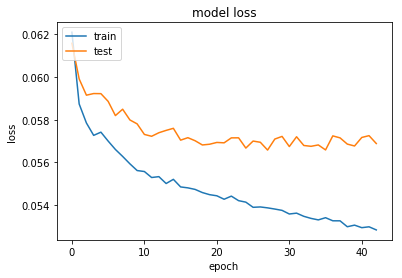

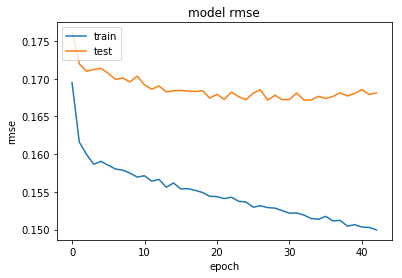

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  141.19564771652222 s =  2.353260811169942 min =  0.0392210136519538 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05942525224700611
Delay 100 ms: 0.00487220056782591
Delay 200 ms: 0.013632210113321792
Delay 300 ms: 0.024994879897494045
Delay 400 ms: 0.03774112888267949
Delay 500 ms: 0.05117474626429478
Delay 600 ms: 0.06493653200884122
Delay 700 ms: 0.07881536183467956
Delay 800 ms: 0.09260997952517788
Delay 900 ms: 0.10615860763349076
Delay 1000 ms: 0.11931687574225552

RMSE
Average rmse: 0.1274785998155532
Delay 100 ms: 0.01589797911335953
Delay 200 ms: 0.03161279864517051
Delay 300 ms: 0.05214044977072039
Delay 400 ms: 0.07489968902945872
Delay 500 ms: 0.0982982787615739
Delay 600 ms: 0.12166327503645652
Delay 700 ms: 0.14459894340372276
Delay 800 ms: 0.16683063306771373
Delay 900 ms: 0.1882514273158413
Delay 1000 ms: 0.20873790449638047

SMAPE
Average smape: 12.935456164212153
Delay 100 ms: 2.0039268325713078
Delay 200 ms: 4.746261221962558
Delay 300 ms: 7.496583476071907
Delay 400 ms: 10.069801559525562
Delay 500 ms: 12.45855357984559
Delay 600 ms: 14.681797525461459
Delay 

(5879, 25, 3) (5879, 10, 3)


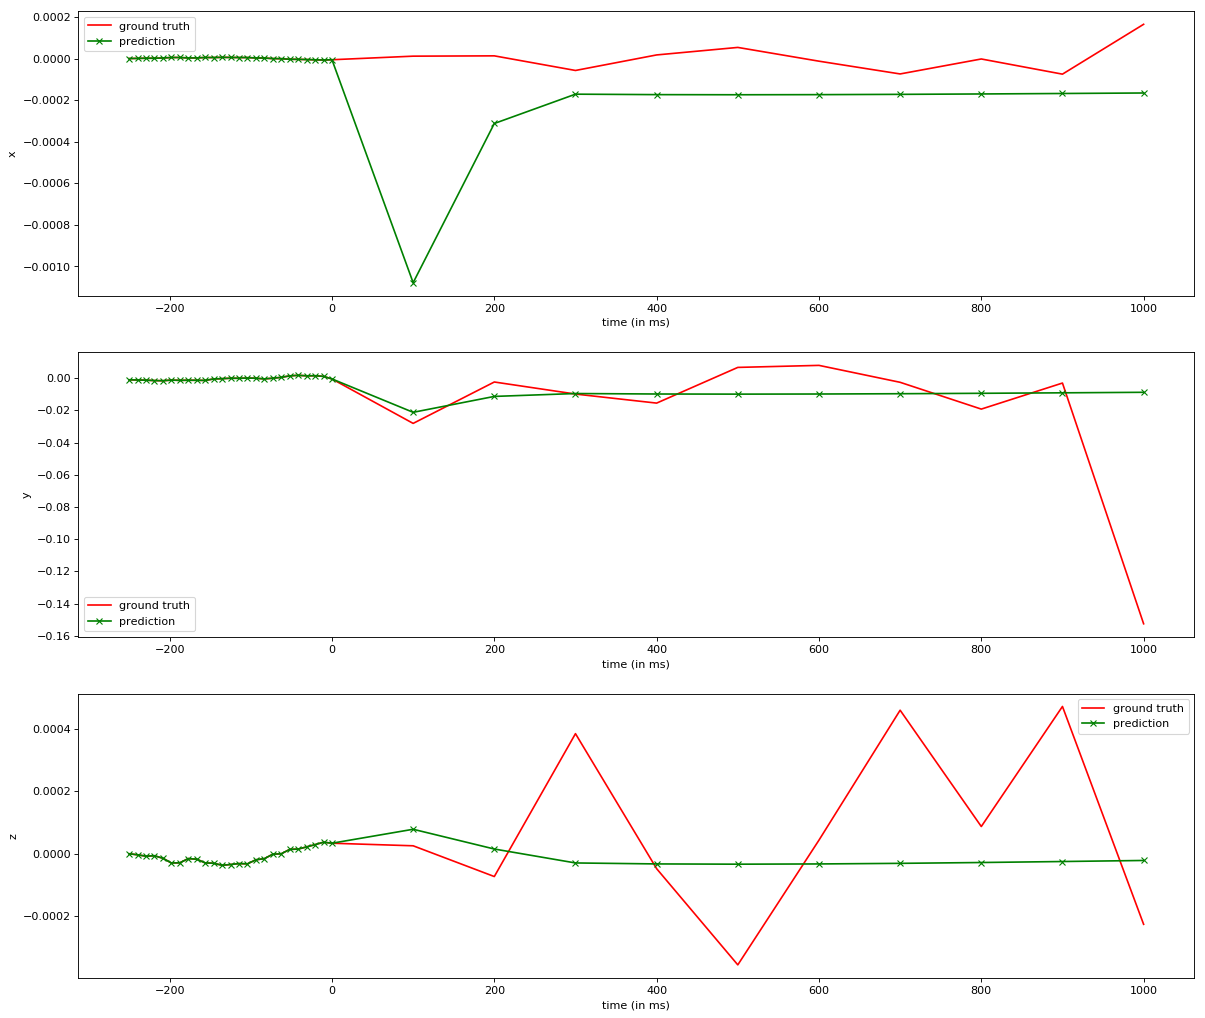

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data